In [5]:
!pip uninstall -y torch
!pip install torch==1.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --no-index --no-cache-dir torch-scatter  torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
!pip install --no-cache-dir torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
!pip install --no-cache-dir torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
!pip install --no-cache-dir torch-geometric
!pip install wandb

Found existing installation: torch 1.6.0+cu101
Uninstalling torch-1.6.0+cu101:
  Successfully uninstalled torch-1.6.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.8.1%2Bcu101-cp37-cp37m-linux_x86_64.whl (763.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0+cu101 requires torch==1.6.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
     |████████████████████████████████| 7.9 MB 1.1 MB/s            
     |████████████████████████████████| 3.1 MB 43.7 MB/s            
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
     |████████████████████████████████| 1.5 MB 3.2 MB/s            
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1

In [2]:
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import wandb
import networkx as nx

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import ModuleList, Embedding
from torch.autograd import Variable

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv,GATv2Conv
from torch_geometric.nn import PNAConv, CGConv, BatchNorm, global_add_pool

from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import degree
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import HeteroData

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

General data:

In [4]:
path_2_root = "../"

In [5]:
authors_edges_papers_general = pd.read_csv(path_2_root + "processed_data/SSORC_CS_2010_2021_authors_edges_papers_indices.csv", index_col = 0, \
                                   converters={"papers_indices": lambda x: x.strip("[]").replace("'","").split(", ")})
authors_edges_general = pd.read_csv(path_2_root + "processed_data/SSORC_CS_2010_2021_authors_edge_list.csv", index_col = 0)

/home/user/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
papers_features_general = pd.read_csv(path_2_root + "processed_data/SSORC_CS_2010_2021_papers_features_vectorized_compressed_32.csv", index_col = 0)
authors_features_general = pd.read_csv(path_2_root + "processed_data/SSORC_CS_2010_2021_authors_features.csv", index_col = 0)

In [7]:
aev = authors_edges_general.values
edge_to_index = {(aev[i][0], aev[i][1]):i for i in tqdm(range(len(aev)))}

100%|██████████| 30796749/30796749 [00:37<00:00, 829892.50it/s]


Local data:

In [8]:
!ls datasets

ls: cannot access 'datasets': No such file or directory


In [9]:
dataset_name = 'SSORC_CS_10_21_1437_3164_unfiltered'

In [10]:
authors_edges_papers = pd.read_csv(path_2_root + "datasets/" + dataset_name + "/" + dataset_name + "_" + "authors_edges_papers_indices.csv", index_col = 0,\
                                   converters={"papers_indices": lambda x: x.strip("[]").replace("'","").split(", ")})

In [11]:
authors_graph = nx.read_edgelist(path_2_root + "datasets/" + dataset_name + "/" + dataset_name + "_" + "authors.edgelist", create_using = nx.DiGraph)

In [12]:
citation_graph = nx.read_edgelist(path_2_root + "datasets/" + dataset_name + "/" + dataset_name + "_" + "papers.edgelist", create_using = nx.DiGraph)

In [13]:
papers_targets = pd.read_csv(path_2_root + "datasets/" + dataset_name + "/" + dataset_name + "_papers_targets.csv", index_col = 0)

### MANDATORY CHECK

In [14]:
sAe = list(authors_graph.edges)
sAe = [(int(sAe[i][0]), int(sAe[i][1])) for i in range(len(sAe))]

In [15]:
authors_edges_papers_sub_2 = [authors_edges_papers["papers_indices"][edge_to_index[sAe[i]]] for i in tqdm(range(len(sAe)))]
authors_edges_papers_sub_flat_2 = [int(item) for subarray in authors_edges_papers_sub_2 for item in subarray]
unique_papers_2 = list(set(authors_edges_papers_sub_flat_2))

100%|██████████| 14866/14866 [00:00<00:00, 51393.44it/s]


In [16]:
cgn = list(citation_graph.nodes())
cgn = [int(cgn[i]) for i in range(len(cgn))]

In [17]:
len(set(unique_papers_2).intersection(set(cgn))), len(unique_papers_2), len(cgn)

(3164, 3164, 3164)

### Data preparation

In [18]:
splits = "10"
path = path_2_root + "datasets/" + dataset_name + "/split_" + str(splits) + "/"  

split = 0
train_data_a = torch.load(path + dataset_name + '_train_sample_' + str(split) + '.data')
val_data_a = torch.load(path + dataset_name + '_val_sample_' + str(split) + '.data')
test_data_a = torch.load(path + dataset_name + '_test_sample_' + str(split) + '.data')

In [19]:
papers_nodes = list(citation_graph.nodes)
papers_nodes = [int(papers_nodes[i]) for i in range(len(papers_nodes))]
papers_node_features = papers_features_general.iloc[papers_nodes, :]
for node in tqdm(citation_graph.nodes):
    citation_graph.nodes[node]['x'] = list(papers_node_features.loc[[int(node)]].values[0])
authors_nodes = list(authors_graph.nodes)
authors_nodes = [int(authors_nodes[i]) for i in range(len(authors_nodes))]
authors_node_features = authors_features_general.loc[authors_nodes]
for node in tqdm(authors_graph.nodes):
    authors_graph.nodes[node]['x'] = list(authors_node_features.loc[[int(node)]].values[0])
data_author = from_networkx(authors_graph)
data_citation = from_networkx(citation_graph)

deg = torch.zeros(2, dtype=torch.long)
d = degree(train_data_a.edge_index[1], num_nodes=train_data_a.num_nodes, dtype=torch.long)
deg = torch.bincount(d, minlength=deg.numel())

train_data_a.x, val_data_a.x, test_data_a.x = data_author.x.float(), data_author.x.float(), data_author.x.float()
data_citation.x = data_citation.x.float()

original_a_nodes = list(authors_graph.nodes)
pyg_id_2_original_id = {i:int(original_a_nodes[i]) for i in range(len(original_a_nodes))}


original_a_nodes = list(authors_graph.nodes)
pyg_id_2_original_id = {i:int(original_a_nodes[i]) for i in range(len(original_a_nodes))}

sAe_t = train_data_a.edge_index.cpu().numpy().T
sAe_t = [(pyg_id_2_original_id[int(sAe_t[i][0])], pyg_id_2_original_id[int(sAe_t[i][1])]) for i in range(len(sAe_t))]

authors_edges_papers_sub_2t = [authors_edges_papers["papers_indices"][edge_to_index[sAe_t[i]]] for i in tqdm(range(len(sAe_t)))]
authors_edges_papers_sub_flat_2t = [str(item) for subarray in authors_edges_papers_sub_2t for item in subarray]
unique_papers_2t = list(set(authors_edges_papers_sub_flat_2t))

100%|██████████| 10407/10407 [00:00<00:00, 71650.84it/s]


In [20]:
citation_graph_sub = citation_graph.subgraph(unique_papers_2t)
citation_graph_sub_nodes = list(citation_graph_sub.nodes())
global_to_local_id_citation = {citation_graph_sub_nodes[i]:i for i in range(len(citation_graph_sub_nodes))}
authors_graph_sub_nodes = list(authors_graph.nodes())
global_to_local_id_authors = {authors_graph_sub_nodes[i]:i for i in range(len(authors_graph_sub_nodes))}

In [21]:
authors_to_papers = dict()
for i in tqdm(range(len(sAe_t))):
    papers = authors_edges_papers_sub_2t[i]
    author_1, author_2 = sAe_t[i]
    for author in sAe_t[i]:
        if author in authors_to_papers:
            for paper in papers:
                authors_to_papers[global_to_local_id_authors[str(author)]].add(global_to_local_id_citation[paper])
        else:
            authors_to_papers[global_to_local_id_authors[str(author)]] = set()
            for paper in papers:
                authors_to_papers[global_to_local_id_authors[str(author)]].add(global_to_local_id_citation[paper])


100%|██████████| 10407/10407 [00:00<00:00, 315973.23it/s]


### Final preparations of graphs

Adding feature description of citation graph:

In [22]:
for node in tqdm(citation_graph_sub.nodes):
    citation_graph_sub.nodes[node]['x'] = list(papers_features_general.loc[[int(node)]].values[0])
data_citation = from_networkx(citation_graph_sub)
data_citation.x = data_citation.x.float()

100%|██████████| 2485/2485 [00:00<00:00, 5277.71it/s]


Adding feature description of co-authorship graph:

In [23]:
authors_nodes = list(authors_graph.nodes)
authors_nodes = [int(authors_nodes[i]) for i in range(len(authors_nodes))]
authors_node_features = authors_features_general.loc[authors_nodes]

### Auxiliary targets computing

In [24]:
data_author = data_author 
edges_ordered = [(int(data_author.edge_index.T[i][0]), int(data_author.edge_index.T[i][1])) for i in range(len(data_author.edge_index.T))]
index_to_edge = {i:edges_ordered[i] for i in range(len(edges_ordered))}
authors_edges_papers_sample = authors_edges_papers_sub_2
citation_nodes = list(citation_graph.nodes)
ownership_dict = {}
inds_dict = {}
for i in tqdm(range(len(authors_edges_papers_sample))):
    arr = authors_edges_papers_sample[i]
    collab_embeddings = []
    for j in range(len(arr)):
        ind = citation_nodes.index(arr[j]) # index_outer_2_index_inner[int(arr[j])]
        collab_embeddings.append(ind)
    ownership_dict[i] = i
    inds_dict[i] = collab_embeddings
    
embs_dict = inds_dict
lens = set([len(embs_dict[i]) for i in range(len(embs_dict))])
batch_dict_x = {}
batch_dict_owner = {}
batch_dict_ind = {}
for i in tqdm(range(len(embs_dict))):
    if (len(embs_dict[i])) in batch_dict_x:
        batch_dict_x[len(embs_dict[i])].append(embs_dict[i])
        batch_dict_owner[len(embs_dict[i])].append(ownership_dict[i])
        batch_dict_ind[len(embs_dict[i])].append(i)
    else:
        batch_dict_x[len(embs_dict[i])], batch_dict_owner[len(embs_dict[i])], batch_dict_ind[len(embs_dict[i])] = [], [], []
        batch_dict_x[len(embs_dict[i])].append(embs_dict[i])
        batch_dict_owner[len(embs_dict[i])].append(ownership_dict[i])
        batch_dict_ind[len(embs_dict[i])].append(i)

for length in batch_dict_owner:
    batch_dict_owner[length] = [index_to_edge[batch_dict_owner[length][i]] for i in range(len(batch_dict_owner[length]))]
    
batch_list_x = list(batch_dict_x.values())
batch_list_owner = list(batch_dict_owner.values())
batch_list_ind = list(batch_dict_ind.values())

100%|██████████| 14866/14866 [00:00<00:00, 915226.09it/s]


In [25]:
papers_targets = papers_targets.values

In [26]:
aux_targets = []
for i in tqdm(range(len(batch_list_x))):
    batch = batch_list_x[i]
    values = []
    for j in range(len(batch)):
        values = [papers_targets[batch[j][k]] for k in range(len(batch[j]))]
        values = np.array(values).T
        targets = [max(values[0]), sum(values[1])/len(values[1]), 
                   sum(values[2])/len(values[2]), sum(values[3])/len(values[3]),
                   len(values[0])]
        aux_targets.append(targets)
        
batch_list_owner_flat = [edge for batch in batch_list_owner for edge in batch]
aux_target_dict = {batch_list_owner_flat[i]:aux_targets[i] for i in tqdm(range(len(aux_targets)))}

train_edges_aux_t, val_edges_aux_t, test_edges_aux_t = train_data_a.edge_label_index.cpu().numpy().T,\
                                                       val_data_a.edge_label_index.cpu().numpy().T,\
                                                       test_data_a.edge_label_index.cpu().numpy().T

train_edges_aux_t, val_edges_aux_t, test_edges_aux_t = [(train_edges_aux_t[i][0], train_edges_aux_t[i][1]) for i in range(len(train_edges_aux_t))],\
                                                       [(val_edges_aux_t[i][0], val_edges_aux_t[i][1]) for i in range(len(val_edges_aux_t))],\
                                                       [(test_edges_aux_t[i][0], test_edges_aux_t[i][1]) for i in range(len(test_edges_aux_t))]

def get_aux_targets(train_edges_aux_t: list) -> list:
    aux_train_target = []
    for k in range(len(train_edges_aux_t)):
        if train_edges_aux_t[k] in aux_target_dict:
            aux_train_target.append(aux_target_dict[train_edges_aux_t[k]])
        else:
            aux_train_target.append([0, 0, 0, 0, 0])
    return aux_train_target

def task_split(aux_train_targets):
    y_q, y_sjr, y_h, y_if, y_n = np.array(aux_train_targets).T
    return torch.Tensor(y_q.T).float().cuda(),\
           torch.Tensor(y_sjr.T).float().cuda(),\
           torch.Tensor(y_h.T).float().cuda(),\
           torch.Tensor(y_if.T).float().cuda(),\
           torch.Tensor(y_n.T).float().cuda()

aux_train_targets, aux_val_targets, aux_test_targets = get_aux_targets(train_edges_aux_t),\
                                                       get_aux_targets(val_edges_aux_t),\
                                                       get_aux_targets(test_edges_aux_t)

train_aux_y, test_aux_y = task_split(aux_train_targets), task_split(aux_test_targets)

train_data_a.aux = train_aux_y
test_data_a.aux = test_aux_y

100%|██████████| 14866/14866 [00:00<00:00, 3093650.37it/s]


### Model

In [33]:
class ResLinearBlock(nn.Module):
    def __init__(self, size, link_size):
        super(ResLinearBlock, self).__init__()
        self.linear_1 = nn.Linear(size, size)
        self.linear_2 = nn.Linear(size, size)
        self.linear_3 = nn.Linear(size, link_size)
        self.batch_norm_1 = nn.BatchNorm1d(size)
        self.batch_norm_2 = nn.BatchNorm1d(size)

    def forward(self, x):
        result = self.linear_1(x)
        result = F.relu(self.batch_norm_1(result))
        result = self.linear_2(result)
        result = F.relu(self.batch_norm_2(result))
        result = self.linear_3(x + result)
        return result
    
class gs_sum_concatenation_gs(nn.Module):
    def __init__(self, data_c, 
                 parameters, 
                 train_data_a, val_data_a, test_data_a):
        super(gs_sum_concatenation_gs, self).__init__()
        
        self.data_c  = data_c
        self.train_data_a, self.val_data_a, self.test_data_a = train_data_a, val_data_a, test_data_a 
        self.params = parameters
        
        # convolutions on citation graph
        self.conv_c_1 = GATv2Conv(data_c.x.shape[1], self.params["conv_size"][0])
        self.conv_c_2 = GATv2Conv(self.params["conv_size"][0], self.params["conv_size"][1])
        self.conv_c_3 = GATv2Conv(self.params["conv_size"][1], self.params["conv_size"][2])
        
        # aggregation
        self.pre_conv = nn.Linear(self.params["conv_size"][2]+19, 75)
            
        self.input_size = self.params["conv_size"][2]+19
        self.num_layers = 1
        self.hidden_size = 75
        
        self.lstm = nn.LSTM(input_size=75, hidden_size=75,
                    num_layers=1, batch_first=True)
        
        # convolutions on co-authorship graph
        
        self.convs_a = ModuleList()
        self.batch_norms = ModuleList()
        
        for _ in range(3):
            conv_a = GATv2Conv(75, 75)
            self.convs_a.append(conv_a)
            self.batch_norms.append(BatchNorm(75))
        
        # post link prediction layers
        self.post_lp_layers = ModuleList()
        for _ in range(4):
            hidden_post_lp = nn.Linear(75, 1)
            self.post_lp_layers.append(hidden_post_lp)
            
        # multitask
        self.hidden_q1 = ResLinearBlock(75, 128)
        self.hidden_q2 = nn.Linear(128, 75)
        
        self.hidden_if1 = ResLinearBlock(75, 128)
        self.hidden_if2 = nn.Linear(128, 75)
        
        self.hidden_hi1 = ResLinearBlock(75, 128)
        self.hidden_hi2 = nn.Linear(128, 75)

        self.hidden_sjr1 = ResLinearBlock(75, 128)
        self.hidden_sjr2 = nn.Linear(128, 75)

    def forward(self, sample, batch_list_x, batch_list_owner, operator = "l2"):
        def cp(z, edge_index):
            return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

        def l1(z, edge_index):
            return (torch.abs(z[edge_index[0]] - z[edge_index[1]]))

        def l2(z, edge_index):
            return (torch.pow(z[edge_index[0]] - z[edge_index[1]], 2))

        def hadamard(z, edge_index):
            return (z[edge_index[0]] * z[edge_index[1]])
       
        def summ(z, edge_index):
            return (z[edge_index[0]] + z[edge_index[1]])
        
        x_a = self.train_data_a.x
        if True:
            x_c = F.relu(self.conv_c_1(self.data_c.x, self.data_c.edge_index, None))
            x_c = F.relu(self.conv_c_2(x_c, self.data_c.edge_index, None))
            x_c = F.relu(self.conv_c_3(x_c, self.data_c.edge_index, None))


            counter = 0
            x = torch.zeros(x_a.shape[0], x_a.shape[1] + x_c.shape[1]).to(device)
            for i in range(len(x_a)):
                if i in authors_to_papers:
                    collab_emb = sum(x_c[list(authors_to_papers[i])])
                else:
                    counter += 1
                    collab_emb = torch.zeros(self.params["conv_size"][2]).to(device)
                x[i] = torch.cat((x_a[i].unsqueeze(0), collab_emb.unsqueeze(0)), 1)

        convolutions = []
        x = self.pre_conv(x)
        convolutions.append(x)
        for conv, batch_norm in zip(self.convs_a, self.batch_norms):
            x = F.relu(conv(x, self.train_data_a.edge_index))
            convolutions.append(x)
        
        horizontal = []
        for j in range(len(convolutions[0])):
            horizontal.append([convolutions[i][j] for i in range(len(convolutions))])
            horizontal[j] = torch.stack(horizontal[j])
        emb_seqs_t = torch.stack(horizontal)

        h_0 = Variable(torch.zeros(
        self.num_layers, emb_seqs_t.size(0), self.hidden_size)).to(device)

        c_0 = Variable(torch.zeros(
        self.num_layers, emb_seqs_t.size(0), self.hidden_size)).to(device)

        ula, (h_out, _) = self.lstm(emb_seqs_t, (h_0, c_0))        
        
        x = h_out.view(-1, self.hidden_size)
#        x = x_a
        
        q = self.hidden_q1(x)
        q = self.hidden_q2(q)
        
        ifact = self.hidden_if1(x)
        ifact = self.hidden_if2(ifact)
        
        hi = self.hidden_hi1(x)
        hi = self.hidden_hi2(hi)
        
        sjr = self.hidden_sjr1(x)
        sjr = self.hidden_sjr2(sjr)
        
        operator_dict = {"cp": cp, "l1": l1, "l2": l2, "hadamard": hadamard, "summ": summ}
        embedding_operator = operator_dict[operator]
        
        edge_index = sample.edge_label_index
        
        link_embeddings, sjr_embeddings, hi_embeddings, if_embeddings = embedding_operator(x, edge_index),\
                                                                        embedding_operator(sjr, edge_index),\
                                                                        embedding_operator(hi, edge_index),\
                                                                        embedding_operator(ifact, edge_index)
        
        embeddings = [link_embeddings, sjr_embeddings, hi_embeddings, if_embeddings]
        if embedding_operator != cp:
            for i in range(len(embeddings)):
                embeddings[i] = self.post_lp_layers[i](embeddings[i]).squeeze(-1)
            
        return embeddings

In [28]:
operator = "hadamard"

def train(model, optimizer, criterion, mt_coeffs = [0, 0, 0]):
    model.train()
    optimizer.zero_grad()
    sample = model.train_data_a
    z, z_sjr, z_hi, z_ifact = model(sample, batch_list_x, batch_list_owner, operator)
    edge_index = sample.edge_label_index
#    link_embeddings = F.relu(final(link_embeddings))
    link_labels = sample.edge_label
    loss = F.binary_cross_entropy_with_logits(z, link_labels)\
                                               + mt_coeffs[0]*criterion(z_sjr, sample.aux[1])\
                                               + mt_coeffs[1]*criterion(z_hi, sample.aux[2])\
                                               + mt_coeffs[2]*criterion(z_ifact, sample.aux[3])
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def test(model, optimizer, criterion):
    model.eval()
    perfs = []
    aux = []

    for sample in [model.train_data_a, model.test_data_a]: 
        z, z_sjr, z_hi, z_ifact = model(sample, batch_list_x, batch_list_owner, operator)
#        link_embeddings = F.relu(final(link_embeddings))
        link_probs = z.sigmoid()
        link_labels = sample.edge_label
        aux.append([mean_absolute_error(sample.aux[1].cpu(), z_sjr.cpu()),\
                    mean_absolute_error(sample.aux[2].cpu(), z_hi.cpu()),\
                    mean_absolute_error(sample.aux[3].cpu(), z_ifact.cpu())])
        perfs.append([accuracy_score(link_labels.cpu(), link_probs.cpu().round()),\
                      f1_score(link_labels.cpu(), link_probs.cpu().round()),\
                      roc_auc_score(link_labels.cpu(), link_probs.cpu())])
    return perfs, aux

In [ ]:
project_name = 'GAT_0.1'
epochs_per_launch = 15000
lr = 0.0005
mt_weights = [[0.3, 0.3, 0.3]] #[[0.01, 0.01, 0.01], [0.01, 0.001, 0.01], [0.001, 0.001, 0.001], [0.001, 0.00001, 0.001]]
for i in range(10):
    for mt_weight in mt_weights:
        group = "rmgnn(a_original_rgat_res)_split_n0_" + str(mt_weight[0]) + "_"\
        + str(mt_weight[1]) + "_" + str(mt_weight[2]) + "_"\
        + operator + "_" + str(lr) + "_no_wd"
        entity = "sbergraphs"
        device = 'cuda:1' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        parameters = {"conv_size": [128, 128, 128]}
        model = gs_sum_concatenation_gs(data_citation, parameters,\
                                    train_data_a, val_data_a, test_data_a).to(device) 
        data_citation, data_author, train_data_a = data_citation.to(device), data_author.to(device), train_data_a.to(device) 

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.L1Loss()
        run(project_name, group, entity, mt_weight, model, optimizer, criterion, i)

aux_min/test_min_mae_h_index,████████████████████▁▁▁
aux_min/test_min_mae_impact_factor,██████████▃▃▃▃▃▃▃▃▃▃▁▁▁
aux_min/test_min_mae_sjr,██████████▅▅▅▅▅▅▅▅▅▅▁▁▁
aux_test/test_mae_h_index,████████████████████▁▁▁
aux_test/test_mae_impact_factor,██████████▃▃▃▃▃▃▃▃▃▃▁▁▁
aux_test/test_mae_sjr,██████████▅▅▅▅▅▅▅▅▅▅▁▁▁
aux_train/train_mae_h_index,████████████████████▁▁▁
aux_train/train_mae_impact_factor,██████████▃▃▃▃▃▃▃▃▃▃▁▁▁
aux_train/train_mae_sjr,██████████▅▅▅▅▅▅▅▅▅▅▁▁▁
main_max/test_max_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
main_max/test_max_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


2022-01-14 19:18:47.807383: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|          | 1/15000 [00:01<4:11:43,  1.01s/it]

Loss: 30.810558319091797 
Train: [0.5, 0.6666666666666666, 0.573008112439269] 
Test: [0.5, 0.6666666666666666, 0.5911731765958658]
Aux: [[1.6851019, 95.691475, 3.0057712], [1.701055, 96.68739, 3.0279174]]


  0%|          | 11/15000 [00:07<3:07:03,  1.34it/s]

Loss: 30.340978622436523 
Train: [0.5, 0.6666666666666666, 0.7291983264880302] 
Test: [0.5, 0.6666666666666666, 0.745722263913737]
Aux: [[1.6848294, 95.66713, 2.990256], [1.7007705, 96.66305, 3.0123973]]


  0%|          | 21/15000 [00:14<3:08:27,  1.32it/s]

Loss: 28.134193420410156 
Train: [0.5, 0.6666666666666666, 0.7070649565102555] 
Test: [0.5, 0.6666666666666666, 0.7225334660673498]
Aux: [[1.6839274, 95.651146, 2.9629261], [1.6998366, 96.6469, 2.9850488]]


  0%|          | 31/15000 [00:21<3:10:04,  1.31it/s]

Loss: 21.352773666381836 
Train: [0.5, 0.6666666666666666, 0.7037006906260264] 
Test: [0.5, 0.6666666666666666, 0.7173817072567787]
Aux: [[1.6833797, 95.62673, 2.9586186], [1.6992697, 96.62168, 2.980665]]


  0%|          | 41/15000 [00:28<3:10:55,  1.31it/s]

Loss: 13.887752532958984 
Train: [0.5, 0.6666666666666666, 0.7261051314137825] 
Test: [0.5, 0.6666666666666666, 0.7376401063999134]
Aux: [[1.6714169, 94.87386, 2.9445503], [1.6869329, 95.84823, 2.9661317]]


  0%|          | 51/15000 [00:35<3:09:30,  1.31it/s]

Loss: 13.475464820861816 
Train: [0.5, 0.6666666666666666, 0.7288312680717144] 
Test: [0.5, 0.6666666666666666, 0.7451587213500946]
Aux: [[1.6555367, 94.082794, 2.929576], [1.6706383, 95.035934, 2.9505813]]


  0%|          | 61/15000 [00:42<3:11:17,  1.30it/s]

Loss: 13.233865737915039 
Train: [0.5, 0.6666666666666666, 0.725619861250266] 
Test: [0.5, 0.6666666666666666, 0.7425237836797576]
Aux: [[1.6111624, 90.63245, 2.8651557], [1.6251675, 91.49955, 2.8844545]]


  0%|          | 71/15000 [00:49<3:11:10,  1.30it/s]

Loss: 13.186925888061523 
Train: [0.49990391082924956, 0.6665812485986098, 0.7252281503802263] 
Test: [0.5, 0.6666666666666666, 0.74181508449914]
Aux: [[1.5028899, 81.08643, 2.6867902], [1.514059, 81.713554, 2.7014399]]


  1%|          | 81/15000 [00:57<3:37:51,  1.14it/s]

Loss: 13.080038070678711 
Train: [0.5000480445853752, 0.6666025887479174, 0.726769824351452] 
Test: [0.5005045408678103, 0.6668162441103882, 0.7428096279453753]
Aux: [[1.2673062, 66.34919, 2.3034902], [1.2721926, 66.61396, 2.3095896]]


  1%|          | 91/15000 [01:05<3:42:19,  1.12it/s]

Loss: 12.97940731048584 
Train: [0.5016335159027577, 0.666645242150593, 0.729302628526791] 
Test: [0.5006727211570804, 0.6660668091328309, 0.744997159659494]
Aux: [[0.99169767, 55.31482, 1.886528], [0.99015397, 55.1522, 1.8865726]]


  1%|          | 101/15000 [01:12<3:36:28,  1.15it/s]

Loss: 12.896092414855957 
Train: [0.504420101854521, 0.6625666524910858, 0.7315974164930216] 
Test: [0.507063572149344, 0.6644533485975959, 0.7476040955662291]
Aux: [[0.7842998, 51.90822, 1.5685016], [0.7770702, 51.640205, 1.5648074]]


  1%|          | 111/15000 [01:20<3:36:27,  1.15it/s]

Loss: 12.816683769226074 
Train: [0.5826366868453925, 0.6614970969878814, 0.730682745827967] 
Test: [0.5958627648839556, 0.6731056999047749, 0.7476027379049635]
Aux: [[0.66557264, 52.712063, 1.3917434], [0.6569239, 52.494835, 1.3860236]]


  1%|          | 121/15000 [01:28<3:37:39,  1.14it/s]

Loss: 13.026327133178711 
Train: [0.6714230806188143, 0.6801365698517375, 0.729685669488948] 
Test: [0.6836528758829465, 0.6935983059130152, 0.7463603081393264]
Aux: [[0.59212905, 50.4451, 1.3318825], [0.58061093, 50.150307, 1.3245934]]


  1%|          | 131/15000 [01:36<3:36:35,  1.14it/s]

Loss: 13.088430404663086 
Train: [0.651580666858845, 0.6111528150134048, 0.726743288339466] 
Test: [0.6590985536495123, 0.6190565683142267, 0.7431231911284981]
Aux: [[0.53039265, 46.035187, 1.2217807], [0.51873183, 45.642296, 1.2120061]]


  1%|          | 141/15000 [01:44<3:37:26,  1.14it/s]

Loss: 13.065227508544922 
Train: [0.6557605457864899, 0.6114635865733963, 0.727881174508266] 
Test: [0.6633030608812647, 0.620257966616085, 0.7433309698713468]
Aux: [[0.60181427, 46.958485, 1.1833031], [0.5916203, 46.575844, 1.1723177]]


  1%|          | 151/15000 [01:51<3:33:42,  1.16it/s]

Loss: 12.727128028869629 
Train: [0.6590756221773806, 0.608085717441732, 0.7281332620055673] 
Test: [0.665489404641776, 0.6150570930907684, 0.7434031521952985]
Aux: [[0.6031301, 46.336723, 1.0880659], [0.5938484, 45.944942, 1.0753211]]


  1%|          | 161/15000 [01:59<3:36:54,  1.14it/s]

Loss: 12.658914566040039 
Train: [0.661477851446142, 0.6065884980457844, 0.729022149158628] 
Test: [0.6688530104271779, 0.6146016833039734, 0.7443427103602791]
Aux: [[0.57563335, 50.12054, 1.2311548], [0.5660037, 49.872055, 1.2237319]]


  1%|          | 171/15000 [02:07<3:35:18,  1.15it/s]

Loss: 12.63609790802002 
Train: [0.6628711444220237, 0.6046092297289682, 0.7284406051617861] 
Test: [0.6691893710057182, 0.6111879818145879, 0.7437930272553893]
Aux: [[0.57547677, 51.467995, 1.1856745], [0.5648323, 51.27936, 1.1757879]]


  1%|          | 181/15000 [02:15<3:36:07,  1.14it/s]

Loss: 12.634528160095215 
Train: [0.663159411934275, 0.6069846964515947, 0.7299634481669558] 
Test: [0.6698620921627986, 0.61441759968572, 0.7448411983216138]
Aux: [[0.55358064, 49.86018, 1.1724236], [0.5431472, 49.616356, 1.1625406]]


  1%|▏         | 191/15000 [02:23<3:35:59,  1.14it/s]

Loss: 12.64622974395752 
Train: [0.6632074565196502, 0.6073708972779209, 0.728545336541033] 
Test: [0.6695257315842583, 0.6140247495580435, 0.743140218463537]
Aux: [[0.50462407, 40.697014, 0.99357337], [0.49328896, 40.188725, 0.97981]]


  1%|▏         | 201/15000 [02:30<3:36:00,  1.14it/s]

Loss: 12.561766624450684 
Train: [0.6634957240319016, 0.6090645233311007, 0.7293406551674881] 
Test: [0.6698620921627986, 0.6151734953930601, 0.7434986410376424]
Aux: [[0.5757624, 43.634754, 1.2290843], [0.5662221, 43.256042, 1.2247556]]


  1%|▏         | 211/15000 [02:38<3:19:07,  1.24it/s]

Loss: 12.567035675048828 
Train: [0.6632555011050255, 0.6091127098321343, 0.7272195839018518] 
Test: [0.6696939118735284, 0.615505090054816, 0.7409666593466095]
Aux: [[0.528801, 39.978645, 1.1974995], [0.5184109, 39.556236, 1.1928489]]


  1%|▏         | 221/15000 [02:45<3:12:15,  1.28it/s]

Loss: 12.613065719604492 
Train: [0.6623426539828962, 0.6097723486951694, 0.72785237637974] 
Test: [0.6686848301379078, 0.6164330218068537, 0.7411212630232245]
Aux: [[0.5446074, 38.09268, 1.2018608], [0.5360967, 37.633755, 1.1933893]]


  2%|▏         | 231/15000 [02:52<3:33:36,  1.15it/s]

Loss: 12.458592414855957 
Train: [0.6632555011050255, 0.6095917116916393, 0.7262593754458736] 
Test: [0.6698620921627986, 0.6162267839687194, 0.7392362634944458]
Aux: [[0.5118154, 41.78228, 0.9928438], [0.5032266, 41.51693, 0.9783639]]


  2%|▏         | 241/15000 [03:00<3:34:13,  1.15it/s]

Loss: 12.421683311462402 
Train: [0.6641203036417795, 0.6105075491670846, 0.728033659629333] 
Test: [0.6703666330306088, 0.6170379054318094, 0.7406159867555617]
Aux: [[0.5554784, 38.445976, 1.079978], [0.54735845, 38.076694, 1.0710759]]


  2%|▏         | 251/15000 [03:08<3:31:39,  1.16it/s]

Loss: 12.63375186920166 
Train: [0.6639281253002787, 0.6100239727936667, 0.7271476393627445] 
Test: [0.6700302724520686, 0.6158966327329679, 0.7394855074751132]
Aux: [[0.5041707, 40.77973, 1.0507745], [0.49704129, 40.569714, 1.0439013]]


  2%|▏         | 261/15000 [03:16<3:33:27,  1.15it/s]

Loss: 12.452919960021973 
Train: [0.663351590275776, 0.6103975535168196, 0.7282453244890301] 
Test: [0.6691893710057182, 0.6163448410376438, 0.7396368301370027]
Aux: [[0.61005604, 40.10043, 1.0345914], [0.6043349, 39.826878, 1.0219555]]


  2%|▏         | 271/15000 [03:23<3:34:21,  1.15it/s]

Loss: 12.569867134094238 
Train: [0.6646968386662823, 0.610829197568728, 0.7283956444414086] 
Test: [0.6712075344769594, 0.6176413064736945, 0.7398476070484795]
Aux: [[0.467015, 38.721485, 1.0832068], [0.4575516, 38.39942, 1.0749655]]


  2%|▏         | 281/15000 [03:31<3:33:51,  1.15it/s]

Loss: 12.41082763671875 
Train: [0.6644566157394062, 0.610398304139239, 0.7288849125496677] 
Test: [0.6701984527413387, 0.6163177460379573, 0.7398846598871851]
Aux: [[0.49649104, 42.492737, 1.1343246], [0.48978987, 42.392605, 1.1277583]]


  2%|▏         | 291/15000 [03:39<3:34:10,  1.14it/s]

Loss: 12.354619026184082 
Train: [0.6653214182761603, 0.6114457831325301, 0.730698363665223] 
Test: [0.6715438950554995, 0.6180324662624683, 0.7415980849735295]
Aux: [[0.5093248, 37.688606, 1.0694203], [0.50055856, 37.405247, 1.0584561]]


  2%|▏         | 301/15000 [03:47<3:32:33,  1.15it/s]

Loss: 12.244176864624023 
Train: [0.6659459978860383, 0.6115425442762166, 0.7313226893640608] 
Test: [0.6722166162125799, 0.6180678032529884, 0.7418324512494952]
Aux: [[0.47105905, 37.26805, 0.97283024], [0.46325457, 36.97099, 0.958824]]


  2%|▏         | 311/15000 [03:54<3:35:02,  1.14it/s]

Loss: 12.12219524383545 
Train: [0.665897953300663, 0.6122881355932203, 0.7338145538465866] 
Test: [0.6717120753447696, 0.6181533646322379, 0.7436723085411941]
Aux: [[0.5204219, 37.681553, 1.2577152], [0.51657534, 37.4352, 1.246943]]


  2%|▏         | 321/15000 [04:02<3:31:19,  1.16it/s]

Loss: 11.242204666137695 
Train: [0.6673392908619199, 0.6121877450431276, 0.7332221886228667] 
Test: [0.67255297679112, 0.6177105831533477, 0.7425860098210953]
Aux: [[0.46851188, 40.644577, 1.3231249], [0.46195185, 40.627174, 1.3154855]]


  2%|▏         | 331/15000 [04:10<3:33:01,  1.15it/s]

Loss: 9.977007865905762 
Train: [0.6678677813010474, 0.6091037602487984, 0.7340413610374099] 
Test: [0.6732256979482004, 0.615171321053674, 0.7421147882235104]
Aux: [[0.6449727, 41.609932, 1.0576437], [0.64389884, 41.641964, 1.0507437]]


  2%|▏         | 341/15000 [04:18<3:33:58,  1.14it/s]

Loss: 9.68331241607666 
Train: [0.6693571634476795, 0.606337947603249, 0.7301952043147814] 
Test: [0.6740665993945509, 0.6125549780087964, 0.7372970140842648]
Aux: [[0.69159615, 45.836884, 1.1841251], [0.6923585, 45.760185, 1.1827991]]


  2%|▏         | 351/15000 [04:26<3:31:59,  1.15it/s]

Loss: 9.401591300964355 
Train: [0.6678197367156722, 0.6103032352609626, 0.7392674226992537] 
Test: [0.6722166162125799, 0.6153542530096704, 0.746404318992018]
Aux: [[0.54385084, 42.12529, 1.0356128], [0.5421181, 42.07545, 1.037165]]


  2%|▏         | 361/15000 [04:33<3:33:48,  1.14it/s]

Loss: 9.216550827026367 
Train: [0.666954934178918, 0.6120004477779021, 0.7414174490566046] 
Test: [0.6712075344769594, 0.6173419455862204, 0.7488281969047812]
Aux: [[0.4351642, 31.163324, 1.1370803], [0.43333367, 30.77969, 1.1463635]]


  2%|▏         | 371/15000 [04:41<3:33:06,  1.14it/s]

Loss: 9.213056564331055 
Train: [0.6684923609109253, 0.6119235095613048, 0.7396193295513146] 
Test: [0.6735620585267407, 0.6170842375221938, 0.7468792175888637]
Aux: [[0.427424, 32.723103, 1.0898219], [0.42496055, 32.44513, 1.0957822]]


  3%|▎         | 381/15000 [04:49<3:32:26,  1.15it/s]

Loss: 8.95893383026123 
Train: [0.6678197367156722, 0.6110048385281872, 0.74244083981252] 
Test: [0.6722166162125799, 0.6159605911330049, 0.7494072394345387]
Aux: [[0.46320868, 32.848667, 1.0382707], [0.46537805, 32.701687, 1.046745]]


  3%|▎         | 391/15000 [04:57<3:37:17,  1.12it/s]

Loss: 9.160794258117676 
Train: [0.6683001825694245, 0.6120040463077441, 0.7429744269387093] 
Test: [0.67238479650185, 0.6169878096736138, 0.7498506855453992]
Aux: [[0.4051835, 36.745674, 1.0147254], [0.4000701, 36.724632, 1.0229583]]


  3%|▎         | 401/15000 [05:05<3:32:56,  1.14it/s]

Loss: 8.796072006225586 
Train: [0.6662823099836649, 0.6119986593676684, 0.7438113685095041] 
Test: [0.6713757147662294, 0.617911615174032, 0.7495499635750795]
Aux: [[0.6956673, 29.30114, 1.1073887], [0.6987087, 28.98087, 1.1100734]]


  3%|▎         | 411/15000 [05:12<3:31:59,  1.15it/s]

Loss: 8.866203308105469 
Train: [0.666522532910541, 0.6116053942140899, 0.7435470425000639] 
Test: [0.6713757147662294, 0.617012936103489, 0.7500527507970887]
Aux: [[0.49569574, 28.318966, 0.92776525], [0.49766818, 28.107712, 0.93691367]]


  3%|▎         | 421/15000 [05:20<3:29:36,  1.16it/s]

Loss: 8.677197456359863 
Train: [0.6683482271547997, 0.6114707041143693, 0.7436532927289877] 
Test: [0.67255297679112, 0.6165058105180223, 0.7503016553624395]
Aux: [[0.5064214, 29.833258, 0.9761202], [0.5098971, 29.695515, 0.9886119]]


  3%|▎         | 431/15000 [05:28<3:35:34,  1.13it/s]

Loss: 8.599576950073242 
Train: [0.6685884500816758, 0.6117739756866277, 0.7439662680937353] 
Test: [0.67255297679112, 0.6165058105180223, 0.7503673322261606]
Aux: [[0.46659574, 30.702583, 1.0776068], [0.46955967, 30.78833, 1.0918126]]


  3%|▎         | 441/15000 [05:36<3:31:32,  1.15it/s]

Loss: 8.599811553955078 
Train: [0.6689728067646776, 0.6105584444946869, 0.7437482970071119] 
Test: [0.6733938782374705, 0.6157499010684606, 0.7503682939028904]
Aux: [[0.38273355, 30.369928, 1.0313622], [0.3842278, 30.393866, 1.047096]]


  3%|▎         | 451/15000 [05:44<3:31:04,  1.15it/s]

Loss: 8.670780181884766 
Train: [0.6672432016911694, 0.6119887955182073, 0.7442851480443091] 
Test: [0.6717120753447696, 0.6168040832351787, 0.7509450736638719]
Aux: [[0.44385347, 30.030054, 0.8927002], [0.44520855, 30.017843, 0.90810984]]


  3%|▎         | 461/15000 [05:51<3:14:07,  1.25it/s]

Loss: 8.548614501953125 
Train: [0.6692130296915537, 0.6119159010202356, 0.7438783086928366] 
Test: [0.6730575176589304, 0.616265298065535, 0.7505713208313096]
Aux: [[0.62328607, 45.223854, 1.1083858], [0.6268389, 45.786674, 1.1248082]]


  3%|▎         | 471/15000 [05:58<3:07:59,  1.29it/s]

Loss: 8.57404899597168 
Train: [0.6677236475449216, 0.6109798627517157, 0.7436526279437188] 
Test: [0.67238479650185, 0.6162332545311269, 0.7503377465244154]
Aux: [[0.49162203, 32.582325, 1.0305847], [0.49442273, 32.840107, 1.0494785]]


  3%|▎         | 481/15000 [06:05<3:06:50,  1.30it/s]

Loss: 8.645487785339355 
Train: [0.6679158258864226, 0.6122952658739061, 0.7447874856462936] 
Test: [0.6717120753447696, 0.6165029469548132, 0.7510174256954818]
Aux: [[0.536008, 31.938738, 1.0501833], [0.54034495, 31.98059, 1.0733287]]


  3%|▎         | 491/15000 [06:12<3:08:17,  1.28it/s]

Loss: 8.599886894226074 
Train: [0.6678677813010474, 0.6099858956276446, 0.74293258239928] 
Test: [0.67238479650185, 0.6151718688265507, 0.7501291758124953]
Aux: [[0.41519362, 33.267952, 0.9914505], [0.41676998, 33.353832, 1.0119303]]


  3%|▎         | 501/15000 [06:19<3:07:14,  1.29it/s]

Loss: 8.555758476257324 
Train: [0.6678677813010474, 0.6117382757652344, 0.7439378808394381] 
Test: [0.6718802556340396, 0.616322517207473, 0.7512487372336001]
Aux: [[0.4286759, 27.600824, 0.9768203], [0.43188566, 27.507902, 0.99097943]]


  3%|▎         | 511/15000 [06:26<3:05:07,  1.30it/s]

Loss: 8.599052429199219 
Train: [0.6681080042279235, 0.611036036036036, 0.7425065981553741] 
Test: [0.6727211570803902, 0.6160220994475137, 0.7497185398488855]
Aux: [[0.40676492, 30.04403, 0.93461365], [0.40945455, 30.015919, 0.94848]]


  3%|▎         | 521/15000 [06:33<3:05:32,  1.30it/s]

Loss: 8.502638816833496 
Train: [0.6689247621793024, 0.6110076206604573, 0.7434258761516677] 
Test: [0.6730575176589304, 0.6158102766798419, 0.7505562734189497]
Aux: [[0.4757736, 27.523254, 1.0231283], [0.477118, 27.423216, 1.0383964]]


  4%|▎         | 531/15000 [06:40<3:04:37,  1.31it/s]

Loss: 8.592114448547363 
Train: [0.6675314692034208, 0.611802984404802, 0.7439486420509792] 
Test: [0.6715438950554995, 0.6159292035398231, 0.7506481984004714]
Aux: [[0.45123243, 29.913696, 0.8492413], [0.45694312, 30.068525, 0.8623781]]


  4%|▎         | 541/15000 [06:47<3:04:50,  1.30it/s]

Loss: 8.632683753967285 
Train: [0.6684443163255501, 0.6119763845937588, 0.7434370990196458] 
Test: [0.6722166162125799, 0.6161118770927714, 0.7506028864557337]
Aux: [[0.3879657, 32.519527, 1.1076547], [0.39061967, 32.87129, 1.1145347]]


  4%|▎         | 551/15000 [06:54<3:09:16,  1.27it/s]

Loss: 8.457232475280762 
Train: [0.6676756029595464, 0.611295307670694, 0.7441653435824017] 
Test: [0.6718802556340396, 0.6158692656034652, 0.7511527392682817]
Aux: [[0.37060767, 31.06262, 1.2322669], [0.37381613, 31.346783, 1.2363021]]


  4%|▎         | 561/15000 [07:01<3:06:10,  1.29it/s]

Loss: 8.534324645996094 
Train: [0.6674834246180456, 0.6123340615022685, 0.7438271802424636] 
Test: [0.6722166162125799, 0.6176182067883069, 0.7506787457789462]
Aux: [[0.3989301, 33.614693, 1.014407], [0.40273476, 34.03733, 1.024068]]


  4%|▍         | 571/15000 [07:08<3:07:02,  1.29it/s]

Loss: 8.545104026794434 
Train: [0.6658018641299126, 0.6114400625628421, 0.743163350602331] 
Test: [0.6708711738984191, 0.6173998044965788, 0.7499569791086479]
Aux: [[0.43728024, 26.259693, 1.0602806], [0.43931744, 26.336721, 1.0727384]]


  4%|▍         | 581/15000 [07:15<3:06:30,  1.29it/s]

Loss: 8.475682258605957 
Train: [0.666954934178918, 0.6116526610644257, 0.7431531756944645] 
Test: [0.6708711738984191, 0.6157471038680542, 0.7501708673271914]
Aux: [[0.50759625, 27.969446, 0.8705023], [0.5155515, 27.942278, 0.88150483]]


  4%|▍         | 591/15000 [07:22<3:07:22,  1.28it/s]

Loss: 8.321133613586426 
Train: [0.6671471125204189, 0.6121809225257501, 0.7440515683535582] 
Test: [0.6713757147662294, 0.6168627450980392, 0.750754039409965]
Aux: [[0.5761929, 26.598183, 1.713351], [0.5829659, 26.57124, 1.6726402]]


  4%|▍         | 601/15000 [07:30<3:07:12,  1.28it/s]

Loss: 8.386795043945312 
Train: [0.6670029787642933, 0.6112949357859907, 0.743088608425217] 
Test: [0.6717120753447696, 0.6160503540519275, 0.7498033936779824]
Aux: [[0.5676069, 30.078896, 0.889405], [0.574217, 30.132812, 0.9087594]]


  4%|▍         | 611/15000 [07:37<3:05:47,  1.29it/s]

Loss: 8.61157512664795 
Train: [0.6684923609109253, 0.6117051209904332, 0.7411402012834991] 
Test: [0.6717120753447696, 0.615293653921955, 0.7484695480537982]
Aux: [[0.6790642, 30.519741, 1.0209011], [0.6883092, 30.567057, 1.0501685]]


  4%|▍         | 621/15000 [07:45<3:25:57,  1.16it/s]

Loss: 8.348994255065918 
Train: [0.6680119150571731, 0.6114921848645002, 0.742570380608679] 
Test: [0.6717120753447696, 0.6155966916108704, 0.7495216789653807]
Aux: [[0.41427726, 25.909153, 0.9259468], [0.41766202, 25.882437, 0.9470986]]


  4%|▍         | 631/15000 [07:52<3:05:25,  1.29it/s]

Loss: 8.319690704345703 
Train: [0.6685884500816758, 0.6109857884051433, 0.7427912093486462] 
Test: [0.67255297679112, 0.6154453881098163, 0.7504205072923946]
Aux: [[0.42857412, 32.84875, 0.9262734], [0.43397138, 32.901363, 0.95273155]]


  4%|▍         | 641/15000 [07:59<3:07:08,  1.28it/s]

Loss: 8.408437728881836 
Train: [0.667579513788796, 0.611750182369115, 0.7428789979366636] 
Test: [0.6718802556340396, 0.616322517207473, 0.7500714186394899]
Aux: [[0.46086544, 32.252544, 0.8889059], [0.4658002, 32.21709, 0.9084273]]


  4%|▍         | 651/15000 [08:06<3:07:05,  1.28it/s]

Loss: 8.683906555175781 
Train: [0.6685884500816758, 0.6102384450220365, 0.7420986554450175] 
Test: [0.67255297679112, 0.6149891239865533, 0.7498610942817684]
Aux: [[0.38137296, 28.880375, 0.90465206], [0.38561988, 28.864845, 0.91870993]]


  4%|▍         | 661/15000 [08:13<3:07:57,  1.27it/s]

Loss: 8.460187911987305 
Train: [0.6667147112520418, 0.61208969412291, 0.7438107960555226] 
Test: [0.6715438950554995, 0.6172839506172839, 0.7504509415324309]
Aux: [[0.43385854, 25.886974, 0.8867546], [0.44020927, 25.956602, 0.9020376]]


  4%|▍         | 671/15000 [08:20<3:07:20,  1.27it/s]

Loss: 8.338003158569336 
Train: [0.6663783991544153, 0.6120670391061452, 0.7436525448455602] 
Test: [0.6712075344769594, 0.6174916846018391, 0.7503258104191225]
Aux: [[0.45162126, 25.013527, 0.84738815], [0.46035594, 25.029902, 0.85254925]]


  5%|▍         | 681/15000 [08:27<3:06:51,  1.28it/s]

Loss: 8.259350776672363 
Train: [0.6678677813010474, 0.6118690696760429, 0.7427663306832685] 
Test: [0.6722166162125799, 0.6167158308751229, 0.7500463019060771]
Aux: [[0.39813596, 28.598936, 0.9280647], [0.40267995, 28.64001, 0.9341468]]


  5%|▍         | 691/15000 [08:34<3:04:57,  1.29it/s]

Loss: 8.301005363464355 
Train: [0.6685884500816758, 0.6115553553328078, 0.7427617879839306] 
Test: [0.6717120753447696, 0.6151419558359621, 0.7496224853143478]
Aux: [[0.37493524, 31.184074, 1.0456164], [0.3785558, 31.234417, 1.0612037]]


  5%|▍         | 701/15000 [08:41<3:04:33,  1.29it/s]

Loss: 8.183424949645996 
Train: [0.6683482271547997, 0.6114269631297495, 0.7424296677267499] 
Test: [0.6722166162125799, 0.6156576612108066, 0.7495586186656475]
Aux: [[0.373158, 32.795464, 1.1183879], [0.37977064, 32.906643, 1.1468672]]


  5%|▍         | 711/15000 [08:48<3:04:10,  1.29it/s]

Loss: 8.199813842773438 
Train: [0.666954934178918, 0.6120872971460548, 0.7425265924956509] 
Test: [0.6708711738984191, 0.6160486560721993, 0.7501127141696504]
Aux: [[0.44680527, 29.690632, 0.98234314], [0.454297, 29.824286, 1.015544]]


  5%|▍         | 721/15000 [08:55<3:06:12,  1.28it/s]

Loss: 8.23161792755127 
Train: [0.6674834246180456, 0.6121602689829083, 0.7425993357003936] 
Test: [0.6717120753447696, 0.6166535742340927, 0.7496969304070754]
Aux: [[0.44566956, 28.692217, 0.96641517], [0.45496875, 29.193203, 0.9861353]]


  5%|▍         | 731/15000 [09:02<3:03:41,  1.29it/s]

Loss: 8.39965534210205 
Train: [0.6670990679350437, 0.6122768731464383, 0.7429065911418895] 
Test: [0.6708711738984191, 0.6161992547558345, 0.7499618440615161]
Aux: [[0.39388376, 26.362333, 0.95440125], [0.39828172, 26.619865, 0.9752388]]


  5%|▍         | 741/15000 [09:09<3:04:21,  1.29it/s]

Loss: 8.429102897644043 
Train: [0.6653214182761603, 0.61153245594468, 0.742612483675713] 
Test: [0.6710393541876892, 0.61796875, 0.7499957855931549]
Aux: [[0.4077948, 27.76544, 0.8968147], [0.4123705, 27.846645, 0.9183444]]


  5%|▌         | 751/15000 [09:16<3:03:22,  1.30it/s]

Loss: 8.271374702453613 
Train: [0.6661381762275391, 0.6119828019431571, 0.7428178330753551] 
Test: [0.670702993609149, 0.6166797180892718, 0.7500346486468812]
Aux: [[0.462904, 29.674988, 0.9433529], [0.47066182, 30.067291, 0.969138]]


  5%|▌         | 761/15000 [09:23<3:04:10,  1.29it/s]

Loss: 8.242256164550781 
Train: [0.6684923609109253, 0.6117051209904332, 0.7415998956804182] 
Test: [0.6722166162125799, 0.6158091858860635, 0.7486315057289346]
Aux: [[0.4455203, 28.62451, 1.1713061], [0.44891506, 28.789515, 1.1805294]]


  5%|▌         | 771/15000 [09:30<3:02:47,  1.30it/s]

Loss: 8.2489652633667 
Train: [0.6678197367156722, 0.6115730337078652, 0.7427474766343904] 
Test: [0.6718802556340396, 0.6157179436675202, 0.7498082586308508]
Aux: [[0.4313401, 29.959991, 1.0980757], [0.43235567, 30.210869, 1.1103841]]


  5%|▌         | 781/15000 [09:37<3:01:48,  1.30it/s]

Loss: 8.347970008850098 
Train: [0.6670990679350437, 0.6121032301405139, 0.7429690948068646] 
Test: [0.6712075344769594, 0.6165914885271623, 0.7499807947500143]
Aux: [[0.38071856, 30.117403, 0.92389494], [0.37930048, 30.331856, 0.94996274]]


  5%|▌         | 791/15000 [09:44<3:02:05,  1.30it/s]

Loss: 8.167595863342285 
Train: [0.6666666666666666, 0.6114036070348382, 0.7421411001378146] 
Test: [0.6708711738984191, 0.6158979391560353, 0.7493232341437326]
Aux: [[0.40140942, 30.549335, 0.9456459], [0.4015557, 30.841848, 0.96498185]]


  5%|▌         | 801/15000 [09:51<3:04:12,  1.28it/s]

Loss: 8.215900421142578 
Train: [0.6671951571057941, 0.6119110314303322, 0.7419110105697257] 
Test: [0.6712075344769594, 0.6162904808635918, 0.7491986687226184]
Aux: [[0.37039062, 28.548805, 1.1670327], [0.37464532, 28.765568, 1.1929599]]


  5%|▌         | 811/15000 [09:58<3:02:46,  1.29it/s]

Loss: 8.21319580078125 
Train: [0.6671471125204189, 0.6107427800876504, 0.741849227088792] 
Test: [0.6713757147662294, 0.6150512214342001, 0.7492741320612952]
Aux: [[0.47099152, 27.519485, 1.0286809], [0.47590542, 27.578373, 1.0455698]]


  5%|▌         | 821/15000 [10:05<3:02:44,  1.29it/s]

Loss: 8.151723861694336 
Train: [0.6671951571057941, 0.6109082738864237, 0.7421253114876769] 
Test: [0.6715438950554995, 0.6154754873006497, 0.7494193452474898]
Aux: [[0.47665238, 38.513214, 0.9332902], [0.48126554, 38.85579, 0.9688524]]


  6%|▌         | 831/15000 [10:12<3:04:10,  1.28it/s]

Loss: 8.11667537689209 
Train: [0.6670510233496685, 0.6111983842010773, 0.7413950079372129] 
Test: [0.6712075344769594, 0.6158380821379446, 0.7489084686271069]
Aux: [[0.45950094, 35.897343, 0.85479623], [0.46190125, 36.187393, 0.8728501]]


  6%|▌         | 841/15000 [10:19<3:01:20,  1.30it/s]

Loss: 8.104178428649902 
Train: [0.6679638704717978, 0.6104942794341431, 0.7413921225844831] 
Test: [0.6722166162125799, 0.6155060169658709, 0.7487474726287003]
Aux: [[0.48497137, 41.79528, 0.8155517], [0.4884617, 42.211845, 0.84862983]]


  6%|▌         | 851/15000 [10:26<3:02:50,  1.29it/s]

Loss: 8.240242958068848 
Train: [0.6669068895935428, 0.6110082477697358, 0.7412258939512933] 
Test: [0.670702993609149, 0.6150216279984271, 0.7484442616127274]
Aux: [[0.3859336, 30.227156, 0.88590837], [0.3924453, 30.35724, 0.91182226]]


  6%|▌         | 861/15000 [10:33<3:03:13,  1.29it/s]

Loss: 8.138789176940918 
Train: [0.6673392908619199, 0.6106612685560054, 0.7418906746036857] 
Test: [0.6717120753447696, 0.615293653921955, 0.7493396957865774]
Aux: [[0.44566518, 28.930449, 0.92291135], [0.44816676, 28.99881, 0.9326166]]


  6%|▌         | 871/15000 [10:40<3:04:14,  1.28it/s]

Loss: 8.082306861877441 
Train: [0.6670029787642933, 0.6111204623239634, 0.7418253317516246] 
Test: [0.6710393541876892, 0.6154148643334644, 0.7491926158161428]
Aux: [[0.3808248, 31.262585, 0.93030643], [0.38382494, 31.202284, 0.9542814]]


  6%|▌         | 881/15000 [10:47<3:03:05,  1.29it/s]

Loss: 8.031614303588867 
Train: [0.6670029787642933, 0.611164095371669, 0.7418328013527715] 
Test: [0.670702993609149, 0.6151729559748428, 0.7493102797924905]
Aux: [[0.49530786, 28.01771, 0.9175508], [0.49965867, 28.082361, 0.95268387]]


  6%|▌         | 891/15000 [10:54<3:01:33,  1.30it/s]

Loss: 8.053311347961426 
Train: [0.6668588450081676, 0.6110612519632039, 0.7418463417360621] 
Test: [0.670702993609149, 0.6151729559748428, 0.7494514199948884]
Aux: [[0.38941547, 32.181454, 0.89181465], [0.39576367, 32.178963, 0.929881]]


  6%|▌         | 901/15000 [11:01<3:00:06,  1.30it/s]

Loss: 8.021422386169434 
Train: [0.6666186220812914, 0.6109335576114382, 0.7416991241149389] 
Test: [0.6703666330306088, 0.615082482325216, 0.7494050332349821]
Aux: [[0.34407285, 29.715174, 0.85978603], [0.34849143, 29.877289, 0.89053375]]


  6%|▌         | 911/15000 [11:08<3:00:17,  1.30it/s]

Loss: 8.023516654968262 
Train: [0.6671951571057941, 0.6107770972635838, 0.7414821502062188] 
Test: [0.6712075344769594, 0.6150817089978342, 0.7493830278086363]
Aux: [[0.41145572, 27.097258, 0.8968479], [0.41796884, 27.276024, 0.9299356]]


  6%|▌         | 921/15000 [11:15<3:01:57,  1.29it/s]

Loss: 8.1818265914917 
Train: [0.6660420870567887, 0.6106972836740409, 0.7420685415956466] 
Test: [0.6703666330306088, 0.6152336081664704, 0.7498117093532339]
Aux: [[0.5338886, 31.841503, 1.1396931], [0.5383507, 32.475494, 1.1690516]]


  6%|▌         | 931/15000 [11:22<3:02:19,  1.29it/s]

Loss: 8.259458541870117 
Train: [0.6665705774959162, 0.611596149541079, 0.7412237703316842] 
Test: [0.6708711738984191, 0.6161992547558345, 0.7491172656159047]
Aux: [[0.41479078, 31.67045, 1.0040516], [0.41589043, 32.382187, 1.0281115]]


  6%|▋         | 941/15000 [11:29<3:02:04,  1.29it/s]

Loss: 8.28869915008545 
Train: [0.6670029787642933, 0.6097629637970835, 0.741877471229594] 
Test: [0.6718802556340396, 0.6151114618267902, 0.7497008902524335]
Aux: [[0.4876646, 31.731878, 1.0015547], [0.4903159, 31.91875, 1.0256712]]


  6%|▋         | 951/15000 [11:36<3:02:35,  1.28it/s]

Loss: 8.195637702941895 
Train: [0.6667627558374172, 0.6116896204232449, 0.7428873123690898] 
Test: [0.670702993609149, 0.6159278148293449, 0.7504440966568835]
Aux: [[0.35865885, 32.20418, 0.8929346], [0.3583131, 32.1959, 0.9190516]]


  6%|▋         | 961/15000 [11:43<3:02:06,  1.28it/s]

Loss: 7.965052127838135 
Train: [0.6671471125204189, 0.6097780781795652, 0.7426002497801385] 
Test: [0.6722166162125799, 0.6153542530096704, 0.7502190077328992]
Aux: [[0.371033, 31.619682, 0.8691047], [0.3766022, 31.467783, 0.90527034]]


  6%|▋         | 971/15000 [11:51<3:02:38,  1.28it/s]

Loss: 8.03010082244873 
Train: [0.666522532910541, 0.6106030855539972, 0.7423275031572915] 
Test: [0.670534813319879, 0.6147492625368731, 0.7497184267104466]
Aux: [[0.44216222, 31.53098, 0.83265966], [0.44786045, 31.70716, 0.86925477]]


  7%|▋         | 981/15000 [11:58<3:00:34,  1.29it/s]

Loss: 8.080204010009766 
Train: [0.6662342653982896, 0.610222745890142, 0.7420128565962427] 
Test: [0.6710393541876892, 0.6152635719905586, 0.7495529051744882]
Aux: [[0.5565726, 29.891165, 0.9361743], [0.57131845, 30.212257, 0.9561821]]


  7%|▋         | 991/15000 [12:05<2:59:42,  1.30it/s]

Loss: 8.092140197753906 
Train: [0.6664264437397905, 0.6105345823750492, 0.7428433811425663] 
Test: [0.670702993609149, 0.6151729559748428, 0.7500274077867983]
Aux: [[0.6089607, 29.235094, 0.9581913], [0.6194938, 29.606472, 0.9805888]]


  7%|▋         | 1001/15000 [12:12<3:00:29,  1.29it/s]

Loss: 8.142586708068848 
Train: [0.6658499087152878, 0.6111701235534187, 0.7433879418422578] 
Test: [0.670534813319879, 0.616258570029383, 0.7507746306058258]
Aux: [[0.5054325, 30.619802, 0.82664], [0.5155362, 31.145056, 0.8666251]]


  7%|▋         | 1011/15000 [12:19<3:00:32,  1.29it/s]

Loss: 8.174427032470703 
Train: [0.6671951571057941, 0.6106895970325408, 0.7430102283953813] 
Test: [0.6718802556340396, 0.6157179436675202, 0.750157007868439]
Aux: [[0.38716984, 27.13499, 0.9174087], [0.39747047, 27.70169, 0.9455506]]


  7%|▋         | 1021/15000 [12:26<2:59:45,  1.30it/s]

Loss: 8.124783515930176 
Train: [0.6670990679350437, 0.6113635088900106, 0.7439669836612124] 
Test: [0.6708711738984191, 0.6155961500687488, 0.751506466597177]
Aux: [[0.34224564, 26.972626, 0.90015304], [0.34487802, 27.443342, 0.92032903]]


  7%|▋         | 1031/15000 [12:33<2:59:22,  1.30it/s]

Loss: 8.066319465637207 
Train: [0.6664264437397905, 0.6103159903462986, 0.7429583058959371] 
Test: [0.6713757147662294, 0.6153543307086614, 0.7504218649536603]
Aux: [[0.3811128, 25.350756, 0.88062274], [0.38531336, 25.592, 0.9086024]]


  7%|▋         | 1041/15000 [12:40<3:00:26,  1.29it/s]

Loss: 8.135826110839844 
Train: [0.6667147112520418, 0.6113072225023813, 0.7441280325091816] 
Test: [0.6710393541876892, 0.6160188457008244, 0.7514293627511377]
Aux: [[0.4867876, 28.456692, 0.8700079], [0.4904193, 28.777452, 0.8960396]]


  7%|▋         | 1051/15000 [12:47<3:00:14,  1.29it/s]

Loss: 8.105412483215332 
Train: [0.6670029787642933, 0.6105961009045452, 0.7440401562064413] 
Test: [0.6717120753447696, 0.6155966916108704, 0.7513050801761203]
Aux: [[0.3978633, 28.53731, 0.8710472], [0.39926413, 28.845766, 0.88982564]]


  7%|▋         | 1061/15000 [12:54<3:00:43,  1.29it/s]

Loss: 8.030179023742676 
Train: [0.6662342653982896, 0.6110520127652428, 0.744292525314169] 
Test: [0.6703666330306088, 0.6155355041192624, 0.7515108789962901]
Aux: [[0.4018465, 25.808813, 0.88027024], [0.39964128, 26.228592, 0.9098228]]


  7%|▋         | 1071/15000 [13:01<2:57:45,  1.31it/s]

Loss: 7.954404830932617 
Train: [0.666522532910541, 0.6109523008799955, 0.7440798448103109] 
Test: [0.6710393541876892, 0.6154148643334644, 0.7514357550729296]
Aux: [[0.43292686, 24.753147, 0.9010043], [0.4318863, 24.975157, 0.92880523]]


  7%|▋         | 1081/15000 [13:08<2:58:55,  1.30it/s]

Loss: 7.92864990234375 
Train: [0.6669068895935428, 0.6110518934081346, 0.7447379222112412] 
Test: [0.6712075344769594, 0.615535889872173, 0.7517738127280518]
Aux: [[0.44905314, 27.003057, 0.8087862], [0.44613257, 27.033972, 0.8423169]]


  7%|▋         | 1091/15000 [13:15<2:58:39,  1.30it/s]

Loss: 7.932943820953369 
Train: [0.6663303545690401, 0.6104660945650344, 0.7439396028179472] 
Test: [0.6712075344769594, 0.615535889872173, 0.7510491044583446]
Aux: [[0.4635762, 31.69836, 0.8932983], [0.46262974, 31.9656, 0.9243243]]


  7%|▋         | 1101/15000 [13:22<2:58:15,  1.30it/s]

Loss: 7.981679439544678 
Train: [0.6661862208129143, 0.6108870967741936, 0.7448322386212743] 
Test: [0.670534813319879, 0.6156562683931723, 0.7519891717462998]
Aux: [[0.38788435, 29.250257, 0.8043547], [0.38834783, 29.469635, 0.83068997]]


  7%|▋         | 1111/15000 [13:29<3:00:23,  1.28it/s]

Loss: 7.923035144805908 
Train: [0.6670990679350437, 0.6107522049323072, 0.7446843977639614] 
Test: [0.6720484359233098, 0.6161417322834646, 0.7519000752257479]
Aux: [[0.40311933, 32.99947, 0.8565966], [0.40479332, 33.1492, 0.89248765]]


  7%|▋         | 1121/15000 [13:36<3:00:32,  1.28it/s]

Loss: 8.106084823608398 
Train: [0.6661381762275391, 0.6108964667674561, 0.7448007444191577] 
Test: [0.6708711738984191, 0.6158979391560353, 0.7518664165402063]
Aux: [[0.3956555, 25.933023, 0.84220386], [0.39808214, 26.203798, 0.8782275]]


  8%|▊         | 1131/15000 [13:43<3:01:00,  1.28it/s]

Loss: 7.959795951843262 
Train: [0.6666666666666666, 0.6108368857976217, 0.7447176693433599] 
Test: [0.6710393541876892, 0.6154148643334644, 0.7515823824896091]
Aux: [[0.3886025, 26.887024, 0.83962625], [0.38725215, 27.252064, 0.86628115]]


  8%|▊         | 1141/15000 [13:50<3:00:24,  1.28it/s]

Loss: 7.968155860900879 
Train: [0.6663783991544153, 0.610762331838565, 0.7450872484038205] 
Test: [0.6708711738984191, 0.6152938863770395, 0.751877617245647]
Aux: [[0.37819093, 30.753649, 0.891296], [0.3790732, 31.015081, 0.9117778]]


  8%|▊         | 1151/15000 [13:57<2:59:39,  1.28it/s]

Loss: 8.060664176940918 
Train: [0.6656577303737868, 0.6112507681135132, 0.7449589125309614] 
Test: [0.670534813319879, 0.6165590135055784, 0.7519285295431052]
Aux: [[0.3673142, 34.424324, 1.2707382], [0.36710036, 34.38096, 1.285618]]


  8%|▊         | 1161/15000 [14:04<2:57:05,  1.30it/s]

Loss: 7.905423164367676 
Train: [0.666522532910541, 0.6097711811997526, 0.7442394717564547] 
Test: [0.6715438950554995, 0.6153240102422691, 0.7513624413645899]
Aux: [[0.42209795, 25.624811, 0.84309167], [0.42946848, 25.740631, 0.8703079]]


  8%|▊         | 1171/15000 [14:11<2:58:03,  1.29it/s]

Loss: 7.875978946685791 
Train: [0.6660901316421639, 0.6095944275924055, 0.7443310136113028] 
Test: [0.6718802556340396, 0.61602046841173, 0.7514988297525582]
Aux: [[0.4830083, 30.512594, 0.90606225], [0.49427995, 30.931738, 0.9290207]]


  8%|▊         | 1181/15000 [14:18<2:59:48,  1.28it/s]

Loss: 7.9651899337768555 
Train: [0.6660420870567887, 0.6103044233895835, 0.7441784684748992] 
Test: [0.6708711738984191, 0.6152938863770395, 0.7513932715891617]
Aux: [[0.45524165, 31.149107, 0.8849444], [0.4633724, 31.661224, 0.9227012]]


  8%|▊         | 1191/15000 [14:25<2:58:44,  1.29it/s]

Loss: 7.968231678009033 
Train: [0.6656577303737868, 0.610161895692118, 0.744115433905022] 
Test: [0.670534813319879, 0.6150520730988406, 0.7514071876171338]
Aux: [[0.36931583, 26.865646, 0.98713636], [0.37610018, 27.233828, 1.0156047]]


  8%|▊         | 1201/15000 [14:32<2:58:18,  1.29it/s]

Loss: 8.019632339477539 
Train: [0.6666666666666666, 0.6110550510146878, 0.7452114155190557] 
Test: [0.6710393541876892, 0.6155660377358491, 0.7522911382394459]
Aux: [[0.35417977, 32.314934, 0.9171649], [0.36378255, 32.62492, 0.9467844]]


  8%|▊         | 1211/15000 [14:39<2:58:18,  1.29it/s]

Loss: 8.021093368530273 
Train: [0.6664264437397905, 0.6103159903462986, 0.7444032905430447] 
Test: [0.6718802556340396, 0.61602046841173, 0.7516095357149201]
Aux: [[0.38088873, 30.809484, 0.8753897], [0.39314497, 30.855396, 0.9038764]]


  8%|▊         | 1221/15000 [14:46<2:57:19,  1.30it/s]

Loss: 7.83998441696167 
Train: [0.6664264437397905, 0.6103597283798193, 0.7453034421131626] 
Test: [0.6710393541876892, 0.6154148643334644, 0.7525231851774163]
Aux: [[0.39377806, 30.48041, 0.92414737], [0.3987636, 30.507696, 0.96820015]]


  8%|▊         | 1231/15000 [14:53<3:00:13,  1.27it/s]

Loss: 7.937623500823975 
Train: [0.6662823099836649, 0.6110862262038073, 0.7453651009468583] 
Test: [0.6703666330306088, 0.6153846153846154, 0.7525127764410472]
Aux: [[0.45159164, 30.861502, 0.90782243], [0.4581402, 30.877468, 0.949407]]


  8%|▊         | 1241/15000 [15:00<2:58:26,  1.29it/s]

Loss: 7.853830814361572 
Train: [0.6660901316421639, 0.6106006275212909, 0.7450847785418839] 
Test: [0.670534813319879, 0.6152032999410725, 0.7523626417327649]
Aux: [[0.46232504, 27.846703, 1.0738466], [0.47037563, 27.793182, 1.0915421]]


  8%|▊         | 1251/15000 [15:08<3:21:14,  1.14it/s]

Loss: 7.93115234375 
Train: [0.6662823099836649, 0.6110862262038073, 0.7454244561149345] 
Test: [0.6703666330306088, 0.6153846153846154, 0.752736507703766]
Aux: [[0.4480256, 29.586798, 1.1001114], [0.4581612, 29.646574, 1.1300346]]


  8%|▊         | 1261/15000 [15:16<3:21:49,  1.13it/s]

Loss: 8.003218650817871 
Train: [0.6655135966176612, 0.6111049044799465, 0.7453520453028264] 
Test: [0.6700302724520686, 0.6160469667318983, 0.7524680867577227]
Aux: [[0.37312216, 31.616121, 1.3201417], [0.37475568, 31.790285, 1.3235471]]


  8%|▊         | 1271/15000 [15:24<3:23:01,  1.13it/s]

Loss: 8.087104797363281 
Train: [0.6663783991544153, 0.6110675478884283, 0.745568876098051] 
Test: [0.670702993609149, 0.6156262269336474, 0.7526293656022263]
Aux: [[0.4096149, 32.715202, 1.4672341], [0.41682443, 32.7216, 1.4550824]]


  9%|▊         | 1281/15000 [15:31<3:19:59,  1.14it/s]

Loss: 7.8573994636535645 
Train: [0.6663783991544153, 0.6104129263913823, 0.7458471441318818] 
Test: [0.6712075344769594, 0.615535889872173, 0.7531063006909704]
Aux: [[0.4637439, 28.391962, 1.2696139], [0.47617376, 28.69522, 1.2840935]]


  9%|▊         | 1291/15000 [15:39<2:57:06,  1.29it/s]

Loss: 7.817844867706299 
Train: [0.6664744883251658, 0.6102627442173815, 0.7453170702111761] 
Test: [0.6717120753447696, 0.6158992522628886, 0.7524364645640793]
Aux: [[0.40473843, 27.040297, 1.4959238], [0.41812932, 27.412374, 1.5020652]]


  9%|▊         | 1301/15000 [15:46<2:59:27,  1.27it/s]

Loss: 7.800342559814453 
Train: [0.6659459978860383, 0.6107160853255696, 0.7457187343939926] 
Test: [0.6703666330306088, 0.6152336081664704, 0.7528147429341934]
Aux: [[0.37639946, 26.054384, 1.0638982], [0.38338348, 26.438648, 1.0985898]]


  9%|▊         | 1311/15000 [15:53<3:00:06,  1.27it/s]

Loss: 7.968377590179443 
Train: [0.665897953300663, 0.6111173246840399, 0.7453948316213866] 
Test: [0.6698620921627986, 0.6153243190280228, 0.75243075107292]
Aux: [[0.34377003, 28.050611, 0.9097078], [0.34801674, 28.2912, 0.94660294]]


  9%|▉         | 1321/15000 [16:00<2:58:24,  1.28it/s]

Loss: 7.825588226318359 
Train: [0.6662823099836649, 0.6100381765102177, 0.7452331133715843] 
Test: [0.6715438950554995, 0.6157780838087743, 0.7525155483327975]
Aux: [[0.37593418, 26.366165, 0.8535616], [0.38424367, 26.56995, 0.88578594]]


  9%|▉         | 1331/15000 [16:07<2:56:53,  1.29it/s]

Loss: 7.859251022338867 
Train: [0.6658499087152878, 0.6105605017078224, 0.745598514441292] 
Test: [0.6703666330306088, 0.6152336081664704, 0.7525725701059507]
Aux: [[0.3610871, 26.183722, 0.9134189], [0.36379015, 26.444778, 0.933515]]


  9%|▉         | 1341/15000 [16:14<2:56:00,  1.29it/s]

Loss: 7.7848334312438965 
Train: [0.6662342653982896, 0.6109648877191017, 0.7455421046412825] 
Test: [0.6703666330306088, 0.6152336081664704, 0.7527441445483848]
Aux: [[0.45114598, 27.2582, 1.07134], [0.4538656, 27.207928, 1.0688733]]


  9%|▉         | 1351/15000 [16:21<2:54:25,  1.30it/s]

Loss: 7.846179008483887 
Train: [0.6661862208129143, 0.6102322450353417, 0.7455350459143641] 
Test: [0.6710393541876892, 0.6154148643334644, 0.7526476940293112]
Aux: [[0.42167687, 28.397055, 0.9249846], [0.42459524, 28.326025, 0.95388323]]


  9%|▉         | 1361/15000 [16:28<2:55:26,  1.30it/s]

Loss: 7.775877952575684 
Train: [0.6663783991544153, 0.610631378266233, 0.7455617481226672] 
Test: [0.6710393541876892, 0.6155660377358491, 0.7527506500086155]
Aux: [[0.36390746, 26.014456, 0.9009991], [0.36262473, 26.035809, 0.9224768]]


  9%|▉         | 1371/15000 [16:35<2:55:56,  1.29it/s]

Loss: 7.772091388702393 
Train: [0.6656577303737868, 0.6107288694971192, 0.7456038419565724] 
Test: [0.6698620921627986, 0.6151734953930601, 0.7527305113665099]
Aux: [[0.3825587, 29.621244, 0.9208934], [0.38578337, 29.477392, 0.9494551]]


  9%|▉         | 1381/15000 [16:42<2:54:18,  1.30it/s]

Loss: 7.810055255889893 
Train: [0.665897953300663, 0.6106818945246894, 0.7451008349527548] 
Test: [0.6701984527413387, 0.6151128557409224, 0.7523683552239242]
Aux: [[0.34185708, 30.811905, 0.822023], [0.34459785, 30.69358, 0.86513567]]


  9%|▉         | 1391/15000 [16:49<2:56:28,  1.29it/s]

Loss: 7.8724236488342285 
Train: [0.6657538195445374, 0.6107100889709586, 0.7450194680057732] 
Test: [0.6698620921627986, 0.6148714930351186, 0.7521979121658782]
Aux: [[0.3360971, 31.506775, 0.86497754], [0.3366722, 31.397308, 0.8973451]]


  9%|▉         | 1401/15000 [16:56<2:57:03,  1.28it/s]

Loss: 8.098736763000488 
Train: [0.6635437686172768, 0.6106199610786767, 0.7459107603888696] 
Test: [0.6683484695593677, 0.6158940397350993, 0.7527841389864991]
Aux: [[0.3562668, 28.50801, 0.8545525], [0.3542473, 28.63982, 0.90087044]]


  9%|▉         | 1411/15000 [17:03<2:55:25,  1.29it/s]

Loss: 7.9289422035217285 
Train: [0.6661381762275391, 0.6097163718056726, 0.745905469806104] 
Test: [0.670702993609149, 0.6145669291338581, 0.7531047167528273]
Aux: [[0.3616334, 25.628588, 0.8996046], [0.3615478, 25.985868, 0.94564897]]


  9%|▉         | 1421/15000 [17:10<2:55:03,  1.29it/s]

Loss: 7.930436134338379 
Train: [0.6660901316421639, 0.611036489814193, 0.7458555139630805] 
Test: [0.6701984527413387, 0.6154147872131791, 0.7531340196084754]
Aux: [[0.41495025, 25.843117, 0.9418379], [0.41677716, 26.32751, 0.9870599]]


 10%|▉         | 1431/15000 [17:17<2:54:17,  1.30it/s]

Loss: 7.868518352508545 
Train: [0.6656096857884116, 0.6106511523830834, 0.745693444854386] 
Test: [0.6696939118735284, 0.6149019607843138, 0.7528092557199119]
Aux: [[0.53305, 26.901106, 0.98644483], [0.5358277, 27.388268, 1.0236279]]


 10%|▉         | 1441/15000 [17:24<2:55:17,  1.29it/s]

Loss: 7.919260025024414 
Train: [0.6657538195445374, 0.6107972027972028, 0.7460404627647815] 
Test: [0.6700302724520686, 0.6152941176470588, 0.7533732508373094]
Aux: [[0.42827627, 25.706474, 0.8657228], [0.4327705, 26.127869, 0.9085201]]


 10%|▉         | 1451/15000 [17:31<2:53:51,  1.30it/s]

Loss: 7.821720600128174 
Train: [0.6656577303737868, 0.6093302644136305, 0.7456365918641971] 
Test: [0.6703666330306088, 0.6143250688705234, 0.752901124132214]
Aux: [[0.3629349, 27.394558, 0.89721143], [0.3644279, 27.752136, 0.9144725]]


 10%|▉         | 1461/15000 [17:38<2:54:17,  1.29it/s]

Loss: 7.876429557800293 
Train: [0.6656577303737868, 0.6106853146853147, 0.7465211763792672] 
Test: [0.6696939118735284, 0.6149019607843138, 0.7534200335817514]
Aux: [[0.46110103, 28.058657, 0.9769861], [0.45532474, 28.338636, 0.9939493]]


 10%|▉         | 1471/15000 [17:45<2:54:03,  1.30it/s]

Loss: 7.753723621368408 
Train: [0.6663303545690401, 0.610159977547011, 0.7464744798306873] 
Test: [0.6712075344769594, 0.615535889872173, 0.7537028231095217]
Aux: [[0.42435873, 28.661808, 0.96237826], [0.42486385, 28.803616, 0.9868738]]


 10%|▉         | 1481/15000 [17:52<2:55:00,  1.29it/s]

Loss: 7.850551605224609 
Train: [0.666522532910541, 0.6116053942140899, 0.7459314702966232] 
Test: [0.6708711738984191, 0.6163497353460106, 0.7531744100311255]
Aux: [[0.39405906, 26.796705, 0.9682095], [0.3979856, 27.137026, 0.9900626]]


 10%|▉         | 1491/15000 [17:59<2:56:13,  1.28it/s]

Loss: 7.91106653213501 
Train: [0.6651772845200346, 0.6097328778630229, 0.7449909791870598] 
Test: [0.6698620921627986, 0.6147203140333661, 0.7521236367808086]
Aux: [[0.51756155, 27.629171, 1.5587022], [0.52188706, 28.178123, 1.537336]]


 10%|█         | 1501/15000 [18:06<2:54:20,  1.29it/s]

Loss: 7.912517547607422 
Train: [0.6664744883251658, 0.6107871720116618, 0.7463952088039286] 
Test: [0.670702993609149, 0.6154752553024352, 0.7537265256124495]
Aux: [[0.38420764, 26.856903, 0.935036], [0.39207977, 27.425625, 0.97762054]]


 10%|█         | 1511/15000 [18:13<2:54:45,  1.29it/s]

Loss: 8.013468742370605 
Train: [0.6656096857884116, 0.6093837692221349, 0.7459119976281201] 
Test: [0.6703666330306088, 0.6146283916633897, 0.7532015632564364]
Aux: [[0.43265185, 26.479166, 0.9091875], [0.44049796, 27.279453, 0.96088964]]


 10%|█         | 1521/15000 [18:20<2:54:27,  1.29it/s]

Loss: 7.904404163360596 
Train: [0.6651772845200346, 0.6107791119798939, 0.7461210218129989] 
Test: [0.6698620921627986, 0.6157760814249365, 0.7534459422842357]
Aux: [[0.5303408, 29.16884, 0.8537055], [0.54102707, 29.80701, 0.8723531]]


 10%|█         | 1531/15000 [18:27<2:54:38,  1.29it/s]

Loss: 7.7505269050598145 
Train: [0.6657538195445374, 0.6093986862051541, 0.7453703084314651] 
Test: [0.6703666330306088, 0.6143250688705234, 0.7529365364635571]
Aux: [[0.48588952, 25.62152, 0.85698265], [0.49438626, 25.841776, 0.8752678]]


 10%|█         | 1541/15000 [18:34<2:54:19,  1.29it/s]

Loss: 7.791476726531982 
Train: [0.665705774959162, 0.6101960784313726, 0.7452609558712863] 
Test: [0.6700302724520686, 0.6148409893992933, 0.7524584134212057]
Aux: [[0.55888236, 27.10698, 0.9379068], [0.56909716, 27.24064, 0.9590541]]


 10%|█         | 1551/15000 [18:41<2:53:33,  1.29it/s]

Loss: 7.803213119506836 
Train: [0.6659459978860383, 0.6100611294935786, 0.7460244986851978] 
Test: [0.670534813319879, 0.6152032999410725, 0.7533446268122939]
Aux: [[0.33459288, 27.990631, 1.0372722], [0.34729993, 28.2008, 1.0801877]]


 10%|█         | 1561/15000 [18:48<2:52:45,  1.30it/s]

Loss: 7.8270955085754395 
Train: [0.6652733736907851, 0.6100195913797929, 0.7452345260402806] 
Test: [0.6698620921627986, 0.6148714930351186, 0.7525651029689903]
Aux: [[0.4487197, 26.710882, 1.7353073], [0.4579775, 27.417402, 1.723149]]


 10%|█         | 1571/15000 [18:55<2:55:56,  1.27it/s]

Loss: 8.052118301391602 
Train: [0.6652733736907851, 0.6099759278956502, 0.7450583210114923] 
Test: [0.6696939118735284, 0.6145996860282574, 0.7523593041488204]
Aux: [[0.5365215, 27.268005, 8.433987], [0.5408006, 28.064863, 7.994236]]


 11%|█         | 1581/15000 [19:02<2:54:09,  1.28it/s]

Loss: 7.900611400604248 
Train: [0.665705774959162, 0.6096712666891059, 0.7454550639366927] 
Test: [0.6703666330306088, 0.6147798742138364, 0.7527783689261205]
Aux: [[0.4647962, 28.033772, 2.882814], [0.4651741, 28.336168, 2.747505]]


 11%|█         | 1591/15000 [19:09<2:53:37,  1.29it/s]

Loss: 7.875240325927734 
Train: [0.6657538195445374, 0.6105357442758775, 0.7461725011222637] 
Test: [0.6701984527413387, 0.6151128557409224, 0.7532915083152794]
Aux: [[0.48695186, 25.527983, 1.0804074], [0.49694386, 25.775316, 1.1003977]]


 11%|█         | 1601/15000 [19:16<2:52:58,  1.29it/s]

Loss: 7.8675923347473145 
Train: [0.6656577303737868, 0.6097684068861101, 0.7451147308115018] 
Test: [0.6703666330306088, 0.6149312377210215, 0.7526264240028177]
Aux: [[0.40387458, 28.538908, 1.0473056], [0.41180924, 28.80344, 1.0711007]]


 11%|█         | 1611/15000 [19:23<2:51:00,  1.30it/s]

Loss: 7.729925155639648 
Train: [0.6653214182761603, 0.6092663226385461, 0.7447049368588337] 
Test: [0.6703666330306088, 0.6147798742138364, 0.752163631218923]
Aux: [[0.35753617, 31.542492, 1.0047984], [0.36361557, 31.68437, 1.0336819]]


 11%|█         | 1621/15000 [19:30<2:54:13,  1.28it/s]

Loss: 7.989443778991699 
Train: [0.6653214182761603, 0.6114024322213544, 0.7460370465071493] 
Test: [0.6691893710057182, 0.61544477028348, 0.7531082806136494]
Aux: [[0.42775428, 26.819225, 1.0823478], [0.43362072, 27.142176, 1.1061524]]


 11%|█         | 1631/15000 [19:37<2:51:38,  1.30it/s]

Loss: 8.004284858703613 
Train: [0.6660420870567887, 0.6098231827111984, 0.7452172093073371] 
Test: [0.6703666330306088, 0.6146283916633897, 0.752428601442583]
Aux: [[0.37290353, 25.292036, 0.822904], [0.3752411, 25.62297, 0.8694521]]


 11%|█         | 1641/15000 [19:44<2:51:18,  1.30it/s]

Loss: 7.867239952087402 
Train: [0.6651292399346593, 0.60926112792914, 0.7452816242299605] 
Test: [0.6700302724520686, 0.6143867924528301, 0.7524724425876164]
Aux: [[0.36288318, 28.56835, 0.93751633], [0.36626315, 28.986214, 0.97598815]]


 11%|█         | 1651/15000 [19:51<2:54:31,  1.27it/s]

Loss: 7.77153205871582 
Train: [0.665465552032286, 0.6101125482949773, 0.7458238027824383] 
Test: [0.6703666330306088, 0.6152336081664704, 0.7529750035327477]
Aux: [[0.35210878, 27.511204, 0.8466842], [0.35684785, 27.734165, 0.8761983]]


 11%|█         | 1661/15000 [19:58<2:54:52,  1.27it/s]

Loss: 7.740360736846924 
Train: [0.6656096857884116, 0.610738255033557, 0.7458112780433087] 
Test: [0.6698620921627986, 0.6150225534418514, 0.7529917480216896]
Aux: [[0.3536863, 25.860302, 0.88428545], [0.35745612, 26.1263, 0.9168933]]


 11%|█         | 1671/15000 [20:05<2:52:21,  1.29it/s]

Loss: 7.70120096206665 
Train: [0.6649851061785337, 0.6099893730074389, 0.7453060227726442] 
Test: [0.6693575512949882, 0.6145098039215686, 0.7523955650184546]
Aux: [[0.40074804, 25.637997, 0.88470995], [0.40275952, 26.060978, 0.9286874]]


 11%|█         | 1681/15000 [20:12<2:52:29,  1.29it/s]

Loss: 7.7957353591918945 
Train: [0.665465552032286, 0.6099815157116452, 0.7452263778041716] 
Test: [0.6700302724520686, 0.6149921507064364, 0.7525213749623956]
Aux: [[0.3989556, 25.75524, 0.9480687], [0.40256342, 26.136784, 0.9881145]]


 11%|█▏        | 1691/15000 [20:19<2:52:00,  1.29it/s]

Loss: 7.794811248779297 
Train: [0.6652733736907851, 0.61097772069909, 0.7457135407590789] 
Test: [0.669021190716448, 0.6148727984344422, 0.7529055365313272]
Aux: [[0.37220153, 24.928446, 0.96410716], [0.3757356, 25.276354, 0.9993697]]


 11%|█▏        | 1701/15000 [20:27<2:52:05,  1.29it/s]

Loss: 7.804925918579102 
Train: [0.6653214182761603, 0.6097478991596639, 0.7455694624017257] 
Test: [0.6701984527413387, 0.6149617121539368, 0.752726551521152]
Aux: [[0.35250294, 25.79769, 0.9188873], [0.3619848, 26.107517, 0.94759387]]


 11%|█▏        | 1711/15000 [20:34<2:51:11,  1.29it/s]

Loss: 7.915167808532715 
Train: [0.6652733736907851, 0.6104121232455405, 0.745819754055488] 
Test: [0.6695257315842583, 0.6147814154087434, 0.7529742115636762]
Aux: [[0.4341608, 25.494698, 0.9201991], [0.44919148, 26.085278, 0.9628797]]


 11%|█▏        | 1721/15000 [20:40<2:49:11,  1.31it/s]

Loss: 7.767075061798096 
Train: [0.6647448832516576, 0.6105157401205626, 0.745318912220359] 
Test: [0.6688530104271779, 0.6146016833039734, 0.7524438751318203]
Aux: [[0.5199096, 31.43523, 0.89052415], [0.531723, 32.328655, 0.95139146]]


 12%|█▏        | 1731/15000 [20:47<2:50:27,  1.30it/s]

Loss: 7.741138935089111 
Train: [0.6656577303737868, 0.6112941965033792, 0.7459494425817068] 
Test: [0.6691893710057182, 0.6149931493442944, 0.7529641422426233]
Aux: [[0.43994763, 26.519659, 0.89870876], [0.45188558, 27.330637, 0.9610714]]


 12%|█▏        | 1741/15000 [20:54<2:50:24,  1.30it/s]

Loss: 7.714694976806641 
Train: [0.6652253291054098, 0.6095483581755015, 0.7449601820861625] 
Test: [0.6700302724520686, 0.6148409893992933, 0.7521961019508575]
Aux: [[0.38712427, 28.366165, 0.8873986], [0.39437786, 29.151373, 0.9332109]]


 12%|█▏        | 1751/15000 [21:01<2:48:17,  1.31it/s]

Loss: 7.848147392272949 
Train: [0.6650811953492841, 0.6104933787785662, 0.7452341243991807] 
Test: [0.6686848301379078, 0.6140282131661441, 0.7524722163107388]
Aux: [[0.31990087, 28.323996, 1.4973531], [0.32838422, 28.839457, 1.4799719]]


 12%|█▏        | 1761/15000 [21:08<2:50:03,  1.30it/s]

Loss: 7.695633411407471 
Train: [0.6658499087152878, 0.6110831515964883, 0.7457694750529587] 
Test: [0.6695257315842583, 0.6147814154087434, 0.7530635909303249]
Aux: [[0.52287006, 25.796413, 0.9655383], [0.5307695, 26.497252, 0.98651445]]


 12%|█▏        | 1771/15000 [21:15<2:52:36,  1.28it/s]

Loss: 7.778300762176514 
Train: [0.6649851061785337, 0.6109468280979747, 0.7459554117994344] 
Test: [0.6685166498486378, 0.6146627565982404, 0.7530844084030635]
Aux: [[0.3499215, 27.31137, 1.0652629], [0.3582771, 28.172432, 1.0942458]]


 12%|█▏        | 1781/15000 [21:22<2:51:54,  1.28it/s]

Loss: 7.8395185470581055 
Train: [0.6653694628615355, 0.6100442304462237, 0.7453518883396377] 
Test: [0.6701984527413387, 0.6151128557409224, 0.7525374971899239]
Aux: [[0.32159632, 25.410736, 0.89001995], [0.32874474, 25.773075, 0.9274169]]


 12%|█▏        | 1791/15000 [21:29<2:53:53,  1.27it/s]

Loss: 7.842996597290039 
Train: [0.6652733736907851, 0.6108908126221727, 0.7461597547880443] 
Test: [0.6688530104271779, 0.614450753867241, 0.7532564919684719]
Aux: [[0.34065744, 28.275532, 0.8995356], [0.3474906, 28.54414, 0.9115691]]


 12%|█▏        | 1801/15000 [21:37<2:56:40,  1.25it/s]

Loss: 7.798319339752197 
Train: [0.6650331507639089, 0.6110243249274715, 0.745628240499256] 
Test: [0.6686848301379078, 0.6147829487680876, 0.752753421900366]
Aux: [[0.32515877, 29.541185, 1.0296996], [0.33184475, 29.731712, 1.055481]]


 12%|█▏        | 1811/15000 [21:44<2:49:21,  1.30it/s]

Loss: 7.857205390930176 
Train: [0.6649370615931585, 0.610303978542691, 0.7457189744553397] 
Test: [0.6686848301379078, 0.6140282131661441, 0.752883927089517]
Aux: [[0.31718084, 24.698404, 1.028378], [0.32342264, 25.231585, 1.0528288]]


 12%|█▏        | 1821/15000 [21:51<2:52:28,  1.27it/s]

Loss: 7.730104923248291 
Train: [0.6649370615931585, 0.609867979413739, 0.7455815439506761] 
Test: [0.6693575512949882, 0.6145098039215686, 0.7529228467124627]
Aux: [[0.327885, 23.75554, 1.0440568], [0.33874166, 24.394167, 1.0821517]]


 12%|█▏        | 1831/15000 [21:58<2:51:17,  1.28it/s]

Loss: 7.636211395263672 
Train: [0.6652253291054098, 0.6108566960795264, 0.7459807890537639] 
Test: [0.6688530104271779, 0.6146016833039734, 0.753055218685854]
Aux: [[0.4526186, 26.43016, 0.9683268], [0.46633792, 27.04654, 1.0197153]]


 12%|█▏        | 1841/15000 [22:05<2:53:25,  1.26it/s]

Loss: 7.763345241546631 
Train: [0.6644566157394062, 0.6095270043609528, 0.7447042351410498] 
Test: [0.6686848301379078, 0.6140282131661441, 0.7520673504075077]
Aux: [[0.40935975, 25.385683, 0.981719], [0.4222918, 26.06382, 1.0220205]]


 12%|█▏        | 1851/15000 [22:12<2:52:55,  1.27it/s]

Loss: 7.8299880027771 
Train: [0.6651772845200346, 0.6106921401039048, 0.7457429944397452] 
Test: [0.6693575512949882, 0.6149627888758323, 0.7529619360430668]
Aux: [[0.33223334, 27.93932, 0.96679246], [0.33977604, 28.430096, 1.0019919]]


 12%|█▏        | 1861/15000 [22:19<3:08:36,  1.16it/s]

Loss: 7.747621536254883 
Train: [0.6652253291054098, 0.6101163831692032, 0.7457989241170605] 
Test: [0.6696939118735284, 0.6147508826990977, 0.7530847478183798]
Aux: [[0.37026423, 30.062683, 0.9244769], [0.38061944, 30.30574, 0.9661168]]


 12%|█▏        | 1871/15000 [22:27<2:52:52,  1.27it/s]

Loss: 7.644584655761719 
Train: [0.6651772845200346, 0.6103874322133394, 0.746227613667686] 
Test: [0.6693575512949882, 0.6145098039215686, 0.7533856394963575]
Aux: [[0.39940873, 28.530409, 0.86373824], [0.41451317, 28.956848, 0.9038166]]


 13%|█▎        | 1881/15000 [22:34<2:50:15,  1.28it/s]

Loss: 7.645999908447266 
Train: [0.6648890170077832, 0.610704917117821, 0.7459899113849546] 
Test: [0.6686848301379078, 0.614481409001957, 0.7530015344966453]
Aux: [[0.4427988, 25.479088, 0.9420253], [0.45857716, 26.068363, 0.9976022]]


 13%|█▎        | 1891/15000 [22:41<2:50:57,  1.28it/s]

Loss: 7.680331230163574 
Train: [0.6648890170077832, 0.6104440100530578, 0.74562244209441] 
Test: [0.6688530104271779, 0.6146016833039734, 0.7527640003443935]
Aux: [[0.48408157, 24.601557, 1.3221908], [0.4987517, 25.207155, 1.3618082]]


 13%|█▎        | 1901/15000 [22:48<2:51:54,  1.27it/s]

Loss: 7.629774570465088 
Train: [0.6649370615931585, 0.610303978542691, 0.7460255050962301] 
Test: [0.669021190716448, 0.6144200626959246, 0.7530405106888107]
Aux: [[0.36186957, 23.547146, 1.3117734], [0.3702482, 24.055395, 1.361495]]


 13%|█▎        | 1911/15000 [22:55<2:52:00,  1.27it/s]

Loss: 7.654002666473389 
Train: [0.6649851061785337, 0.6104251634169506, 0.746119290601361] 
Test: [0.6693575512949882, 0.6148119122257052, 0.7532920740074732]
Aux: [[0.40890095, 24.679377, 0.8781262], [0.415897, 25.374464, 0.92893493]]


 13%|█▎        | 1921/15000 [23:02<2:47:59,  1.30it/s]

Loss: 7.713085651397705 
Train: [0.6649851061785337, 0.6101638061161737, 0.7462498562748098] 
Test: [0.6693575512949882, 0.6145098039215686, 0.7533698566841454]
Aux: [[0.32905963, 28.447824, 0.9005179], [0.3382041, 29.39697, 0.9385513]]


 13%|█▎        | 1931/15000 [23:09<2:49:22,  1.29it/s]

Loss: 7.656070232391357 
Train: [0.6647448832516576, 0.6101240362051626, 0.7456707867564693] 
Test: [0.6688530104271779, 0.6142997061704212, 0.7529184908825691]
Aux: [[0.36613056, 27.51657, 0.8120363], [0.36967823, 28.26296, 0.85829794]]


 13%|█▎        | 1941/15000 [23:16<2:47:46,  1.30it/s]

Loss: 7.658140182495117 
Train: [0.6647448832516576, 0.6106461332440576, 0.7457687087032736] 
Test: [0.6683484695593677, 0.6142410015649451, 0.7529501130762127]
Aux: [[0.39949837, 28.405136, 0.8714267], [0.40295258, 29.270975, 0.90723705]]


 13%|█▎        | 1951/15000 [23:23<2:49:50,  1.28it/s]

Loss: 7.942154407501221 
Train: [0.6648890170077832, 0.6097028705724359, 0.7456135044257941] 
Test: [0.669021190716448, 0.6141176470588235, 0.7527914364158015]
Aux: [[0.35231698, 25.641243, 0.91762984], [0.35457808, 26.439697, 0.9638463]]


 13%|█▎        | 1961/15000 [23:30<2:46:29,  1.31it/s]

Loss: 7.685779571533203 
Train: [0.6649370615931585, 0.6096933064696665, 0.7457406122925315] 
Test: [0.669021190716448, 0.613966261278933, 0.753115068919977]
Aux: [[0.441752, 24.121572, 0.79694116], [0.44491273, 24.670263, 0.8296713]]


 13%|█▎        | 1971/15000 [23:37<2:50:29,  1.27it/s]

Loss: 7.677210807800293 
Train: [0.6650811953492841, 0.6098830376629917, 0.7454996691816138] 
Test: [0.6696939118735284, 0.6147508826990977, 0.7527130314777158]
Aux: [[0.37922034, 25.488272, 0.83185124], [0.38606176, 26.107073, 0.85630494]]


 13%|█▎        | 1981/15000 [23:44<2:46:58,  1.30it/s]

Loss: 7.636353015899658 
Train: [0.6647448832516576, 0.6111668338348378, 0.7460102335013015] 
Test: [0.6688530104271779, 0.6158048780487805, 0.7530596310849671]
Aux: [[0.37962624, 24.868301, 0.9529405], [0.38484204, 25.515507, 0.9810327]]


 13%|█▎        | 1991/15000 [23:51<2:47:02,  1.30it/s]

Loss: 7.647212505340576 
Train: [0.6648890170077832, 0.6109220728510069, 0.7467209535857174] 
Test: [0.6681802892700975, 0.6144225131913231, 0.7536273597708449]
Aux: [[0.34677503, 25.071054, 0.8510637], [0.35698614, 25.707924, 0.86915344]]


 13%|█▎        | 2001/15000 [23:58<2:46:36,  1.30it/s]

Loss: 7.613119602203369 
Train: [0.6647929278370328, 0.6098092947821709, 0.7460348951881539] 
Test: [0.669021190716448, 0.6144200626959246, 0.7530947605702132]
Aux: [[0.377937, 24.444954, 1.8612671], [0.38594723, 25.069424, 1.8295324]]


 13%|█▎        | 2011/15000 [24:05<2:46:30,  1.30it/s]

Loss: 7.8556318283081055 
Train: [0.664840972422408, 0.6098870372441562, 0.7458636206501104] 
Test: [0.6691893710057182, 0.6143893354244266, 0.7529736458714822]
Aux: [[0.38465312, 24.018852, 1.3327256], [0.39648968, 24.590336, 1.34079]]


 13%|█▎        | 2021/15000 [24:12<2:56:54,  1.22it/s]

Loss: 7.820727348327637 
Train: [0.6646968386662823, 0.6097410948945926, 0.745881994576294] 
Test: [0.669021190716448, 0.6144200626959246, 0.7529362536174601]
Aux: [[0.34091097, 25.689262, 0.9364721], [0.3509553, 26.1312, 0.96091163]]


 14%|█▎        | 2031/15000 [24:20<2:52:29,  1.25it/s]

Loss: 7.759194374084473 
Train: [0.6648890170077832, 0.6099647710115752, 0.7462095167353644] 
Test: [0.6693575512949882, 0.6146609172873384, 0.7532402000332854]
Aux: [[0.34988034, 26.947773, 0.93304294], [0.35594717, 27.274458, 0.9597248]]


 14%|█▎        | 2041/15000 [24:27<2:47:43,  1.29it/s]

Loss: 7.903347015380859 
Train: [0.6634476794465264, 0.6105087572977482, 0.745969755464925] 
Test: [0.6676757484022873, 0.6154145581938498, 0.75286203480161]
Aux: [[0.5095895, 26.929625, 1.0106196], [0.5195378, 27.176603, 1.0219337]]


 14%|█▎        | 2051/15000 [24:34<2:46:40,  1.29it/s]

Loss: 7.767390727996826 
Train: [0.6646007494955318, 0.6096729102599944, 0.7459896390076569] 
Test: [0.669021190716448, 0.6144200626959246, 0.7527447102405788]
Aux: [[0.50729257, 25.304867, 0.9801503], [0.5176613, 25.822575, 1.0034838]]


 14%|█▎        | 2061/15000 [24:41<2:45:56,  1.30it/s]

Loss: 7.7567009925842285 
Train: [0.6645527049101566, 0.6104664137469314, 0.7459760109096434] 
Test: [0.6681802892700975, 0.6142717497556207, 0.7527888342317091]
Aux: [[0.45212662, 24.214878, 0.90398103], [0.46230704, 24.936134, 0.9175976]]


 14%|█▍        | 2071/15000 [24:48<2:50:20,  1.27it/s]

Loss: 7.94058084487915 
Train: [0.6645046603247814, 0.6104323570432357, 0.7459572353423597] 
Test: [0.6680121089808274, 0.6141516810007819, 0.7528743668914387]
Aux: [[0.39493173, 26.103317, 0.8358684], [0.40140194, 26.712717, 0.8692748]]


 14%|█▍        | 2081/15000 [24:55<2:47:13,  1.29it/s]

Loss: 7.76542854309082 
Train: [0.6644566157394062, 0.6096143096702069, 0.745438472004355] 
Test: [0.669021190716448, 0.6144200626959246, 0.7524945045831815]
Aux: [[0.58392507, 29.40119, 0.9696527], [0.5870113, 29.936007, 1.0111336]]


 14%|█▍        | 2091/15000 [25:02<2:45:17,  1.30it/s]

Loss: 7.8906636238098145 
Train: [0.6647929278370328, 0.6105932912876039, 0.7460521749885825] 
Test: [0.6685166498486378, 0.6146627565982404, 0.7529460400924161]
Aux: [[0.42052492, 26.949764, 0.8592088], [0.421615, 27.148968, 0.8885523]]


 14%|█▍        | 2101/15000 [25:09<2:46:17,  1.29it/s]

Loss: 7.676328182220459 
Train: [0.6647929278370328, 0.6108539238105861, 0.7466791228959813] 
Test: [0.6683484695593677, 0.6146932395466979, 0.7535681883673546]
Aux: [[0.3852954, 24.42268, 1.0088898], [0.39317173, 24.81236, 1.0372488]]


 14%|█▍        | 2111/15000 [25:16<2:47:35,  1.28it/s]

Loss: 7.750423908233643 
Train: [0.6649851061785337, 0.6098147837278273, 0.7455262559758079] 
Test: [0.669021190716448, 0.6141176470588235, 0.7525948018091742]
Aux: [[0.36998612, 23.439396, 1.3484112], [0.37726486, 23.962622, 1.3436579]]


 14%|█▍        | 2121/15000 [25:23<2:47:00,  1.29it/s]

Loss: 7.691590785980225 
Train: [0.6647448832516576, 0.6108198549916342, 0.7460849849115443] 
Test: [0.6685166498486378, 0.614813367207348, 0.7529060456543017]
Aux: [[0.41517133, 24.060326, 2.8476923], [0.42162207, 24.518436, 2.7321525]]


 14%|█▍        | 2131/15000 [25:30<2:49:19,  1.27it/s]

Loss: 7.753654479980469 
Train: [0.6645527049101566, 0.6097697294880394, 0.7459438934713369] 
Test: [0.6688530104271779, 0.6142997061704212, 0.7527409766720984]
Aux: [[0.51999015, 30.900583, 0.8357844], [0.52937704, 31.8932, 0.885125]]


 14%|█▍        | 2141/15000 [25:38<2:47:49,  1.28it/s]

Loss: 7.602680206298828 
Train: [0.6647448832516576, 0.6097751929314393, 0.7460359339151368] 
Test: [0.669021190716448, 0.6144200626959246, 0.7528825128590322]
Aux: [[0.3763928, 36.73007, 0.8399618], [0.38823885, 37.927998, 0.86102426]]


 14%|█▍        | 2151/15000 [25:45<2:49:31,  1.26it/s]

Loss: 7.630545139312744 
Train: [0.6645046603247814, 0.6103888857892094, 0.7461124534695323] 
Test: [0.6683484695593677, 0.6142410015649451, 0.7530134140327189]
Aux: [[0.48764095, 27.149458, 0.8680222], [0.4980316, 27.990652, 0.8940161]]


 14%|█▍        | 2161/15000 [25:52<2:48:44,  1.27it/s]

Loss: 7.609442234039307 
Train: [0.6644566157394062, 0.6101808439383791, 0.7462213489898389] 
Test: [0.6683484695593677, 0.6142410015649451, 0.7529178686211558]
Aux: [[0.3798654, 23.678638, 0.7857673], [0.3886937, 24.124685, 0.82694846]]


 14%|█▍        | 2171/15000 [25:59<2:47:33,  1.28it/s]

Loss: 7.598475456237793 
Train: [0.6646007494955318, 0.6102395176148735, 0.746410905122779] 
Test: [0.6686848301379078, 0.614481409001957, 0.7530986638463517]
Aux: [[0.39239046, 24.304014, 0.87370896], [0.4002612, 24.80146, 0.89956975]]


 15%|█▍        | 2181/15000 [26:06<2:44:45,  1.30it/s]

Loss: 7.608128547668457 
Train: [0.664408571154031, 0.6099290780141844, 0.7460225458784703] 
Test: [0.6686848301379078, 0.6141793967880924, 0.752810556811958]
Aux: [[0.45071253, 28.213099, 0.8917308], [0.4628787, 28.459547, 0.92963666]]


 15%|█▍        | 2191/15000 [26:13<2:45:42,  1.29it/s]

Loss: 7.99016809463501 
Train: [0.6644566157394062, 0.6110059039768297, 0.7460203206944451] 
Test: [0.6685166498486378, 0.6158643539271098, 0.752970477995196]
Aux: [[0.51046354, 28.629261, 1.1199398], [0.52299017, 28.616991, 1.128707]]


 15%|█▍        | 2201/15000 [26:20<3:04:01,  1.16it/s]

Loss: 7.787775993347168 
Train: [0.6643605265686557, 0.6095898066390969, 0.7464033247240871] 
Test: [0.6688530104271779, 0.6142997061704212, 0.7530290271372728]
Aux: [[0.33032298, 25.735235, 1.0905472], [0.34334105, 26.110725, 1.1178437]]


 15%|█▍        | 2211/15000 [26:28<3:07:14,  1.14it/s]

Loss: 7.644523620605469 
Train: [0.6641683482271548, 0.6106283422459893, 0.7464112513651064] 
Test: [0.6681802892700975, 0.6153246246831742, 0.7530838992800888]
Aux: [[0.33084747, 24.643238, 0.9789135], [0.33967277, 25.02693, 1.0108836]]


 15%|█▍        | 2221/15000 [26:36<3:04:10,  1.16it/s]

Loss: 7.692565441131592 
Train: [0.6640722590564043, 0.6101260176201629, 0.7456633356215796] 
Test: [0.667171207534477, 0.6135520406170669, 0.7526536903665675]
Aux: [[0.39261654, 30.245834, 0.9520687], [0.40539718, 31.002958, 0.9929341]]


 15%|█▍        | 2231/15000 [26:43<2:49:38,  1.25it/s]

Loss: 7.880781650543213 
Train: [0.6647929278370328, 0.6108105092876666, 0.7459026998674834] 
Test: [0.6683484695593677, 0.6146932395466979, 0.7528527574496288]
Aux: [[0.33113566, 28.324516, 1.4347262], [0.33827883, 28.901806, 1.4721198]]


 15%|█▍        | 2241/15000 [26:50<2:45:53,  1.28it/s]

Loss: 7.7364630699157715 
Train: [0.6646968386662823, 0.609871988372743, 0.7465871794000329] 
Test: [0.6693575512949882, 0.6146609172873384, 0.7534743400323735]
Aux: [[0.32865852, 24.45866, 2.6648273], [0.3343186, 25.18795, 2.7017393]]


 15%|█▌        | 2251/15000 [26:57<2:43:57,  1.30it/s]

Loss: 7.686046123504639 
Train: [0.6645527049101566, 0.6097261039686976, 0.7464316473464834] 
Test: [0.6691893710057182, 0.6145404663923182, 0.753033609244044]
Aux: [[0.3963843, 25.175402, 1.9764792], [0.40805137, 25.697502, 2.0302074]]


 15%|█▌        | 2261/15000 [27:05<2:46:10,  1.28it/s]

Loss: 7.822489261627197 
Train: [0.6647929278370328, 0.6097219891480673, 0.7456669226920934] 
Test: [0.6686848301379078, 0.6138769110152881, 0.7527358288731333]
Aux: [[0.29882714, 25.021467, 0.8502817], [0.30905646, 25.780514, 0.88156396]]


 15%|█▌        | 2271/15000 [27:12<2:46:56,  1.27it/s]

Loss: 7.754703521728516 
Train: [0.6642644373979053, 0.6099140337166462, 0.7462808888204899] 
Test: [0.6678439286915574, 0.6135785560555664, 0.752921149635881]
Aux: [[0.32867798, 23.827059, 1.0319746], [0.33759168, 24.455406, 1.0595821]]


 15%|█▌        | 2281/15000 [27:19<2:46:48,  1.27it/s]

Loss: 7.68952751159668 
Train: [0.6646007494955318, 0.6101089081262218, 0.7462212058763436] 
Test: [0.6688530104271779, 0.6142997061704212, 0.7530755270356179]
Aux: [[0.36273152, 25.0948, 0.8196562], [0.37620518, 25.886852, 0.8508334]]


 15%|█▌        | 2291/15000 [27:26<2:46:51,  1.27it/s]

Loss: 7.789134502410889 
Train: [0.664408571154031, 0.610103265420039, 0.7464490194781992] 
Test: [0.6686848301379078, 0.6147829487680876, 0.7531598717417403]
Aux: [[0.5570961, 25.053524, 0.9238284], [0.56003463, 25.986404, 0.9738655]]


 15%|█▌        | 2301/15000 [27:33<2:46:17,  1.27it/s]

Loss: 7.631924629211426 
Train: [0.6645046603247814, 0.6096483872770977, 0.7460056861853992] 
Test: [0.6688530104271779, 0.6142997061704212, 0.7526992851574023]
Aux: [[0.46127278, 23.601063, 1.1446204], [0.46779245, 24.25838, 1.1747438]]


 15%|█▌        | 2311/15000 [27:40<2:45:10,  1.28it/s]

Loss: 7.628604412078857 
Train: [0.664840972422408, 0.6096687555953447, 0.7462463107533754] 
Test: [0.669021190716448, 0.613966261278933, 0.7530503537329858]
Aux: [[0.34963334, 23.467583, 1.2941831], [0.35673764, 24.007347, 1.3327068]]


 15%|█▌        | 2321/15000 [27:47<2:45:22,  1.28it/s]

Loss: 7.628695487976074 
Train: [0.6645046603247814, 0.6102584137969527, 0.746596518709749] 
Test: [0.6688530104271779, 0.6147524946194483, 0.7533553749639794]
Aux: [[0.32732555, 27.221092, 1.0614332], [0.3334816, 28.130064, 1.1135304]]


 16%|█▌        | 2331/15000 [27:54<2:46:17,  1.27it/s]

Loss: 7.675288677215576 
Train: [0.6637359469587778, 0.6106258692628651, 0.7465460827440313] 
Test: [0.667339387823747, 0.6150253016738031, 0.7533386304750378]
Aux: [[0.34866738, 23.846113, 1.3073665], [0.35500342, 24.40559, 1.3182913]]


 16%|█▌        | 2341/15000 [28:01<2:43:30,  1.29it/s]

Loss: 7.628020763397217 
Train: [0.6643124819832805, 0.6095993741967928, 0.746465135904407] 
Test: [0.6685166498486378, 0.6140591345212454, 0.7531709593087422]
Aux: [[0.31767413, 24.294933, 1.2981406], [0.32929805, 24.808487, 1.3187392]]


 16%|█▌        | 2351/15000 [28:08<2:43:51,  1.29it/s]

Loss: 7.586232662200928 
Train: [0.6647448832516576, 0.6096878845508445, 0.7467147535397715] 
Test: [0.669021190716448, 0.6142689141513132, 0.7534583875125033]
Aux: [[0.33774406, 26.991201, 1.038345], [0.34717306, 27.686575, 1.065875]]


 16%|█▌        | 2361/15000 [28:15<2:44:27,  1.28it/s]

Loss: 7.563378810882568 
Train: [0.6645046603247814, 0.6108231622359696, 0.7467350064076528] 
Test: [0.6680121089808274, 0.6149044088958252, 0.7533192838020037]
Aux: [[0.37447008, 25.351398, 0.84392405], [0.38382864, 25.8048, 0.8644837]]


 16%|█▌        | 2371/15000 [28:22<2:43:46,  1.29it/s]

Loss: 7.652610778808594 
Train: [0.6643605265686557, 0.6100256782404823, 0.746770849413404] 
Test: [0.6683484695593677, 0.6143918654673446, 0.7534370043475708]
Aux: [[0.43056104, 24.377846, 0.8514192], [0.4376314, 25.020584, 0.87797445]]


 16%|█▌        | 2381/15000 [28:29<2:44:42,  1.28it/s]

Loss: 7.623502254486084 
Train: [0.6644566157394062, 0.6097451944568618, 0.7465637180199161] 
Test: [0.6686848301379078, 0.6143304620203602, 0.7533363111370424]
Aux: [[0.3210666, 24.334051, 0.88695776], [0.32943475, 24.953072, 0.9226007]]


 16%|█▌        | 2391/15000 [28:36<2:42:36,  1.29it/s]

Loss: 7.674436569213867 
Train: [0.6645046603247814, 0.609953639054907, 0.7466486905036689] 
Test: [0.6685166498486378, 0.6142102172636524, 0.7533360848601649]
Aux: [[0.31950948, 24.554821, 0.7862576], [0.33040214, 25.16755, 0.82458115]]


 16%|█▌        | 2401/15000 [28:43<2:44:49,  1.27it/s]

Loss: 8.82697582244873 
Train: [0.6624387431536466, 0.6105753242434321, 0.7442881441945839] 
Test: [0.6668348469559368, 0.6160108548168249, 0.7518941920269306]
Aux: [[1.3128378, 50.380344, 1.9176643], [1.3377603, 50.447666, 1.9613744]]


 16%|█▌        | 2411/15000 [28:51<2:43:57,  1.28it/s]

Loss: 8.431821823120117 
Train: [0.6694052080330547, 0.6110011871784725, 0.7428764449765681] 
Test: [0.6718802556340396, 0.6138927369879279, 0.7503610530428073]
Aux: [[1.0362955, 30.525848, 8.311771], [1.042116, 30.881023, 8.178965]]


 16%|█▌        | 2421/15000 [28:58<2:43:16,  1.28it/s]

Loss: 8.268811225891113 
Train: [0.6661381762275391, 0.6104165498682513, 0.7438773899965274] 
Test: [0.6700302724520686, 0.6146897093479968, 0.7508187545969562]
Aux: [[0.7031151, 31.779194, 6.736895], [0.69782436, 32.523956, 6.6407747]]


 16%|█▌        | 2431/15000 [29:05<2:42:39,  1.29it/s]

Loss: 8.13428783416748 
Train: [0.6659459978860383, 0.6102796928423294, 0.7445501480721471] 
Test: [0.6696939118735284, 0.6142969363707776, 0.7513819011760627]
Aux: [[0.39770678, 32.684433, 2.974755], [0.4080421, 33.239376, 2.9818456]]


 16%|█▋        | 2441/15000 [29:12<2:42:19,  1.29it/s]

Loss: 8.141471862792969 
Train: [0.6655616412030364, 0.6102681820726723, 0.7446641633623376] 
Test: [0.6688530104271779, 0.6136943299980381, 0.7516629936272512]
Aux: [[0.65094864, 25.734901, 1.3683164], [0.65630245, 26.205364, 1.3871665]]


 16%|█▋        | 2451/15000 [29:19<2:40:44,  1.30it/s]

Loss: 7.95757532119751 
Train: [0.665705774959162, 0.6104579554361214, 0.7449773095399668] 
Test: [0.6688530104271779, 0.6136943299980381, 0.7519499692772569]
Aux: [[0.5406725, 25.936388, 0.8094108], [0.5447759, 27.05982, 0.8526353]]


 16%|█▋        | 2461/15000 [29:26<2:42:22,  1.29it/s]

Loss: 7.850762367248535 
Train: [0.6661862208129143, 0.6105817733437956, 0.7466689849206296] 
Test: [0.6698620921627986, 0.6145690162968781, 0.7535873653327305]
Aux: [[0.5295146, 32.12019, 0.9643884], [0.53075767, 33.662655, 0.9793992]]


 16%|█▋        | 2471/15000 [29:33<2:41:38,  1.29it/s]

Loss: 7.838664531707764 
Train: [0.6661862208129143, 0.6100572454820967, 0.7459394661861081] 
Test: [0.6698620921627986, 0.6139626352015733, 0.7527351500425005]
Aux: [[0.4175329, 24.759674, 0.83419085], [0.42449042, 26.042253, 0.85337436]]


 17%|█▋        | 2481/15000 [29:40<2:42:43,  1.28it/s]

Loss: 7.725764274597168 
Train: [0.6663303545690401, 0.6096340846495419, 0.745800359868579] 
Test: [0.6698620921627986, 0.6132019704433498, 0.7526675498253199]
Aux: [[0.35662818, 24.991085, 0.78586394], [0.36708763, 26.200823, 0.8257763]]


 17%|█▋        | 2491/15000 [29:47<2:42:55,  1.28it/s]

Loss: 7.656957626342773 
Train: [0.6662342653982896, 0.609653312356015, 0.745981504621241] 
Test: [0.6696939118735284, 0.6132335565183143, 0.7530133008942801]
Aux: [[0.29699948, 27.027199, 0.79789877], [0.30872548, 28.349463, 0.8438428]]


 17%|█▋        | 2501/15000 [29:54<2:46:08,  1.25it/s]

Loss: 7.72664737701416 
Train: [0.6654175074469107, 0.6095099248626219, 0.7464672225915012] 
Test: [0.6695257315842583, 0.6137212502457243, 0.7532219281754198]
Aux: [[0.31889555, 26.886576, 1.0338516], [0.32951313, 27.999592, 1.0789636]]


 17%|█▋        | 2511/15000 [30:01<2:41:30,  1.29it/s]

Loss: 7.876871585845947 
Train: [0.6649851061785337, 0.6094213857614966, 0.7458711271837724] 
Test: [0.6693575512949882, 0.6137524557956778, 0.7529788502396668]
Aux: [[0.4240645, 27.604347, 1.283269], [0.43465063, 28.748539, 1.3034028]]


 17%|█▋        | 2521/15000 [30:08<2:42:02,  1.28it/s]

Loss: 7.752986431121826 
Train: [0.6657538195445374, 0.6092670598146587, 0.7460811808625052] 
Test: [0.6693575512949882, 0.6129921259842519, 0.7528725566764182]
Aux: [[0.39205694, 25.276428, 0.9916896], [0.40497074, 26.29597, 1.0334735]]


 17%|█▋        | 2531/15000 [30:15<2:43:19,  1.27it/s]

Loss: 7.684639930725098 
Train: [0.6659940424714135, 0.6094820806650938, 0.7462372899866008] 
Test: [0.6696939118735284, 0.6133858267716535, 0.7532154227151889]
Aux: [[0.38103527, 25.926153, 0.9119693], [0.39045876, 26.91752, 0.95765734]]


 17%|█▋        | 2541/15000 [30:22<2:40:30,  1.29it/s]

Loss: 7.681756496429443 
Train: [0.6656096857884116, 0.6095152603231597, 0.7457540095623267] 
Test: [0.6695257315842583, 0.6135693215339233, 0.7526382469696717]
Aux: [[0.4791342, 25.88926, 0.7723149], [0.48859987, 26.761257, 0.8168547]]


 17%|█▋        | 2551/15000 [30:29<2:42:16,  1.28it/s]

Loss: 7.696321964263916 
Train: [0.6655135966176612, 0.6101903695408735, 0.7466624063164056] 
Test: [0.6693575512949882, 0.6143585719890152, 0.7534282361185641]
Aux: [[0.35848454, 24.07243, 1.0269359], [0.37146354, 25.275866, 1.0869226]]


 17%|█▋        | 2561/15000 [30:36<2:41:20,  1.28it/s]

Loss: 7.7859907150268555 
Train: [0.6662342653982896, 0.6094338561871029, 0.7460125417834853] 
Test: [0.6698620921627986, 0.6133543431160133, 0.7528713687228107]
Aux: [[0.3651364, 22.788279, 1.054972], [0.37558675, 24.035746, 1.1441742]]


 17%|█▋        | 2571/15000 [30:43<2:41:54,  1.28it/s]

Loss: 7.688713550567627 
Train: [0.6653694628615355, 0.609475749929913, 0.7466645299360146] 
Test: [0.6693575512949882, 0.6137524557956778, 0.7535445990028657]
Aux: [[0.49263868, 25.956907, 0.8635948], [0.4989704, 27.308443, 0.9247079]]


 17%|█▋        | 2581/15000 [30:50<2:42:09,  1.28it/s]

Loss: 7.611776351928711 
Train: [0.6653214182761603, 0.6093539703903096, 0.7469906855920323] 
Test: [0.6695257315842583, 0.6138730595401847, 0.7537394799636916]
Aux: [[0.58624035, 23.171555, 0.9115795], [0.5963112, 24.375076, 0.95045364]]


 17%|█▋        | 2591/15000 [30:57<2:41:03,  1.28it/s]

Loss: 7.51906156539917 
Train: [0.6660420870567887, 0.6094724422720378, 0.7469674827395199] 
Test: [0.6698620921627986, 0.613658728596733, 0.7538919340099692]
Aux: [[0.35665315, 23.98497, 0.7600291], [0.3701093, 25.179451, 0.80625784]]


 17%|█▋        | 2601/15000 [31:04<2:39:33,  1.30it/s]

Loss: 7.558629035949707 
Train: [0.6655616412030364, 0.6096562552571075, 0.7466509433870803] 
Test: [0.6696939118735284, 0.6139937106918238, 0.7536288305705492]
Aux: [[0.3718102, 23.034636, 0.77969795], [0.38272497, 24.07729, 0.82771623]]


 17%|█▋        | 2611/15000 [31:11<2:39:31,  1.29it/s]

Loss: 7.528590202331543 
Train: [0.6655616412030364, 0.6097000280347632, 0.7468430478635515] 
Test: [0.6691893710057182, 0.6137836245827606, 0.753779474401806]
Aux: [[0.3809582, 23.408363, 0.78501683], [0.39185932, 24.535597, 0.8448347]]


 17%|█▋        | 2621/15000 [31:18<2:39:11,  1.30it/s]

Loss: 7.671156883239746 
Train: [0.6653214182761603, 0.6101846670397314, 0.7464807583582276] 
Test: [0.6683484695593677, 0.6137877007442224, 0.753446564545649]
Aux: [[0.40954822, 24.65873, 0.74901897], [0.41801548, 25.632193, 0.79174155]]


 18%|█▊        | 2631/15000 [31:25<2:37:17,  1.31it/s]

Loss: 7.653092861175537 
Train: [0.6659459978860383, 0.6099736354967185, 0.747007314456885] 
Test: [0.6696939118735284, 0.6141453831041257, 0.7538822041042326]
Aux: [[0.40117675, 23.743706, 0.7660786], [0.41439563, 24.590023, 0.8008482]]


 18%|█▊        | 2641/15000 [31:32<2:41:26,  1.28it/s]

Loss: 7.508054733276367 
Train: [0.6661862208129143, 0.609443507588533, 0.7468975187065265] 
Test: [0.6701984527413387, 0.6137482765412645, 0.7537782864481987]
Aux: [[0.42629623, 24.48749, 0.9067966], [0.4300211, 25.303707, 0.9363263]]


 18%|█▊        | 2651/15000 [31:39<2:37:47,  1.30it/s]

Loss: 7.600480079650879 
Train: [0.665897953300663, 0.6095013477088949, 0.7468444651488124] 
Test: [0.6696939118735284, 0.6136900078678206, 0.7535889492708737]
Aux: [[0.39827222, 23.749706, 0.9521413], [0.40674412, 24.568525, 0.97822034]]


 18%|█▊        | 2661/15000 [31:46<2:40:20,  1.28it/s]

Loss: 7.572148323059082 
Train: [0.6653214182761603, 0.6095291479820628, 0.7467697368213915] 
Test: [0.6691893710057182, 0.6137836245827606, 0.7536578505801004]
Aux: [[0.61514825, 22.930756, 0.89680547], [0.62083113, 23.796806, 0.91843855]]


 18%|█▊        | 2671/15000 [31:53<2:39:38,  1.29it/s]

Loss: 7.604129314422607 
Train: [0.6655616412030364, 0.6093495706829788, 0.7472844606655743] 
Test: [0.6695257315842583, 0.6137212502457243, 0.7539991892499476]
Aux: [[0.59195393, 22.529282, 0.87742454], [0.5955325, 23.67086, 0.918044]]


 18%|█▊        | 2681/15000 [32:00<2:38:18,  1.30it/s]

Loss: 7.6585164070129395 
Train: [0.664840972422408, 0.6096250699496363, 0.7473888134865432] 
Test: [0.6680121089808274, 0.613092904743238, 0.753956026935547]
Aux: [[0.65266204, 25.162151, 0.9476349], [0.65315056, 26.33395, 0.98254126]]


 18%|█▊        | 2691/15000 [32:07<2:38:40,  1.29it/s]

Loss: 7.67201566696167 
Train: [0.6653214182761603, 0.6093101514301739, 0.7470450271712051] 
Test: [0.6691893710057182, 0.6134800550206326, 0.7538672698303116]
Aux: [[0.38823712, 33.27465, 0.9959918], [0.39671665, 34.826233, 1.033103]]


 18%|█▊        | 2701/15000 [32:14<2:39:35,  1.28it/s]

Loss: 7.6445183753967285 
Train: [0.6659940424714135, 0.6097889537494386, 0.7475342491138205] 
Test: [0.6701984527413387, 0.6143559488692233, 0.7543503143947508]
Aux: [[0.3671065, 33.01173, 1.3277824], [0.381121, 34.60249, 1.347075]]


 18%|█▊        | 2711/15000 [32:21<2:39:03,  1.29it/s]

Loss: 7.446726322174072 
Train: [0.6654175074469107, 0.6093346796813642, 0.7474602363538766] 
Test: [0.6695257315842583, 0.6137212502457243, 0.7541253951784245]
Aux: [[0.36353776, 26.601175, 1.0342028], [0.3761539, 27.897858, 1.0759453]]


 18%|█▊        | 2721/15000 [32:28<2:39:17,  1.28it/s]

Loss: 7.899789333343506 
Train: [0.6647929278370328, 0.6100273880722151, 0.7471370768481337] 
Test: [0.6670030272452069, 0.6126760563380281, 0.7539367368317322]
Aux: [[0.51814103, 28.950047, 0.8575503], [0.5264175, 30.131645, 0.91360164]]


 18%|█▊        | 2731/15000 [32:35<2:39:24,  1.28it/s]

Loss: 7.517118453979492 
Train: [0.666522532910541, 0.6096395028401101, 0.7466403945375001] 
Test: [0.670702993609149, 0.614111154907371, 0.7535587413077152]
Aux: [[0.9245762, 24.185966, 0.76965606], [0.92300177, 25.008896, 0.8329735]]


 18%|█▊        | 2741/15000 [32:42<2:39:37,  1.28it/s]

Loss: 7.792452335357666 
Train: [0.665465552032286, 0.6092373309388854, 0.7471154713268927] 
Test: [0.6695257315842583, 0.6137212502457243, 0.7538732661675678]
Aux: [[0.75529516, 26.143267, 1.8113871], [0.7514592, 27.058527, 1.8354911]]


 18%|█▊        | 2751/15000 [32:50<2:39:36,  1.28it/s]

Loss: 7.631549835205078 
Train: [0.6656577303737868, 0.6091986297523445, 0.7472814044999628] 
Test: [0.6693575512949882, 0.6131444313262495, 0.753868740630016]
Aux: [[0.77732533, 24.445108, 0.84727454], [0.7750828, 25.441027, 0.91956085]]


 18%|█▊        | 2761/15000 [32:57<2:39:06,  1.28it/s]

Loss: 7.543724060058594 
Train: [0.6660420870567887, 0.6096917289011174, 0.747908786364412] 
Test: [0.6698620921627986, 0.6139626352015733, 0.7545946934225498]
Aux: [[0.7559823, 22.984272, 0.76747686], [0.75121325, 23.950016, 0.8211217]]


 18%|█▊        | 2771/15000 [33:04<2:37:06,  1.30it/s]

Loss: 7.5705366134643555 
Train: [0.6654175074469107, 0.609203142536476, 0.7470736314040277] 
Test: [0.6696939118735284, 0.6138419189933149, 0.7536275294785031]
Aux: [[0.45377454, 23.720068, 0.8293252], [0.45485345, 24.741966, 0.8737604]]


 19%|█▊        | 2781/15000 [33:11<2:38:44,  1.28it/s]

Loss: 7.470346927642822 
Train: [0.6653694628615355, 0.6093443266588142, 0.7475264748194252] 
Test: [0.6693575512949882, 0.6137524557956778, 0.7541577527719201]
Aux: [[0.4084688, 22.960747, 0.8025071], [0.41877833, 23.982279, 0.8689138]]


 19%|█▊        | 2791/15000 [33:18<2:37:47,  1.29it/s]

Loss: 7.654139518737793 
Train: [0.6649851061785337, 0.6101638061161737, 0.7475226292213069] 
Test: [0.6675075681130171, 0.6130358191426893, 0.75418971438088]
Aux: [[0.36451417, 25.574541, 0.771703], [0.378243, 26.858276, 0.8308886]]


 19%|█▊        | 2801/15000 [33:25<2:37:08,  1.29it/s]

Loss: 7.665896892547607 
Train: [0.6645527049101566, 0.6090267667151977, 0.7470860084130976] 
Test: [0.6681802892700975, 0.6132130954714762, 0.7536728414232408]
Aux: [[0.41502973, 27.1076, 1.0897352], [0.4282853, 28.212692, 1.127]]


 19%|█▊        | 2811/15000 [33:32<2:36:43,  1.30it/s]

Loss: 7.524649143218994 
Train: [0.6659940424714135, 0.6093504158237807, 0.7476909260753334] 
Test: [0.6703666330306088, 0.6140212682158329, 0.7543069823726918]
Aux: [[0.39937344, 30.255766, 1.6974369], [0.40641809, 31.522568, 1.6758692]]


 19%|█▉        | 2821/15000 [33:39<2:35:15,  1.31it/s]

Loss: 7.721405506134033 
Train: [0.6628230998366484, 0.6094167408726624, 0.7474469314153687] 
Test: [0.6666666666666666, 0.6139462407479548, 0.753891764302311]
Aux: [[0.3958917, 28.158823, 0.9827229], [0.4080574, 29.308985, 1.0270036]]


 19%|█▉        | 2831/15000 [33:46<2:37:51,  1.28it/s]

Loss: 7.648073196411133 
Train: [0.6653694628615355, 0.6091689579709331, 0.7477861473319827] 
Test: [0.6698620921627986, 0.6139626352015733, 0.7541173057800505]
Aux: [[0.3638454, 24.297943, 1.070663], [0.37707463, 25.344578, 1.1277878]]


 19%|█▉        | 2841/15000 [33:53<2:38:14,  1.28it/s]

Loss: 7.571484565734863 
Train: [0.6661381762275391, 0.6096725271021738, 0.747544751797757] 
Test: [0.670534813319879, 0.6142941523922032, 0.7542934623292556]
Aux: [[0.35693452, 25.515089, 2.9712026], [0.36873668, 26.357933, 2.951229]]


 19%|█▉        | 2851/15000 [34:00<2:37:11,  1.29it/s]

Loss: 7.426391124725342 
Train: [0.6654175074469107, 0.6090276218279811, 0.7476302967354918] 
Test: [0.6691893710057182, 0.6131760078662732, 0.7541540192034397]
Aux: [[0.33020684, 25.54807, 1.328409], [0.3415468, 26.269001, 1.375919]]


 19%|█▉        | 2861/15000 [34:07<2:57:01,  1.14it/s]

Loss: 7.806966304779053 
Train: [0.6647448832516576, 0.6100368838716889, 0.7472347079513831] 
Test: [0.6676757484022873, 0.6131558339859045, 0.7538220710240127]
Aux: [[0.41997114, 24.014912, 1.1287841], [0.43337178, 24.931612, 1.1615149]]


 19%|█▉        | 2871/15000 [34:16<3:03:56,  1.10it/s]

Loss: 7.502780437469482 
Train: [0.6651292399346593, 0.6098298253470666, 0.7481485984170595] 
Test: [0.6681802892700975, 0.6132130954714762, 0.7545359180035953]
Aux: [[0.31597552, 25.396511, 1.1264402], [0.3226011, 26.297684, 1.1563792]]


 19%|█▉        | 2881/15000 [34:24<3:03:56,  1.10it/s]

Loss: 7.532618999481201 
Train: [0.665465552032286, 0.6093250294563205, 0.7478390993252808] 
Test: [0.6700302724520686, 0.614083398898505, 0.7544846662908208]
Aux: [[0.351019, 24.680805, 1.0246884], [0.35979554, 25.666965, 1.0652386]]


 19%|█▉        | 2891/15000 [34:33<3:04:01,  1.10it/s]

Loss: 7.426281452178955 
Train: [0.6644566157394062, 0.6087394957983192, 0.7475338567058492] 
Test: [0.6685166498486378, 0.6131501472031404, 0.7541253951784245]
Aux: [[0.5076733, 24.803577, 0.7942115], [0.51174605, 25.650482, 0.8446476]]


 19%|█▉        | 2901/15000 [34:41<3:03:04,  1.10it/s]

Loss: 7.416504383087158 
Train: [0.6648890170077832, 0.6100519930675911, 0.7480875489698603] 
Test: [0.6676757484022873, 0.6128526645768024, 0.7545326369888702]
Aux: [[0.34442544, 26.170319, 0.7699745], [0.35814378, 26.803144, 0.83496636]]


 19%|█▉        | 2911/15000 [34:49<2:55:33,  1.15it/s]

Loss: 7.3688459396362305 
Train: [0.6645527049101566, 0.6093330349149508, 0.7479340712874543] 
Test: [0.6680121089808274, 0.613092904743238, 0.7544199511038295]
Aux: [[0.34819874, 27.743198, 1.3149846], [0.36293197, 28.378, 1.3217632]]


 19%|█▉        | 2921/15000 [34:56<2:38:43,  1.27it/s]

Loss: 7.442142009735107 
Train: [0.6644566157394062, 0.6100067009157918, 0.748197224689545] 
Test: [0.667339387823747, 0.6130672926447573, 0.754544403386505]
Aux: [[0.35225728, 26.965002, 0.75502527], [0.37018707, 28.072483, 0.8186353]]


 20%|█▉        | 2931/15000 [35:03<2:38:12,  1.27it/s]

Loss: 7.431149482727051 
Train: [0.6659459978860383, 0.6091844190883031, 0.7476666521798876] 
Test: [0.670702993609149, 0.614111154907371, 0.7542230336511052]
Aux: [[0.31988046, 26.471563, 0.89764345], [0.33788088, 27.744938, 0.95871913]]


 20%|█▉        | 2941/15000 [35:10<2:36:23,  1.29it/s]

Loss: 7.458615303039551 
Train: [0.6648890170077832, 0.6092655873620526, 0.747653638084935] 
Test: [0.6681802892700975, 0.6129095546399843, 0.7541049171210024]
Aux: [[0.31370026, 25.803953, 1.7459958], [0.32872114, 26.71526, 1.7426401]]


 20%|█▉        | 2951/15000 [35:17<2:35:15,  1.29it/s]

Loss: 7.438905239105225 
Train: [0.6646007494955318, 0.6088418221549841, 0.7478679713188368] 
Test: [0.6681802892700975, 0.6127576054955838, 0.7542698729647668]
Aux: [[0.30277473, 25.083792, 1.2884433], [0.31753442, 25.763712, 1.3393519]]


 20%|█▉        | 2961/15000 [35:24<2:34:54,  1.30it/s]

Loss: 7.555126667022705 
Train: [0.6649370615931585, 0.6089930477685579, 0.7476754375018795] 
Test: [0.6686848301379078, 0.6131186174391202, 0.754128336777833]
Aux: [[0.30223227, 23.062683, 1.2884058], [0.31219372, 23.941174, 1.3411537]]


 20%|█▉        | 2971/15000 [35:31<2:36:01,  1.28it/s]

Loss: 7.38976526260376 
Train: [0.6648890170077832, 0.6097465450679795, 0.747965413142947] 
Test: [0.6681802892700975, 0.6132130954714762, 0.7542398347092665]
Aux: [[0.28466782, 23.89195, 1.7545421], [0.2963215, 24.840885, 1.7686946]]


 20%|█▉        | 2981/15000 [35:39<2:36:05,  1.28it/s]

Loss: 7.417430877685547 
Train: [0.6647929278370328, 0.6089344767669974, 0.7473735280419214] 
Test: [0.6685166498486378, 0.6129982328686432, 0.7539086219296914]
Aux: [[0.31401768, 25.960577, 1.0848366], [0.32490748, 26.910166, 1.1193575]]


 20%|█▉        | 2991/15000 [35:46<2:37:05,  1.27it/s]

Loss: 7.6059651374816895 
Train: [0.6641203036417795, 0.6095940135142682, 0.7480382025133334] 
Test: [0.6675075681130171, 0.6130358191426893, 0.7544046208453727]
Aux: [[0.34858933, 23.57395, 0.97990066], [0.35449803, 24.639572, 1.0176663]]


 20%|██        | 3001/15000 [35:53<2:36:02,  1.28it/s]

Loss: 7.70064640045166 
Train: [0.6645046603247814, 0.6093863623650501, 0.7474290006793644] 
Test: [0.6675075681130171, 0.612580834803057, 0.7539019467618024]
Aux: [[0.30865037, 26.119339, 0.9678666], [0.3217784, 27.464596, 0.9995502]]


 20%|██        | 3011/15000 [36:00<2:37:15,  1.27it/s]

Loss: 7.410146713256836 
Train: [0.6650331507639089, 0.6093242183122268, 0.7478952875302007] 
Test: [0.6688530104271779, 0.613239049302691, 0.7543048327423547]
Aux: [[0.30221072, 25.205526, 1.0003557], [0.31052387, 25.906834, 1.020413]]


 20%|██        | 3021/15000 [36:07<2:36:38,  1.27it/s]

Loss: 7.414218425750732 
Train: [0.6647929278370328, 0.6089783108221712, 0.7474990385773875] 
Test: [0.6686848301379078, 0.6131186174391202, 0.75404218185669]
Aux: [[0.32022214, 24.84065, 0.9346801], [0.3349318, 25.627996, 0.95778626]]


 20%|██        | 3031/15000 [36:14<2:35:11,  1.29it/s]

Loss: 7.417510032653809 
Train: [0.6638800807149035, 0.6092056753435371, 0.7478232137272913] 
Test: [0.6670030272452069, 0.6123727486296007, 0.7542762652865588]
Aux: [[0.3416698, 24.282791, 0.77126473], [0.35180727, 25.15833, 0.83831877]]


 20%|██        | 3041/15000 [36:21<2:34:46,  1.29it/s]

Loss: 7.395264148712158 
Train: [0.6645527049101566, 0.6092455786881577, 0.7478143591568339] 
Test: [0.6678439286915574, 0.6126691508138852, 0.7542521102298758]
Aux: [[0.42701787, 23.095638, 0.9036175], [0.43091443, 24.20359, 0.9684985]]


 20%|██        | 3051/15000 [36:28<2:36:03,  1.28it/s]

Loss: 7.557791709899902 
Train: [0.6644566157394062, 0.6089585666293392, 0.7476298258459261] 
Test: [0.6680121089808274, 0.6126373626373626, 0.7540262859060394]
Aux: [[0.47893423, 23.318083, 1.1010944], [0.48416716, 24.401346, 1.148504]]


 20%|██        | 3061/15000 [36:35<2:34:37,  1.29it/s]

Loss: 7.5824971199035645 
Train: [0.6642644373979053, 0.6086469534050181, 0.7471693974152724] 
Test: [0.6681802892700975, 0.6127576054955838, 0.7536919618193973]
Aux: [[0.5171994, 26.379057, 0.8743448], [0.530728, 27.689318, 0.9310798]]


 20%|██        | 3071/15000 [36:42<2:35:20,  1.28it/s]

Loss: 7.399209499359131 
Train: [0.6653214182761603, 0.6084317032040472, 0.747936453434668] 
Test: [0.6698620921627986, 0.6133543431160133, 0.7543954566318303]
Aux: [[0.33750597, 23.475004, 0.79331183], [0.3492734, 24.60284, 0.8523818]]


 21%|██        | 3081/15000 [36:49<2:35:36,  1.28it/s]

Loss: 7.500146865844727 
Train: [0.6639281253002787, 0.609152371905906, 0.7474451678877803] 
Test: [0.6675075681130171, 0.6128842764832582, 0.7538710599680113]
Aux: [[0.4037939, 27.180113, 1.026207], [0.41678655, 28.452574, 1.0824192]]


 21%|██        | 3091/15000 [36:56<2:34:51,  1.28it/s]

Loss: 7.395035266876221 
Train: [0.6650331507639089, 0.6091051805337521, 0.7474436444215389] 
Test: [0.6686848301379078, 0.612966601178782, 0.7538860508111517]
Aux: [[0.33299497, 25.359915, 0.82754403], [0.33818808, 26.670761, 0.8612572]]


 21%|██        | 3101/15000 [37:03<2:34:33,  1.28it/s]

Loss: 7.607869625091553 
Train: [0.664840972422408, 0.6092752324409096, 0.748330666482595] 
Test: [0.6680121089808274, 0.6127893291486858, 0.7546240528474173]
Aux: [[0.32737494, 26.777084, 0.936205], [0.3362483, 27.909332, 0.9935587]]


 21%|██        | 3111/15000 [37:10<2:33:14,  1.29it/s]

Loss: 7.7332444190979 
Train: [0.6632555011050255, 0.6088945929356621, 0.747434005035139] 
Test: [0.6668348469559368, 0.6125562292196362, 0.753775910540984]
Aux: [[0.4781263, 30.724632, 0.9022319], [0.4882236, 32.208965, 0.9398627]]


 21%|██        | 3121/15000 [37:18<2:34:23,  1.28it/s]

Loss: 7.400116920471191 
Train: [0.665465552032286, 0.6091495930395734, 0.7480255623600944] 
Test: [0.6698620921627986, 0.613658728596733, 0.7544836480448716]
Aux: [[0.37431216, 31.22305, 0.78488857], [0.37848678, 32.941803, 0.8166437]]


 21%|██        | 3131/15000 [37:25<2:33:29,  1.29it/s]

Loss: 7.398014068603516 
Train: [0.6632074565196502, 0.6092966224501171, 0.7482968963142449] 
Test: [0.6675075681130171, 0.613640805159273, 0.7546279561235558]
Aux: [[0.36594337, 28.843943, 0.9036233], [0.37284338, 30.30121, 0.9418087]]


 21%|██        | 3141/15000 [37:32<2:32:56,  1.29it/s]

Loss: 7.523576259613037 
Train: [0.664840972422408, 0.609187675070028, 0.7470264178002386] 
Test: [0.6686848301379078, 0.6131186174391202, 0.7537989342132788]
Aux: [[0.35556895, 28.76262, 0.867853], [0.37149397, 29.99235, 0.9223741]]


 21%|██        | 3151/15000 [37:39<2:33:04,  1.29it/s]

Loss: 7.428493499755859 
Train: [0.6653694628615355, 0.6090812145703541, 0.7480519506420206] 
Test: [0.6691893710057182, 0.6131760078662732, 0.7545487592163986]
Aux: [[0.37653023, 23.456081, 0.85214055], [0.3874814, 24.297676, 0.88829875]]


 21%|██        | 3161/15000 [37:46<2:32:59,  1.29it/s]

Loss: 7.375138282775879 
Train: [0.6642644373979053, 0.6093470483005367, 0.7478310341873304] 
Test: [0.667339387823747, 0.6126126126126126, 0.7544021317997192]
Aux: [[0.3273758, 23.210793, 0.8219888], [0.34106392, 24.035843, 0.85966456]]


 21%|██        | 3171/15000 [37:53<2:35:14,  1.27it/s]

Loss: 7.336835861206055 
Train: [0.6643605265686557, 0.6090654728595412, 0.7479225898918715] 
Test: [0.6680121089808274, 0.6129411764705882, 0.7543912139403754]
Aux: [[0.3531536, 23.829992, 0.87628], [0.3684735, 24.740078, 0.9228589]]


 21%|██        | 3181/15000 [38:00<2:32:12,  1.29it/s]

Loss: 7.671938419342041 
Train: [0.6650811953492841, 0.60870053325849, 0.7475154689299724] 
Test: [0.6688530104271779, 0.6127826941986234, 0.7542941411598885]
Aux: [[0.33230117, 23.485249, 0.7962084], [0.34649912, 24.511898, 0.8541854]]


 21%|██▏       | 3191/15000 [38:07<2:32:31,  1.29it/s]

Loss: 7.511520862579346 
Train: [0.6632074565196502, 0.6089042624414193, 0.7480283415318438] 
Test: [0.667339387823747, 0.6129158512720156, 0.7544394109153024]
Aux: [[0.5651714, 31.093239, 1.2911025], [0.5797484, 32.599075, 1.3165518]]


 21%|██▏       | 3201/15000 [38:14<2:32:40,  1.29it/s]

Loss: 7.374212265014648 
Train: [0.6648890170077832, 0.608607822232198, 0.7471670798999598] 
Test: [0.6688530104271779, 0.6129349321800668, 0.7541088769663602]
Aux: [[0.38146865, 33.02056, 0.85180706], [0.39286876, 34.516804, 0.9052391]]


 21%|██▏       | 3211/15000 [38:21<2:32:48,  1.29it/s]

Loss: 7.352169990539551 
Train: [0.6642644373979053, 0.6093907210732253, 0.7482232805788367] 
Test: [0.667339387823747, 0.6126126126126126, 0.7547016658164313]
Aux: [[0.50763845, 31.597408, 0.95867], [0.50902915, 33.082413, 1.0094609]]


 21%|██▏       | 3221/15000 [38:28<2:34:07,  1.27it/s]

Loss: 7.3198065757751465 
Train: [0.6647929278370328, 0.6085395275767268, 0.7480581783873526] 
Test: [0.6695257315842583, 0.6134172732638207, 0.7545818522097465]
Aux: [[0.50075763, 30.431984, 0.90388155], [0.5094226, 32.06884, 0.9512601]]


 22%|██▏       | 3231/15000 [38:35<2:31:30,  1.29it/s]

Loss: 7.32183837890625 
Train: [0.6643124819832805, 0.6089876322122111, 0.7482882864216991] 
Test: [0.6680121089808274, 0.6127893291486858, 0.7547839174614359]
Aux: [[0.39092705, 23.2577, 1.0974348], [0.40091512, 24.627922, 1.1391897]]


 22%|██▏       | 3241/15000 [38:42<2:31:25,  1.29it/s]

Loss: 7.412874221801758 
Train: [0.6632555011050255, 0.6092434632324246, 0.748075582835019] 
Test: [0.6670030272452069, 0.6128275322643723, 0.7545665219512896]
Aux: [[0.4186905, 22.923317, 0.9398143], [0.42426074, 24.253569, 1.0098757]]


 22%|██▏       | 3251/15000 [38:49<2:33:04,  1.28it/s]

Loss: 7.357170104980469 
Train: [0.6642644373979053, 0.6091722595078299, 0.7480792945527708] 
Test: [0.6680121089808274, 0.6129411764705882, 0.7546770016367738]
Aux: [[0.43577448, 25.212606, 0.8794493], [0.44900104, 26.539854, 0.9337168]]


 22%|██▏       | 3261/15000 [38:56<2:34:41,  1.26it/s]

Loss: 7.3180832862854 
Train: [0.6640242144710291, 0.6089582284851535, 0.748003827575051] 
Test: [0.6678439286915574, 0.6128210154871593, 0.7545886405160742]
Aux: [[0.5517325, 24.803535, 0.9341754], [0.56266963, 26.176472, 0.9979453]]


 22%|██▏       | 3271/15000 [39:03<2:32:15,  1.28it/s]

Loss: 7.35653829574585 
Train: [0.664648794080907, 0.6090949820788532, 0.7480596372216929] 
Test: [0.6686848301379078, 0.613270514330585, 0.7545704817966474]
Aux: [[0.6709015, 26.118267, 0.8116961], [0.6708609, 27.575537, 0.8732503]]


 22%|██▏       | 3281/15000 [39:10<2:31:37,  1.29it/s]

Loss: 7.3540263175964355 
Train: [0.6642644373979053, 0.6083837704550549, 0.7476759130080093] 
Test: [0.6685166498486378, 0.6128461991750147, 0.7543429038270095]
Aux: [[0.5115218, 28.42722, 0.81395924], [0.52224785, 29.90687, 0.8605825]]


 22%|██▏       | 3291/15000 [39:17<2:33:18,  1.27it/s]

Loss: 7.373403072357178 
Train: [0.6639761698856539, 0.6091427294065049, 0.748366744933129] 
Test: [0.667339387823747, 0.6124608150470219, 0.7549334299083047]
Aux: [[0.40813246, 32.48341, 0.7807276], [0.4225721, 34.322784, 0.8474291]]


 22%|██▏       | 3301/15000 [39:24<2:32:04,  1.28it/s]

Loss: 7.361145973205566 
Train: [0.6640242144710291, 0.6089582284851535, 0.7480420065623725] 
Test: [0.6681802892700975, 0.6130613845852128, 0.7546022736979491]
Aux: [[0.4603636, 28.984974, 1.2009856], [0.4758338, 30.690979, 1.242734]]


 22%|██▏       | 3311/15000 [39:31<2:32:11,  1.28it/s]

Loss: 7.331939220428467 
Train: [0.6636398577880273, 0.6092537813249986, 0.7483782724943553] 
Test: [0.6675075681130171, 0.6131872432009391, 0.7548846106719643]
Aux: [[0.36339715, 24.676237, 0.95902216], [0.3784013, 26.075605, 1.0171896]]


 22%|██▏       | 3321/15000 [39:38<2:30:17,  1.30it/s]

Loss: 7.319544315338135 
Train: [0.6645046603247814, 0.6090364481272046, 0.748142393754549] 
Test: [0.6685166498486378, 0.6129982328686432, 0.7548389027426907]
Aux: [[0.3408541, 25.324404, 0.94148815], [0.35240817, 26.903717, 1.0164093]]


 22%|██▏       | 3331/15000 [39:45<2:31:06,  1.29it/s]

Loss: 7.426168441772461 
Train: [0.663783991544153, 0.6092249274067456, 0.7481016664236969] 
Test: [0.6676757484022873, 0.6131558339859045, 0.754833245820751]
Aux: [[0.32502982, 25.936335, 0.9952025], [0.3376304, 27.556278, 1.0477343]]


 22%|██▏       | 3341/15000 [39:53<2:32:05,  1.28it/s]

Loss: 7.3086957931518555 
Train: [0.6643124819832805, 0.6084178669506248, 0.7479997511487143] 
Test: [0.6688530104271779, 0.6130870505010808, 0.7547375307015296]
Aux: [[0.31951284, 23.548367, 0.7329723], [0.33501184, 25.01351, 0.782917]]


 22%|██▏       | 3351/15000 [40:00<2:30:48,  1.29it/s]

Loss: 7.3247175216674805 
Train: [0.6641683482271548, 0.6091478416461642, 0.7482389907473801] 
Test: [0.6678439286915574, 0.6126691508138852, 0.7550096286468337]
Aux: [[0.31734946, 24.471525, 0.7904384], [0.32748213, 25.980022, 0.8545615]]


 22%|██▏       | 3361/15000 [40:07<2:31:05,  1.28it/s]

Loss: 7.359797477722168 
Train: [0.6634957240319016, 0.6091954022988506, 0.7482015411772288] 
Test: [0.667339387823747, 0.6130672926447573, 0.7549401050761937]
Aux: [[0.35056043, 27.372934, 0.79625726], [0.36147115, 29.082329, 0.8465042]]


 22%|██▏       | 3371/15000 [40:14<2:32:38,  1.27it/s]

Loss: 7.27256965637207 
Train: [0.6645527049101566, 0.6092893116955792, 0.7481212360400518] 
Test: [0.6683484695593677, 0.6130298273155416, 0.7549713312853013]
Aux: [[0.33824715, 30.915546, 1.2079961], [0.34765416, 32.746662, 1.2465597]]


 23%|██▎       | 3381/15000 [40:21<2:31:31,  1.28it/s]

Loss: 7.327489852905273 
Train: [0.6632555011050255, 0.6093305835795106, 0.7482034108857979] 
Test: [0.6666666666666666, 0.6125879593432368, 0.7549492127205167]
Aux: [[0.3317805, 30.895834, 0.82534367], [0.3419328, 32.362682, 0.88474625]]


 23%|██▎       | 3391/15000 [40:28<2:30:54,  1.28it/s]

Loss: 7.399160861968994 
Train: [0.6642644373979053, 0.6087346024636058, 0.7479381061647117] 
Test: [0.6681802892700975, 0.6127576054955838, 0.7547559722670533]
Aux: [[0.38401297, 27.005302, 0.82998973], [0.39329237, 28.562416, 0.87995565]]


 23%|██▎       | 3401/15000 [40:35<2:30:34,  1.28it/s]

Loss: 7.359203338623047 
Train: [0.6644566157394062, 0.6094396599932894, 0.7481518530949387] 
Test: [0.6681802892700975, 0.6129095546399843, 0.7549176470960928]
Aux: [[0.3401522, 22.00182, 0.7835553], [0.35031277, 23.227598, 0.8210965]]


 23%|██▎       | 3411/15000 [40:42<2:30:03,  1.29it/s]

Loss: 7.286370277404785 
Train: [0.6643124819832805, 0.6089438629876308, 0.7483759272796564] 
Test: [0.6683484695593677, 0.6130298273155416, 0.7550940864913949]
Aux: [[0.30846164, 22.987595, 0.83446914], [0.32381272, 24.241337, 0.8625131]]


 23%|██▎       | 3421/15000 [40:49<2:30:54,  1.28it/s]

Loss: 7.314239501953125 
Train: [0.6640722590564043, 0.609210820478426, 0.7480223907803737] 
Test: [0.6678439286915574, 0.6129727611209093, 0.7548233462073562]
Aux: [[0.36083913, 23.58753, 0.85825086], [0.37807924, 24.902739, 0.8914874]]


 23%|██▎       | 3431/15000 [40:56<2:32:15,  1.27it/s]

Loss: 7.287930488586426 
Train: [0.6642644373979053, 0.6086031141480901, 0.7482625998575568] 
Test: [0.6681802892700975, 0.6127576054955838, 0.7551309696224423]
Aux: [[0.3672834, 24.568893, 0.7918094], [0.38318056, 25.771547, 0.8294312]]


 23%|██▎       | 3441/15000 [41:03<2:30:50,  1.28it/s]

Loss: 7.260519504547119 
Train: [0.66421639281253, 0.6092693017275116, 0.7487714237324778] 
Test: [0.6676757484022873, 0.6125490196078431, 0.7554968593335081]
Aux: [[0.35348648, 25.007545, 1.1131545], [0.37035125, 26.40124, 1.1503356]]


 23%|██▎       | 3451/15000 [41:10<2:30:45,  1.28it/s]

Loss: 7.197917461395264 
Train: [0.6643124819832805, 0.6094247861814523, 0.7486601691477792] 
Test: [0.667339387823747, 0.6124608150470219, 0.7553949216001532]
Aux: [[0.32284725, 24.142805, 0.8989236], [0.33969015, 25.367544, 0.94382393]]


 23%|██▎       | 3461/15000 [41:17<2:31:41,  1.27it/s]

Loss: 7.2084527015686035 
Train: [0.6638320361295282, 0.609171647209965, 0.7486435125835404] 
Test: [0.667339387823747, 0.6126126126126126, 0.7553513633012168]
Aux: [[0.34572837, 24.29278, 0.78893393], [0.3652847, 25.288185, 0.8607811]]


 23%|██▎       | 3471/15000 [41:25<2:30:54,  1.27it/s]

Loss: 7.424043655395508 
Train: [0.663159411934275, 0.6092626651061694, 0.7484892593183206] 
Test: [0.667339387823747, 0.6132186155651154, 0.755240657338855]
Aux: [[0.34672484, 22.48037, 0.8510482], [0.36924088, 23.76729, 0.91524255]]


 23%|██▎       | 3481/15000 [41:32<2:31:26,  1.27it/s]

Loss: 7.318065166473389 
Train: [0.6645046603247814, 0.6093426573426574, 0.7483882165740036] 
Test: [0.6681802892700975, 0.6129095546399843, 0.7551082853654637]
Aux: [[0.32191458, 23.474731, 1.0692651], [0.33732933, 24.744707, 1.1172733]]


 23%|██▎       | 3491/15000 [41:39<2:29:17,  1.28it/s]

Loss: 7.509596347808838 
Train: [0.66421639281253, 0.6097492880674521, 0.7487569738860066] 
Test: [0.667339387823747, 0.6129158512720156, 0.755646654626474]
Aux: [[0.34969673, 22.918278, 0.8929477], [0.36802778, 24.159424, 0.9220046]]


 23%|██▎       | 3501/15000 [41:46<2:29:40,  1.28it/s]

Loss: 7.219140529632568 
Train: [0.6636879023734025, 0.6092005359535506, 0.7486652843010986] 
Test: [0.667171207534477, 0.6126443531023683, 0.7555242954049162]
Aux: [[0.35115555, 24.131657, 0.9579685], [0.36130244, 25.38192, 1.0048224]]


 23%|██▎       | 3511/15000 [41:53<2:30:40,  1.27it/s]

Loss: 7.272855281829834 
Train: [0.664408571154031, 0.6093181945298954, 0.7483468567738327] 
Test: [0.6680121089808274, 0.6127893291486858, 0.7552326245097005]
Aux: [[0.34477428, 24.120714, 1.0912049], [0.36025724, 25.027248, 1.1529539]]


 23%|██▎       | 3521/15000 [42:00<2:30:30,  1.27it/s]

Loss: 7.193845748901367 
Train: [0.6638800807149035, 0.6095982142857143, 0.7486467210957759] 
Test: [0.6676757484022873, 0.6133072407045009, 0.7555782624402219]
Aux: [[0.3259773, 21.750467, 0.943294], [0.34070778, 23.049448, 0.9830939]]


 24%|██▎       | 3531/15000 [42:07<2:28:57,  1.28it/s]

Loss: 7.290646553039551 
Train: [0.6635437686172768, 0.6096214950666147, 0.7485156199008604] 
Test: [0.6675075681130171, 0.6133385487971836, 0.7555838627929423]
Aux: [[0.52873266, 24.535126, 0.86843574], [0.53430766, 25.928894, 0.8882969]]


 24%|██▎       | 3541/15000 [42:14<2:30:15,  1.27it/s]

Loss: 7.3097453117370605 
Train: [0.6644566157394062, 0.6095706618962432, 0.7487921890390038] 
Test: [0.6680121089808274, 0.613092904743238, 0.7557609810188772]
Aux: [[0.33842707, 29.43268, 0.7765581], [0.35946652, 31.053162, 0.8184826]]


 24%|██▎       | 3551/15000 [42:21<2:31:16,  1.26it/s]

Loss: 7.277375221252441 
Train: [0.6636398577880273, 0.6097764896048159, 0.7488246250202517] 
Test: [0.6678439286915574, 0.6135785560555664, 0.7559327817381888]
Aux: [[0.46787328, 29.531385, 0.77647287], [0.47050637, 31.0642, 0.84823537]]


 24%|██▎       | 3561/15000 [42:28<2:30:14,  1.27it/s]

Loss: 7.18154764175415 
Train: [0.6644566157394062, 0.6094833370610601, 0.748896320264883] 
Test: [0.6681802892700975, 0.6130613845852128, 0.7558180027920304]
Aux: [[0.33415672, 24.623243, 0.9971134], [0.35072157, 26.021706, 1.0300736]]


 24%|██▍       | 3571/15000 [42:35<2:27:46,  1.29it/s]

Loss: 7.4673027992248535 
Train: [0.663159411934275, 0.6094803096975436, 0.748086177850243] 
Test: [0.6675075681130171, 0.6134897360703813, 0.7550936339376396]
Aux: [[0.3943169, 24.665508, 1.0430144], [0.4126161, 26.050604, 1.1295846]]


 24%|██▍       | 3581/15000 [42:42<2:27:07,  1.29it/s]

Loss: 7.200840950012207 
Train: [0.6634957240319016, 0.6096310333296177, 0.7489209588689136] 
Test: [0.6675075681130171, 0.6131872432009391, 0.7557201946116914]
Aux: [[0.42693752, 22.402462, 1.0789268], [0.436059, 23.666407, 1.1483783]]


 24%|██▍       | 3591/15000 [42:49<2:27:25,  1.29it/s]

Loss: 7.174245357513428 
Train: [0.6647929278370328, 0.6092848742789942, 0.7490502180546464] 
Test: [0.6688530104271779, 0.6135426889106967, 0.755845947986413]
Aux: [[0.3471012, 25.218676, 0.7601274], [0.3600152, 26.51758, 0.8117197]]


 24%|██▍       | 3601/15000 [42:56<2:26:14,  1.30it/s]

Loss: 7.139039993286133 
Train: [0.6640242144710291, 0.6096131301289567, 0.748896583409052] 
Test: [0.6676757484022873, 0.6131558339859045, 0.7557618861263876]
Aux: [[0.33985835, 26.024092, 0.8267424], [0.35899872, 27.431278, 0.89133745]]


 24%|██▍       | 3611/15000 [43:03<2:28:14,  1.28it/s]

Loss: 7.352488040924072 
Train: [0.6629191890073989, 0.6093976171918495, 0.7486264913107163] 
Test: [0.6675075681130171, 0.613640805159273, 0.7557231362111001]
Aux: [[0.39020807, 27.695782, 1.0345397], [0.4095209, 29.166319, 1.0718875]]


 24%|██▍       | 3621/15000 [43:11<2:27:26,  1.29it/s]

Loss: 7.177793502807617 
Train: [0.6641203036417795, 0.6097247808853906, 0.7492513063653771] 
Test: [0.6675075681130171, 0.6128842764832582, 0.756067699326453]
Aux: [[0.29664004, 22.885233, 0.95806855], [0.3167094, 24.273262, 1.0214629]]


 24%|██▍       | 3631/15000 [43:18<2:26:40,  1.29it/s]

Loss: 7.153848648071289 
Train: [0.6648890170077832, 0.6097028705724359, 0.7488497437469767] 
Test: [0.6685166498486378, 0.6133019423190111, 0.7557948094120772]
Aux: [[0.34295127, 22.529703, 1.3676656], [0.3654745, 23.86817, 1.4145895]]


 24%|██▍       | 3641/15000 [43:25<2:27:04,  1.29it/s]

Loss: 7.446802139282227 
Train: [0.6633996348611512, 0.609650100289726, 0.7484512973095245] 
Test: [0.6675075681130171, 0.6134897360703813, 0.7553283961981412]
Aux: [[0.40441403, 30.435999, 1.0486101], [0.42292407, 31.951769, 1.1231283]]


 24%|██▍       | 3651/15000 [43:31<2:24:45,  1.31it/s]

Loss: 7.230997562408447 
Train: [0.6641203036417795, 0.6098119104760841, 0.7492358454913095] 
Test: [0.6675075681130171, 0.6128842764832582, 0.7560937777365954]
Aux: [[0.39836678, 24.727158, 1.1651497], [0.4135722, 26.068344, 1.217844]]


 24%|██▍       | 3661/15000 [43:38<2:25:12,  1.30it/s]

Loss: 7.2074103355407715 
Train: [0.663591813202652, 0.609437751004016, 0.7493838109958606] 
Test: [0.667339387823747, 0.6127642913077525, 0.7561361480819244]
Aux: [[0.30641627, 23.537703, 0.7107484], [0.32432017, 24.831076, 0.79095674]]


 24%|██▍       | 3671/15000 [43:45<2:26:15,  1.29it/s]

Loss: 7.268801212310791 
Train: [0.6633996348611512, 0.6100411889123902, 0.7493153473462866] 
Test: [0.6678439286915574, 0.6138807429130011, 0.756220379649608]
Aux: [[0.31736088, 22.03742, 0.78719354], [0.33757064, 23.326231, 0.84427243]]


 25%|██▍       | 3681/15000 [43:53<2:27:11,  1.28it/s]

Loss: 7.384614944458008 
Train: [0.6640722590564043, 0.6098649704274077, 0.7492533976690356] 
Test: [0.6675075681130171, 0.6130358191426893, 0.7559841465894022]
Aux: [[0.31007424, 22.132153, 0.87692744], [0.33073196, 23.38266, 0.9075002]]


 25%|██▍       | 3691/15000 [44:00<2:26:16,  1.29it/s]

Loss: 7.208160400390625 
Train: [0.6632555011050255, 0.6098959202983247, 0.7494703254121122] 
Test: [0.6675075681130171, 0.613640805159273, 0.7560937777365955]
Aux: [[0.5833563, 24.886326, 0.84589285], [0.5909995, 26.237524, 0.90264004]]


 25%|██▍       | 3701/15000 [44:07<2:27:00,  1.28it/s]

Loss: 7.160794258117676 
Train: [0.6639761698856539, 0.609883980365908, 0.7497873725866322] 
Test: [0.667339387823747, 0.6129158512720156, 0.7563756621568554]
Aux: [[0.4250513, 24.188662, 0.8193196], [0.44320264, 25.600817, 0.87207425]]


 25%|██▍       | 3711/15000 [44:14<2:28:23,  1.27it/s]

Loss: 7.139448165893555 
Train: [0.6641203036417795, 0.6101165579164575, 0.7494599427588492] 
Test: [0.6676757484022873, 0.6133072407045009, 0.7560996043661934]
Aux: [[0.7718434, 22.731136, 0.8750015], [0.7783384, 24.105661, 0.95528764]]


 25%|██▍       | 3721/15000 [44:21<2:25:21,  1.29it/s]

Loss: 7.101243019104004 
Train: [0.6639281253002787, 0.6099369876763507, 0.7496460687844639] 
Test: [0.6675075681130171, 0.6130358191426893, 0.7563080053704554]
Aux: [[0.57205725, 22.307283, 0.82039857], [0.58212763, 23.545393, 0.9093717]]


 25%|██▍       | 3731/15000 [44:28<2:28:56,  1.26it/s]

Loss: 7.437023639678955 
Train: [0.6635437686172768, 0.6100562392115374, 0.7492966548771616] 
Test: [0.6676757484022873, 0.6136096988658585, 0.7559265591240552]
Aux: [[0.6193905, 24.943106, 0.9145917], [0.6265998, 26.291395, 0.993573]]


 25%|██▍       | 3741/15000 [44:35<2:25:47,  1.29it/s]

Loss: 7.179680824279785 
Train: [0.664408571154031, 0.609536586729275, 0.7501008742397176] 
Test: [0.6676757484022873, 0.6128526645768024, 0.756640575811296]
Aux: [[0.33677205, 23.838224, 0.7580649], [0.3580571, 25.088032, 0.84281236]]


 25%|██▌       | 3751/15000 [44:42<2:26:38,  1.28it/s]

Loss: 7.114196300506592 
Train: [0.6639281253002787, 0.6093270036302709, 0.7496142006406332] 
Test: [0.6675075681130171, 0.6127326150832517, 0.7564348335603456]
Aux: [[0.30586258, 23.69405, 0.8528807], [0.3278921, 24.86091, 0.91431576]]


 25%|██▌       | 3761/15000 [44:49<2:25:49,  1.28it/s]

Loss: 7.424733638763428 
Train: [0.6641203036417795, 0.6095940135142682, 0.7497524944428338] 
Test: [0.667339387823747, 0.6126126126126126, 0.7565345650941442]
Aux: [[0.32902035, 23.45674, 1.496318], [0.3466502, 24.661716, 1.4996575]]


 25%|██▌       | 3771/15000 [44:56<2:26:02,  1.28it/s]

Loss: 7.280455589294434 
Train: [0.6626309214951475, 0.609715429079591, 0.7501639318924168] 
Test: [0.6664984863773966, 0.6132241076653013, 0.7566268860602016]
Aux: [[0.49011847, 23.107758, 0.78475094], [0.50350666, 24.155327, 0.83646744]]


 25%|██▌       | 3781/15000 [45:03<2:26:02,  1.28it/s]

Loss: 7.127645015716553 
Train: [0.6636398577880273, 0.6092537813249986, 0.7500847947460247] 
Test: [0.6670030272452069, 0.6123727486296007, 0.756652229070492]
Aux: [[0.34041342, 22.397026, 0.8464496], [0.36193424, 23.582478, 0.88678837]]


 25%|██▌       | 3791/15000 [45:10<2:27:07,  1.27it/s]

Loss: 7.118888854980469 
Train: [0.6642644373979053, 0.609652552787398, 0.7498867533677767] 
Test: [0.667171207534477, 0.6124926571372626, 0.7567058001212619]
Aux: [[0.42103577, 23.606432, 0.7266607], [0.4404475, 24.885096, 0.7665532]]


 25%|██▌       | 3801/15000 [45:17<2:25:39,  1.28it/s]

Loss: 7.087975978851318 
Train: [0.6644566157394062, 0.6102243553968076, 0.7504045518438285] 
Test: [0.667339387823747, 0.6126126126126126, 0.757120622207107]
Aux: [[0.3023977, 22.341946, 0.7712705], [0.31947672, 23.368883, 0.82748586]]


 25%|██▌       | 3811/15000 [45:24<2:25:04,  1.29it/s]

Loss: 7.115610599517822 
Train: [0.663159411934275, 0.6096542508769, 0.7503003375197909] 
Test: [0.6670030272452069, 0.6131301289566237, 0.7569649437153239]
Aux: [[0.3064717, 25.825363, 0.7296446], [0.32890785, 27.195002, 0.79052883]]


 25%|██▌       | 3821/15000 [45:31<2:24:22,  1.29it/s]

Loss: 7.063614368438721 
Train: [0.6630152781781493, 0.6094219846308052, 0.7503251838692182] 
Test: [0.6664984863773966, 0.6120133046370574, 0.7570755365392468]
Aux: [[0.34828088, 24.283123, 0.71412915], [0.3667436, 25.790392, 0.8007916]]


 26%|██▌       | 3831/15000 [45:38<2:23:21,  1.30it/s]

Loss: 7.121493339538574 
Train: [0.6638800807149035, 0.6099464763603925, 0.7498586431073415] 
Test: [0.6668348469559368, 0.6122528870620474, 0.7566543221316095]
Aux: [[0.29637423, 23.923538, 0.8081576], [0.31582555, 25.421772, 0.90450907]]


 26%|██▌       | 3841/15000 [45:45<2:24:34,  1.29it/s]

Loss: 7.26288366317749 
Train: [0.6639761698856539, 0.6100579839429081, 0.7500186070626842] 
Test: [0.6666666666666666, 0.6122848200312989, 0.7569049237735426]
Aux: [[0.31824183, 22.221447, 0.77397835], [0.3366431, 23.205564, 0.84261566]]


 26%|██▌       | 3851/15000 [45:52<2:24:33,  1.29it/s]

Loss: 7.11214542388916 
Train: [0.66421639281253, 0.6099670740554718, 0.7503261579642997] 
Test: [0.6670030272452069, 0.6126760563380281, 0.7571461349250554]
Aux: [[0.43092865, 22.957624, 0.8468746], [0.4505562, 24.097395, 0.89256436]]


 26%|██▌       | 3861/15000 [45:59<2:23:13,  1.30it/s]

Loss: 7.096717834472656 
Train: [0.6642644373979053, 0.6101316670386074, 0.7505426240509394] 
Test: [0.6670030272452069, 0.6126760563380281, 0.7573049247239055]
Aux: [[0.33599332, 23.426495, 0.87989163], [0.35826498, 24.429054, 0.9161335]]


 26%|██▌       | 3871/15000 [46:06<2:23:30,  1.29it/s]

Loss: 7.076462268829346 
Train: [0.6637359469587778, 0.6100618418853418, 0.7503432115530744] 
Test: [0.6666666666666666, 0.6124364489636293, 0.7573370560405235]
Aux: [[0.3409902, 21.72805, 1.243405], [0.3644787, 22.891632, 1.3012601]]


 26%|██▌       | 3881/15000 [46:13<2:32:57,  1.21it/s]

Loss: 7.037903308868408 
Train: [0.6630152781781493, 0.6096828046744575, 0.7505701664739575] 
Test: [0.6668348469559368, 0.6130103535846846, 0.7575494734593627]
Aux: [[0.29037264, 23.665985, 0.8719687], [0.31222615, 24.957298, 0.94904566]]


 26%|██▌       | 3891/15000 [46:22<2:48:23,  1.10it/s]

Loss: 6.9671525955200195 
Train: [0.6633996348611512, 0.609650100289726, 0.7506382330989956] 
Test: [0.6666666666666666, 0.6124364489636293, 0.7575837544063179]
Aux: [[0.3517054, 23.577078, 0.9701085], [0.36829323, 24.671595, 1.0458716]]


 26%|██▌       | 3901/15000 [46:29<2:24:37,  1.28it/s]

Loss: 7.1819610595703125 
Train: [0.6627750552512732, 0.6101205354663112, 0.7508093322075934] 
Test: [0.6664984863773966, 0.6132241076653013, 0.7576600097140664]
Aux: [[0.30721185, 25.891224, 0.8678641], [0.32769346, 27.077389, 0.9403883]]


 26%|██▌       | 3911/15000 [46:36<2:21:58,  1.30it/s]

Loss: 7.018794536590576 
Train: [0.663591813202652, 0.6098294884653962, 0.7514947719855315] 
Test: [0.6668348469559368, 0.612859097127223, 0.7582465193807842]
Aux: [[0.31940803, 22.63995, 0.76580167], [0.33946517, 23.582327, 0.8263515]]


 26%|██▌       | 3921/15000 [46:43<2:39:48,  1.16it/s]

Loss: 6.992939472198486 
Train: [0.6633996348611512, 0.6094324896866986, 0.7509715167303969] 
Test: [0.6666666666666666, 0.6124364489636293, 0.7577322486072375]
Aux: [[0.3232023, 23.816729, 0.7073103], [0.3432125, 24.906979, 0.7822741]]


 26%|██▌       | 3931/15000 [46:50<2:24:38,  1.28it/s]

Loss: 7.194679260253906 
Train: [0.6626789660805227, 0.6098794243485024, 0.7512556755003611] 
Test: [0.6661621257988564, 0.6125317196954909, 0.757947381348608]
Aux: [[0.27917475, 21.834293, 0.8431798], [0.29738984, 23.05697, 0.9250016]]


 26%|██▋       | 3941/15000 [46:57<2:21:47,  1.30it/s]

Loss: 7.235166072845459 
Train: [0.663159411934275, 0.6096542508769, 0.7509649612089948] 
Test: [0.6666666666666666, 0.6127393513091052, 0.7577225752707205]
Aux: [[0.32375816, 24.933998, 0.7698178], [0.34219953, 26.205051, 0.8563003]]


 26%|██▋       | 3951/15000 [47:04<2:20:38,  1.31it/s]

Loss: 7.069800853729248 
Train: [0.6636879023734025, 0.6096364041936204, 0.751825359543342] 
Test: [0.6668348469559368, 0.6125562292196362, 0.758589498557994]
Aux: [[0.36103937, 23.006882, 0.9000973], [0.378171, 24.017147, 0.970794]]


 26%|██▋       | 3961/15000 [47:11<2:20:26,  1.31it/s]

Loss: 7.033633232116699 
Train: [0.6643124819832805, 0.609730212813495, 0.7515812587023969] 
Test: [0.6678439286915574, 0.613275895829254, 0.758373686985991]
Aux: [[0.32509288, 21.639198, 1.6345254], [0.34271485, 22.742931, 1.7013009]]


 26%|██▋       | 3971/15000 [47:18<2:22:17,  1.29it/s]

Loss: 7.048957824707031 
Train: [0.6635437686172768, 0.6095779673300997, 0.7518064639453848] 
Test: [0.667339387823747, 0.6132186155651154, 0.7584499988629587]
Aux: [[0.34418228, 21.534569, 1.5005832], [0.36613226, 22.779154, 1.5489585]]


 27%|██▋       | 3981/15000 [47:25<2:23:11,  1.28it/s]

Loss: 6.9935455322265625 
Train: [0.6635437686172768, 0.6093165969316596, 0.7516203194535125] 
Test: [0.6670030272452069, 0.6126760563380281, 0.7583388403468418]
Aux: [[0.3305452, 21.354515, 1.0214404], [0.35309157, 22.61319, 1.0648811]]


 27%|██▋       | 3991/15000 [47:32<2:19:30,  1.32it/s]

Loss: 7.003432273864746 
Train: [0.6628711444220237, 0.6092331681238515, 0.751726477351149] 
Test: [0.6668348469559368, 0.612859097127223, 0.7583979551811125]
Aux: [[0.53184015, 24.275621, 0.8638783], [0.54359764, 25.617716, 0.9043445]]


 27%|██▋       | 4001/15000 [47:39<2:20:37,  1.30it/s]

Loss: 7.006087779998779 
Train: [0.6632555011050255, 0.6097221448855727, 0.7522069139717726] 
Test: [0.6670030272452069, 0.6129788897576232, 0.7590109392425086]
Aux: [[0.37255788, 21.66768, 0.781699], [0.39132297, 22.85388, 0.8642267]]


 27%|██▋       | 4011/15000 [47:46<2:21:09,  1.30it/s]

Loss: 6.970767498016357 
Train: [0.6633035456904007, 0.6093209945367376, 0.75220017840436] 
Test: [0.667171207534477, 0.6130987292277615, 0.7588895416976807]
Aux: [[0.34407297, 23.140903, 0.8542185], [0.36346027, 24.337633, 0.935208]]


 27%|██▋       | 4021/15000 [47:53<2:22:13,  1.29it/s]

Loss: 7.194494247436523 
Train: [0.6628711444220237, 0.6090590005014208, 0.7517522700962718] 
Test: [0.667339387823747, 0.6132186155651154, 0.7586705622493912]
Aux: [[0.4020683, 26.028242, 1.0033637], [0.416847, 27.313643, 1.0654787]]


 27%|██▋       | 4031/15000 [48:00<2:22:40,  1.28it/s]

Loss: 7.150453090667725 
Train: [0.6632555011050255, 0.609287028262445, 0.7521029997244189] 
Test: [0.667171207534477, 0.6130987292277615, 0.7589148281387517]
Aux: [[0.3758353, 22.64181, 1.2637461], [0.3906883, 23.958904, 1.3107685]]


 27%|██▋       | 4041/15000 [48:07<2:21:29,  1.29it/s]

Loss: 7.093203067779541 
Train: [0.6635437686172768, 0.6092730011716789, 0.7527014357302821] 
Test: [0.667339387823747, 0.6132186155651154, 0.7593921026428121]
Aux: [[0.30616203, 21.833971, 1.2694367], [0.32633358, 23.149319, 1.312261]]


 27%|██▋       | 4051/15000 [48:14<2:22:16,  1.28it/s]

Loss: 7.0073418617248535 
Train: [0.6628230998366484, 0.6089815021172276, 0.7527201928313084] 
Test: [0.667171207534477, 0.6130987292277615, 0.7593551629425452]
Aux: [[0.36995798, 23.241604, 1.7427943], [0.38884282, 24.733845, 1.7951431]]


 27%|██▋       | 4061/15000 [48:21<2:21:43,  1.29it/s]

Loss: 7.039666652679443 
Train: [0.6632074565196502, 0.609253065774805, 0.7529339628443572] 
Test: [0.6675075681130171, 0.6133385487971836, 0.7596458155918119]
Aux: [[0.33356228, 24.354977, 0.96892416], [0.35996133, 25.829021, 1.0684503]]


 27%|██▋       | 4071/15000 [48:28<2:22:43,  1.28it/s]

Loss: 6.953556060791016 
Train: [0.6636398577880273, 0.6089045304731581, 0.7525634143053793] 
Test: [0.6678439286915574, 0.6131243878550441, 0.7593119440589253]
Aux: [[0.3071538, 22.52695, 0.87801486], [0.33081666, 23.675951, 0.95395476]]


 27%|██▋       | 4081/15000 [48:35<2:20:57,  1.29it/s]

Loss: 6.973771095275879 
Train: [0.663783991544153, 0.6093121929432782, 0.7531545192070268] 
Test: [0.667339387823747, 0.6127642913077525, 0.7597956108847778]
Aux: [[0.37736607, 25.978308, 0.727134], [0.39957213, 27.07032, 0.7887871]]


 27%|██▋       | 4091/15000 [48:42<2:20:14,  1.30it/s]

Loss: 7.028055667877197 
Train: [0.6634957240319016, 0.6093697713329614, 0.7531799749429506] 
Test: [0.667339387823747, 0.6130672926447573, 0.7598177860187816]
Aux: [[0.3038026, 21.833813, 0.7140996], [0.33022985, 23.128546, 0.76852626]]


 27%|██▋       | 4101/15000 [48:49<2:19:44,  1.30it/s]

Loss: 6.950485706329346 
Train: [0.6634476794465264, 0.6091177947659172, 0.7532764380554147] 
Test: [0.667171207534477, 0.6126443531023683, 0.7600556030171306]
Aux: [[0.41131738, 22.38702, 0.90425557], [0.42355376, 23.39016, 0.9388711]]


 27%|██▋       | 4111/15000 [48:56<2:20:24,  1.29it/s]

Loss: 6.949961185455322 
Train: [0.6635437686172768, 0.6091421554947815, 0.7532602015985334] 
Test: [0.667171207534477, 0.6126443531023683, 0.7599688824037936]
Aux: [[0.5164738, 22.180922, 0.9618258], [0.5269848, 23.215302, 1.0070586]]


 27%|██▋       | 4121/15000 [49:03<2:19:23,  1.30it/s]

Loss: 6.916025161743164 
Train: [0.6634957240319016, 0.6091954022988506, 0.7534661511515434] 
Test: [0.667171207534477, 0.6126443531023683, 0.7600651066459895]
Aux: [[0.42276105, 21.4747, 0.8236077], [0.43652862, 22.686152, 0.8842559]]


 28%|██▊       | 4131/15000 [49:10<2:18:56,  1.30it/s]

Loss: 6.900267601013184 
Train: [0.6630152781781493, 0.6088120468488567, 0.7536939509037057] 
Test: [0.6675075681130171, 0.6131872432009391, 0.7602936462923572]
Aux: [[0.2688027, 21.728903, 0.7327563], [0.2915403, 23.0687, 0.82810616]]


 28%|██▊       | 4141/15000 [49:17<2:18:25,  1.31it/s]

Loss: 6.893199920654297 
Train: [0.6629672335927741, 0.6085597901902796, 0.7538385740156546] 
Test: [0.667171207534477, 0.6126443531023683, 0.7604016369321879]
Aux: [[0.34682998, 23.367569, 0.71097505], [0.36795565, 24.82761, 0.8133448]]


 28%|██▊       | 4151/15000 [49:24<2:18:12,  1.31it/s]

Loss: 7.300886631011963 
Train: [0.6632555011050255, 0.6091127098321343, 0.7537524335411167] 
Test: [0.667171207534477, 0.6129473890084098, 0.7603284929315064]
Aux: [[0.39827332, 21.51624, 0.83277845], [0.4105545, 22.86942, 0.9354292]]


 28%|██▊       | 4161/15000 [49:31<2:20:25,  1.29it/s]

Loss: 7.019393444061279 
Train: [0.6636879023734025, 0.6089385474860335, 0.754343866218834] 
Test: [0.6676757484022873, 0.6130043086564826, 0.7608545301026879]
Aux: [[0.3716505, 20.868578, 0.8079482], [0.3888449, 22.139006, 0.9058622]]


 28%|██▊       | 4171/15000 [49:38<2:19:01,  1.30it/s]

Loss: 6.923209190368652 
Train: [0.663591813202652, 0.6083016334750504, 0.7544077640862481] 
Test: [0.6678439286915574, 0.6128210154871593, 0.760894920525338]
Aux: [[0.3898156, 23.313915, 0.78513145], [0.4030512, 24.563925, 0.86430115]]


 28%|██▊       | 4181/15000 [49:45<2:19:05,  1.30it/s]

Loss: 6.999441146850586 
Train: [0.6634476794465264, 0.6086810792693146, 0.7544274675829696] 
Test: [0.6675075681130171, 0.6127326150832517, 0.7610145078551452]
Aux: [[0.37848195, 24.718391, 0.9385901], [0.39607707, 26.174288, 0.97937346]]


 28%|██▊       | 4191/15000 [49:52<2:18:41,  1.30it/s]

Loss: 6.908536911010742 
Train: [0.663351590275776, 0.6084818684695759, 0.7545726539157713] 
Test: [0.6676757484022873, 0.6128526645768024, 0.7610046082417505]
Aux: [[0.47068214, 22.505816, 0.9733165], [0.47832498, 23.975677, 1.0270892]]


 28%|██▊       | 4201/15000 [49:59<2:22:28,  1.26it/s]

Loss: 7.055965900421143 
Train: [0.663159411934275, 0.6085645692591145, 0.7545099009563204] 
Test: [0.667339387823747, 0.6126126126126126, 0.7610944401621544]
Aux: [[0.37312993, 22.499163, 1.3350605], [0.39036086, 23.631083, 1.355668]]


 28%|██▊       | 4211/15000 [50:06<2:16:09,  1.32it/s]

Loss: 6.925230979919434 
Train: [0.6634957240319016, 0.6082335831748518, 0.7547223275491384] 
Test: [0.6680121089808274, 0.6129411764705882, 0.7612675419735123]
Aux: [[0.38551515, 21.754807, 1.4847355], [0.39739466, 23.087042, 1.510676]]


 28%|██▊       | 4221/15000 [50:13<2:19:39,  1.29it/s]

Loss: 7.210649490356445 
Train: [0.6632074565196502, 0.6079856839279723, 0.7545541553423496] 
Test: [0.6680121089808274, 0.6129411764705882, 0.7612520420073973]
Aux: [[0.30886626, 23.389193, 1.0627075], [0.32429236, 24.87713, 1.1212194]]


 28%|██▊       | 4231/15000 [50:20<2:18:54,  1.29it/s]

Loss: 7.053558826446533 
Train: [0.6626309214951475, 0.6085841694537347, 0.7553604660085644] 
Test: [0.6668348469559368, 0.6127077223851417, 0.7617500774149768]
Aux: [[0.6607885, 22.508982, 1.0209918], [0.6620995, 23.61847, 1.0775896]]


 28%|██▊       | 4241/15000 [50:27<2:20:05,  1.28it/s]

Loss: 6.970707893371582 
Train: [0.6627750552512732, 0.6075921059987701, 0.7555553588899135] 
Test: [0.6676757484022873, 0.6127009016072128, 0.7619594966651879]
Aux: [[0.6637985, 22.031404, 1.124987], [0.6660783, 23.297382, 1.1812342]]


 28%|██▊       | 4251/15000 [50:34<2:19:33,  1.28it/s]

Loss: 7.052740573883057 
Train: [0.6629191890073989, 0.6079132670168772, 0.7551311427901604] 
Test: [0.6678439286915574, 0.6128210154871593, 0.7615980759224544]
Aux: [[0.34867662, 22.166138, 1.142508], [0.36947498, 23.543016, 1.2060214]]


 28%|██▊       | 4261/15000 [50:41<2:19:51,  1.28it/s]

Loss: 7.007870197296143 
Train: [0.663159411934275, 0.6076445240360401, 0.7555379452091183] 
Test: [0.6680121089808274, 0.6127893291486858, 0.7619597229420656]
Aux: [[0.56353885, 22.311785, 1.1407852], [0.5720523, 23.713444, 1.2132792]]


 28%|██▊       | 4271/15000 [50:48<2:19:53,  1.28it/s]

Loss: 7.030127048492432 
Train: [0.6627750552512732, 0.6076798390252082, 0.7559691369376309] 
Test: [0.6680121089808274, 0.613092904743238, 0.7623660030757816]
Aux: [[0.404673, 25.327, 2.13765], [0.42039475, 26.892796, 2.1235216]]


 29%|██▊       | 4281/15000 [50:56<2:20:49,  1.27it/s]

Loss: 6.870786666870117 
Train: [0.6632074565196502, 0.6076346132318371, 0.7561524699418033] 
Test: [0.6680121089808274, 0.6124852767962309, 0.7626191503325874]
Aux: [[0.4219572, 25.428276, 1.2459683], [0.43700445, 27.095467, 1.3000962]]


 29%|██▊       | 4291/15000 [51:03<2:19:06,  1.28it/s]

Loss: 6.851892948150635 
Train: [0.6628230998366484, 0.6076260762607626, 0.7562096137755474] 
Test: [0.6678439286915574, 0.6128210154871593, 0.7627382285394201]
Aux: [[0.31041905, 23.00554, 1.2007781], [0.3353419, 24.569736, 1.2625927]]


 29%|██▊       | 4301/15000 [51:10<2:20:14,  1.27it/s]

Loss: 6.920252323150635 
Train: [0.662534832324397, 0.6072467009617535, 0.756232544250762] 
Test: [0.6678439286915574, 0.6128210154871593, 0.7627479018759371]
Aux: [[0.37991259, 21.573587, 0.7601407], [0.4012724, 22.942553, 0.83307695]]


 29%|██▊       | 4311/15000 [51:17<2:17:44,  1.29it/s]

Loss: 6.934150695800781 
Train: [0.662727010665898, 0.6083900479750084, 0.7564950744166631] 
Test: [0.6670030272452069, 0.6126760563380281, 0.7629673338779819]
Aux: [[0.29442504, 21.30977, 0.7149042], [0.32001892, 22.56659, 0.7878368]]


 29%|██▉       | 4321/15000 [51:24<2:18:05,  1.29it/s]

Loss: 6.988932132720947 
Train: [0.6621985202267704, 0.6076669828692596, 0.7563160025014023] 
Test: [0.6675075681130171, 0.6130358191426893, 0.7628494436247564]
Aux: [[0.37048438, 23.282862, 0.70297456], [0.39691925, 24.573292, 0.77915007]]


 29%|██▉       | 4331/15000 [51:31<2:18:16,  1.29it/s]

Loss: 7.090564250946045 
Train: [0.662727010665898, 0.6079526415726573, 0.7568384960234161] 
Test: [0.6676757484022873, 0.6130043086564826, 0.7633674479667834]
Aux: [[0.34657654, 22.666708, 0.8747763], [0.3657583, 24.104393, 0.9536007]]


 29%|██▉       | 4341/15000 [51:38<2:18:08,  1.29it/s]

Loss: 7.0366997718811035 
Train: [0.6628230998366484, 0.6076699463327371, 0.7567401447361255] 
Test: [0.6676757484022873, 0.6127009016072128, 0.7633277929439856]
Aux: [[0.3311871, 24.264217, 0.86513555], [0.34361717, 25.623928, 0.9448031]]


 29%|██▉       | 4351/15000 [51:45<2:16:30,  1.30it/s]

Loss: 6.949525833129883 
Train: [0.663591813202652, 0.6072029619656681, 0.7568767027101235] 
Test: [0.6678439286915574, 0.6114499311430259, 0.7636388670814549]
Aux: [[0.32943743, 21.530092, 0.81099737], [0.344737, 22.730047, 0.859745]]


 29%|██▉       | 4361/15000 [51:52<2:17:20,  1.29it/s]

Loss: 6.976560592651367 
Train: [0.6629672335927741, 0.6069807832371562, 0.7571149866799654] 
Test: [0.6676757484022873, 0.6117878192534382, 0.7638472680857169]
Aux: [[0.28108823, 23.22283, 0.7382448], [0.29824406, 24.21946, 0.78266335]]


 29%|██▉       | 4371/15000 [51:59<2:17:16,  1.29it/s]

Loss: 6.886123180389404 
Train: [0.662534832324397, 0.6077292527644365, 0.7573512809105645] 
Test: [0.6676757484022873, 0.6130043086564826, 0.763899311767563]
Aux: [[0.30563545, 23.201332, 0.81535745], [0.32599267, 24.249414, 0.8765037]]


 29%|██▉       | 4381/15000 [52:06<2:16:26,  1.30it/s]

Loss: 6.981068134307861 
Train: [0.6624387431536466, 0.6076175583603262, 0.757442236461738] 
Test: [0.6678439286915574, 0.6131243878550441, 0.7640226326658506]
Aux: [[0.30257237, 24.292448, 0.7025009], [0.32448363, 25.51738, 0.7872596]]


 29%|██▉       | 4391/15000 [52:13<2:17:35,  1.29it/s]

Loss: 6.8441243171691895 
Train: [0.6631113673488997, 0.6065095398428733, 0.7575627518745582] 
Test: [0.6680121089808274, 0.6115702479338844, 0.7642079534285982]
Aux: [[0.29840216, 23.591362, 0.7487464], [0.31665513, 24.906874, 0.83658856]]


 29%|██▉       | 4401/15000 [52:20<2:16:30,  1.29it/s]

Loss: 6.815379619598389 
Train: [0.6628230998366484, 0.606746609884568, 0.7579365227754649] 
Test: [0.6675075681130171, 0.6116676487919859, 0.7645471990373276]
Aux: [[0.31659174, 23.950354, 0.9631606], [0.33931878, 25.056126, 1.0545924]]


 29%|██▉       | 4411/15000 [52:27<2:18:20,  1.28it/s]

Loss: 6.9699602127075195 
Train: [0.6626789660805227, 0.6069089076759421, 0.7577558673786258] 
Test: [0.6675075681130171, 0.6118201452974671, 0.7644474675035291]
Aux: [[0.49879086, 21.030172, 0.86332864], [0.51872563, 22.281801, 0.9515551]]


 29%|██▉       | 4421/15000 [52:34<2:16:14,  1.29it/s]

Loss: 6.939908027648926 
Train: [0.662727010665898, 0.6070309001343485, 0.758038835074983] 
Test: [0.6676757484022873, 0.6120926580290539, 0.764772966791945]
Aux: [[0.3729806, 24.033203, 1.0654087], [0.40234458, 25.440525, 1.1340561]]


 30%|██▉       | 4431/15000 [52:41<2:15:12,  1.30it/s]

Loss: 6.844231128692627 
Train: [0.6630152781781493, 0.6066180594503645, 0.7582442675727837] 
Test: [0.6680121089808274, 0.6115702479338844, 0.7650125374360952]
Aux: [[0.3442768, 21.807043, 0.7327478], [0.36340356, 23.216066, 0.8110436]]


 30%|██▉       | 4441/15000 [52:48<2:16:38,  1.29it/s]

Loss: 6.928897857666016 
Train: [0.6629672335927741, 0.6064516129032258, 0.7581373802579772] 
Test: [0.6681802892700975, 0.6116906120842355, 0.7648548224524138]
Aux: [[0.3771085, 22.733614, 0.93123883], [0.39592925, 24.27293, 1.0180517]]


 30%|██▉       | 4451/15000 [52:55<2:18:46,  1.27it/s]

Loss: 6.953402996063232 
Train: [0.662534832324397, 0.607510058113545, 0.7578215841724008] 
Test: [0.6678439286915574, 0.6131243878550441, 0.7645640566647083]
Aux: [[0.3564353, 21.775192, 0.8795369], [0.37384605, 23.16066, 0.96594495]]


 30%|██▉       | 4461/15000 [53:02<2:15:31,  1.30it/s]

Loss: 6.867434501647949 
Train: [0.6622946093975209, 0.6062846580406654, 0.7585603914344302] 
Test: [0.6675075681130171, 0.6116676487919859, 0.7651300882740041]
Aux: [[0.27480674, 22.176857, 0.8227527], [0.29524073, 23.582537, 0.8643984]]


 30%|██▉       | 4471/15000 [53:09<2:16:56,  1.28it/s]

Loss: 6.794198513031006 
Train: [0.6623906985682714, 0.6062643581554322, 0.7587031125218593] 
Test: [0.667339387823747, 0.6113948919449902, 0.7653411480315778]
Aux: [[0.31838349, 21.28787, 0.7653978], [0.33028534, 22.607887, 0.8340941]]


 30%|██▉       | 4481/15000 [53:16<2:16:18,  1.29it/s]

Loss: 6.853578567504883 
Train: [0.6624867877390218, 0.6063764218075868, 0.7583885536755335] 
Test: [0.6678439286915574, 0.6117554550815806, 0.7651175299072978]
Aux: [[0.3953009, 24.2649, 0.8245452], [0.4138226, 25.697071, 0.91314465]]


 30%|██▉       | 4491/15000 [53:23<2:16:02,  1.29it/s]

Loss: 6.966865539550781 
Train: [0.662534832324397, 0.6072906183607291, 0.7587772822449916] 
Test: [0.6675075681130171, 0.6124289355028426, 0.7653567611361317]
Aux: [[0.33907574, 21.354464, 0.7625281], [0.35715738, 22.891703, 0.84305125]]


 30%|███       | 4501/15000 [53:30<2:15:54,  1.29it/s]

Loss: 6.9216156005859375 
Train: [0.6632074565196502, 0.6060026978417267, 0.7586480969242888] 
Test: [0.6686848301379078, 0.6115930599369085, 0.7655739869386198]
Aux: [[0.33212528, 21.84024, 0.7420664], [0.3491126, 23.280052, 0.80788314]]


 30%|███       | 4511/15000 [53:37<2:15:27,  1.29it/s]

Loss: 6.9007344245910645 
Train: [0.6633035456904007, 0.6066457117198025, 0.7588463321982403] 
Test: [0.6681802892700975, 0.6115377042724945, 0.7657353789215622]
Aux: [[0.35748544, 24.18473, 0.9866999], [0.37238362, 25.602991, 1.0616918]]


 30%|███       | 4521/15000 [53:44<2:18:35,  1.26it/s]

Loss: 6.908380031585693 
Train: [0.6625828769097722, 0.6069729699479546, 0.7590309578404355] 
Test: [0.6680121089808274, 0.6126373626373626, 0.7657377548287769]
Aux: [[0.33671233, 23.729376, 1.1229849], [0.35124174, 25.385813, 1.1701567]]


 30%|███       | 4531/15000 [53:51<2:15:52,  1.28it/s]

Loss: 6.754034519195557 
Train: [0.6624387431536466, 0.6061659192825113, 0.7593101861196547] 
Test: [0.6680121089808274, 0.6120283018867925, 0.7660100790509586]
Aux: [[0.31630674, 23.312088, 1.4933858], [0.3374351, 24.97213, 1.5366741]]


 30%|███       | 4541/15000 [53:58<2:15:56,  1.28it/s]

Loss: 6.795376777648926 
Train: [0.6629672335927741, 0.6063190975924575, 0.7595128486788348] 
Test: [0.6680121089808274, 0.611111111111111, 0.7662333011907028]
Aux: [[0.30171037, 21.680264, 1.0400052], [0.3185587, 23.158037, 1.1133971]]


 30%|███       | 4551/15000 [54:05<2:15:58,  1.28it/s]

Loss: 6.826319694519043 
Train: [0.6630152781781493, 0.6062205254884347, 0.7594080665173799] 
Test: [0.6681802892700975, 0.6112315270935962, 0.7662566077090949]
Aux: [[0.32244122, 21.094875, 0.8900721], [0.34662694, 22.516182, 0.97923994]]


 30%|███       | 4561/15000 [54:12<2:15:21,  1.29it/s]

Loss: 6.798085689544678 
Train: [0.6623906985682714, 0.6060877851897528, 0.7593295156746626] 
Test: [0.6683484695593677, 0.6124213836477987, 0.7663247170492499]
Aux: [[0.28715605, 21.143965, 0.74275714], [0.3129115, 22.489069, 0.82478786]]


 30%|███       | 4571/15000 [54:20<2:16:10,  1.28it/s]

Loss: 6.784842014312744 
Train: [0.6627750552512732, 0.6063597106163424, 0.759320056334273] 
Test: [0.6681802892700975, 0.6121486141144094, 0.7662436533578526]
Aux: [[0.30851156, 21.313255, 0.8141546], [0.32774693, 22.44686, 0.87562966]]


 31%|███       | 4581/15000 [54:27<2:15:01,  1.29it/s]

Loss: 6.784029960632324 
Train: [0.6626789660805227, 0.6061150070126227, 0.7595760679112868] 
Test: [0.6678439286915574, 0.6109907425645066, 0.7665194283024177]
Aux: [[0.27753294, 20.744148, 0.7903674], [0.30313665, 22.076038, 0.85384935]]


 31%|███       | 4591/15000 [54:34<2:14:10,  1.29it/s]

Loss: 6.893520832061768 
Train: [0.662534832324397, 0.6063662855861913, 0.7598820307147599] 
Test: [0.6683484695593677, 0.6124213836477987, 0.7668342925775866]
Aux: [[0.3590365, 22.717218, 0.7550152], [0.38641697, 24.257105, 0.8172079]]


 31%|███       | 4601/15000 [54:41<2:14:22,  1.29it/s]

Loss: 6.78448486328125 
Train: [0.663159411934275, 0.6061457221504409, 0.7598118681694987] 
Test: [0.6683484695593677, 0.6113519905400079, 0.7667165720320195]
Aux: [[0.30493292, 21.058617, 0.79491305], [0.32759258, 22.543385, 0.8412199]]


 31%|███       | 4611/15000 [54:48<2:17:25,  1.26it/s]

Loss: 6.941683292388916 
Train: [0.662534832324397, 0.6063662855861913, 0.7600360069861176] 
Test: [0.6683484695593677, 0.6124213836477987, 0.7668639348485512]
Aux: [[0.34277427, 24.549873, 0.8467271], [0.3602051, 26.096262, 0.8899898]]


 31%|███       | 4621/15000 [54:55<2:16:16,  1.27it/s]

Loss: 6.8323655128479 
Train: [0.6632074565196502, 0.6059584035975268, 0.7605398080390062] 
Test: [0.6685166498486378, 0.611472501478415, 0.7674804827707694]
Aux: [[0.34204137, 23.902754, 0.7854965], [0.36546192, 25.526089, 0.8604092]]


 31%|███       | 4631/15000 [55:02<2:14:19,  1.29it/s]

Loss: 6.778109073638916 
Train: [0.6625828769097722, 0.6064443821798823, 0.7605495120573074] 
Test: [0.6680121089808274, 0.6118757373181282, 0.7674918531838684]
Aux: [[0.3395607, 20.82814, 1.2028357], [0.36358118, 22.333038, 1.2676493]]


 31%|███       | 4641/15000 [55:09<2:14:33,  1.28it/s]

Loss: 6.742088317871094 
Train: [0.6628711444220237, 0.606736535335986, 0.760124224914621] 
Test: [0.6683484695593677, 0.6122689736531656, 0.7672458336487068]
Aux: [[0.31104952, 20.539448, 0.70727795], [0.33704478, 22.097103, 0.8129914]]


 31%|███       | 4651/15000 [55:16<2:14:35,  1.28it/s]

Loss: 6.776646137237549 
Train: [0.6627750552512732, 0.6061830219379454, 0.760169351831316] 
Test: [0.6678439286915574, 0.6112969887817359, 0.7672380270964299]
Aux: [[0.46953815, 22.857128, 0.70019245], [0.48696122, 24.352306, 0.79665005]]


 31%|███       | 4661/15000 [55:23<2:15:11,  1.27it/s]

Loss: 6.899817943572998 
Train: [0.6628230998366484, 0.6063053966116908, 0.7603451321361826] 
Test: [0.6680121089808274, 0.6115702479338844, 0.7675794789047158]
Aux: [[0.3520844, 24.770021, 0.79064065], [0.37672302, 26.312096, 0.87174547]]


 31%|███       | 4671/15000 [55:30<2:13:07,  1.29it/s]

Loss: 6.834511756896973 
Train: [0.6631113673488997, 0.6064653720956336, 0.7606409292649177] 
Test: [0.6681802892700975, 0.6115377042724945, 0.7677213545069659]
Aux: [[0.37040588, 23.01531, 0.7355515], [0.39359537, 24.580496, 0.81036824]]


 31%|███       | 4681/15000 [55:37<2:12:52,  1.29it/s]

Loss: 6.763695240020752 
Train: [0.6629672335927741, 0.6063632792772572, 0.7605796120569852] 
Test: [0.6680121089808274, 0.6114173228346457, 0.7677243526755939]
Aux: [[0.30400375, 22.017967, 0.7670073], [0.32500908, 23.547537, 0.82232547]]


 31%|███▏      | 4691/15000 [55:44<2:13:20,  1.29it/s]

Loss: 6.809910297393799 
Train: [0.6627750552512732, 0.6057406055159243, 0.7608580878362126] 
Test: [0.6681802892700975, 0.6113846759897577, 0.7679502901378694]
Aux: [[0.3499798, 21.119444, 0.7106009], [0.3634034, 22.588001, 0.8063076]]


 31%|███▏      | 4701/15000 [55:51<2:12:41,  1.29it/s]

Loss: 6.84791374206543 
Train: [0.6626309214951475, 0.6059041418789988, 0.7607345162577808] 
Test: [0.6678439286915574, 0.6112969887817359, 0.7677262760290535]
Aux: [[0.40068987, 22.061064, 0.85308135], [0.41631117, 23.48775, 0.9507593]]


 31%|███▏      | 4711/15000 [55:58<2:12:07,  1.30it/s]

Loss: 6.761936187744141 
Train: [0.662727010665898, 0.6059279218592118, 0.7614791403909135] 
Test: [0.6683484695593677, 0.611658133123277, 0.7685520734938248]
Aux: [[0.3393124, 23.02363, 0.70522565], [0.36283675, 24.382505, 0.80426604]]


 31%|███▏      | 4721/15000 [56:05<2:10:33,  1.31it/s]

Loss: 6.747500896453857 
Train: [0.6632074565196502, 0.604847801578354, 0.7612092098723309] 
Test: [0.6688530104271779, 0.611253701875617, 0.7685301812059178]
Aux: [[0.35238945, 22.432163, 0.8066434], [0.37808907, 23.83255, 0.8925274]]


 32%|███▏      | 4731/15000 [56:12<2:12:08,  1.30it/s]

Loss: 6.7743120193481445 
Train: [0.662534832324397, 0.6062338827222783, 0.7614643627683724] 
Test: [0.6678439286915574, 0.6116027531956736, 0.7686721133773872]
Aux: [[0.36311683, 21.071888, 0.8584066], [0.38188496, 22.436289, 0.944064]]


 32%|███▏      | 4741/15000 [56:19<2:12:05,  1.29it/s]

Loss: 6.847476005554199 
Train: [0.6628230998366484, 0.6055087127599775, 0.7612068831238894] 
Test: [0.6680121089808274, 0.6109578242018131, 0.768477062708903]
Aux: [[0.31046897, 24.913406, 1.0130284], [0.33052072, 26.276003, 1.093343]]


 32%|███▏      | 4751/15000 [56:26<2:12:13,  1.29it/s]

Loss: 6.817142963409424 
Train: [0.663159411934275, 0.6052587129103092, 0.7618098802953481] 
Test: [0.6685166498486378, 0.6111659104359835, 0.7689752678241407]
Aux: [[0.33549318, 21.070976, 0.76897454], [0.35304254, 22.478136, 0.86122245]]


 32%|███▏      | 4761/15000 [56:33<2:13:46,  1.28it/s]

Loss: 6.761759281158447 
Train: [0.663159411934275, 0.6064552343530732, 0.7617850431790496] 
Test: [0.6681802892700975, 0.6115377042724945, 0.7689713645480023]
Aux: [[0.29192644, 22.50831, 0.9033385], [0.31275624, 23.705297, 0.94695383]]


 32%|███▏      | 4771/15000 [56:40<2:13:05,  1.28it/s]

Loss: 6.753025054931641 
Train: [0.6627750552512732, 0.6056963091961125, 0.7620170116888362] 
Test: [0.6680121089808274, 0.611111111111111, 0.7692065793622589]
Aux: [[0.7485785, 20.729347, 2.918575], [0.74501365, 22.316208, 2.8633258]]


 32%|███▏      | 4781/15000 [56:47<2:13:55,  1.27it/s]

Loss: 6.853379249572754 
Train: [0.6629191890073989, 0.6062850729517396, 0.7619253913523938] 
Test: [0.6680121089808274, 0.6114173228346457, 0.7691026051370056]
Aux: [[0.30111334, 21.51749, 1.4287566], [0.3207594, 23.008106, 1.4296485]]


 32%|███▏      | 4791/15000 [56:54<2:15:12,  1.26it/s]

Loss: 6.804158687591553 
Train: [0.6626309214951475, 0.6052838673412029, 0.7622487032047609] 
Test: [0.6685166498486378, 0.6113192664168803, 0.7694270861794723]
Aux: [[0.36363634, 20.613773, 1.2776966], [0.38365242, 22.17123, 1.3290975]]


 32%|███▏      | 4801/15000 [57:03<2:33:03,  1.11it/s]

Loss: 6.760867118835449 
Train: [0.6625828769097722, 0.605205464050818, 0.762051492808099] 
Test: [0.6678439286915574, 0.6108374384236454, 0.7693603345005826]
Aux: [[0.5660099, 25.533205, 0.8835535], [0.56242895, 27.06264, 0.9658021]]


 32%|███▏      | 4811/15000 [57:11<2:33:18,  1.11it/s]

Loss: 6.740875244140625 
Train: [0.6629191890073989, 0.6046878521523552, 0.7625437986157121] 
Test: [0.669021190716448, 0.6115278326095539, 0.7698081364413367]
Aux: [[0.37879527, 20.895205, 0.8561837], [0.395202, 22.454885, 0.94685584]]


 32%|███▏      | 4821/15000 [57:19<2:34:21,  1.10it/s]

Loss: 6.803279876708984 
Train: [0.6626789660805227, 0.605140318317305, 0.7630323788558804] 
Test: [0.6683484695593677, 0.6110453648915187, 0.7702854675146166]
Aux: [[0.3556326, 22.303465, 0.7329951], [0.37289223, 23.71381, 0.8030772]]


 32%|███▏      | 4831/15000 [57:28<2:36:44,  1.08it/s]

Loss: 6.720872402191162 
Train: [0.6628711444220237, 0.6055427511383439, 0.7630567820151283] 
Test: [0.6685166498486378, 0.611472501478415, 0.7702266920956621]
Aux: [[0.7054212, 22.165173, 0.75883305], [0.6986449, 23.51586, 0.8370466]]


 32%|███▏      | 4841/15000 [57:36<2:31:18,  1.12it/s]

Loss: 6.678685188293457 
Train: [0.662727010665898, 0.6057065827903843, 0.7631547270447545] 
Test: [0.6681802892700975, 0.6112315270935962, 0.7703272721677517]
Aux: [[0.6304771, 20.766552, 0.849863], [0.63661504, 22.411795, 0.9099449]]


 32%|███▏      | 4851/15000 [57:44<2:18:53,  1.22it/s]

Loss: 6.671650409698486 
Train: [0.6629191890073989, 0.6056654676258992, 0.7633079461995562] 
Test: [0.6685166498486378, 0.611472501478415, 0.770533014418702]
Aux: [[0.4351197, 21.140648, 0.71635205], [0.44896516, 22.6838, 0.78249705]]


 32%|███▏      | 4861/15000 [57:51<2:10:58,  1.29it/s]

Loss: 6.680849075317383 
Train: [0.6632555011050255, 0.605104512930306, 0.7635690452305033] 
Test: [0.669021190716448, 0.6115278326095539, 0.7707016472617274]
Aux: [[0.7373806, 24.74919, 0.81079984], [0.7459627, 26.38403, 0.8815474]]


 32%|███▏      | 4871/15000 [57:58<2:12:28,  1.27it/s]

Loss: 6.951141357421875 
Train: [0.6629672335927741, 0.6052557537561195, 0.7634238404314442] 
Test: [0.6688530104271779, 0.6115604655750642, 0.7705872643001046]
Aux: [[0.29091907, 22.819677, 0.92911357], [0.3157669, 24.442724, 0.9810648]]


 33%|███▎      | 4881/15000 [58:05<2:09:35,  1.30it/s]

Loss: 6.823860168457031 
Train: [0.6626309214951475, 0.6061693774537296, 0.763012402981861] 
Test: [0.6678439286915574, 0.6114499311430259, 0.7702834875919377]
Aux: [[0.6393696, 24.082365, 0.74732554], [0.64808536, 25.656576, 0.8330019]]


 33%|███▎      | 4891/15000 [58:12<2:09:39,  1.30it/s]

Loss: 6.805994987487793 
Train: [0.6642644373979053, 0.6049298959746721, 0.7637183310724633] 
Test: [0.669021190716448, 0.6110671936758894, 0.7709267361857118]
Aux: [[0.5828801, 23.447718, 1.024077], [0.6036867, 24.923347, 1.0993785]]


 33%|███▎      | 4901/15000 [58:19<2:09:40,  1.30it/s]

Loss: 6.749833106994629 
Train: [0.662727010665898, 0.6043733092876464, 0.7637940888937382] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7710989328895591]
Aux: [[0.38191533, 20.634428, 0.89247286], [0.40486628, 22.087101, 0.99397373]]


 33%|███▎      | 4911/15000 [58:26<2:08:48,  1.31it/s]

Loss: 6.669527053833008 
Train: [0.663159411934275, 0.6049027895181741, 0.7641940172483525] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7713317152273816]
Aux: [[0.3324634, 20.759592, 0.8676504], [0.35614094, 22.295628, 0.94684154]]


 33%|███▎      | 4921/15000 [58:33<2:09:38,  1.30it/s]

Loss: 6.74907922744751 
Train: [0.6632074565196502, 0.604847801578354, 0.7645751885019405] 
Test: [0.6688530104271779, 0.611253701875617, 0.771784947813198]
Aux: [[0.29492003, 21.06516, 0.8406408], [0.3204442, 22.583218, 0.94011253]]


 33%|███▎      | 4931/15000 [58:40<2:09:47,  1.29it/s]

Loss: 6.790698528289795 
Train: [0.6630152781781493, 0.6050675675675675, 0.7642918884129488] 
Test: [0.6688530104271779, 0.6114071442668245, 0.7714556583870826]
Aux: [[0.30815008, 22.68466, 0.85814327], [0.33085603, 24.149576, 0.92117894]]


 33%|███▎      | 4941/15000 [58:47<2:09:25,  1.30it/s]

Loss: 6.780707359313965 
Train: [0.66421639281253, 0.6052527534594747, 0.7644912824445564] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7717328475621326]
Aux: [[0.3489025, 24.496391, 0.87574], [0.37182847, 26.009293, 0.93879]]


 33%|███▎      | 4951/15000 [58:54<2:10:12,  1.29it/s]

Loss: 6.6948137283325195 
Train: [0.6632555011050255, 0.6047036264170098, 0.7649705464578307] 
Test: [0.6688530104271779, 0.6111001382579498, 0.7720301753792882]
Aux: [[0.3482157, 22.295942, 0.7364995], [0.3750798, 23.773981, 0.8021381]]


 33%|███▎      | 4961/15000 [59:02<2:25:04,  1.15it/s]

Loss: 6.741359233856201 
Train: [0.6635437686172768, 0.6045513580665198, 0.7648684142043227] 
Test: [0.6685166498486378, 0.6105512744516894, 0.7720410366694126]
Aux: [[0.33346564, 22.153181, 0.6648429], [0.3479123, 23.540277, 0.7666804]]


 33%|███▎      | 4971/15000 [59:09<2:25:59,  1.14it/s]

Loss: 6.852715492248535 
Train: [0.6629672335927741, 0.6051224317478188, 0.7652050402283264] 
Test: [0.6688530104271779, 0.6115604655750642, 0.7722330326000493]
Aux: [[0.35914853, 20.837914, 0.7438839], [0.37379017, 22.19296, 0.8502481]]


 33%|███▎      | 4981/15000 [59:17<2:26:11,  1.14it/s]

Loss: 6.717393398284912 
Train: [0.6636398577880273, 0.6046196419495115, 0.7648873051857157] 
Test: [0.6688530104271779, 0.6111001382579498, 0.7720793906001644]
Aux: [[0.28905806, 22.414047, 0.6955599], [0.30967575, 23.945377, 0.79329413]]


 33%|███▎      | 4991/15000 [59:25<2:25:19,  1.15it/s]

Loss: 6.760190010070801 
Train: [0.6630152781781493, 0.604488553061915, 0.7655820704236765] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7727254110856889]
Aux: [[0.31643003, 20.341675, 0.73620886], [0.33864313, 21.91491, 0.82801145]]


 33%|███▎      | 5001/15000 [59:33<2:25:08,  1.15it/s]

Loss: 6.676155090332031 
Train: [0.6636398577880273, 0.604485622281227, 0.7655140037986384] 
Test: [0.6686848301379078, 0.6106719367588932, 0.7727321428227973]
Aux: [[0.25898585, 21.082289, 0.66628975], [0.28499845, 22.530981, 0.7773102]]


 33%|███▎      | 5011/15000 [59:40<2:08:44,  1.29it/s]

Loss: 6.680171489715576 
Train: [0.6633035456904007, 0.6044700304774805, 0.7654239438609522] 
Test: [0.6686848301379078, 0.6108257605689451, 0.7726583199914829]
Aux: [[0.35287097, 25.05821, 0.7260279], [0.38509336, 26.548756, 0.8074357]]


 33%|███▎      | 5021/15000 [59:47<2:10:20,  1.28it/s]

Loss: 6.770280838012695 
Train: [0.6632555011050255, 0.6046144299655892, 0.7655896138898536] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7727114384884978]
Aux: [[0.33645338, 22.553932, 0.75573325], [0.36161673, 24.14299, 0.87236744]]


 34%|███▎      | 5031/15000 [59:54<2:11:09,  1.27it/s]

Loss: 6.663285732269287 
Train: [0.6638800807149035, 0.6044328847676128, 0.7660322685476915] 
Test: [0.6688530104271779, 0.610792646768136, 0.7732128114800216]
Aux: [[0.32343125, 21.093668, 0.7088587], [0.34489992, 22.581102, 0.8307198]]


 34%|███▎      | 5041/15000 [1:00:01<2:09:15,  1.28it/s]

Loss: 6.854039669036865 
Train: [0.6647929278370328, 0.604904014949884, 0.7660151918760949] 
Test: [0.669021190716448, 0.610759493670886, 0.7731376875566611]
Aux: [[0.2829314, 20.712772, 0.6522258], [0.30369824, 21.950766, 0.75206363]]


 34%|███▎      | 5051/15000 [1:00:08<2:08:53,  1.29it/s]

Loss: 6.715199947357178 
Train: [0.6634957240319016, 0.6048741960961299, 0.7660364880875234] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7731332751575481]
Aux: [[0.302494, 22.172375, 0.7368281], [0.32725725, 23.59097, 0.80767024]]


 34%|███▎      | 5061/15000 [1:00:15<2:08:40,  1.29it/s]

Loss: 6.653163909912109 
Train: [0.6636398577880273, 0.604485622281227, 0.7661915954171513] 
Test: [0.6683484695593677, 0.6104306598182536, 0.7732538807333045]
Aux: [[0.31718522, 22.908863, 0.81431085], [0.33807236, 24.642008, 0.9121728]]


 34%|███▍      | 5071/15000 [1:00:22<2:07:57,  1.29it/s]

Loss: 6.658505439758301 
Train: [0.663783991544153, 0.6048113846848882, 0.7665450626679685] 
Test: [0.6686848301379078, 0.6108257605689451, 0.773626106196943]
Aux: [[0.28375643, 23.24568, 0.70927876], [0.3051397, 24.859547, 0.7983247]]


 34%|███▍      | 5081/15000 [1:00:29<2:10:35,  1.27it/s]

Loss: 6.652031421661377 
Train: [0.6645527049101566, 0.6050904977375566, 0.7665853468086417] 
Test: [0.6688530104271779, 0.610792646768136, 0.7736684765422722]
Aux: [[0.29132354, 20.489449, 0.81203824], [0.31602862, 22.060865, 0.8999534]]


 34%|███▍      | 5091/15000 [1:00:36<2:08:16,  1.29it/s]

Loss: 6.677618980407715 
Train: [0.6638800807149035, 0.6049243279873504, 0.7668291706557245] 
Test: [0.6685166498486378, 0.6107051155441438, 0.7739371237651929]
Aux: [[0.30728933, 25.906343, 0.895091], [0.3276464, 27.271425, 0.9780962]]


 34%|███▍      | 5101/15000 [1:00:43<2:09:36,  1.27it/s]

Loss: 6.722214698791504 
Train: [0.6645527049101566, 0.6050458196628579, 0.7669026709770236] 
Test: [0.669021190716448, 0.6109134045077105, 0.7739635981598711]
Aux: [[0.3214138, 20.73103, 0.90059114], [0.3442331, 22.149935, 0.9653478]]


 34%|███▍      | 5111/15000 [1:00:51<2:07:26,  1.29it/s]

Loss: 6.855377197265625 
Train: [0.6649370615931585, 0.6052750735793524, 0.7666844690621816] 
Test: [0.6693575512949882, 0.6111550632911391, 0.7738258521106371]
Aux: [[0.32263312, 22.316025, 0.71138173], [0.34389964, 23.803991, 0.7962688]]


 34%|███▍      | 5121/15000 [1:00:58<2:07:53,  1.29it/s]

Loss: 6.663845539093018 
Train: [0.6645527049101566, 0.605135165705237, 0.7674751064923677] 
Test: [0.669021190716448, 0.6109134045077105, 0.7745516917647324]
Aux: [[0.31799376, 21.788315, 0.6825172], [0.3430881, 23.00611, 0.768776]]


 34%|███▍      | 5131/15000 [1:01:05<2:07:39,  1.29it/s]

Loss: 6.704060077667236 
Train: [0.6639281253002787, 0.6054486998702691, 0.7673323577055524] 
Test: [0.6688530104271779, 0.6114071442668245, 0.774391883719933]
Aux: [[0.3200295, 21.911413, 0.6905237], [0.35299996, 23.19006, 0.7704969]]


 34%|███▍      | 5141/15000 [1:01:12<2:08:22,  1.28it/s]

Loss: 6.7635178565979 
Train: [0.6635437686172768, 0.6048191411319903, 0.7671557187197133] 
Test: [0.6688530104271779, 0.611253701875617, 0.7742663000528697]
Aux: [[0.36373308, 27.276278, 0.7359035], [0.3951176, 28.573553, 0.80267227]]


 34%|███▍      | 5151/15000 [1:01:19<2:07:48,  1.28it/s]

Loss: 6.755454063415527 
Train: [0.664840972422408, 0.6053405747906766, 0.7675262118599189] 
Test: [0.6691893710057182, 0.6108803165182987, 0.7746029434775068]
Aux: [[0.36436203, 23.663252, 0.6854362], [0.37860703, 24.713259, 0.7831818]]


 34%|███▍      | 5161/15000 [1:01:26<2:08:14,  1.28it/s]

Loss: 6.661194324493408 
Train: [0.6646968386662823, 0.6056393739051817, 0.7676471796960471] 
Test: [0.6685166498486378, 0.6107051155441438, 0.7746639250960178]
Aux: [[0.38816196, 22.344925, 0.8740159], [0.4077952, 23.883251, 0.95505446]]


 34%|███▍      | 5171/15000 [1:01:33<2:08:45,  1.27it/s]

Loss: 6.643507957458496 
Train: [0.664840972422408, 0.6054298642533935, 0.7679656487723924] 
Test: [0.6691893710057182, 0.6111879818145879, 0.7749063807703573]
Aux: [[0.27946016, 21.56539, 0.7699286], [0.29457736, 22.856936, 0.8635435]]


 35%|███▍      | 5181/15000 [1:01:40<2:07:36,  1.28it/s]

Loss: 6.6475114822387695 
Train: [0.6655135966176612, 0.605328798185941, 0.7678983254142174] 
Test: [0.6703666330306088, 0.6117274167987321, 0.7749174683373594]
Aux: [[0.27575648, 21.528877, 0.8830478], [0.3004382, 22.796576, 0.95280343]]


 35%|███▍      | 5191/15000 [1:01:47<2:08:28,  1.27it/s]

Loss: 6.793149471282959 
Train: [0.6647448832516576, 0.6053613844587716, 0.7679262048464341] 
Test: [0.6688530104271779, 0.610792646768136, 0.7748889574507827]
Aux: [[0.28450608, 22.619509, 0.793697], [0.30670375, 23.954435, 0.8829016]]


 35%|███▍      | 5201/15000 [1:01:54<2:09:27,  1.26it/s]

Loss: 6.693112373352051 
Train: [0.6646968386662823, 0.6054164075309548, 0.7679694712876888] 
Test: [0.6688530104271779, 0.6109464532701048, 0.7749998331208028]
Aux: [[0.30207223, 25.446838, 0.9300225], [0.33161524, 26.849468, 1.0202757]]


 35%|███▍      | 5211/15000 [1:02:01<2:05:13,  1.30it/s]

Loss: 6.736340522766113 
Train: [0.6657538195445374, 0.6054556796914876, 0.7684855616349245] 
Test: [0.6703666330306088, 0.6117274167987321, 0.7754204818362459]
Aux: [[0.2774944, 21.176353, 0.6893098], [0.30282798, 22.64222, 0.80018604]]


 35%|███▍      | 5221/15000 [1:02:08<2:06:13,  1.29it/s]

Loss: 6.627772331237793 
Train: [0.6650811953492841, 0.6056011315417256, 0.7688666359406608] 
Test: [0.6698620921627986, 0.6115179101523848, 0.7757357986651701]
Aux: [[0.4247208, 20.984274, 0.8819106], [0.43932232, 22.309845, 0.9575206]]


 35%|███▍      | 5231/15000 [1:02:15<2:05:21,  1.30it/s]

Loss: 6.679957389831543 
Train: [0.6643605265686557, 0.6053553270816857, 0.7686777122770392] 
Test: [0.6686848301379078, 0.6109794628751974, 0.7754808977625629]
Aux: [[0.3747858, 24.587963, 0.7371471], [0.3974152, 25.535892, 0.8441985]]


 35%|███▍      | 5241/15000 [1:02:22<2:04:49,  1.30it/s]

Loss: 6.636247158050537 
Train: [0.6655616412030364, 0.605184050819579, 0.7688893725201721] 
Test: [0.6703666330306088, 0.6117274167987321, 0.7758366050141372]
Aux: [[0.29764363, 25.58976, 0.75524354], [0.32132828, 26.713385, 0.8329531]]


 35%|███▌      | 5251/15000 [1:02:29<2:04:45,  1.30it/s]

Loss: 6.671782970428467 
Train: [0.6655616412030364, 0.6053631158228925, 0.7691107321650416] 
Test: [0.6701984527413387, 0.6116062586650822, 0.7759834587076943]
Aux: [[0.27297032, 22.838915, 0.898378], [0.3015717, 24.046875, 0.9698927]]


 35%|███▌      | 5261/15000 [1:02:36<2:19:35,  1.16it/s]

Loss: 6.738339424133301 
Train: [0.664408571154031, 0.6063236205827651, 0.7692108839124356] 
Test: [0.6685166498486378, 0.6113192664168803, 0.776045684849032]
Aux: [[0.30118978, 26.213469, 0.66948974], [0.32718527, 27.48909, 0.7342669]]


 35%|███▌      | 5271/15000 [1:02:43<2:04:41,  1.30it/s]

Loss: 6.7191877365112305 
Train: [0.6658018641299126, 0.6053109396277803, 0.7691033595117461] 
Test: [0.6701984527413387, 0.6114523479294629, 0.7760403107731891]
Aux: [[0.29213488, 21.730314, 0.6943105], [0.31787157, 22.981451, 0.78188]]


 35%|███▌      | 5281/15000 [1:02:50<2:05:02,  1.30it/s]

Loss: 6.697755813598633 
Train: [0.6650331507639089, 0.6057007125890737, 0.7694099547845376] 
Test: [0.6698620921627986, 0.6118251928020565, 0.776337525451906]
Aux: [[0.32947865, 20.921646, 0.7416693], [0.34970513, 22.264496, 0.8072807]]


 35%|███▌      | 5291/15000 [1:02:57<2:05:18,  1.29it/s]

Loss: 6.713077545166016 
Train: [0.6654175074469107, 0.6058856819468025, 0.7695113945533903] 
Test: [0.6700302724520686, 0.6116389548693586, 0.776354439648506]
Aux: [[0.30731043, 22.2577, 0.8808189], [0.3327946, 23.524021, 0.9411684]]


 35%|███▌      | 5301/15000 [1:03:04<2:05:13,  1.29it/s]

Loss: 6.795060157775879 
Train: [0.6656096857884116, 0.6051735874744724, 0.7699026714663794] 
Test: [0.6703666330306088, 0.6117274167987321, 0.7767845354235886]
Aux: [[0.32083455, 20.623352, 0.78576535], [0.34211323, 22.004297, 0.8741143]]


 35%|███▌      | 5311/15000 [1:03:11<2:03:34,  1.31it/s]

Loss: 6.676529884338379 
Train: [0.6657538195445374, 0.6056346012130831, 0.7701507056201657] 
Test: [0.6703666330306088, 0.6118811881188119, 0.7768557560708106]
Aux: [[0.30202883, 20.002108, 0.76752377], [0.33355516, 21.509977, 0.85456985]]


 35%|███▌      | 5321/15000 [1:03:18<2:03:43,  1.30it/s]

Loss: 6.7210540771484375 
Train: [0.6664264437397905, 0.6054441097914417, 0.7704136143443451] 
Test: [0.670702993609149, 0.6110448947159316, 0.7771537061493796]
Aux: [[0.4442862, 21.094532, 0.7046975], [0.4559021, 22.56754, 0.80683345]]


 36%|███▌      | 5331/15000 [1:03:25<2:04:47,  1.29it/s]

Loss: 6.700480937957764 
Train: [0.6659459978860383, 0.605189938106865, 0.7701014653446193] 
Test: [0.6700302724520686, 0.6110229976209358, 0.7770034583026587]
Aux: [[0.30857268, 21.402332, 0.9512172], [0.330838, 22.690062, 1.0248185]]


 36%|███▌      | 5341/15000 [1:03:32<2:04:39,  1.29it/s]

Loss: 6.759310245513916 
Train: [0.665465552032286, 0.6059199728337767, 0.7705331787449055] 
Test: [0.6701984527413387, 0.6119137146249753, 0.7771509908268486]
Aux: [[0.3367568, 20.538704, 1.2030053], [0.3513172, 21.95371, 1.2681137]]


 36%|███▌      | 5351/15000 [1:03:39<2:04:29,  1.29it/s]

Loss: 6.797003269195557 
Train: [0.6651772845200346, 0.6051781768738315, 0.7706791221942633] 
Test: [0.6703666330306088, 0.6118811881188119, 0.777360014092524]
Aux: [[0.3220601, 21.494349, 0.63189036], [0.3434989, 22.955544, 0.7184237]]


 36%|███▌      | 5361/15000 [1:03:46<2:03:19,  1.30it/s]

Loss: 6.772917747497559 
Train: [0.6655616412030364, 0.6054973080192688, 0.770631276121156] 
Test: [0.6703666330306088, 0.6118811881188119, 0.777353904616829]
Aux: [[0.33437252, 24.731653, 0.7823565], [0.3513987, 26.26762, 0.8764381]]


 36%|███▌      | 5371/15000 [1:03:53<2:04:08,  1.29it/s]

Loss: 6.634867191314697 
Train: [0.6661381762275391, 0.6055066704513199, 0.7713350528927628] 
Test: [0.6710393541876892, 0.6119047619047618, 0.7780624906590077]
Aux: [[0.32160527, 27.065557, 0.7616829], [0.34259522, 28.679602, 0.84099853]]


 36%|███▌      | 5381/15000 [1:04:00<2:02:30,  1.31it/s]

Loss: 6.609034538269043 
Train: [0.666522532910541, 0.6056922115548486, 0.7706453289430915] 
Test: [0.6715438950554995, 0.611961057023644, 0.7775555738839827]
Aux: [[0.3251079, 20.820234, 0.8213247], [0.3425046, 22.31049, 0.89425516]]


 36%|███▌      | 5391/15000 [1:04:07<2:02:30,  1.31it/s]

Loss: 6.604594707489014 
Train: [0.6661381762275391, 0.6055962313411658, 0.7711668714528455] 
Test: [0.6713757147662294, 0.6124553748512496, 0.7779136570427716]
Aux: [[0.32158968, 22.10034, 0.9133581], [0.3394553, 23.737354, 1.0026115]]


 36%|███▌      | 5401/15000 [1:04:14<2:03:59,  1.29it/s]

Loss: 6.6006669998168945 
Train: [0.6662342653982896, 0.6057097451614735, 0.7714187789041363] 
Test: [0.6710393541876892, 0.612212529738303, 0.7781194558629414]
Aux: [[0.3081207, 21.569847, 1.0842602], [0.32548302, 22.907976, 1.1734971]]


 36%|███▌      | 5411/15000 [1:04:21<2:04:16,  1.29it/s]

Loss: 6.637148857116699 
Train: [0.6661381762275391, 0.6055962313411658, 0.7714302510665902] 
Test: [0.6715438950554995, 0.6125768696687165, 0.7781653900690924]
Aux: [[0.29559633, 20.27706, 0.80563813], [0.3232013, 21.765736, 0.9014616]]


 36%|███▌      | 5421/15000 [1:04:28<2:04:03,  1.29it/s]

Loss: 6.706103324890137 
Train: [0.6660420870567887, 0.6060193844584254, 0.7714603326000105] 
Test: [0.670702993609149, 0.6122772277227724, 0.7781880743260712]
Aux: [[0.30035037, 20.010006, 0.81304747], [0.32944274, 21.618845, 0.9075916]]


 36%|███▌      | 5431/15000 [1:04:35<2:03:37,  1.29it/s]

Loss: 6.754884243011475 
Train: [0.6659940424714135, 0.6059403695726109, 0.7716676071069939] 
Test: [0.670702993609149, 0.6122772277227724, 0.7783518987854475]
Aux: [[0.3626828, 25.821983, 0.92627054], [0.38974473, 27.314665, 1.0337399]]


 36%|███▋      | 5441/15000 [1:04:42<2:10:41,  1.22it/s]

Loss: 6.661685466766357 
Train: [0.6675314692034208, 0.6061916685636238, 0.7718347959855723] 
Test: [0.6715438950554995, 0.6118067978533095, 0.7785536246218205]
Aux: [[0.39941218, 21.436346, 1.0126245], [0.42658722, 23.026825, 1.1012572]]


 36%|███▋      | 5451/15000 [1:04:49<2:04:13,  1.28it/s]

Loss: 6.592478275299072 
Train: [0.6668588450081676, 0.6065145840426739, 0.7719985224408747] 
Test: [0.6718802556340396, 0.612973616345963, 0.7787715292549415]
Aux: [[0.29957822, 22.793901, 1.1459681], [0.32567522, 24.412367, 1.2319828]]


 36%|███▋      | 5461/15000 [1:04:57<2:05:42,  1.26it/s]

Loss: 6.641607761383057 
Train: [0.6662823099836649, 0.6064589235127479, 0.7717774951886397] 
Test: [0.6708711738984191, 0.612551969906949, 0.7784278146778796]
Aux: [[0.33943328, 21.69115, 0.76874787], [0.3596849, 23.167292, 0.8918021]]


 36%|███▋      | 5471/15000 [1:05:04<2:02:26,  1.30it/s]

Loss: 6.706348419189453 
Train: [0.6660420870567887, 0.6058853546521518, 0.7722792603366424] 
Test: [0.6710393541876892, 0.612212529738303, 0.7788613611753454]
Aux: [[0.3572855, 23.177769, 0.6768122], [0.37996542, 24.799288, 0.78771937]]


 37%|███▋      | 5481/15000 [1:05:11<2:01:35,  1.30it/s]

Loss: 6.647747039794922 
Train: [0.6671951571057941, 0.6060847313050894, 0.7726230235691582] 
Test: [0.6715438950554995, 0.611961057023644, 0.7793497798156273]
Aux: [[0.27317226, 21.877375, 0.75377357], [0.29776773, 23.333912, 0.8598246]]


 37%|███▋      | 5491/15000 [1:05:17<2:00:46,  1.31it/s]

Loss: 6.62125825881958 
Train: [0.6668108004227924, 0.6059882961195387, 0.772720068368733] 
Test: [0.6713757147662294, 0.611839491458085, 0.7793470644930962]
Aux: [[0.26647732, 21.814358, 0.6622545], [0.29044983, 23.29566, 0.7560987]]


 37%|███▋      | 5501/15000 [1:05:24<2:03:03,  1.29it/s]

Loss: 6.654223442077637 
Train: [0.6673392908619199, 0.6060985322562294, 0.7726866998414827] 
Test: [0.6712075344769594, 0.6114092625720532, 0.7793485352928007]
Aux: [[0.27459973, 21.705845, 0.6604218], [0.3033042, 23.08849, 0.7509077]]


 37%|███▋      | 5511/15000 [1:05:31<2:02:33,  1.29it/s]

Loss: 6.611612796783447 
Train: [0.6676756029595464, 0.6063847948557447, 0.7730641224448043] 
Test: [0.6720484359233098, 0.6120175089534422, 0.77965208572409]
Aux: [[0.28428102, 20.1325, 0.7083861], [0.30873817, 21.770142, 0.8074569]]


 37%|███▋      | 5521/15000 [1:05:38<2:02:33,  1.29it/s]

Loss: 6.589460372924805 
Train: [0.6673392908619199, 0.6065909090909092, 0.7732210533173575] 
Test: [0.6715438950554995, 0.6121151936444886, 0.7798217368130644]
Aux: [[0.26904994, 19.884237, 0.6726306], [0.29480797, 21.431238, 0.76855093]]


 37%|███▋      | 5531/15000 [1:05:45<2:02:24,  1.29it/s]

Loss: 6.738239765167236 
Train: [0.6672912462765447, 0.606779853500653, 0.7732569517218812] 
Test: [0.6720484359233098, 0.6129416435093291, 0.779920054116378]
Aux: [[0.32173926, 20.216179, 0.7168389], [0.3483166, 21.80135, 0.8062358]]


 37%|███▋      | 5541/15000 [1:05:53<2:02:26,  1.29it/s]

Loss: 6.645477771759033 
Train: [0.6673873354472951, 0.6060433619757583, 0.7728099805763594] 
Test: [0.6718802556340396, 0.6118957628804456, 0.7795622538036859]
Aux: [[0.42627877, 23.940521, 0.6696039], [0.45269942, 25.654037, 0.7587708]]


 37%|███▋      | 5551/15000 [1:06:00<2:01:52,  1.29it/s]

Loss: 6.617187976837158 
Train: [0.6679638704717978, 0.606726227735731, 0.7736909780209156] 
Test: [0.6720484359233098, 0.6121718377088304, 0.7801842889401858]
Aux: [[0.38748318, 21.503912, 0.7435713], [0.42079452, 23.123178, 0.8461653]]


 37%|███▋      | 5561/15000 [1:06:07<2:02:07,  1.29it/s]

Loss: 6.609707355499268 
Train: [0.6682040933986739, 0.6073905628197839, 0.7735251556453903] 
Test: [0.6722166162125799, 0.612909632571996, 0.7802065206434093]
Aux: [[0.29267916, 21.214113, 0.6395618], [0.31536648, 22.773737, 0.72631705]]


 37%|███▋      | 5571/15000 [1:06:14<2:02:28,  1.28it/s]

Loss: 6.737603664398193 
Train: [0.6678197367156722, 0.6071144448232754, 0.7734341216126225] 
Test: [0.6718802556340396, 0.6126662696049235, 0.7799930849786207]
Aux: [[0.27068242, 22.4749, 0.7026704], [0.30126995, 24.1407, 0.8036961]]


 37%|███▋      | 5581/15000 [1:06:21<2:05:01,  1.26it/s]

Loss: 6.693808555603027 
Train: [0.6677236475449216, 0.606508875739645, 0.7737522536797687] 
Test: [0.6722166162125799, 0.6124478027440844, 0.7803652538730399]
Aux: [[0.37550157, 21.806866, 0.8996799], [0.41122544, 23.424324, 1.0159894]]


 37%|███▋      | 5591/15000 [1:06:28<2:01:48,  1.29it/s]

Loss: 6.625685214996338 
Train: [0.6678197367156722, 0.6071590909090909, 0.7740272439528986] 
Test: [0.6718802556340396, 0.6126662696049235, 0.7804624397919655]
Aux: [[0.2857175, 21.60262, 0.91434485], [0.31056926, 23.090467, 1.0063617]]


 37%|███▋      | 5601/15000 [1:06:35<2:02:58,  1.27it/s]

Loss: 6.682010173797607 
Train: [0.6679158258864226, 0.6066917036531239, 0.7743687219860526] 
Test: [0.6720484359233098, 0.6121718377088304, 0.7808108496142374]
Aux: [[0.29847008, 20.685139, 1.0546542], [0.3273822, 22.36247, 1.1437184]]


 37%|███▋      | 5611/15000 [1:06:42<2:01:29,  1.29it/s]

Loss: 6.627113342285156 
Train: [0.6682521379840491, 0.6067543709778462, 0.7744839514326718] 
Test: [0.67238479650185, 0.6122611464968154, 0.7808592728660421]
Aux: [[0.27130404, 21.883312, 0.9542728], [0.30631736, 23.522388, 1.0482397]]


 37%|███▋      | 5621/15000 [1:06:49<2:15:12,  1.16it/s]

Loss: 6.640005588531494 
Train: [0.6681080042279235, 0.6071428571428571, 0.7747461353562454] 
Test: [0.6718802556340396, 0.6122043331345657, 0.7812417939276112]
Aux: [[0.28126243, 21.797432, 1.1776899], [0.30336106, 23.439665, 1.2532941]]


 38%|███▊      | 5631/15000 [1:06:57<2:18:11,  1.13it/s]

Loss: 6.6751580238342285 
Train: [0.6683962717401749, 0.6073500967117988, 0.774172467218215] 
Test: [0.67238479650185, 0.6125696101829754, 0.7807322749684937]
Aux: [[0.30120817, 21.124266, 0.95506245], [0.3228611, 22.7207, 1.0458624]]


 38%|███▊      | 5641/15000 [1:07:05<2:16:52,  1.14it/s]

Loss: 6.6948161125183105 
Train: [0.6685404054963006, 0.6069169847871915, 0.7747716695737634] 
Test: [0.6727211570803902, 0.6126592356687898, 0.7811830185086566]
Aux: [[0.29199818, 21.331614, 0.78864914], [0.3193594, 22.605001, 0.8767271]]


 38%|███▊      | 5651/15000 [1:07:13<2:17:21,  1.13it/s]

Loss: 6.645565986633301 
Train: [0.668636494667051, 0.6070757135532387, 0.7751922478207947] 
Test: [0.6727211570803902, 0.6125049780963759, 0.7816300850495586]
Aux: [[0.32795283, 22.53367, 0.6991128], [0.35036343, 23.974224, 0.7751304]]


 38%|███▊      | 5661/15000 [1:07:21<2:16:36,  1.14it/s]

Loss: 6.606839656829834 
Train: [0.6682521379840491, 0.6069782002390575, 0.7749429579615001] 
Test: [0.67238479650185, 0.6124154397134898, 0.781494375492223]
Aux: [[0.43862632, 23.18606, 1.0508087], [0.44296262, 24.85568, 1.1543016]]


 38%|███▊      | 5671/15000 [1:07:28<2:06:25,  1.23it/s]

Loss: 6.575992107391357 
Train: [0.6691649851061785, 0.6071428571428571, 0.7752724236941695] 
Test: [0.6732256979482004, 0.6128710898585376, 0.7818107671363157]
Aux: [[0.32310772, 21.347284, 0.6478268], [0.3447608, 23.127625, 0.75590867]]


 38%|███▊      | 5681/15000 [1:07:35<2:00:55,  1.28it/s]

Loss: 6.5731000900268555 
Train: [0.6693571634476795, 0.6071917808219178, 0.7755865024178009] 
Test: [0.6735620585267407, 0.613115407614112, 0.7819597138909904]
Aux: [[0.32369182, 21.608719, 0.94308877], [0.3429055, 23.395071, 1.0006421]]


 38%|███▊      | 5691/15000 [1:07:43<2:00:42,  1.29it/s]

Loss: 6.691293239593506 
Train: [0.6687325838378014, 0.6077260055754679, 0.775406124014824] 
Test: [0.6735620585267407, 0.6137313432835821, 0.7819072176553892]
Aux: [[0.26810706, 21.42914, 0.74117553], [0.29548126, 23.115036, 0.8328063]]


 38%|███▊      | 5701/15000 [1:07:50<2:01:42,  1.27it/s]

Loss: 6.6965012550354 
Train: [0.6685884500816758, 0.6069067700022794, 0.7755475940133095] 
Test: [0.67255297679112, 0.6123830380250846, 0.7819422340021965]
Aux: [[0.29002216, 22.46842, 0.83807546], [0.31999806, 24.251184, 0.9275527]]


 38%|███▊      | 5711/15000 [1:07:57<2:02:02,  1.27it/s]

Loss: 6.593752861022949 
Train: [0.6695012972038051, 0.6067120233262822, 0.7760211796524114] 
Test: [0.6732256979482004, 0.6119432794088278, 0.7823866417897867]
Aux: [[0.35773283, 22.411467, 0.9246856], [0.3861246, 24.198019, 0.98050785]]


 38%|███▊      | 5721/15000 [1:08:04<2:00:41,  1.28it/s]

Loss: 6.584818363189697 
Train: [0.6692610742769289, 0.6072121419605159, 0.7757719128759388] 
Test: [0.6737302388160108, 0.6132376395534289, 0.7823323919083842]
Aux: [[0.32003987, 21.327507, 0.87510407], [0.34107158, 23.097498, 0.9286629]]


 38%|███▊      | 5731/15000 [1:08:11<2:00:41,  1.28it/s]

Loss: 6.570458889007568 
Train: [0.6693091188623043, 0.6075602942014938, 0.7760902526884816] 
Test: [0.6732256979482004, 0.6130252937661821, 0.782396484833962]
Aux: [[0.28838846, 20.365967, 0.73812187], [0.320612, 22.020983, 0.8193427]]


 38%|███▊      | 5741/15000 [1:08:18<2:00:10,  1.28it/s]

Loss: 6.585194110870361 
Train: [0.6694532526184299, 0.607350759045771, 0.7764303688351473] 
Test: [0.6735620585267407, 0.6129611166500498, 0.7827991445376365]
Aux: [[0.69196343, 20.966904, 0.7762678], [0.6944387, 22.774014, 0.8809126]]


 38%|███▊      | 5751/15000 [1:08:25<2:00:29,  1.28it/s]

Loss: 6.628715515136719 
Train: [0.6699336984721822, 0.6076527698458024, 0.7763313896951026] 
Test: [0.6742347796838211, 0.61345040909998, 0.7827942795847683]
Aux: [[0.35610667, 21.782654, 0.67223626], [0.37584358, 23.353334, 0.7800582]]


 38%|███▊      | 5761/15000 [1:08:32<1:59:32,  1.29it/s]

Loss: 6.552985191345215 
Train: [0.6699817430575574, 0.608135090421587, 0.776718165457833] 
Test: [0.6738984191052808, 0.6136680613668061, 0.7828921443343267]
Aux: [[0.31688032, 21.372274, 0.693335], [0.33724862, 22.909101, 0.82168406]]


 38%|███▊      | 5771/15000 [1:08:39<1:58:58,  1.29it/s]

Loss: 6.648323059082031 
Train: [0.6696454309599308, 0.6082497721057429, 0.7765876690328499] 
Test: [0.6733938782374705, 0.6133014735165273, 0.7828606352791222]
Aux: [[0.29941687, 23.411133, 0.6583602], [0.32439563, 24.961475, 0.7556202]]


 39%|███▊      | 5781/15000 [1:08:46<1:59:47,  1.28it/s]

Loss: 6.6361541748046875 
Train: [0.6703180551551841, 0.6080201073917515, 0.7770740656380721] 
Test: [0.6747393205516313, 0.6138178913738019, 0.7833440192588775]
Aux: [[0.4415657, 21.672344, 0.65656257], [0.4622368, 23.35357, 0.7519133]]


 39%|███▊      | 5791/15000 [1:08:53<2:00:45,  1.27it/s]

Loss: 6.56132698059082 
Train: [0.6702700105698087, 0.6079853772776604, 0.7771629852843595] 
Test: [0.6744029599730912, 0.6134185303514377, 0.7834711868640841]
Aux: [[0.28194147, 23.845455, 0.73647684], [0.30869704, 24.92621, 0.8424165]]


 39%|███▊      | 5801/15000 [1:09:00<1:59:39,  1.28it/s]

Loss: 6.742241382598877 
Train: [0.6697895647160566, 0.6081304521352415, 0.7768051230642643] 
Test: [0.6738984191052808, 0.6136680613668061, 0.783248982970289]
Aux: [[0.29855946, 25.212236, 0.60245526], [0.32409784, 26.751928, 0.72123265]]


 39%|███▊      | 5811/15000 [1:09:07<2:00:03,  1.28it/s]

Loss: 6.6450653076171875 
Train: [0.6705582780820601, 0.608596381071979, 0.7771646195481456] 
Test: [0.6750756811301716, 0.6145251396648045, 0.7833451506432656]
Aux: [[0.30187407, 21.044254, 0.6745372], [0.32691804, 22.619947, 0.8045582]]


 39%|███▉      | 5821/15000 [1:09:14<1:59:09,  1.28it/s]

Loss: 6.584876537322998 
Train: [0.6705102334966849, 0.607531189195376, 0.7777418193579173] 
Test: [0.6744029599730912, 0.6126450580232092, 0.7838305145457]
Aux: [[0.26150832, 21.427277, 0.7909369], [0.2919664, 23.2043, 0.9285017]]


 39%|███▉      | 5831/15000 [1:09:22<2:10:34,  1.17it/s]

Loss: 6.5802226066589355 
Train: [0.6704621889113097, 0.6082138573142172, 0.7774572820296752] 
Test: [0.6749075008409015, 0.6142486529634803, 0.7836503415819174]
Aux: [[0.27237314, 20.886534, 0.7929351], [0.30824873, 22.533176, 0.90601134]]


 39%|███▉      | 5841/15000 [1:09:30<2:16:58,  1.11it/s]

Loss: 6.618398189544678 
Train: [0.6704141443259345, 0.608044794880585, 0.7778538495254297] 
Test: [0.6750756811301716, 0.6139088729016786, 0.7840418005801513]
Aux: [[0.40860096, 21.321636, 0.7539216], [0.43936566, 23.075052, 0.85619116]]


 39%|███▉      | 5851/15000 [1:09:38<2:18:45,  1.10it/s]

Loss: 6.781524181365967 
Train: [0.6705102334966849, 0.608740301232314, 0.7778535632984388] 
Test: [0.6745711402623612, 0.6141575274177468, 0.7839286055721361]
Aux: [[0.4327203, 21.201622, 0.8768304], [0.45204923, 22.874395, 0.9700918]]


 39%|███▉      | 5861/15000 [1:09:47<2:19:35,  1.09it/s]

Loss: 6.588237762451172 
Train: [0.6712789468626886, 0.6085364458175991, 0.7783866610688053] 
Test: [0.6750756811301716, 0.6137544982007197, 0.7844144220283256]
Aux: [[0.31343782, 21.766306, 0.6920646], [0.3296402, 23.48157, 0.7934958]]


 39%|███▉      | 5871/15000 [1:09:55<2:09:57,  1.17it/s]

Loss: 6.591312408447266 
Train: [0.6722878831555684, 0.6081461481013385, 0.7783939136914272] 
Test: [0.6760847628657921, 0.6134082697711761, 0.7845596917837394]
Aux: [[0.31188685, 24.004198, 0.6976092], [0.3293081, 25.683855, 0.78860384]]


 39%|███▉      | 5881/15000 [1:10:02<1:58:56,  1.28it/s]

Loss: 6.546597003936768 
Train: [0.6713269914480638, 0.6085712650912628, 0.7780375749375732] 
Test: [0.6750756811301716, 0.6137544982007197, 0.7842849350851235]
Aux: [[0.34491625, 21.841024, 0.6995835], [0.36444867, 23.420433, 0.80581284]]


 39%|███▉      | 5891/15000 [1:10:09<1:58:01,  1.29it/s]

Loss: 6.6649169921875 
Train: [0.6715672143749399, 0.6086558277994046, 0.7783673592131839] 
Test: [0.6755802219979818, 0.614122824564913, 0.7845071955481382]
Aux: [[0.33154875, 20.415615, 0.6733506], [0.35957727, 22.063736, 0.7673971]]


 39%|███▉      | 5901/15000 [1:10:16<1:57:48,  1.29it/s]

Loss: 6.643336296081543 
Train: [0.6716633035456904, 0.6084116433646574, 0.7788717604194403] 
Test: [0.6760847628657921, 0.6141826923076922, 0.7849869025286328]
Aux: [[0.2795477, 22.387257, 0.69376653], [0.31515676, 24.081451, 0.81224036]]


 39%|███▉      | 5911/15000 [1:10:23<1:57:34,  1.29it/s]

Loss: 6.576163291931152 
Train: [0.6721917939848179, 0.6095118182338465, 0.7791523136526333] 
Test: [0.6765893037336024, 0.6151691014608766, 0.7851336430837511]
Aux: [[0.29413506, 24.988445, 0.6860165], [0.32410496, 26.646278, 0.7689338]]


 39%|███▉      | 5921/15000 [1:10:30<1:58:05,  1.28it/s]

Loss: 6.544483661651611 
Train: [0.6722398385701931, 0.6086507572280863, 0.7793346864114169] 
Test: [0.6762529431550622, 0.6138415245737211, 0.7853534145011121]
Aux: [[0.31168377, 22.938707, 0.78276384], [0.34471035, 24.72451, 0.8594903]]


 40%|███▉      | 5931/15000 [1:10:37<1:58:04,  1.28it/s]

Loss: 6.682223796844482 
Train: [0.6711348131065629, 0.608879492600423, 0.7789631453111001] 
Test: [0.6755802219979818, 0.614739364889155, 0.7849510376435345]
Aux: [[0.35736004, 24.868315, 0.9472893], [0.3871653, 26.717493, 1.0339417]]


 40%|███▉      | 5941/15000 [1:10:44<1:56:32,  1.30it/s]

Loss: 6.571630954742432 
Train: [0.6721437493994427, 0.6089398280802292, 0.7796167584942868] 
Test: [0.6764211234443324, 0.6144288577154308, 0.7855335308956752]
Aux: [[0.29665455, 22.576845, 0.706392], [0.3204969, 24.42611, 0.7997282]]


 40%|███▉      | 5951/15000 [1:10:51<1:55:53,  1.30it/s]

Loss: 6.531868934631348 
Train: [0.6730085519361968, 0.609075244112579, 0.7799325868958137] 
Test: [0.6770938446014128, 0.6144578313253012, 0.7857711216171466]
Aux: [[0.27888882, 22.216528, 0.765777], [0.30171272, 23.997536, 0.8676341]]


 40%|███▉      | 5961/15000 [1:10:58<1:56:35,  1.29it/s]

Loss: 6.522816181182861 
Train: [0.6728163735946959, 0.6091597796143251, 0.78006992506919] 
Test: [0.6770938446014128, 0.6146126053793657, 0.7858707400125062]
Aux: [[0.28017652, 20.09338, 0.6260113], [0.31388083, 21.728212, 0.7201129]]


 40%|███▉      | 5971/15000 [1:11:05<1:55:35,  1.30it/s]

Loss: 6.567914962768555 
Train: [0.6731046411069472, 0.6101753179786868, 0.7803007486710134] 
Test: [0.677598385469223, 0.6160624874824754, 0.7860380717634854]
Aux: [[0.26136366, 21.558767, 0.6267369], [0.29327658, 23.38387, 0.71947694]]


 40%|███▉      | 5981/15000 [1:11:12<1:55:21,  1.30it/s]

Loss: 6.564063549041748 
Train: [0.6738253098875757, 0.6094909404659189, 0.779929941604431] 
Test: [0.677598385469223, 0.6145183993565253, 0.7857877529676496]
Aux: [[0.28824878, 23.569515, 0.74546987], [0.31245324, 25.386574, 0.8187348]]


 40%|███▉      | 5991/15000 [1:11:19<1:54:15,  1.31it/s]

Loss: 6.561529159545898 
Train: [0.6740655328144518, 0.6102941176470589, 0.7806787437283166] 
Test: [0.6786074672048436, 0.6163420999799237, 0.786330987181528]
Aux: [[0.49802595, 23.987053, 0.7402821], [0.53068763, 25.879244, 0.81990534]]


 40%|████      | 6001/15000 [1:11:26<1:55:38,  1.30it/s]

Loss: 6.645040988922119 
Train: [0.6742096665705775, 0.610354536574154, 0.7807329421939939] 
Test: [0.6789438277833838, 0.6162814070351758, 0.786270571255211]
Aux: [[0.5587532, 22.941679, 0.7552423], [0.59112537, 24.804714, 0.80351007]]


 40%|████      | 6011/15000 [1:11:33<1:55:03,  1.30it/s]

Loss: 6.741686820983887 
Train: [0.6744498894974537, 0.6102162908421537, 0.7803857026885089] 
Test: [0.6787756474941137, 0.6155394524959742, 0.7860075243850106]
Aux: [[0.45403236, 21.563896, 0.702319], [0.4782227, 23.43617, 0.7616151]]


 40%|████      | 6021/15000 [1:11:40<1:54:26,  1.31it/s]

Loss: 6.664290904998779 
Train: [0.6749783799365812, 0.6100190234622702, 0.7812089976950324] 
Test: [0.6789438277833838, 0.6153536167640541, 0.7867132819662194]
Aux: [[0.71316624, 25.024433, 0.83099276], [0.74501544, 26.743414, 0.8850876]]


 40%|████      | 6031/15000 [1:11:47<1:54:08,  1.31it/s]

Loss: 6.686629295349121 
Train: [0.677476698376093, 0.6114487468889275, 0.7817611203271585] 
Test: [0.6814665321224352, 0.6170642943792963, 0.7870431370845288]
Aux: [[0.40055075, 25.258419, 0.8693643], [0.4258009, 27.136122, 0.94800615]]


 40%|████      | 6041/15000 [1:11:54<1:56:07,  1.29it/s]

Loss: 6.5470499992370605 
Train: [0.6752666474488325, 0.6110823407560849, 0.7814016746254852] 
Test: [0.6794483686511941, 0.6166532582461787, 0.7868429386170794]
Aux: [[0.2776164, 21.496605, 0.8818392], [0.30478638, 23.309383, 0.96667206]]


 40%|████      | 6051/15000 [1:12:01<1:55:06,  1.30it/s]

Loss: 6.532195091247559 
Train: [0.6765158066685885, 0.6113708513708515, 0.781529844302027] 
Test: [0.6797847292297343, 0.6159741831383623, 0.7869645624387851]
Aux: [[0.2848155, 21.0189, 1.0624526], [0.31500146, 22.698868, 1.1164955]]


 40%|████      | 6061/15000 [1:12:08<1:55:22,  1.29it/s]

Loss: 6.613748550415039 
Train: [0.6752186028634573, 0.6112261329652633, 0.7816439057578612] 
Test: [0.6801210898082745, 0.6176115802171291, 0.7870073287686499]
Aux: [[0.37058717, 22.648472, 0.72129923], [0.40290573, 24.466232, 0.8199634]]


 40%|████      | 6071/15000 [1:12:15<1:55:00,  1.29it/s]

Loss: 6.755577564239502 
Train: [0.6756029595464591, 0.6111047114387743, 0.7821100264123804] 
Test: [0.6804574503868147, 0.6173983084977849, 0.7875144152513329]
Aux: [[0.42550048, 23.214212, 0.74379396], [0.45561555, 25.151749, 0.84433943]]


 41%|████      | 6081/15000 [1:12:22<1:53:48,  1.31it/s]

Loss: 6.668450832366943 
Train: [0.674930335351206, 0.6107467495109884, 0.7819259132088301] 
Test: [0.6792801883619239, 0.6162205675186154, 0.7872982076947941]
Aux: [[0.3820477, 27.985613, 0.6926479], [0.4051669, 29.986887, 0.78342116]]


 41%|████      | 6091/15000 [1:12:29<1:54:02,  1.30it/s]

Loss: 6.561835289001465 
Train: [0.6784375900835976, 0.611662315056571, 0.7827045106391448] 
Test: [0.6829801547258662, 0.6178795864585445, 0.7879016881273314]
Aux: [[0.31322077, 21.586998, 0.84915185], [0.3337092, 23.49558, 0.9310553]]


 41%|████      | 6101/15000 [1:12:36<1:53:53,  1.30it/s]

Loss: 6.750646114349365 
Train: [0.6774286537907178, 0.6120868962329559, 0.7830066740101431] 
Test: [0.6812983518331651, 0.6174035937815465, 0.788104488778873]
Aux: [[0.35820457, 21.555254, 0.6446572], [0.38071787, 23.334652, 0.7326211]]


 41%|████      | 6111/15000 [1:12:43<1:53:03,  1.31it/s]

Loss: 6.771522045135498 
Train: [0.6760353608148362, 0.6116901813993665, 0.7819102122734153] 
Test: [0.6801210898082745, 0.6173038229376258, 0.7872904011425172]
Aux: [[0.39635405, 20.594284, 0.78721833], [0.42272624, 22.427055, 0.9051054]]


 41%|████      | 6121/15000 [1:12:50<1:54:30,  1.29it/s]

Loss: 6.593486309051514 
Train: [0.677044297107716, 0.6116246822278715, 0.7833992804936702] 
Test: [0.6818028927009755, 0.6177777777777778, 0.788392482674828]
Aux: [[0.335493, 21.457222, 0.73554397], [0.35742238, 23.30429, 0.8422699]]


 41%|████      | 6131/15000 [1:12:57<1:53:58,  1.30it/s]

Loss: 6.598052024841309 
Train: [0.6798308830594793, 0.6130530716525374, 0.7836864446470377] 
Test: [0.6848301379078372, 0.6198782961460446, 0.7886840404316051]
Aux: [[0.33287218, 21.199577, 0.7029556], [0.35071203, 23.069353, 0.77020323]]


 41%|████      | 6141/15000 [1:13:04<1:54:41,  1.29it/s]

Loss: 6.534517765045166 
Train: [0.6776688767175939, 0.6126219758646573, 0.7833945392820645] 
Test: [0.6818028927009755, 0.6180863948324585, 0.7884757525657818]
Aux: [[0.32414842, 21.126486, 0.645343], [0.35020947, 22.983566, 0.73583937]]


 41%|████      | 6151/15000 [1:13:11<1:53:16,  1.30it/s]

Loss: 6.523179054260254 
Train: [0.676227539156337, 0.6117863932254162, 0.7835092424403458] 
Test: [0.6807938109653549, 0.6178010471204188, 0.7884999076224648]
Aux: [[0.32655427, 22.454412, 0.71966755], [0.3477707, 24.52249, 0.8196419]]


 41%|████      | 6161/15000 [1:13:18<1:54:16,  1.29it/s]

Loss: 6.847775936126709 
Train: [0.6800230614009801, 0.6142261353104727, 0.7835522780533821] 
Test: [0.6839892364614867, 0.6192502532928066, 0.7885457852593963]
Aux: [[0.29614022, 23.467878, 0.81511825], [0.33017796, 25.53614, 0.8982008]]


 41%|████      | 6171/15000 [1:13:25<1:54:01,  1.29it/s]

Loss: 6.608417510986328 
Train: [0.6807437301816085, 0.6138199569942465, 0.784267014548798] 
Test: [0.686175580221998, 0.6208858187728566, 0.7890209667023391]
Aux: [[0.33126482, 24.973864, 0.71144545], [0.35324824, 26.969238, 0.81909466]]


 41%|████      | 6181/15000 [1:13:32<1:53:47,  1.29it/s]

Loss: 6.760641574859619 
Train: [0.6774286537907178, 0.6132042862080884, 0.7842237434909789] 
Test: [0.6823074335687858, 0.6195367573011078, 0.7889746365116523]
Aux: [[0.26300648, 20.81224, 0.7267537], [0.29480854, 22.765278, 0.8414986]]


 41%|████▏     | 6191/15000 [1:13:39<1:53:50,  1.29it/s]

Loss: 6.666314125061035 
Train: [0.6801671951571058, 0.6144222415291052, 0.7846092681647658] 
Test: [0.6849983181971073, 0.6203121832556254, 0.7893229331954855]
Aux: [[0.35103026, 20.027601, 0.6797176], [0.37980777, 22.004349, 0.7651415]]


 41%|████▏     | 6201/15000 [1:13:46<1:53:35,  1.29it/s]

Loss: 6.554944038391113 
Train: [0.6810800422792351, 0.6149205244227868, 0.7850834770400572] 
Test: [0.6855028590649176, 0.6205357142857142, 0.7896637061731386]
Aux: [[0.27404377, 22.85577, 0.77454025], [0.30492935, 24.799866, 0.85610723]]


 41%|████▏     | 6211/15000 [1:13:53<1:54:00,  1.28it/s]

Loss: 6.552226543426514 
Train: [0.6810800422792351, 0.6149205244227868, 0.7850219243873419] 
Test: [0.686175580221998, 0.6213474025974026, 0.7897562534160738]
Aux: [[0.4810553, 21.070574, 0.6682612], [0.50045973, 22.977764, 0.7608791]]


 41%|████▏     | 6221/15000 [1:14:00<1:54:22,  1.28it/s]

Loss: 6.530580997467041 
Train: [0.6813683097914865, 0.6148216982227901, 0.78502004082908] 
Test: [0.6863437605112681, 0.621011989433042, 0.7896406259316243]
Aux: [[0.40767798, 19.95227, 0.61695695], [0.44771716, 21.843676, 0.7421321]]


 42%|████▏     | 6231/15000 [1:14:07<1:54:20,  1.28it/s]

Loss: 6.777990341186523 
Train: [0.6824252906697416, 0.6157423555400535, 0.7854953253638691] 
Test: [0.6873528422468886, 0.6220776580605815, 0.7900755300903557]
Aux: [[0.2548994, 21.417, 0.79886436], [0.28321782, 23.205875, 0.9104934]]


 42%|████▏     | 6241/15000 [1:14:14<1:54:37,  1.27it/s]

Loss: 6.56787109375 
Train: [0.6825694244258672, 0.6163850664808687, 0.7860332751433861] 
Test: [0.6871846619576185, 0.6222583265637693, 0.7904373468176251]
Aux: [[0.28697044, 21.507002, 0.6552547], [0.317125, 23.298475, 0.785616]]


 42%|████▏     | 6251/15000 [1:14:21<1:54:13,  1.28it/s]

Loss: 6.535051345825195 
Train: [0.6833381377918708, 0.6160209729099912, 0.7862959530393471] 
Test: [0.6875210225361588, 0.621896621896622, 0.7907291308512798]
Aux: [[0.26136708, 21.075178, 0.68128276], [0.2885632, 22.891731, 0.7924303]]


 42%|████▏     | 6261/15000 [1:14:28<1:54:40,  1.27it/s]

Loss: 6.548949718475342 
Train: [0.6844431632555011, 0.6168028004667445, 0.7862366948191225] 
Test: [0.6888664648503195, 0.62291072156543, 0.7905937041400409]
Aux: [[0.32316735, 20.386375, 0.85236245], [0.34926197, 22.208864, 0.96501565]]


 42%|████▏     | 6271/15000 [1:14:35<1:53:33,  1.28it/s]

Loss: 6.553660869598389 
Train: [0.6848275199385029, 0.6171355200186763, 0.786638608296415] 
Test: [0.6886982845610494, 0.6226299694189603, 0.7909120757068125]
Aux: [[0.3229055, 20.92666, 0.6390709], [0.35552937, 22.732832, 0.7496172]]


 42%|████▏     | 6281/15000 [1:14:43<1:53:49,  1.28it/s]

Loss: 6.653125762939453 
Train: [0.6831459594503699, 0.616859350490908, 0.7865720051222813] 
Test: [0.6878573831146989, 0.6227642276422765, 0.7909329497487704]
Aux: [[0.3274744, 22.476671, 0.8622503], [0.3636116, 24.425188, 0.9569201]]


 42%|████▏     | 6291/15000 [1:14:50<1:53:13,  1.28it/s]

Loss: 6.568300724029541 
Train: [0.6872297492072643, 0.6184503575196343, 0.7872659578449135] 
Test: [0.6925664312142616, 0.6251025430680885, 0.7914656620878409]
Aux: [[0.7364552, 20.301994, 0.608433], [0.76402926, 22.23973, 0.7223677]]


 42%|████▏     | 6301/15000 [1:14:57<1:54:06,  1.27it/s]

Loss: 6.550605297088623 
Train: [0.685692322475257, 0.6183197199533256, 0.7875372594831135] 
Test: [0.6900437268752102, 0.624107689169896, 0.791740588494115]
Aux: [[0.28036508, 21.746422, 0.67204875], [0.30857006, 23.565445, 0.8113524]]


 42%|████▏     | 6311/15000 [1:15:04<1:53:41,  1.27it/s]

Loss: 6.554605484008789 
Train: [0.6867973479388872, 0.618303179343053, 0.7877321846804131] 
Test: [0.6917255297679112, 0.6249232658072438, 0.7917862964233885]
Aux: [[0.4413047, 20.455559, 0.645866], [0.46253565, 22.256006, 0.77001107]]


 42%|████▏     | 6321/15000 [1:15:11<1:51:25,  1.30it/s]

Loss: 6.604943752288818 
Train: [0.6889113096953974, 0.6199002054593484, 0.7882666535703968] 
Test: [0.6939118735284224, 0.6264367816091954, 0.7923025471196141]
Aux: [[0.29414412, 20.966358, 1.2641729], [0.32661572, 22.782099, 1.355537]]


 42%|████▏     | 6331/15000 [1:15:18<1:53:36,  1.27it/s]

Loss: 6.590378284454346 
Train: [0.68737388296339, 0.6190057965923065, 0.7882870264689519] 
Test: [0.6927346115035318, 0.6256914566687155, 0.7922863117536469]
Aux: [[0.3005641, 21.314438, 0.6174916], [0.33945006, 23.209373, 0.7521369]]


 42%|████▏     | 6341/15000 [1:15:25<1:51:33,  1.29it/s]

Loss: 6.582640171051025 
Train: [0.6892476217930239, 0.6204670813284825, 0.7886193637046577] 
Test: [0.6942482341069627, 0.6268472906403941, 0.7925876559853797]
Aux: [[0.3031034, 23.93377, 0.8778516], [0.33219862, 25.681902, 0.9698913]]


 42%|████▏     | 6351/15000 [1:15:32<1:51:24,  1.29it/s]

Loss: 6.596410751342773 
Train: [0.6897280676467762, 0.6206086241334743, 0.7889459071520821] 
Test: [0.6945845946855028, 0.6271047227926079, 0.792909817689851]
Aux: [[0.34958375, 23.897625, 0.8160444], [0.37667635, 25.808641, 0.9304573]]


 42%|████▏     | 6361/15000 [1:15:39<1:51:19,  1.29it/s]

Loss: 6.529542922973633 
Train: [0.6914576727202845, 0.6215674720094284, 0.7896054941695608] 
Test: [0.6962663975782039, 0.6280889621087316, 0.7934301413698734]
Aux: [[0.35070184, 21.423988, 0.64028573], [0.3747562, 23.424206, 0.75292706]]


 42%|████▏     | 6371/15000 [1:15:46<1:50:40,  1.30it/s]

Loss: 6.500827789306641 
Train: [0.6891034880368982, 0.621379673512375, 0.7897038316071583] 
Test: [0.6950891355533132, 0.6287118574646733, 0.7934395884295129]
Aux: [[0.30012208, 19.656559, 0.7246512], [0.3289119, 21.585445, 0.85566264]]


 43%|████▎     | 6381/15000 [1:15:53<1:51:58,  1.28it/s]

Loss: 6.536457538604736 
Train: [0.6908811376957816, 0.6217519106407995, 0.7902699978280912] 
Test: [0.6954254961318533, 0.6280550421031013, 0.7939764303215994]
Aux: [[0.27974564, 21.81509, 0.71599275], [0.3182555, 23.819893, 0.8410261]]


 43%|████▎     | 6391/15000 [1:16:00<1:51:26,  1.29it/s]

Loss: 6.531177997589111 
Train: [0.6906409147689055, 0.6225452840143033, 0.7905397436840991] 
Test: [0.6957618567103936, 0.6289230769230769, 0.7942040648604568]
Aux: [[0.26387286, 21.225864, 0.71959573], [0.29830286, 23.240934, 0.84660214]]


 43%|████▎     | 6401/15000 [1:16:07<1:51:52,  1.28it/s]

Loss: 6.694249629974365 
Train: [0.6916978956471606, 0.6221070608326954, 0.790789818359336] 
Test: [0.6954254961318533, 0.6275961340736173, 0.7944801226511187]
Aux: [[0.25814846, 26.12794, 0.6699969], [0.29176956, 28.049013, 0.80624104]]


 43%|████▎     | 6411/15000 [1:16:14<1:51:35,  1.28it/s]

Loss: 6.6041083335876465 
Train: [0.6936677236475449, 0.6235238545111006, 0.7913505831999585] 
Test: [0.6987891019172553, 0.6301879000619451, 0.7948631528356622]
Aux: [[0.3076331, 21.902966, 0.67270446], [0.33609593, 23.891405, 0.79357153]]


 43%|████▎     | 6421/15000 [1:16:21<1:51:14,  1.29it/s]

Loss: 6.49367094039917 
Train: [0.6939559911597963, 0.6241444418220439, 0.791424452846407] 
Test: [0.6984527413387152, 0.6303854875283447, 0.7949605650314655]
Aux: [[0.32095292, 20.889496, 0.73147434], [0.35649696, 22.421907, 0.83639747]]


 43%|████▎     | 6431/15000 [1:16:28<1:51:39,  1.28it/s]

Loss: 6.519006729125977 
Train: [0.6944844815989238, 0.6239725622375969, 0.7920060845579717] 
Test: [0.6997981836528759, 0.6309696092619392, 0.7953637338581148]
Aux: [[0.30709684, 24.226435, 0.7348372], [0.3479342, 25.725653, 0.8456108]]


 43%|████▎     | 6441/15000 [1:16:35<1:51:52,  1.28it/s]

Loss: 6.508780002593994 
Train: [0.697271067550687, 0.626119978638818, 0.7929227911279124] 
Test: [0.7009754456777666, 0.631578947368421, 0.7961408817942037]
Aux: [[0.32692456, 24.078653, 0.62399113], [0.3581806, 26.134174, 0.7437458]]


 43%|████▎     | 6451/15000 [1:16:42<1:51:01,  1.28it/s]

Loss: 6.496878147125244 
Train: [0.6952051503795522, 0.6251477192153155, 0.7932853899430492] 
Test: [0.6996300033636058, 0.6312964492155243, 0.7965070543513666]
Aux: [[0.4235871, 21.452917, 0.62065923], [0.44171384, 23.028162, 0.7564533]]


 43%|████▎     | 6461/15000 [1:16:49<1:51:11,  1.28it/s]

Loss: 6.474863529205322 
Train: [0.6981358700874412, 0.6267894267894267, 0.7938635499982092] 
Test: [0.7019845274133871, 0.6325176275404397, 0.7969665095513168]
Aux: [[0.8155098, 20.827688, 0.63490266], [0.82754284, 22.680075, 0.7661472]]


 43%|████▎     | 6471/15000 [1:16:56<1:50:36,  1.29it/s]

Loss: 6.503657817840576 
Train: [0.6977034688190641, 0.6270302311796087, 0.794223577386993] 
Test: [0.7009754456777666, 0.6323407775020679, 0.7972831840415064]
Aux: [[0.4884801, 19.910957, 0.59914917], [0.514998, 21.826958, 0.7239095]]


 43%|████▎     | 6481/15000 [1:17:03<1:50:33,  1.28it/s]

Loss: 6.623196601867676 
Train: [0.6976554242336889, 0.62778730703259, 0.7946133400668695] 
Test: [0.7011436259670366, 0.6329270811815741, 0.7976423420154639]
Aux: [[0.34619564, 20.798763, 0.66600406], [0.37773532, 22.507652, 0.76970255]]


 43%|████▎     | 6491/15000 [1:17:10<1:50:02,  1.29it/s]

Loss: 6.729193687438965 
Train: [0.6990967617949457, 0.6274463149128545, 0.7941881591051635] 
Test: [0.7023208879919274, 0.6326276463262765, 0.7973149193735888]
Aux: [[0.36011356, 25.288406, 0.7160719], [0.39062753, 26.90243, 0.7807926]]


 43%|████▎     | 6501/15000 [1:17:18<1:50:08,  1.29it/s]

Loss: 6.545290470123291 
Train: [0.699385029307197, 0.6283338283338283, 0.7954354486163505] 
Test: [0.7023208879919274, 0.6333885666942832, 0.7983281872314446]
Aux: [[0.4204893, 22.86112, 0.6941417], [0.4403266, 24.459095, 0.7957527]]


 43%|████▎     | 6511/15000 [1:17:25<1:49:39,  1.29it/s]

Loss: 6.561684608459473 
Train: [0.7001537426732007, 0.6289756851554605, 0.7955228678792184] 
Test: [0.7028254288597376, 0.6337823834196891, 0.7981947404428849]
Aux: [[0.31502968, 21.501589, 0.9075775], [0.34268433, 23.121216, 0.9806149]]


 43%|████▎     | 6521/15000 [1:17:32<1:48:26,  1.30it/s]

Loss: 6.496837139129639 
Train: [0.7017392139905833, 0.6298592892916766, 0.7958151518024696] 
Test: [0.7050117726202489, 0.6350395339159385, 0.7985717177209529]
Aux: [[0.27504718, 22.02973, 0.69924337], [0.30763197, 23.859446, 0.7983579]]


 44%|████▎     | 6531/15000 [1:17:39<1:49:20,  1.29it/s]

Loss: 6.737634181976318 
Train: [0.7013068127222062, 0.6301386162175026, 0.7961237598973254] 
Test: [0.7041708711738984, 0.6348349595183723, 0.7990287404444689]
Aux: [[0.29460979, 26.013113, 0.8198967], [0.31548053, 27.832012, 0.94831526]]


 44%|████▎     | 6541/15000 [1:17:46<1:50:07,  1.28it/s]

Loss: 6.550487518310547 
Train: [0.7028922840395887, 0.630673674151935, 0.796954510655303] 
Test: [0.7063572149344097, 0.6359466221851544, 0.7996853393740209]
Aux: [[0.37402427, 26.185242, 0.6336783], [0.40584815, 28.191505, 0.76300603]]


 44%|████▎     | 6551/15000 [1:17:53<1:49:20,  1.29it/s]

Loss: 6.546328544616699 
Train: [0.7059671375036033, 0.6331814912491008, 0.7986974714495271] 
Test: [0.7097208207198117, 0.6386097152428811, 0.8011668306608337]
Aux: [[0.37888896, 24.939491, 0.6490231], [0.40378827, 26.92017, 0.7755398]]


 44%|████▎     | 6561/15000 [1:18:00<1:48:40,  1.29it/s]

Loss: 6.519081115722656 
Train: [0.7042855770154703, 0.6319880418535128, 0.7985755941502184] 
Test: [0.7082071981163808, 0.6377114220087701, 0.8011309657757354]
Aux: [[0.44294804, 20.913437, 0.63326895], [0.48461217, 22.78127, 0.75921273]]


 44%|████▍     | 6571/15000 [1:18:07<1:47:04,  1.31it/s]

Loss: 6.495020389556885 
Train: [0.7068319400403574, 0.6336895185496458, 0.7993608255835298] 
Test: [0.7105617221661621, 0.6391276997274062, 0.8018392124025977]
Aux: [[0.38726845, 21.05846, 0.74967164], [0.4179754, 22.821655, 0.8536785]]


 44%|████▍     | 6581/15000 [1:18:14<1:48:22,  1.29it/s]

Loss: 6.466210842132568 
Train: [0.7072162967233593, 0.634037953398991, 0.8000428860363508] 
Test: [0.7107299024554322, 0.638958858102435, 0.8023191456599699]
Aux: [[0.29268068, 21.924355, 0.6879659], [0.32604787, 23.631716, 0.8127161]]


 44%|████▍     | 6591/15000 [1:18:21<1:47:20,  1.31it/s]

Loss: 6.750654697418213 
Train: [0.7069280292111079, 0.6343802445456725, 0.8005745480551989] 
Test: [0.7107299024554322, 0.6398659966499163, 0.8028912867449608]
Aux: [[0.30766082, 24.811495, 0.72042125], [0.35081884, 26.46664, 0.8175137]]


 44%|████▍     | 6601/15000 [1:18:28<2:01:47,  1.15it/s]

Loss: 6.598151683807373 
Train: [0.7112039973095032, 0.6366438977210905, 0.801381643537356] 
Test: [0.7130844265052136, 0.6403878583473863, 0.8035574458725909]
Aux: [[0.36935058, 20.659164, 0.7832935], [0.40246886, 22.41859, 0.87426716]]


 44%|████▍     | 6611/15000 [1:18:36<2:00:22,  1.16it/s]

Loss: 6.616945743560791 
Train: [0.7059190929182281, 0.6342833243711538, 0.8009725374527787] 
Test: [0.7108980827447023, 0.6410524117769889, 0.8032693954074167]
Aux: [[0.28188306, 21.30973, 0.6963477], [0.30182108, 23.167765, 0.8255458]]


 44%|████▍     | 6621/15000 [1:18:44<2:02:20,  1.14it/s]

Loss: 6.480332851409912 
Train: [0.7097146151628712, 0.6360679436212505, 0.8028269513439691] 
Test: [0.7129162462159435, 0.6410094637223974, 0.8047045565035426]
Aux: [[0.29070845, 23.036903, 0.78742826], [0.31998315, 24.56199, 0.87859666]]


 44%|████▍     | 6631/15000 [1:18:51<1:54:36,  1.22it/s]

Loss: 6.569787502288818 
Train: [0.709906793504372, 0.6364402697495184, 0.8036876866875153] 
Test: [0.7130844265052136, 0.6417471650566988, 0.8056450763452528]
Aux: [[0.39800477, 20.371605, 0.6488061], [0.42487764, 22.214924, 0.7302004]]


 44%|████▍     | 6641/15000 [1:18:58<1:48:18,  1.29it/s]

Loss: 6.621164798736572 
Train: [0.7095704814067455, 0.6366532427721345, 0.8039234823291628] 
Test: [0.7122435250588631, 0.6413749738000418, 0.8057861034092119]
Aux: [[0.3118664, 22.822094, 0.7167033], [0.34841028, 24.593063, 0.80374753]]


 44%|████▍     | 6651/15000 [1:19:05<1:47:03,  1.30it/s]

Loss: 6.488507270812988 
Train: [0.7127414240415105, 0.6384033867553675, 0.8052961669617067] 
Test: [0.7151025899764547, 0.6424651751794006, 0.807220585674705]
Aux: [[0.2939986, 20.597345, 0.7813988], [0.3210274, 22.541412, 0.8771613]]


 44%|████▍     | 6661/15000 [1:19:12<1:47:02,  1.30it/s]

Loss: 6.624821186065674 
Train: [0.7114442202363793, 0.6385846672283066, 0.8054655163924092] 
Test: [0.7145980491086444, 0.6435622768325981, 0.8072847917387218]
Aux: [[0.26122376, 20.071896, 0.6170294], [0.29447892, 21.869335, 0.75738794]]


 44%|████▍     | 6671/15000 [1:19:19<1:48:06,  1.28it/s]

Loss: 6.513371467590332 
Train: [0.7144710291150187, 0.6395779004184607, 0.807008963124352] 
Test: [0.7164480322906155, 0.6432501057977147, 0.8087564965505787]
Aux: [[0.3541265, 24.074106, 0.69965893], [0.3884247, 26.042784, 0.79453707]]


 45%|████▍     | 6681/15000 [1:19:27<1:58:35,  1.17it/s]

Loss: 6.53415060043335 
Train: [0.7136062265782647, 0.639535586865816, 0.8075991123971752] 
Test: [0.7162798520013455, 0.6441678970681292, 0.8093253566208445]
Aux: [[0.28987014, 21.003569, 0.6627969], [0.32201016, 22.994532, 0.7599719]]


 45%|████▍     | 6691/15000 [1:19:34<1:45:59,  1.31it/s]

Loss: 6.458851337432861 
Train: [0.715383876237148, 0.6403593977659058, 0.8090132399280483] 
Test: [0.7167843928691557, 0.6436732966567923, 0.8103764692864777]
Aux: [[0.28815687, 20.534767, 0.6715636], [0.3225969, 22.401232, 0.759796]]


 45%|████▍     | 6701/15000 [1:19:40<1:46:07,  1.30it/s]

Loss: 6.655677795410156 
Train: [0.7149034303833958, 0.6404507998061076, 0.8089030887022337] 
Test: [0.7171207534476959, 0.644847972972973, 0.8103845586848516]
Aux: [[0.25381815, 22.178267, 0.7058103], [0.2911274, 24.18933, 0.778364]]


 45%|████▍     | 6711/15000 [1:19:48<1:47:44,  1.28it/s]

Loss: 6.534463882446289 
Train: [0.7162967233592774, 0.6416651495843194, 0.8106604439441566] 
Test: [0.7182980154725866, 0.6458024952421231, 0.8119219969296491]
Aux: [[0.24771364, 20.595814, 0.6678345], [0.28068647, 22.646788, 0.7860549]]


 45%|████▍     | 6721/15000 [1:19:55<1:47:50,  1.28it/s]

Loss: 6.492146968841553 
Train: [0.7162967233592774, 0.6413604615851808, 0.8118105732416597] 
Test: [0.7182980154725866, 0.6456526338057965, 0.8128123398737532]
Aux: [[0.27970397, 20.36026, 0.6162344], [0.30918825, 22.25937, 0.7431767]]


 45%|████▍     | 6731/15000 [1:20:02<1:46:53,  1.29it/s]

Loss: 6.704952716827393 
Train: [0.7157682329201499, 0.641062977793957, 0.8112144455179804] 
Test: [0.7179616548940464, 0.6453795728483824, 0.8124943642915174]
Aux: [[0.28667453, 25.169495, 0.61660236], [0.3101124, 27.150183, 0.7434493]]


 45%|████▍     | 6741/15000 [1:20:09<1:47:02,  1.29it/s]

Loss: 6.614851474761963 
Train: [0.7182665513596618, 0.6428310391034231, 0.8142271323262189] 
Test: [0.7204843592330978, 0.6468338291542711, 0.8149364009237074]
Aux: [[0.278552, 20.815372, 0.69703925], [0.31404972, 22.708197, 0.81974196]]


 45%|████▌     | 6751/15000 [1:20:16<1:46:32,  1.29it/s]

Loss: 6.479807376861572 
Train: [0.7182665513596618, 0.6423081615225082, 0.8151750930369293] 
Test: [0.7213252606794484, 0.6472216308281882, 0.8158705284436258]
Aux: [[0.26741946, 20.19654, 0.6540922], [0.2960004, 22.091835, 0.7708428]]


 45%|████▌     | 6761/15000 [1:20:23<1:46:22,  1.29it/s]

Loss: 6.601715564727783 
Train: [0.7188430863841645, 0.6435619442075771, 0.8155099970824236] 
Test: [0.7209889001009082, 0.6475462077756533, 0.8161860715494276]
Aux: [[0.3428592, 20.333483, 0.7810083], [0.37428826, 22.165998, 0.89742666]]


 45%|████▌     | 6771/15000 [1:20:30<1:48:17,  1.27it/s]

Loss: 6.462691307067871 
Train: [0.7195637551647929, 0.644107066642278, 0.8166577719320993] 
Test: [0.7216616212579886, 0.6480969593876249, 0.8171963412386556]
Aux: [[0.30047533, 20.185694, 0.87993807], [0.33303338, 22.045969, 0.99939]]


 45%|████▌     | 6781/15000 [1:20:37<1:46:32,  1.29it/s]

Loss: 6.564296245574951 
Train: [0.7200442010185452, 0.6445434026718722, 0.8179499852311489] 
Test: [0.722334342415069, 0.6486486486486487, 0.8182602951170921]
Aux: [[0.30797517, 20.308195, 0.79035664], [0.33393613, 22.072372, 0.8997984]]


 45%|████▌     | 6791/15000 [1:20:44<1:46:58,  1.28it/s]

Loss: 6.685872554779053 
Train: [0.7213894494090516, 0.6449954086317723, 0.8206246610460735] 
Test: [0.7233434241506895, 0.6490292297845103, 0.8206263027184111]
Aux: [[0.3540567, 20.294127, 0.6372678], [0.38866523, 22.18581, 0.77217984]]


 45%|████▌     | 6801/15000 [1:20:51<1:46:09,  1.29it/s]

Loss: 6.477936267852783 
Train: [0.7214374939944268, 0.6458155161881491, 0.8205561743136778] 
Test: [0.7236797847292298, 0.6499041125079907, 0.8206017516771924]
Aux: [[0.28187707, 22.674072, 0.682732], [0.31918335, 24.639322, 0.8283629]]


 45%|████▌     | 6811/15000 [1:20:58<1:47:28,  1.27it/s]

Loss: 6.479513168334961 
Train: [0.7219179398481791, 0.6464695822135352, 0.8216273141948487] 
Test: [0.72418432559704, 0.650915283099191, 0.8215621838841309]
Aux: [[0.25266972, 19.920181, 0.73462814], [0.287051, 21.948942, 0.82712317]]


 45%|████▌     | 6821/15000 [1:21:05<1:46:43,  1.28it/s]

Loss: 6.661153316497803 
Train: [0.7212453156529259, 0.6469944025310295, 0.8220359724726825] 
Test: [0.7238479650184998, 0.6515280135823429, 0.822043248525891]
Aux: [[0.29132718, 27.994326, 0.83848995], [0.31175244, 29.853352, 0.9050791]]


 46%|████▌     | 6831/15000 [1:21:12<1:46:08,  1.28it/s]

Loss: 6.611886501312256 
Train: [0.722542519458057, 0.6464213555378682, 0.8241696792749933] 
Test: [0.7253615876219307, 0.6509938020944647, 0.8238176552307465]
Aux: [[0.34553716, 22.440777, 0.72348815], [0.38664898, 24.413368, 0.8445912]]


 46%|████▌     | 6841/15000 [1:21:19<1:46:04,  1.28it/s]

Loss: 6.499855041503906 
Train: [0.7226386086288076, 0.6461104640470791, 0.8258333967418449] 
Test: [0.7253615876219307, 0.6506951871657755, 0.8251962471074743]
Aux: [[0.3093722, 19.901966, 0.72383785], [0.33296457, 21.855404, 0.82719165]]


 46%|████▌     | 6851/15000 [1:21:26<1:45:35,  1.29it/s]

Loss: 6.612002849578857 
Train: [0.7232631882386855, 0.6480508371013076, 0.8259228934586782] 
Test: [0.7265388496468214, 0.6536003408606732, 0.8252269641936075]
Aux: [[0.419961, 20.1634, 0.6293326], [0.45234975, 22.117088, 0.7462136]]


 46%|████▌     | 6861/15000 [1:21:33<1:45:01,  1.29it/s]

Loss: 6.475611686706543 
Train: [0.7232631882386855, 0.648265754763068, 0.8267916154585806] 
Test: [0.7263706693575513, 0.6534611288604899, 0.8260045646834517]
Aux: [[0.4851707, 24.875633, 0.6181317], [0.5139242, 26.639046, 0.75614923]]


 46%|████▌     | 6871/15000 [1:21:40<1:45:26,  1.28it/s]

Loss: 6.530919551849365 
Train: [0.7246564812145672, 0.6482106684672518, 0.8299919840746256] 
Test: [0.7280524722502523, 0.6538214515093128, 0.8287914472770915]
Aux: [[0.31910008, 21.756384, 0.63803184], [0.35226005, 23.640074, 0.75965947]]


 46%|████▌     | 6881/15000 [1:21:47<1:46:12,  1.27it/s]

Loss: 6.509610176086426 
Train: [0.7254251945805708, 0.649880536666054, 0.8308025512131874] 
Test: [0.7283888328287925, 0.6545454545454547, 0.8294516100674656]
Aux: [[0.30933303, 22.227434, 0.6496867], [0.3437974, 24.255049, 0.74234575]]


 46%|████▌     | 6891/15000 [1:21:55<1:45:28,  1.28it/s]

Loss: 6.511513710021973 
Train: [0.725905640434323, 0.6510063008503089, 0.831647599471012] 
Test: [0.7290615539858728, 0.6556956614661252, 0.8303056355727164]
Aux: [[0.32584962, 21.560013, 0.61154056], [0.3572133, 23.502296, 0.7397944]]


 46%|████▌     | 6901/15000 [1:22:02<1:44:15,  1.29it/s]

Loss: 6.60103178024292 
Train: [0.7266263092149515, 0.6502765826674862, 0.8336873268724885] 
Test: [0.7290615539858728, 0.654662379421222, 0.8320059366001605]
Aux: [[0.28053218, 20.820127, 0.6805828], [0.31379095, 22.656185, 0.7952351]]


 46%|████▌     | 6911/15000 [1:22:09<1:45:25,  1.28it/s]

Loss: 6.532735347747803 
Train: [0.726962621312578, 0.6509856905975557, 0.8344450574318611] 
Test: [0.7292297342751429, 0.654950707243892, 0.8327011723065612]
Aux: [[0.2899048, 26.006273, 0.64331406], [0.33186954, 27.897478, 0.78306353]]


 46%|████▌     | 6921/15000 [1:22:16<1:44:42,  1.29it/s]

Loss: 6.526237964630127 
Train: [0.7277313346785818, 0.6512829979693558, 0.8370037651498677] 
Test: [0.731079717457114, 0.6562029671038485, 0.8347486952026699]
Aux: [[0.27901936, 22.224905, 0.63361144], [0.3140665, 24.111448, 0.76899236]]


 46%|████▌     | 6931/15000 [1:22:23<1:45:01,  1.28it/s]

Loss: 6.5398173332214355 
Train: [0.7278274238493322, 0.6517489395709105, 0.8378668734074988] 
Test: [0.7312478977463841, 0.6566394499355392, 0.8358646361937334]
Aux: [[0.30506435, 22.550245, 0.6438277], [0.3294658, 24.442745, 0.76025975]]


 46%|████▋     | 6941/15000 [1:22:30<1:43:07,  1.30it/s]

Loss: 6.447704792022705 
Train: [0.7281637359469588, 0.6515580736543909, 0.8392054093134145] 
Test: [0.7314160780356542, 0.6564852656485265, 0.836766688966253]
Aux: [[0.30649793, 20.556376, 0.66741556], [0.33724377, 22.474928, 0.77898335]]


 46%|████▋     | 6951/15000 [1:22:37<1:42:53,  1.30it/s]

Loss: 6.722934246063232 
Train: [0.7289804938983376, 0.653479943485472, 0.8407524661986929] 
Test: [0.7319206189034645, 0.6580866580866581, 0.8381669468540103]
Aux: [[0.30057582, 20.92428, 0.77676517], [0.33660674, 22.812494, 0.9156089]]


 46%|████▋     | 6961/15000 [1:22:44<1:44:19,  1.28it/s]

Loss: 6.535815238952637 
Train: [0.7291246276544633, 0.6516742864203633, 0.84295436427328] 
Test: [0.732761520349815, 0.657469282172882, 0.8402648163553832]
Aux: [[0.29753435, 20.184448, 0.76491565], [0.33357006, 22.097416, 0.8772609]]


 46%|████▋     | 6971/15000 [1:22:51<1:43:46,  1.29it/s]

Loss: 6.450092315673828 
Train: [0.7299413856058422, 0.6549204984959175, 0.8427417668675804] 
Test: [0.7330978809283552, 0.65966116234184, 0.8400160814976905]
Aux: [[0.3410633, 23.41148, 0.9692295], [0.36644527, 25.0436, 1.0632682]]


 47%|████▋     | 6981/15000 [1:22:58<1:46:11,  1.26it/s]

Loss: 6.5087480545043945 
Train: [0.7308542327279716, 0.6560658153241651, 0.8451291077162559] 
Test: [0.732761520349815, 0.6589396866280318, 0.8421667300807616]
Aux: [[0.286457, 21.512568, 0.68408257], [0.32225206, 23.38222, 0.80872035]]


 47%|████▋     | 6991/15000 [1:23:05<1:44:18,  1.28it/s]

Loss: 6.570396900177002 
Train: [0.7304698760449697, 0.6549391069012179, 0.8459733711581379] 
Test: [0.7330978809283552, 0.6589297227595099, 0.8429911133150478]
Aux: [[0.28832987, 23.587118, 1.1731269], [0.32818717, 25.488905, 1.2704407]]


 47%|████▋     | 7001/15000 [1:23:12<1:45:26,  1.26it/s]

Loss: 6.581207752227783 
Train: [0.730950321898722, 0.6545342381246143, 0.8473004164353422] 
Test: [0.7339387823747057, 0.6589047003018542, 0.8439109853916779]
Aux: [[0.32163158, 20.592365, 0.96284467], [0.35591152, 22.416227, 1.071221]]


 47%|████▋     | 7011/15000 [1:23:19<1:45:02,  1.27it/s]

Loss: 6.446667194366455 
Train: [0.7327760161429807, 0.6579335793357933, 0.8488497215874677] 
Test: [0.7341069626639758, 0.6599268659926866, 0.8453895350790821]
Aux: [[0.32256848, 21.644966, 0.9151606], [0.35259396, 23.628574, 1.0227073]]


 47%|████▋     | 7021/15000 [1:23:26<1:45:24,  1.26it/s]

Loss: 6.441760063171387 
Train: [0.7329201498991064, 0.6588942750199424, 0.8502188791648347] 
Test: [0.7352842246888665, 0.6625214408233275, 0.8467240595338991]
Aux: [[0.37596256, 22.634151, 0.6787161], [0.4101052, 24.466494, 0.7925861]]


 47%|████▋     | 7031/15000 [1:23:33<1:43:00,  1.29it/s]

Loss: 6.472140789031982 
Train: [0.7331603728259826, 0.6572028144673497, 0.8524724966100338] 
Test: [0.7351160443995963, 0.6601941747572816, 0.8486921592459731]
Aux: [[0.45171064, 20.37333, 0.6171425], [0.47651044, 21.948652, 0.7200281]]


 47%|████▋     | 7041/15000 [1:23:40<1:42:35,  1.29it/s]

Loss: 6.439539432525635 
Train: [0.7343614874603632, 0.6597329066404086, 0.8536882365203315] 
Test: [0.736125126135217, 0.6625080662508066, 0.8497408960043915]
Aux: [[0.2593599, 20.633814, 0.6815947], [0.2960804, 22.388884, 0.7903825]]


 47%|████▋     | 7051/15000 [1:23:47<1:42:39,  1.29it/s]

Loss: 6.493386268615723 
Train: [0.734121264533487, 0.6589844712842001, 0.8543398322648895] 
Test: [0.7357887655566767, 0.6613494287561974, 0.8504758433028097]
Aux: [[0.39048722, 28.554888, 0.6756543], [0.42510134, 30.729137, 0.7991071]]


 47%|████▋     | 7061/15000 [1:23:54<1:43:36,  1.28it/s]

Loss: 6.583913326263428 
Train: [0.735370423753243, 0.6586514625681705, 0.8572650813440026] 
Test: [0.7374705684493778, 0.6617551462621886, 0.8529522740203936]
Aux: [[0.30919895, 20.47451, 0.6428759], [0.3416503, 22.520216, 0.73285186]]


 47%|████▋     | 7071/15000 [1:24:02<1:43:05,  1.28it/s]

Loss: 6.469764709472656 
Train: [0.7355626020947439, 0.6584336601712797, 0.8594159063669893] 
Test: [0.7394887319206189, 0.6634803389094069, 0.8546033598269616]
Aux: [[0.31671956, 20.761127, 0.6647353], [0.34602252, 22.852154, 0.7899789]]


 47%|████▋     | 7081/15000 [1:24:09<1:43:16,  1.28it/s]

Loss: 6.433852195739746 
Train: [0.7373882963390026, 0.6625092615460608, 0.8601221991661765] 
Test: [0.7386478304742684, 0.6640726329442282, 0.8552682178625456]
Aux: [[0.27142474, 21.9235, 0.6715291], [0.30846772, 24.061895, 0.76492125]]


 47%|████▋     | 7091/15000 [1:24:16<1:43:11,  1.28it/s]

Loss: 6.419313430786133 
Train: [0.7382050542903815, 0.6634965725930957, 0.861742594793001] 
Test: [0.7415068953918601, 0.6676756756756755, 0.8568634698495677]
Aux: [[0.26644355, 20.240068, 0.70757127], [0.30907428, 22.292658, 0.80933446]]


 47%|████▋     | 7101/15000 [1:24:23<1:42:36,  1.28it/s]

Loss: 6.442281246185303 
Train: [0.7385894109733833, 0.664156533547312, 0.8621861219815043] 
Test: [0.7416750756811302, 0.6679636835278859, 0.857372988808685]
Aux: [[0.25138366, 20.973679, 0.68779474], [0.2860797, 22.837774, 0.80486506]]


 47%|████▋     | 7111/15000 [1:24:30<1:42:47,  1.28it/s]

Loss: 6.503377914428711 
Train: [0.7388776784856347, 0.6640291772269271, 0.8638521892796192] 
Test: [0.7421796165489405, 0.6681099805152629, 0.8588074145049589]
Aux: [[0.2775629, 25.943966, 0.71560526], [0.30227542, 28.000168, 0.81457466]]


 47%|████▋     | 7121/15000 [1:24:37<1:41:44,  1.29it/s]

Loss: 6.604517459869385 
Train: [0.7400787931200153, 0.6660493827160495, 0.8646987240711702] 
Test: [0.7438614194416414, 0.6707027027027027, 0.8595927649778605]
Aux: [[0.32319826, 21.71381, 0.6175747], [0.35604462, 23.664593, 0.74493384]]


 48%|████▊     | 7131/15000 [1:24:44<1:41:49,  1.29it/s]

Loss: 6.547548294067383 
Train: [0.7398385701931393, 0.6647681545223798, 0.8660920078139229] 
Test: [0.7436932391523713, 0.6692708333333334, 0.8609694335011289]
Aux: [[0.31539932, 21.225328, 0.69293714], [0.3438779, 23.100525, 0.79202867]]


 48%|████▊     | 7141/15000 [1:24:51<1:42:11,  1.28it/s]

Loss: 6.404615879058838 
Train: [0.7410396848275199, 0.6669961695292228, 0.8670772380487743] 
Test: [0.7448705011772621, 0.6717160787708288, 0.8617578387118782]
Aux: [[0.36116606, 20.595848, 0.6377176], [0.3953339, 22.63552, 0.73852503]]


 48%|████▊     | 7151/15000 [1:24:58<1:42:30,  1.28it/s]

Loss: 6.447470664978027 
Train: [0.7421927548765254, 0.6691738594327991, 0.8680544262284972] 
Test: [0.7453750420450723, 0.6725778546712802, 0.8625662694262943]
Aux: [[0.29414627, 19.785967, 0.59746504], [0.32708988, 21.84645, 0.7190178]]


 48%|████▊     | 7161/15000 [1:25:05<1:42:10,  1.28it/s]

Loss: 6.534355640411377 
Train: [0.7419044873642741, 0.6670385521259452, 0.8699748431404533] 
Test: [0.7453750420450723, 0.6712983065566652, 0.8643342838093576]
Aux: [[0.27759302, 25.077574, 0.7024668], [0.3046074, 27.157412, 0.8217867]]


 48%|████▊     | 7171/15000 [1:25:12<1:41:50,  1.28it/s]

Loss: 6.556326389312744 
Train: [0.7452195637551647, 0.673279526831372, 0.8705906651277256] 
Test: [0.7475613858055836, 0.6753190568894657, 0.8648745198546082]
Aux: [[0.46281287, 20.173111, 0.61456925], [0.48190024, 22.316208, 0.7426528]]


 48%|████▊     | 7181/15000 [1:25:19<1:41:56,  1.28it/s]

Loss: 6.426496982574463 
Train: [0.7444508503891611, 0.6705889638942218, 0.87212365995794] 
Test: [0.7472250252270434, 0.6738988934692991, 0.866138389354397]
Aux: [[0.2812689, 20.131151, 0.5786839], [0.31737533, 22.175875, 0.72914016]]


 48%|████▊     | 7191/15000 [1:25:26<1:42:04,  1.28it/s]

Loss: 6.417576313018799 
Train: [0.7484385509753051, 0.6777846153846154, 0.8731766890570962] 
Test: [0.7514295324587958, 0.681739879414298, 0.8672989068903458]
Aux: [[0.30268633, 20.022118, 0.61889625], [0.337491, 21.999672, 0.74953353]]


 48%|████▊     | 7201/15000 [1:25:33<1:41:36,  1.28it/s]

Loss: 6.611879825592041 
Train: [0.7497837993658115, 0.6797835710772258, 0.8741268564855744] 
Test: [0.751765893037336, 0.6820336062042223, 0.868170016299855]
Aux: [[0.33056226, 20.900995, 0.6056785], [0.36016017, 22.945877, 0.73905647]]


 48%|████▊     | 7211/15000 [1:25:40<1:40:45,  1.29it/s]

Loss: 6.476034164428711 
Train: [0.7488709522436822, 0.6778825414432736, 0.8750515404787427] 
Test: [0.7509249915909856, 0.6801986611962859, 0.8690005655790556]
Aux: [[0.3097385, 24.735998, 0.6519096], [0.34009814, 26.730307, 0.77095765]]


 48%|████▊     | 7221/15000 [1:25:48<1:41:46,  1.27it/s]

Loss: 6.449135780334473 
Train: [0.7481983280484289, 0.6758612159069826, 0.8765082004171362] 
Test: [0.7505886310124453, 0.6785172339041838, 0.8702795390604238]
Aux: [[0.3180767, 19.488901, 0.65941447], [0.35048237, 21.534723, 0.8014809]]


 48%|████▊     | 7231/15000 [1:25:55<1:41:32,  1.28it/s]

Loss: 6.402902126312256 
Train: [0.7545882579033343, 0.6877750611246943, 0.8765356458923024] 
Test: [0.7589976454759502, 0.6937379782004701, 0.8701020248499529]
Aux: [[0.43734217, 20.612698, 0.688657], [0.46290582, 22.493267, 0.83037853]]


 48%|████▊     | 7241/15000 [1:26:02<1:40:27,  1.29it/s]

Loss: 6.420500755310059 
Train: [0.7576631113673489, 0.692476527252774, 0.8776149801752261] 
Test: [0.7616885301042717, 0.6981895633652823, 0.871211686657663]
Aux: [[0.26162013, 20.897173, 0.64553505], [0.291757, 22.955261, 0.762671]]


 48%|████▊     | 7251/15000 [1:26:09<1:39:41,  1.30it/s]

Loss: 6.461058139801025 
Train: [0.7536273661958297, 0.6850896585605503, 0.8782699552449015] 
Test: [0.7583249243188698, 0.6912996777658432, 0.8717902766336654]
Aux: [[0.26882213, 20.628765, 0.67723966], [0.29943144, 22.419752, 0.8149471]]


 48%|████▊     | 7261/15000 [1:26:16<1:39:53,  1.29it/s]

Loss: 6.545671463012695 
Train: [0.7608820985874892, 0.6978325541861453, 0.8784624105802644] 
Test: [0.7655566767574841, 0.7042851081883752, 0.872090602619449]
Aux: [[0.3013804, 25.423143, 0.67885894], [0.33110765, 27.17262, 0.7968633]]


 48%|████▊     | 7271/15000 [1:26:23<1:40:13,  1.29it/s]

Loss: 6.490362644195557 
Train: [0.7579994234649755, 0.6925096147976314, 0.8793876070120774] 
Test: [0.7621930709720821, 0.6977340743907652, 0.8727724879900718]
Aux: [[0.27651072, 21.815613, 0.5786469], [0.3111647, 23.731836, 0.69701195]]


 49%|████▊     | 7281/15000 [1:26:30<1:40:32,  1.28it/s]

Loss: 6.4198737144470215 
Train: [0.7652061112712597, 0.7052295072079137, 0.880044544121609] 
Test: [0.7700975445677767, 0.71129883843717, 0.8733862640205396]
Aux: [[0.32173753, 19.610413, 0.6559017], [0.35404834, 21.609335, 0.7702713]]


 49%|████▊     | 7291/15000 [1:26:37<1:39:17,  1.29it/s]

Loss: 6.449987411499023 
Train: [0.7664072259056405, 0.7065781532890765, 0.880858892226388] 
Test: [0.770602085435587, 0.7116279069767442, 0.8741246054721216]
Aux: [[0.2786721, 20.264536, 0.58661795], [0.31139487, 22.229792, 0.71834266]]


 49%|████▊     | 7301/15000 [1:26:44<1:40:33,  1.28it/s]

Loss: 6.431473255157471 
Train: [0.7641971749783799, 0.701677607585704, 0.8818924301907836] 
Test: [0.7684157416750756, 0.7068341494571002, 0.8750229246761609]
Aux: [[0.27321392, 21.07483, 0.6329898], [0.30446747, 23.119314, 0.73481053]]


 49%|████▊     | 7311/15000 [1:26:51<1:37:57,  1.31it/s]

Loss: 6.5120110511779785 
Train: [0.769049678101278, 0.7103693438573236, 0.8824054736055365] 
Test: [0.7726202489068281, 0.7141649048625792, 0.8756325145843933]
Aux: [[0.29992926, 21.532976, 0.65573096], [0.33650744, 23.47177, 0.78357005]]


 49%|████▉     | 7321/15000 [1:26:58<1:39:05,  1.29it/s]

Loss: 6.456673622131348 
Train: [0.7706351494186605, 0.7132732732732733, 0.8825740797693756] 
Test: [0.7749747729566094, 0.7185527976440892, 0.8755392885108254]
Aux: [[0.30959085, 20.830103, 0.662624], [0.33938825, 22.707123, 0.81010556]]


 49%|████▉     | 7331/15000 [1:27:05<1:38:08,  1.30it/s]

Loss: 6.500188827514648 
Train: [0.7695781685404055, 0.7104564114948079, 0.8833434256046977] 
Test: [0.7737975109317188, 0.7151027324719338, 0.8762706719484215]
Aux: [[0.2889844, 24.133337, 0.76430774], [0.31831607, 25.791395, 0.8756655]]


 49%|████▉     | 7341/15000 [1:27:12<1:39:18,  1.29it/s]

Loss: 6.454166889190674 
Train: [0.7736139137119247, 0.7174043420894806, 0.8838327167957785] 
Test: [0.7768247561385806, 0.7208079107931833, 0.8767576197889991]
Aux: [[0.26783153, 19.878706, 1.193443], [0.29823998, 21.740685, 1.2811036]]


 49%|████▉     | 7351/15000 [1:27:19<1:38:48,  1.29it/s]

Loss: 6.461759090423584 
Train: [0.7710675506870376, 0.7126921917395236, 0.8843599746122199] 
Test: [0.7753111335351497, 0.7173085061362674, 0.8771422339116857]
Aux: [[0.30083317, 21.886795, 0.6067227], [0.3299451, 23.983744, 0.7352256]]


 49%|████▉     | 7361/15000 [1:27:26<1:38:19,  1.29it/s]

Loss: 6.401657581329346 
Train: [0.7792831747862016, 0.7265476190476191, 0.8846350987657163] 
Test: [0.781029263370333, 0.7273869346733668, 0.8774870798731357]
Aux: [[0.27858683, 20.041039, 0.6802363], [0.30526307, 22.147053, 0.8287432]]


 49%|████▉     | 7371/15000 [1:27:33<1:37:59,  1.30it/s]

Loss: 6.433273792266846 
Train: [0.778946862688575, 0.7257554985992728, 0.8851075394968548] 
Test: [0.7815338042381433, 0.727730035631943, 0.87792170118577]
Aux: [[0.2556144, 20.259815, 0.6583623], [0.28988537, 22.330477, 0.78775173]]


 49%|████▉     | 7381/15000 [1:27:40<1:38:38,  1.29it/s]

Loss: 6.4250102043151855 
Train: [0.7811569136158355, 0.7292719167904904, 0.8854411509043264] 
Test: [0.7823747056844937, 0.7291753871912934, 0.8781531258623271]
Aux: [[0.2744949, 21.039738, 0.7963768], [0.31366956, 23.08883, 0.93433577]]


 49%|████▉     | 7391/15000 [1:27:47<1:36:57,  1.31it/s]

Loss: 6.387214183807373 
Train: [0.7817334486403382, 0.7299530404802949, 0.8859770278464423] 
Test: [0.7828792465523041, 0.7297467029516433, 0.8786705645121601]
Aux: [[0.52395964, 22.363153, 0.672137], [0.5551489, 24.418663, 0.7986148]]


 49%|████▉     | 7401/15000 [1:27:54<1:38:24,  1.29it/s]

Loss: 6.414528846740723 
Train: [0.7857211492264822, 0.7361571225745387, 0.8866686307378113] 
Test: [0.7875882946518667, 0.7372581651757854, 0.8791114650081476]
Aux: [[0.4101144, 20.349846, 0.6848597], [0.44267112, 22.377497, 0.8191738]]


 49%|████▉     | 7411/15000 [1:28:01<1:37:41,  1.29it/s]

Loss: 6.393555164337158 
Train: [0.7863937734217353, 0.7373582230623819, 0.8869248823761723] 
Test: [0.7885973763874874, 0.738832329108664, 0.8793561834512632]
Aux: [[0.30655307, 21.061136, 0.5877368], [0.3444758, 23.104082, 0.72732455]]


 49%|████▉     | 7421/15000 [1:28:08<1:37:47,  1.29it/s]

Loss: 6.377041339874268 
Train: [0.7891803593734986, 0.7421250587682181, 0.8870885718989597] 
Test: [0.7914564413050791, 0.743801652892562, 0.8796029949554964]
Aux: [[0.28418827, 20.463139, 0.6751646], [0.32580668, 22.507341, 0.8044364]]


 50%|████▉     | 7431/15000 [1:28:15<1:39:08,  1.27it/s]

Loss: 6.671619415283203 
Train: [0.7914384548861343, 0.7456196894227952, 0.887297300623719] 
Test: [0.7928018836192399, 0.7458745874587459, 0.879902585541428]
Aux: [[0.35519, 25.503115, 0.68139297], [0.38964677, 27.60107, 0.7838931]]


 50%|████▉     | 7441/15000 [1:28:22<1:38:48,  1.28it/s]

Loss: 6.531355857849121 
Train: [0.7907658306908811, 0.7442597921193259, 0.8878852662615963] 
Test: [0.7921291624621595, 0.7446280991735537, 0.8800498917887402]
Aux: [[0.5068032, 21.192596, 0.8094095], [0.534083, 23.180075, 0.9214165]]


 50%|████▉     | 7451/15000 [1:28:29<1:38:39,  1.28it/s]

Loss: 6.480143070220947 
Train: [0.7869222638608628, 0.7378996513208439, 0.8878139634249365] 
Test: [0.7887655566767575, 0.7389858686616791, 0.8801675557650879]
Aux: [[0.32523313, 23.871893, 0.6752022], [0.35158435, 25.672388, 0.79205495]]


 50%|████▉     | 7461/15000 [1:28:36<1:38:24,  1.28it/s]

Loss: 6.565215587615967 
Train: [0.7972038051311617, 0.7549776513612353, 0.8876180225834758] 
Test: [0.798183652875883, 0.7549019607843137, 0.8803053583835414]
Aux: [[0.3301564, 21.868933, 0.7019918], [0.36213413, 23.856552, 0.80220443]]


 50%|████▉     | 7471/15000 [1:28:43<1:37:18,  1.29it/s]

Loss: 6.544957160949707 
Train: [0.7925434803497646, 0.7470712277413308, 0.8880226506006164] 
Test: [0.7929700639085099, 0.746237889095032, 0.8802980043850197]
Aux: [[0.5302858, 21.02643, 0.7464679], [0.5472675, 23.075619, 0.83167106]]


 50%|████▉     | 7481/15000 [1:28:50<1:37:58,  1.28it/s]

Loss: 6.6263041496276855 
Train: [0.8015758624003075, 0.7619322112059027, 0.8876934987943242] 
Test: [0.801715438950555, 0.7608034083992695, 0.8799812733256106]
Aux: [[0.5100384, 22.102247, 0.76575696], [0.5344618, 24.186033, 0.88184565]]


 50%|████▉     | 7491/15000 [1:28:57<1:38:17,  1.27it/s]

Loss: 6.477705001831055 
Train: [0.7986931872777938, 0.756904154096078, 0.8886011615146685] 
Test: [0.798351833165153, 0.7550561797752808, 0.8807507844170809]
Aux: [[0.32303283, 23.132952, 0.70147765], [0.35605106, 25.310349, 0.8008266]]


 50%|█████     | 7501/15000 [1:29:04<1:35:41,  1.31it/s]

Loss: 6.494196891784668 
Train: [0.799798212741424, 0.7590354478690801, 0.888627203554267] 
Test: [0.8002018163471241, 0.7582417582417582, 0.8807593263692098]
Aux: [[0.3139492, 22.314325, 0.83892894], [0.3526648, 24.26995, 0.9324833]]


 50%|█████     | 7511/15000 [1:29:11<1:36:05,  1.30it/s]

Loss: 6.569722652435303 
Train: [0.8069088113769578, 0.7704871223802181, 0.8884309395533007] 
Test: [0.8054154053144972, 0.7673436557410015, 0.8806776404163992]
Aux: [[0.33390573, 24.075863, 0.7264597], [0.3752888, 25.957329, 0.8507185]]


 50%|█████     | 7521/15000 [1:29:18<1:35:40,  1.30it/s]

Loss: 6.419716835021973 
Train: [0.7998462573267993, 0.7584087218742752, 0.8886295210695797] 
Test: [0.7998654557685839, 0.7572419420644634, 0.8807962095002573]
Aux: [[0.26422215, 22.641249, 0.9352866], [0.29723817, 24.563614, 1.0498942]]


 50%|█████     | 7531/15000 [1:29:26<1:45:44,  1.18it/s]

Loss: 6.387299060821533 
Train: [0.8041222254251946, 0.7656761882866832, 0.8887738810373593] 
Test: [0.8039017827110663, 0.764063132335087, 0.880949398946387]
Aux: [[0.308953, 20.685398, 0.92495906], [0.33601123, 22.779434, 1.0412343]]


 50%|█████     | 7541/15000 [1:29:33<1:39:36,  1.25it/s]

Loss: 6.373799800872803 
Train: [0.8068607667915826, 0.7701543739279588, 0.8892869336852409] 
Test: [0.806760847628658, 0.7685800604229608, 0.8814086844386788]
Aux: [[0.2681241, 20.630774, 0.7737193], [0.30866802, 22.779379, 0.9007805]]


 50%|█████     | 7551/15000 [1:29:40<1:35:17,  1.30it/s]

Loss: 6.36277437210083 
Train: [0.8067646776208321, 0.769829460913357, 0.8895744810134512] 
Test: [0.8059199461823074, 0.7674324869004434, 0.8815982478928814]
Aux: [[0.24797511, 21.772272, 0.63890326], [0.2814689, 23.81826, 0.78228176]]


 50%|█████     | 7561/15000 [1:29:47<1:35:12,  1.30it/s]

Loss: 6.4282026290893555 
Train: [0.8082540597674642, 0.7723980610208155, 0.8897697755359002] 
Test: [0.8060881264715776, 0.7687061183550652, 0.881772311380969]
Aux: [[0.295367, 23.874989, 0.6116229], [0.33087885, 25.94452, 0.76043093]]


 50%|█████     | 7571/15000 [1:29:54<1:38:37,  1.26it/s]

Loss: 6.401497840881348 
Train: [0.8072451234745844, 0.7706380059455752, 0.8901322912528781] 
Test: [0.8062563067608476, 0.7679290894439968, 0.8819921393675493]
Aux: [[0.24460743, 20.59892, 0.7342218], [0.28981423, 22.71598, 0.8802367]]


 51%|█████     | 7581/15000 [1:30:01<1:34:34,  1.31it/s]

Loss: 6.370205402374268 
Train: [0.8107043336216009, 0.7769727159515454, 0.8898031025140711] 
Test: [0.8077699293642785, 0.7721746063384493, 0.8819834842769814]
Aux: [[0.24572784, 20.596146, 0.7217601], [0.2832184, 22.637981, 0.8640643]]


 51%|█████     | 7591/15000 [1:30:08<1:35:34,  1.29it/s]

Loss: 6.62564754486084 
Train: [0.8089266839627174, 0.7736869060490525, 0.8901647872494629] 
Test: [0.8064244870501177, 0.7693848928070527, 0.8821944874653358]
Aux: [[0.28693956, 20.098465, 0.67306495], [0.32647902, 22.188007, 0.78976804]]


 51%|█████     | 7601/15000 [1:30:15<1:35:23,  1.29it/s]

Loss: 6.486469745635986 
Train: [0.8108484673777265, 0.7767001304520447, 0.8903939904371933] 
Test: [0.8065926673393878, 0.7700919632147141, 0.882361253524121]
Aux: [[0.26835808, 19.680618, 0.59032696], [0.30619168, 21.81234, 0.7370605]]


 51%|█████     | 7611/15000 [1:30:22<1:35:50,  1.28it/s]

Loss: 6.365907669067383 
Train: [0.812433938695109, 0.7795844625112919, 0.8905048849298711] 
Test: [0.8072653884964682, 0.7718040621266428, 0.8824407332773752]
Aux: [[0.31610453, 21.749073, 0.6928227], [0.35260153, 23.74773, 0.8010207]]


 51%|█████     | 7621/15000 [1:30:29<1:34:48,  1.30it/s]

Loss: 6.384908199310303 
Train: [0.813250696646488, 0.7807546956963168, 0.8905406540705924] 
Test: [0.8072653884964682, 0.7720763723150358, 0.8824342843863637]
Aux: [[0.23687352, 19.802872, 0.8241482], [0.2718399, 21.742043, 0.9242798]]


 51%|█████     | 7631/15000 [1:30:36<1:34:48,  1.30it/s]

Loss: 6.505352020263672 
Train: [0.814307677524743, 0.7828529692679363, 0.8906071602968741] 
Test: [0.8104608139926001, 0.777140597192011, 0.8825233243376961]
Aux: [[0.28425518, 23.376368, 0.7584014], [0.3143612, 25.541908, 0.8653715]]


 51%|█████     | 7641/15000 [1:30:43<1:33:53,  1.31it/s]

Loss: 6.412576675415039 
Train: [0.8141635437686173, 0.7824032403240324, 0.8908594647727008] 
Test: [0.8091153716784393, 0.7749355542335911, 0.8826911086424304]
Aux: [[0.2850513, 20.904036, 0.5944622], [0.3237215, 23.013626, 0.7183263]]


 51%|█████     | 7651/15000 [1:30:50<1:35:08,  1.29it/s]

Loss: 6.4528913497924805 
Train: [0.8150763908907466, 0.7838733224773992, 0.8909701976856258] 
Test: [0.8106289942818702, 0.7772943037974683, 0.8827563329523962]
Aux: [[0.3533118, 20.960285, 0.592087], [0.38392133, 22.977282, 0.731105]]


 51%|█████     | 7661/15000 [1:30:57<1:34:44,  1.29it/s]

Loss: 6.375334739685059 
Train: [0.8145959450369943, 0.7831900668576885, 0.8909947116424186] 
Test: [0.8096199125462495, 0.7757527733755941, 0.8828001740974296]
Aux: [[0.24197762, 21.398645, 0.6673122], [0.2881238, 23.326036, 0.772884]]


 51%|█████     | 7671/15000 [1:31:04<1:33:54,  1.30it/s]

Loss: 6.452907085418701 
Train: [0.8158451042567503, 0.785686329326251, 0.8908119880247428] 
Test: [0.8107971745711403, 0.778412448296238, 0.8827709278110009]
Aux: [[0.28276116, 20.384275, 0.7080606], [0.3275032, 22.51056, 0.8341707]]


 51%|█████     | 7681/15000 [1:31:11<1:33:02,  1.31it/s]

Loss: 6.35719108581543 
Train: [0.8157009705006246, 0.7853625783348255, 0.8910070840349242] 
Test: [0.8111335351496805, 0.7788063817214891, 0.8828585535318483]
Aux: [[0.28966668, 20.346739, 0.74654394], [0.3373183, 22.379904, 0.8905587]]


 51%|█████▏    | 7691/15000 [1:31:18<1:34:23,  1.29it/s]

Loss: 6.406246662139893 
Train: [0.8159411934275007, 0.7856063573787005, 0.8912958085870478] 
Test: [0.8114698957282207, 0.779287261271904, 0.8830747610883871]
Aux: [[0.24241017, 19.704084, 0.594549], [0.28839406, 21.831236, 0.7514887]]


 51%|█████▏    | 7701/15000 [1:31:25<1:33:38,  1.30it/s]

Loss: 6.424432754516602 
Train: [0.8162775055251273, 0.7865594998883679, 0.8916294338442126] 
Test: [0.8121426168853011, 0.7802478851072201, 0.8833807439961108]
Aux: [[0.23325716, 20.855097, 0.54605645], [0.2721492, 22.940742, 0.69468504]]


 51%|█████▏    | 7711/15000 [1:31:32<1:33:35,  1.30it/s]

Loss: 6.464635848999023 
Train: [0.8168540405496301, 0.7880102324546768, 0.891528825056946] 
Test: [0.8123107971745711, 0.781433607520564, 0.8833383170815623]
Aux: [[0.28458127, 23.00561, 0.565537], [0.3234862, 25.170658, 0.7079581]]


 51%|█████▏    | 7721/15000 [1:31:39<1:32:41,  1.31it/s]

Loss: 6.511331558227539 
Train: [0.8165177284520034, 0.7872304863780711, 0.8914761546740744] 
Test: [0.8118062563067608, 0.7802866679756529, 0.8831770382370587]
Aux: [[0.30871445, 21.755302, 0.6043045], [0.3471523, 23.85648, 0.7305901]]


 52%|█████▏    | 7731/15000 [1:31:46<1:33:06,  1.30it/s]

Loss: 6.368780612945557 
Train: [0.8180071105986355, 0.7901617549302016, 0.8914937761002659] 
Test: [0.8151698620921628, 0.7858117326057299, 0.8831565601796367]
Aux: [[0.261529, 22.036713, 0.5954246], [0.30324796, 24.181086, 0.74584025]]


 52%|█████▏    | 7741/15000 [1:31:53<1:35:59,  1.26it/s]

Loss: 6.3821187019348145 
Train: [0.8182953781108869, 0.7909342177998894, 0.8917784196094888] 
Test: [0.8144971409350824, 0.7851996105160662, 0.8835556560224893]
Aux: [[0.27845868, 20.032326, 0.62303007], [0.31054598, 21.947193, 0.766559]]


 52%|█████▏    | 7751/15000 [1:32:00<1:32:03,  1.31it/s]

Loss: 6.347987174987793 
Train: [0.8175266647448832, 0.7896777051722228, 0.891740863858357] 
Test: [0.8144971409350824, 0.784864443144139, 0.883562727174914]
Aux: [[0.3344479, 20.525814, 0.5994201], [0.36896837, 22.69082, 0.73795813]]


 52%|█████▏    | 7761/15000 [1:32:07<1:31:32,  1.32it/s]

Loss: 6.400052070617676 
Train: [0.8169020851350053, 0.788313058934622, 0.8917970012810689] 
Test: [0.8141607803565423, 0.7840531561461794, 0.8835854114318925]
Aux: [[0.24547848, 19.438768, 0.65828675], [0.29216862, 21.569027, 0.79937494]]


 52%|█████▏    | 7771/15000 [1:32:14<1:33:41,  1.29it/s]

Loss: 6.3927130699157715 
Train: [0.8179110214278851, 0.7902833111996459, 0.8920208631038258] 
Test: [0.8158425832492432, 0.7868405684251509, 0.8836993984089794]
Aux: [[0.25250253, 19.846806, 1.0202789], [0.29270506, 21.952257, 1.1207942]]


 52%|█████▏    | 7781/15000 [1:32:21<1:32:16,  1.30it/s]

Loss: 6.5445966720581055 
Train: [0.8200249831843951, 0.7940626717976911, 0.8918991889333492] 
Test: [0.8170198452741338, 0.7898802626496716, 0.8835839406321884]
Aux: [[0.27222162, 27.56355, 0.61486566], [0.30858362, 29.728914, 0.77478623]]


 52%|█████▏    | 7791/15000 [1:32:28<1:33:08,  1.29it/s]

Loss: 6.482929706573486 
Train: [0.8178629768425099, 0.7899141036298143, 0.8921969573350694] 
Test: [0.8153380423814329, 0.7859649122807018, 0.8838825695413899]
Aux: [[0.24953979, 21.262974, 0.61111456], [0.29332766, 23.435804, 0.75897056]]


 52%|█████▏    | 7801/15000 [1:32:35<1:32:56,  1.29it/s]

Loss: 6.440295219421387 
Train: [0.819160180647641, 0.7926170798898071, 0.8922891639751866] 
Test: [0.8155062226707029, 0.7875266318032152, 0.8838556425929565]
Aux: [[0.23405276, 19.80324, 0.5667133], [0.27236688, 21.922426, 0.7253959]]


 52%|█████▏    | 7811/15000 [1:32:42<1:31:36,  1.31it/s]

Loss: 6.556103706359863 
Train: [0.8197367156721438, 0.7936874518860662, 0.8922154605250552] 
Test: [0.8168516649848637, 0.7894024366660221, 0.8838965421385813]
Aux: [[0.27260295, 22.164534, 0.6300908], [0.31088942, 24.10514, 0.72734225]]


 52%|█████▏    | 7821/15000 [1:32:49<1:33:05,  1.29it/s]

Loss: 6.384436130523682 
Train: [0.8193523589891419, 0.7931110377462309, 0.8923382103550297] 
Test: [0.8168516649848637, 0.7894838584960371, 0.883994010903604]
Aux: [[0.29295436, 21.084213, 0.6053448], [0.3380796, 23.158205, 0.73036987]]


 52%|█████▏    | 7831/15000 [1:32:56<1:33:09,  1.28it/s]

Loss: 6.35149621963501 
Train: [0.8186797347938888, 0.7918367346938775, 0.8925919274995527] 
Test: [0.8161789438277833, 0.7881372358984299, 0.8840382480331731]
Aux: [[0.24884017, 20.977026, 0.57835686], [0.28936303, 22.951664, 0.71464044]]


 52%|█████▏    | 7841/15000 [1:33:03<1:31:59,  1.30it/s]

Loss: 6.416017055511475 
Train: [0.8195445373306428, 0.7933993399339935, 0.8925226651843432] 
Test: [0.817188025563404, 0.7897078738634166, 0.8840769979484607]
Aux: [[0.28475618, 19.937101, 0.55596554], [0.32070264, 22.032593, 0.70524573]]


 52%|█████▏    | 7851/15000 [1:33:10<1:31:25,  1.30it/s]

Loss: 6.402938365936279 
Train: [0.8216584990871528, 0.7963572525784506, 0.8925848826223275] 
Test: [0.8180289270097545, 0.7917628945342571, 0.8840725289801283]
Aux: [[0.26088226, 19.68446, 0.6571995], [0.29504877, 21.741386, 0.76632154]]


 52%|█████▏    | 7861/15000 [1:33:17<1:33:18,  1.28it/s]

Loss: 6.334216594696045 
Train: [0.8205054290381474, 0.7949506037321624, 0.8925123379298525] 
Test: [0.8161789438277833, 0.789524359715001, 0.8840980982672961]
Aux: [[0.26110142, 20.67516, 0.55187833], [0.30087015, 22.787449, 0.69410706]]


 52%|█████▏    | 7871/15000 [1:33:24<1:32:42,  1.28it/s]

Loss: 6.488880634307861 
Train: [0.8265110022100509, 0.8038672532725002, 0.8928642216990917] 
Test: [0.822401614530777, 0.7985501716901946, 0.8843876195321749]
Aux: [[0.2826309, 19.918776, 0.5905631], [0.31805447, 21.902155, 0.7340544]]


 53%|█████▎    | 7881/15000 [1:33:31<1:32:12,  1.29it/s]

Loss: 6.383444309234619 
Train: [0.8230998366484097, 0.7989077007099945, 0.8928080011782211] 
Test: [0.8198789101917255, 0.7947096032202414, 0.8843923713466044]
Aux: [[0.26924604, 21.584883, 0.6312413], [0.3120118, 23.68273, 0.7299498]]


 53%|█████▎    | 7891/15000 [1:33:38<1:32:45,  1.28it/s]

Loss: 6.353551864624023 
Train: [0.827375804746805, 0.8051412766419004, 0.8928300129571266] 
Test: [0.8229061553985872, 0.799695643903367, 0.8843800392567754]
Aux: [[0.2568518, 22.375954, 0.61377424], [0.2980605, 24.431074, 0.74515134]]


 53%|█████▎    | 7901/15000 [1:33:45<1:31:33,  1.29it/s]

Loss: 6.509004592895508 
Train: [0.8280484289420582, 0.8066346101896374, 0.8930797967888082] 
Test: [0.8218970736629667, 0.7996215704824977, 0.884655191939927]
Aux: [[0.24778117, 21.595106, 0.6027351], [0.28880006, 23.747, 0.73139536]]


 53%|█████▎    | 7911/15000 [1:33:52<1:31:32,  1.29it/s]

Loss: 6.558716297149658 
Train: [0.8279042951859326, 0.8068377911993099, 0.8927262741392188] 
Test: [0.8210561722166162, 0.7987897125567323, 0.8841984520625081]
Aux: [[0.272847, 25.60108, 0.600064], [0.30320138, 27.536343, 0.72141236]]


 53%|█████▎    | 7921/15000 [1:33:59<1:31:12,  1.29it/s]

Loss: 6.360199928283691 
Train: [0.8273277601614298, 0.806378622993212, 0.8928561750273986] 
Test: [0.8210561722166162, 0.7991694979237447, 0.8843634079062725]
Aux: [[0.26904258, 21.927185, 0.77978474], [0.3037191, 23.975615, 0.89056563]]


 53%|█████▎    | 7931/15000 [1:34:06<1:30:27,  1.30it/s]

Loss: 6.369814872741699 
Train: [0.8268473143076776, 0.8040239260467646, 0.8932887147927067] 
Test: [0.8212243525058863, 0.7973307912297426, 0.8848269360900193]
Aux: [[0.29617265, 22.308575, 0.6067693], [0.32755286, 24.257849, 0.7429676]]


 53%|█████▎    | 7941/15000 [1:34:13<1:31:59,  1.28it/s]

Loss: 6.396430492401123 
Train: [0.8274718939175555, 0.8059023836549376, 0.8930033187834922] 
Test: [0.8205516313488059, 0.7979549327778829, 0.8845709038030243]
Aux: [[0.37440827, 23.758562, 0.72162735], [0.40837234, 25.752562, 0.85577536]]


 53%|█████▎    | 7951/15000 [1:34:20<1:29:32,  1.31it/s]

Loss: 6.4702630043029785 
Train: [0.8278562506005573, 0.8063138548029624, 0.8934093179202499] 
Test: [0.8212243525058863, 0.7984834123222748, 0.8849088483197075]
Aux: [[0.28657067, 20.31203, 0.6743508], [0.3303651, 22.437126, 0.8114781]]


 53%|█████▎    | 7961/15000 [1:34:27<1:30:36,  1.29it/s]

Loss: 6.473278522491455 
Train: [0.8278562506005573, 0.8076861145402823, 0.8931777233521772] 
Test: [0.8203834510595358, 0.7992481203007519, 0.884645235757313]
Aux: [[0.31326893, 22.28355, 0.7906377], [0.34655976, 24.464441, 0.9006344]]


 53%|█████▎    | 7971/15000 [1:34:34<1:30:28,  1.29it/s]

Loss: 6.366286277770996 
Train: [0.8285288747958105, 0.8080666845926325, 0.8932388235815845] 
Test: [0.8210561722166162, 0.7996987951807228, 0.8847361990621051]
Aux: [[0.24450327, 23.446314, 0.6053812], [0.2805562, 25.57607, 0.7204959]]


 53%|█████▎    | 7981/15000 [1:34:41<1:29:44,  1.30it/s]

Loss: 6.357367515563965 
Train: [0.8274718939175555, 0.806821238366776, 0.8935583729339917] 
Test: [0.8212243525058863, 0.7994717977740049, 0.8849934193027074]
Aux: [[0.2939154, 20.119474, 0.54846704], [0.32607165, 22.174435, 0.6872274]]


 53%|█████▎    | 7991/15000 [1:34:48<1:31:09,  1.28it/s]

Loss: 6.409926414489746 
Train: [0.8282886518689344, 0.8084262435677531, 0.8936511889606054] 
Test: [0.8203834510595358, 0.7993989481592787, 0.8849871401193543]
Aux: [[0.2701565, 20.306332, 0.56257796], [0.31445098, 22.398026, 0.7076864]]


 53%|█████▎    | 8001/15000 [1:34:55<1:31:13,  1.28it/s]

Loss: 6.3819427490234375 
Train: [0.8275679830883059, 0.8069080540162478, 0.8936776234081752] 
Test: [0.8203834510595358, 0.7985665786495663, 0.8851281106140939]
Aux: [[0.2714257, 22.656769, 0.60978854], [0.30758595, 24.824001, 0.7236071]]


 53%|█████▎    | 8011/15000 [1:35:02<1:30:32,  1.29it/s]

Loss: 6.528023719787598 
Train: [0.8286730085519362, 0.8087115116403819, 0.8940556276986067] 
Test: [0.8205516313488059, 0.7995491264324629, 0.8855124418906837]
Aux: [[0.2813054, 21.707764, 0.74307555], [0.31975833, 23.920256, 0.885879]]


 53%|█████▎    | 8021/15000 [1:35:09<1:30:24,  1.29it/s]

Loss: 6.464010715484619 
Train: [0.8296819448448159, 0.8100723278864184, 0.8938238346182664] 
Test: [0.8212243525058863, 0.800150404211318, 0.885289898581572]
Aux: [[0.29067805, 20.130505, 0.72125864], [0.3356586, 22.283178, 0.85998005]]


 54%|█████▎    | 8031/15000 [1:35:16<1:31:44,  1.27it/s]

Loss: 6.417256832122803 
Train: [0.8287690977226867, 0.8093709884467266, 0.8938878432832252] 
Test: [0.8208879919273461, 0.8002250984805852, 0.8852707781854157]
Aux: [[0.28624085, 21.197647, 0.6539499], [0.32208234, 23.463394, 0.7901908]]


 54%|█████▎    | 8041/15000 [1:35:23<1:30:51,  1.28it/s]

Loss: 6.312670707702637 
Train: [0.8291534544056884, 0.8100427350427349, 0.8942164457183577] 
Test: [0.8210561722166162, 0.800524934383202, 0.8856388175268186]
Aux: [[0.25682747, 20.214594, 0.5963492], [0.29314363, 22.484259, 0.745819]]


 54%|█████▎    | 8051/15000 [1:35:31<1:31:05,  1.27it/s]

Loss: 6.382523536682129 
Train: [0.8290093206495628, 0.8108424129683762, 0.8944527814980363] 
Test: [0.8217288933736966, 0.8021649869354237, 0.885911820579633]
Aux: [[0.27225813, 21.640858, 0.5637509], [0.313598, 23.634754, 0.7309223]]


 54%|█████▎    | 8061/15000 [1:35:38<1:30:14,  1.28it/s]

Loss: 6.357961177825928 
Train: [0.8291534544056884, 0.809880239520958, 0.8944434329551914] 
Test: [0.8205516313488059, 0.799924995312207, 0.8858188207829429]
Aux: [[0.23391527, 20.73275, 0.5954166], [0.27848175, 22.816185, 0.72321063]]


 54%|█████▍    | 8071/15000 [1:35:45<1:31:00,  1.27it/s]

Loss: 6.38023042678833 
Train: [0.8292975881618142, 0.8101522842639594, 0.8945979862970952] 
Test: [0.8205516313488059, 0.7999999999999999, 0.8859163461171851]
Aux: [[0.27547053, 20.371967, 0.63390476], [0.32074293, 22.545845, 0.76888514]]


 54%|█████▍    | 8081/15000 [1:35:52<1:29:41,  1.29it/s]

Loss: 6.453455924987793 
Train: [0.8291534544056884, 0.8103264348197141, 0.8944208025566608] 
Test: [0.8210561722166162, 0.800749063670412, 0.8857854449434981]
Aux: [[0.2857163, 22.554697, 0.56964236], [0.32582694, 24.771162, 0.72781056]]


 54%|█████▍    | 8091/15000 [1:35:59<1:28:43,  1.30it/s]

Loss: 6.324559211730957 
Train: [0.8289132314788124, 0.8103126831087201, 0.8946550239498587] 
Test: [0.8212243525058863, 0.8011225444340505, 0.8857958536798674]
Aux: [[0.25886783, 20.51553, 0.60441536], [0.29464516, 22.735489, 0.7655122]]


 54%|█████▍    | 8101/15000 [1:36:06<1:28:52,  1.29it/s]

Loss: 6.417771339416504 
Train: [0.8286249639665609, 0.8110999311550071, 0.8948882573982823] 
Test: [0.8192061890346451, 0.8000743909243073, 0.8861132635699092]
Aux: [[0.2535785, 19.94127, 0.54874927], [0.28965247, 21.929794, 0.69048405]]


 54%|█████▍    | 8111/15000 [1:36:13<1:28:35,  1.30it/s]

Loss: 6.330892562866211 
Train: [0.8288171423080619, 0.8103273888741016, 0.8949213073825909] 
Test: [0.8210561722166162, 0.8011214953271029, 0.8861534842849013]
Aux: [[0.23609269, 20.97415, 0.55916333], [0.27803048, 23.115057, 0.71107537]]


 54%|█████▍    | 8121/15000 [1:36:20<1:28:39,  1.29it/s]

Loss: 6.347635269165039 
Train: [0.8289612760641876, 0.8100117408474757, 0.8949768215691134] 
Test: [0.8213925327951564, 0.8009745127436282, 0.8862375461449266]
Aux: [[0.25367197, 19.954365, 0.5795383], [0.29742792, 22.060293, 0.71322525]]


 54%|█████▍    | 8131/15000 [1:36:27<1:30:28,  1.27it/s]

Loss: 6.431365489959717 
Train: [0.8289612760641876, 0.8116402116402117, 0.8952345828240225] 
Test: [0.8202152707702657, 0.8015593094486728, 0.8866489175083885]
Aux: [[0.23681742, 19.940262, 0.56390876], [0.27819833, 22.144556, 0.7195096]]


 54%|█████▍    | 8141/15000 [1:36:34<1:28:56,  1.29it/s]

Loss: 6.409286975860596 
Train: [0.8292975881618142, 0.8102536715620827, 0.8951944187140229] 
Test: [0.8215607130844265, 0.8013480621606441, 0.8864170968472954]
Aux: [[0.2973664, 20.605553, 0.61756337], [0.34235138, 22.789486, 0.76222205]]


 54%|█████▍    | 8151/15000 [1:36:41<1:29:11,  1.28it/s]

Loss: 6.538638114929199 
Train: [0.8289132314788124, 0.8104136719373902, 0.895215059373311] 
Test: [0.8208879919273461, 0.8006737787759686, 0.8863006773937747]
Aux: [[0.34920844, 23.213018, 0.7460509], [0.38092896, 25.22466, 0.85786813]]


 54%|█████▍    | 8161/15000 [1:36:48<1:28:32,  1.29it/s]

Loss: 6.6067633628845215 
Train: [0.8290093206495628, 0.8102979585309952, 0.8952533168422268] 
Test: [0.8202152707702657, 0.7999999999999999, 0.8865917825967965]
Aux: [[0.2751628, 22.569448, 0.68711036], [0.30885595, 24.537455, 0.79012644]]


 54%|█████▍    | 8171/15000 [1:36:55<1:29:50,  1.27it/s]

Loss: 6.5929765701293945 
Train: [0.8274718939175555, 0.810930342757858, 0.8949913868296935] 
Test: [0.8187016481668349, 0.8011070110701107, 0.8863042412545966]
Aux: [[0.30252293, 23.434046, 0.6911812], [0.336284, 25.638237, 0.81196177]]


 55%|█████▍    | 8181/15000 [1:37:02<1:27:57,  1.29it/s]

Loss: 6.368806838989258 
Train: [0.8287210531373114, 0.8114055969951859, 0.8954598019167034] 
Test: [0.8203834510595358, 0.8017081321945785, 0.8865444341601603]
Aux: [[0.34422642, 21.564034, 0.71186346], [0.3644812, 23.778439, 0.84701854]]


 55%|█████▍    | 8191/15000 [1:37:09<1:27:21,  1.30it/s]

Loss: 6.501017093658447 
Train: [0.8277121168444316, 0.8107851414098776, 0.895232680799503] 
Test: [0.8197107299024554, 0.8015549796371714, 0.8863966187898735]
Aux: [[0.2942916, 20.362019, 0.6671164], [0.32639772, 22.328888, 0.7760629]]


 55%|█████▍    | 8201/15000 [1:37:16<1:27:06,  1.30it/s]

Loss: 6.382512092590332 
Train: [0.8287690977226867, 0.8107476635514018, 0.8957720155483304] 
Test: [0.8205516313488059, 0.8009699682894983, 0.8868879790295642]
Aux: [[0.29120448, 20.74872, 0.63437927], [0.32316548, 22.905972, 0.76078594]]


 55%|█████▍    | 8211/15000 [1:37:23<1:26:55,  1.30it/s]

Loss: 6.318422317504883 
Train: [0.8276160276736811, 0.8115744144522634, 0.8957449209320559] 
Test: [0.8175243861419441, 0.8002944965948832, 0.8867761982520338]
Aux: [[0.27338263, 19.721582, 0.5830511], [0.32127434, 21.923815, 0.7399291]]


 55%|█████▍    | 8221/15000 [1:37:30<1:27:03,  1.30it/s]

Loss: 6.473794937133789 
Train: [0.8289132314788124, 0.8104338568006387, 0.8961899900530581] 
Test: [0.8205516313488059, 0.8004488498223302, 0.8872504745874661]
Aux: [[0.23589528, 21.869514, 0.60380363], [0.27950642, 24.165398, 0.71162975]]


 55%|█████▍    | 8231/15000 [1:37:37<1:26:39,  1.30it/s]

Loss: 6.4005889892578125 
Train: [0.8289612760641876, 0.8123946037099494, 0.8961848472003524] 
Test: [0.819038008745375, 0.801109057301294, 0.887389634867185]
Aux: [[0.2613487, 19.724216, 0.6384386], [0.30580905, 21.958912, 0.7791116]]


 55%|█████▍    | 8241/15000 [1:37:44<1:27:44,  1.28it/s]

Loss: 6.349632740020752 
Train: [0.8284327856250601, 0.8113476675999789, 0.8962485234726769] 
Test: [0.8203834510595358, 0.8021489440533531, 0.8874036074643763]
Aux: [[0.28828654, 21.690643, 0.57288873], [0.32593074, 23.853376, 0.7261474]]


 55%|█████▌    | 8251/15000 [1:37:51<1:28:54,  1.27it/s]

Loss: 6.340733051300049 
Train: [0.828000384356683, 0.8116384299694832, 0.8963022833647394] 
Test: [0.8192061890346451, 0.8015506738046889, 0.8874544631926152]
Aux: [[0.2840724, 22.964994, 0.53561133], [0.33184004, 25.10011, 0.7061727]]


 55%|█████▌    | 8261/15000 [1:37:59<1:37:39,  1.15it/s]

Loss: 6.436676025390625 
Train: [0.8287210531373114, 0.8120419676279854, 0.8965299815524858] 
Test: [0.8203834510595358, 0.8025878003696858, 0.8876482693382726]
Aux: [[0.2751423, 19.615107, 0.57822347], [0.318539, 21.818651, 0.7332693]]


 55%|█████▌    | 8271/15000 [1:38:07<1:36:05,  1.17it/s]

Loss: 6.434635639190674 
Train: [0.8293936773325646, 0.8124438810542439, 0.8966831776244655] 
Test: [0.8200470904809957, 0.8018518518518518, 0.887843093729879]
Aux: [[0.2622333, 23.86307, 0.5783696], [0.3003019, 26.120174, 0.7354324]]


 55%|█████▌    | 8281/15000 [1:38:14<1:36:31,  1.16it/s]

Loss: 6.330539703369141 
Train: [0.8285288747958105, 0.8107534863990667, 0.8967353632680785] 
Test: [0.8207198116380761, 0.8017113095238094, 0.8877309735370323]
Aux: [[0.25875947, 19.802103, 0.64615625], [0.3041267, 22.034521, 0.7936472]]


 55%|█████▌    | 8291/15000 [1:38:21<1:25:55,  1.30it/s]

Loss: 6.329213619232178 
Train: [0.8290093206495628, 0.8122989293813617, 0.8968543090490138] 
Test: [0.8202152707702657, 0.8022201665124884, 0.8879160114536829]
Aux: [[0.2498622, 20.775599, 0.69481266], [0.28850704, 23.02453, 0.82055557]]


 55%|█████▌    | 8301/15000 [1:38:28<1:26:38,  1.29it/s]

Loss: 6.285765647888184 
Train: [0.8275199385029307, 0.8118843009851184, 0.897085321929976] 
Test: [0.8180289270097545, 0.8011760382212423, 0.8880132539418281]
Aux: [[0.27076066, 19.83344, 0.5936555], [0.31712985, 22.030775, 0.74662554]]


 55%|█████▌    | 8311/15000 [1:38:35<1:26:31,  1.29it/s]

Loss: 6.275190353393555 
Train: [0.8278562506005573, 0.8117282328831905, 0.8971987509164918] 
Test: [0.8185334678775648, 0.8010326387608335, 0.8881685930182948]
Aux: [[0.23112781, 19.740377, 0.64569026], [0.2732423, 21.881983, 0.79861754]]


 55%|█████▌    | 8321/15000 [1:38:42<1:27:38,  1.27it/s]

Loss: 6.392787456512451 
Train: [0.8289132314788124, 0.8124308664735318, 0.8974681782295584] 
Test: [0.8202152707702657, 0.8025124699796786, 0.8883848005748337]
Aux: [[0.2532821, 19.626287, 0.68164897], [0.30479455, 21.8024, 0.84322524]]


 56%|█████▌    | 8331/15000 [1:38:49<1:26:21,  1.29it/s]

Loss: 6.31682825088501 
Train: [0.8286730085519362, 0.8114225277630883, 0.8973097469735858] 
Test: [0.8198789101917255, 0.8013355592654423, 0.8881416660698616]
Aux: [[0.24454974, 19.292234, 0.58647406], [0.28819808, 21.506561, 0.744138]]


 56%|█████▌    | 8341/15000 [1:38:56<1:27:37,  1.27it/s]

Loss: 6.279049396514893 
Train: [0.8283847410396848, 0.8124540585949805, 0.8974492872481656] 
Test: [0.8195425496131853, 0.8020660394761114, 0.8884835704319026]
Aux: [[0.2851454, 20.799133, 0.64916396], [0.3228162, 23.046186, 0.8157883]]


 56%|█████▌    | 8351/15000 [1:39:03<1:26:01,  1.29it/s]

Loss: 6.351820945739746 
Train: [0.8289132314788124, 0.813041423846275, 0.8976667597458373] 
Test: [0.8188698284561049, 0.8014746543778801, 0.8885729497985513]
Aux: [[0.24414834, 19.685062, 0.5364056], [0.28942487, 21.925392, 0.70727336]]


 56%|█████▌    | 8361/15000 [1:39:11<1:26:51,  1.27it/s]

Loss: 6.47669792175293 
Train: [0.8298260786009417, 0.8130870712401057, 0.8977127453435046] 
Test: [0.8203834510595358, 0.8021489440533531, 0.8887044166644322]
Aux: [[0.30243948, 20.226185, 0.5644341], [0.3440408, 22.16443, 0.7122795]]


 56%|█████▌    | 8371/15000 [1:39:18<1:25:33,  1.29it/s]

Loss: 6.483011722564697 
Train: [0.8289612760641876, 0.8125526537489469, 0.8978482045751833] 
Test: [0.8197107299024554, 0.8019216555801921, 0.8888745768763813]
Aux: [[0.28512728, 20.3161, 0.6193486], [0.3309017, 22.460896, 0.75119716]]


 56%|█████▌    | 8381/15000 [1:39:25<1:26:33,  1.27it/s]

Loss: 6.2971062660217285 
Train: [0.8280484289420582, 0.8116414925530234, 0.8977333167543273] 
Test: [0.8192061890346451, 0.8015506738046889, 0.8885115156262852]
Aux: [[0.27862522, 20.909956, 0.62589973], [0.32106492, 23.127346, 0.77249765]]


 56%|█████▌    | 8391/15000 [1:39:32<1:25:50,  1.28it/s]

Loss: 6.348666191101074 
Train: [0.8286730085519362, 0.8128280495486038, 0.898506762098808] 
Test: [0.8200470904809957, 0.8029465930018416, 0.8893227182324518]
Aux: [[0.29211554, 20.397606, 0.73088837], [0.33289963, 22.501911, 0.8629337]]


 56%|█████▌    | 8401/15000 [1:39:39<1:24:53,  1.30it/s]

Loss: 6.395159721374512 
Train: [0.8285288747958105, 0.8121084495919979, 0.898184793666672] 
Test: [0.8197107299024554, 0.8021410114433372, 0.888912930807133]
Aux: [[0.2875894, 19.880968, 0.5412709], [0.33523217, 22.044996, 0.7135218]]


 56%|█████▌    | 8411/15000 [1:39:46<1:25:08,  1.29it/s]

Loss: 6.289182186126709 
Train: [0.8280964735274334, 0.8125916614288707, 0.8982591757517653] 
Test: [0.8185334678775648, 0.8016908656496967, 0.8891731492163635]
Aux: [[0.2553098, 20.554525, 0.59069043], [0.29807958, 22.689394, 0.74719036]]


 56%|█████▌    | 8421/15000 [1:39:53<1:24:53,  1.29it/s]

Loss: 6.334446907043457 
Train: [0.8284327856250601, 0.8130855796911802, 0.8984753879273646] 
Test: [0.8183652875882946, 0.801762114537445, 0.8894238639967352]
Aux: [[0.33131358, 24.019022, 0.6031895], [0.3810538, 26.249012, 0.7725762]]


 56%|█████▌    | 8431/15000 [1:40:00<1:24:59,  1.29it/s]

Loss: 6.446834087371826 
Train: [0.829057365234938, 0.8127171281187494, 0.8986493539224348] 
Test: [0.8195425496131853, 0.8017735082209496, 0.889536549881776]
Aux: [[0.24313828, 19.52652, 0.5955834], [0.28644824, 21.658009, 0.7574058]]


 56%|█████▋    | 8441/15000 [1:40:07<1:24:05,  1.30it/s]

Loss: 6.294508934020996 
Train: [0.8284808302104353, 0.8123817532058019, 0.8985536202271407] 
Test: [0.8193743693239153, 0.8019181113980082, 0.889297318652942]
Aux: [[0.27972594, 21.803385, 0.6789314], [0.32829785, 24.04, 0.8360538]]


 56%|█████▋    | 8451/15000 [1:40:14<1:24:07,  1.30it/s]

Loss: 6.472282886505127 
Train: [0.8279042951859326, 0.8141152049818369, 0.898919025913413] 
Test: [0.8168516649848637, 0.8018919410587594, 0.8896362814155745]
Aux: [[0.22998303, 22.494957, 0.6631632], [0.27279577, 24.649218, 0.81112695]]


 56%|█████▋    | 8461/15000 [1:40:21<1:23:24,  1.31it/s]

Loss: 6.371057033538818 
Train: [0.8285769193811857, 0.8125459703688137, 0.8990249668325242] 
Test: [0.8200470904809957, 0.8026558465510881, 0.889750211823442]
Aux: [[0.26942328, 20.120667, 0.59794754], [0.3049999, 22.396887, 0.7581116]]


 56%|█████▋    | 8471/15000 [1:40:28<1:24:07,  1.29it/s]

Loss: 6.455329895019531 
Train: [0.8275679830883059, 0.8129852535042467, 0.8993179063079155] 
Test: [0.8163471241170535, 0.8004385964912281, 0.8899342314941435]
Aux: [[0.23717043, 21.8433, 0.58169067], [0.27846226, 24.117144, 0.73910034]]


 57%|█████▋    | 8481/15000 [1:40:35<1:23:14,  1.31it/s]

Loss: 6.451564788818359 
Train: [0.8295858556740655, 0.8135611038107752, 0.899267784268575] 
Test: [0.8208879919273461, 0.8035417819590481, 0.8900277969830278]
Aux: [[0.23193756, 20.915934, 0.6013646], [0.27739793, 23.123734, 0.74098915]]


 57%|█████▋    | 8491/15000 [1:40:42<1:24:08,  1.29it/s]

Loss: 6.331523418426514 
Train: [0.8279042951859326, 0.8141923436041082, 0.8993422032861833] 
Test: [0.8170198452741338, 0.8020378457059679, 0.8901377675455375]
Aux: [[0.25164273, 21.36622, 0.6591915], [0.29757422, 23.552294, 0.8157268]]


 57%|█████▋    | 8501/15000 [1:40:49<1:23:50,  1.29it/s]

Loss: 6.358949661254883 
Train: [0.8282886518689344, 0.8120530079932688, 0.8991996991772793] 
Test: [0.8193743693239153, 0.8020641356431993, 0.8897912245075055]
Aux: [[0.25216883, 19.34017, 0.620018], [0.29086393, 21.49219, 0.75598437]]


 57%|█████▋    | 8511/15000 [1:40:56<1:25:04,  1.27it/s]

Loss: 6.332656383514404 
Train: [0.8280964735274334, 0.8132762759628431, 0.899377524620161] 
Test: [0.8178607467204844, 0.8020471577408151, 0.8900606071302786]
Aux: [[0.25246722, 21.86487, 0.52832663], [0.29629466, 24.136797, 0.69038]]


 57%|█████▋    | 8521/15000 [1:41:03<1:23:15,  1.30it/s]

Loss: 6.265134811401367 
Train: [0.8282406072835592, 0.8127586026292358, 0.8996675741262582] 
Test: [0.8187016481668349, 0.8017653549098934, 0.8902007290867273]
Aux: [[0.22960284, 20.009619, 0.5909159], [0.27417243, 22.217697, 0.7506269]]


 57%|█████▋    | 8531/15000 [1:41:10<1:23:47,  1.29it/s]

Loss: 6.454157829284668 
Train: [0.8288171423080619, 0.8143980830338073, 0.8999836425891323] 
Test: [0.8178607467204844, 0.8021194957061941, 0.890835831712908]
Aux: [[0.23146345, 22.350515, 0.5866188], [0.27824387, 24.511793, 0.72209877]]


 57%|█████▋    | 8541/15000 [1:41:17<1:23:01,  1.30it/s]

Loss: 6.357493877410889 
Train: [0.8279523397713078, 0.8133437581443836, 0.8999371814853352] 
Test: [0.817188025563404, 0.801243371731578, 0.8905692775511049]
Aux: [[0.25155738, 19.69867, 0.5672559], [0.29960006, 21.867281, 0.69600576]]


 57%|█████▋    | 8551/15000 [1:41:24<1:23:00,  1.29it/s]

Loss: 6.454684734344482 
Train: [0.8289612760641876, 0.8138270055433532, 0.9001556280780886] 
Test: [0.8187016481668349, 0.8022018348623853, 0.8907154524140292]
Aux: [[0.29316965, 20.19955, 0.56615657], [0.33806583, 22.410639, 0.71494544]]


 57%|█████▋    | 8561/15000 [1:41:31<1:23:13,  1.29it/s]

Loss: 6.347532272338867 
Train: [0.8288651868934371, 0.813663946432308, 0.9000458507939876] 
Test: [0.819038008745375, 0.8026412325752017, 0.8907224669972347]
Aux: [[0.2325444, 21.230318, 0.689872], [0.27563617, 23.184668, 0.8228384]]


 57%|█████▋    | 8571/15000 [1:41:38<1:23:04,  1.29it/s]

Loss: 6.33016300201416 
Train: [0.8290093206495628, 0.8141417306386758, 0.9002647174940986] 
Test: [0.8185334678775648, 0.8022723107934763, 0.8909088060059314]
Aux: [[0.25392085, 19.765472, 0.5695318], [0.28955123, 21.803009, 0.7160727]]


 57%|█████▋    | 8581/15000 [1:41:45<1:25:58,  1.24it/s]

Loss: 6.28123664855957 
Train: [0.8281925626981839, 0.8145612943372744, 0.9001986867739468] 
Test: [0.8173562058526741, 0.802257829570284, 0.8908724885670779]
Aux: [[0.30444643, 22.897482, 0.6405484], [0.35293886, 25.082981, 0.7657382]]


 57%|█████▋    | 8591/15000 [1:41:52<1:23:08,  1.28it/s]

Loss: 6.319575309753418 
Train: [0.8297299894301913, 0.8139046418819575, 0.9005459401291247] 
Test: [0.8193743693239153, 0.8022827687776141, 0.8911272197620269]
Aux: [[0.2680654, 20.756792, 0.54820794], [0.31801477, 22.920908, 0.7039931]]


 57%|█████▋    | 8601/15000 [1:41:59<1:22:34,  1.29it/s]

Loss: 6.273038864135742 
Train: [0.8287210531373114, 0.814138991710547, 0.9007099112623386] 
Test: [0.8181971072990245, 0.8023404644359113, 0.8911908601338494]
Aux: [[0.27997637, 19.838335, 0.52485543], [0.32099244, 22.092781, 0.68794465]]


 57%|█████▋    | 8611/15000 [1:42:06<1:22:49,  1.29it/s]

Loss: 6.391983509063721 
Train: [0.8286730085519362, 0.8151757022908677, 0.9008846713064801] 
Test: [0.8183652875882946, 0.8034934497816595, 0.8915758702410721]
Aux: [[0.32881233, 23.876879, 0.53122205], [0.3760147, 26.147152, 0.69153]]


 57%|█████▋    | 8621/15000 [1:42:14<1:23:40,  1.27it/s]

Loss: 6.304690361022949 
Train: [0.8283366964543096, 0.8143606795864291, 0.9010538037586571] 
Test: [0.8180289270097545, 0.8027706890266132, 0.8916324394604699]
Aux: [[0.27731162, 19.406542, 0.58406824], [0.32324517, 21.70184, 0.7379871]]


 58%|█████▊    | 8631/15000 [1:42:21<1:22:23,  1.29it/s]

Loss: 6.341389179229736 
Train: [0.8294897665033151, 0.8155692979265188, 0.901237206011295] 
Test: [0.8195425496131853, 0.8045181271634178, 0.8921692813525565]
Aux: [[0.25296208, 19.578255, 0.5628328], [0.29877597, 21.765675, 0.7181723]]


 58%|█████▊    | 8641/15000 [1:42:28<1:23:56,  1.26it/s]

Loss: 6.2751784324646 
Train: [0.8291534544056884, 0.814366256003341, 0.9010487486206744] 
Test: [0.8180289270097545, 0.8019040644452582, 0.8915613885209062]
Aux: [[0.23600838, 20.293005, 0.54300886], [0.27787682, 22.500694, 0.7071045]]


 58%|█████▊    | 8651/15000 [1:42:35<1:22:24,  1.28it/s]

Loss: 6.371038913726807 
Train: [0.8286730085519362, 0.8150606783528679, 0.9015688322960883] 
Test: [0.8181971072990245, 0.8034188034188033, 0.8920906501375934]
Aux: [[0.24806173, 20.50276, 0.60704213], [0.28913167, 22.757494, 0.7548912]]


 58%|█████▊    | 8661/15000 [1:42:42<1:21:57,  1.29it/s]

Loss: 6.303049564361572 
Train: [0.8282886518689344, 0.8151825421449995, 0.9014518485550094] 
Test: [0.8188698284561049, 0.8044307245324133, 0.8920224842282187]
Aux: [[0.25375935, 20.442717, 0.57276547], [0.29487672, 22.64438, 0.72836286]]


 58%|█████▊    | 8671/15000 [1:42:49<1:21:47,  1.29it/s]

Loss: 6.442711353302002 
Train: [0.8288171423080619, 0.8144560745716816, 0.9016729635219675] 
Test: [0.8185334678775648, 0.8028503562945369, 0.8921098836721886]
Aux: [[0.23921403, 19.521387, 0.593994], [0.28065702, 21.703842, 0.7595352]]


 58%|█████▊    | 8681/15000 [1:42:56<1:23:52,  1.26it/s]

Loss: 6.308849334716797 
Train: [0.8291054098203132, 0.8153646509213599, 0.9017635635976846] 
Test: [0.819038008745375, 0.8040786598689003, 0.8922337702626701]
Aux: [[0.27971482, 21.084291, 0.5317129], [0.32802367, 23.2793, 0.69370747]]


 58%|█████▊    | 8691/15000 [1:43:03<1:21:48,  1.29it/s]

Loss: 6.247558116912842 
Train: [0.829057365234938, 0.8148610677489854, 0.9019637147458486] 
Test: [0.8195425496131853, 0.8041613433108231, 0.8924287077927154]
Aux: [[0.28779814, 19.562729, 0.5285488], [0.33424667, 21.768139, 0.7045354]]


 58%|█████▊    | 8701/15000 [1:43:10<1:20:59,  1.30it/s]

Loss: 6.3186187744140625 
Train: [0.8280484289420582, 0.8151820294345468, 0.9024075604772933] 
Test: [0.8195425496131853, 0.8055807211451349, 0.8929255552466877]
Aux: [[0.23892687, 20.325327, 0.5699368], [0.27847666, 22.557123, 0.7469308]]


 58%|█████▊    | 8711/15000 [1:43:17<1:21:20,  1.29it/s]

Loss: 6.371874809265137 
Train: [0.830114346113193, 0.8151787581016099, 0.9023707987752327] 
Test: [0.8188698284561049, 0.8024940399779937, 0.8927980482261648]
Aux: [[0.3083596, 19.447802, 0.5337594], [0.35411566, 21.713987, 0.70029575]]


 58%|█████▊    | 8721/15000 [1:43:24<1:20:51,  1.29it/s]

Loss: 6.252392292022705 
Train: [0.8283847410396848, 0.815094730303344, 0.9022790491749881] 
Test: [0.8193743693239153, 0.8049400653832184, 0.8927547727733252]
Aux: [[0.24542418, 19.966234, 0.57965946], [0.2950657, 22.215092, 0.7389489]]


 58%|█████▊    | 8731/15000 [1:43:31<1:21:12,  1.29it/s]

Loss: 6.32382869720459 
Train: [0.8298260786009417, 0.8155784650630012, 0.9024643303693236] 
Test: [0.819038008745375, 0.8036496350364962, 0.8931189088385898]
Aux: [[0.22415258, 19.198153, 0.5671993], [0.27138817, 21.378426, 0.7389619]]


 58%|█████▊    | 8741/15000 [1:43:38<1:22:24,  1.27it/s]

Loss: 6.360579013824463 
Train: [0.8300182569424426, 0.8163413621262459, 0.9028761694600066] 
Test: [0.8198789101917255, 0.804953560371517, 0.8934368844208256]
Aux: [[0.25649813, 21.225172, 0.55448973], [0.30504608, 23.393726, 0.6916478]]


 58%|█████▊    | 8751/15000 [1:43:45<1:22:00,  1.27it/s]

Loss: 6.302969455718994 
Train: [0.8294897665033151, 0.8150695638580585, 0.902716219354357] 
Test: [0.8188698284561049, 0.8031438493876805, 0.8931672755211749]
Aux: [[0.26322013, 22.21864, 0.5846231], [0.3094094, 24.520683, 0.7394815]]


 58%|█████▊    | 8761/15000 [1:43:52<1:21:52,  1.27it/s]

Loss: 6.353422164916992 
Train: [0.8301623906985682, 0.8159333506899246, 0.9030540780010469] 
Test: [0.8203834510595358, 0.8048958713920351, 0.893490512040815]
Aux: [[0.27364457, 20.320156, 0.6577275], [0.32214463, 22.362581, 0.805304]]


 58%|█████▊    | 8771/15000 [1:43:59<1:20:26,  1.29it/s]

Loss: 6.240736484527588 
Train: [0.8292014989910637, 0.8161555567047628, 0.9030837763596247] 
Test: [0.8210561722166162, 0.806966618287373, 0.8935727071166002]
Aux: [[0.2611855, 19.458696, 0.5546715], [0.30630615, 21.670258, 0.7137841]]


 59%|█████▊    | 8781/15000 [1:44:06<1:19:33,  1.30it/s]

Loss: 6.240684509277344 
Train: [0.8302104352839434, 0.8162437603993344, 0.9032697454220509] 
Test: [0.8193743693239153, 0.8042289464090412, 0.8936777561570222]
Aux: [[0.25525302, 19.539347, 0.55765194], [0.30414522, 21.732006, 0.7282614]]


 59%|█████▊    | 8791/15000 [1:44:13<1:20:33,  1.28it/s]

Loss: 6.421685695648193 
Train: [0.8282406072835592, 0.8160156451031857, 0.9033624968167634] 
Test: [0.8198789101917255, 0.8065040650406504, 0.893620734383869]
Aux: [[0.23177552, 23.756783, 0.5302929], [0.27668962, 25.988834, 0.7039012]]


 59%|█████▊    | 8801/15000 [1:44:20<1:20:00,  1.29it/s]

Loss: 6.437707901000977 
Train: [0.8307869703084463, 0.815176322418136, 0.9036329120746047] 
Test: [0.8220652539522368, 0.805084745762712, 0.8938703743490723]
Aux: [[0.25609857, 19.241932, 0.621132], [0.29158774, 21.431648, 0.7722374]]


 59%|█████▊    | 8811/15000 [1:44:27<1:20:28,  1.28it/s]

Loss: 6.244903087615967 
Train: [0.8298260786009417, 0.816, 0.9037698209074949] 
Test: [0.8203834510595358, 0.8055353241077932, 0.8941635726132118]
Aux: [[0.2768247, 21.428165, 0.6035955], [0.31815273, 23.653507, 0.7707843]]


 59%|█████▉    | 8821/15000 [1:44:35<1:31:45,  1.12it/s]

Loss: 6.2520623207092285 
Train: [0.8288651868934371, 0.8160693999793451, 0.9038828344032176] 
Test: [0.8203834510595358, 0.8065217391304347, 0.8940760034615837]
Aux: [[0.26609835, 19.25197, 0.5513125], [0.31792197, 21.5054, 0.7275463]]


 59%|█████▉    | 8831/15000 [1:44:43<1:21:31,  1.26it/s]

Loss: 6.256439208984375 
Train: [0.8294897665033151, 0.8161806598642979, 0.9039724696169819] 
Test: [0.8213925327951564, 0.8070494186046511, 0.8943029591698082]
Aux: [[0.28685382, 19.97391, 0.54809356], [0.33879596, 22.257938, 0.73668224]]


 59%|█████▉    | 8841/15000 [1:44:50<1:20:26,  1.28it/s]

Loss: 6.241403102874756 
Train: [0.8298260786009417, 0.8159043659043659, 0.9041359190784222] 
Test: [0.8200470904809957, 0.8048869438366157, 0.8944098749944704]
Aux: [[0.23103912, 19.880594, 0.5485679], [0.28307554, 22.07484, 0.726584]]


 59%|█████▉    | 8851/15000 [1:44:57<1:21:00,  1.27it/s]

Loss: 6.243666172027588 
Train: [0.8295858556740655, 0.8159983399906625, 0.9043005088312616] 
Test: [0.8203834510595358, 0.8057475445616588, 0.8944611267072449]
Aux: [[0.24688302, 19.647356, 0.5382136], [0.2994138, 21.841295, 0.69426095]]


 59%|█████▉    | 8861/15000 [1:45:04<1:19:37,  1.28it/s]

Loss: 6.256200313568115 
Train: [0.830114346113193, 0.8161397670549085, 0.9044754812373637] 
Test: [0.8200470904809957, 0.8051711580480699, 0.8946970203521343]
Aux: [[0.2542919, 19.277874, 0.5342199], [0.30390236, 21.547272, 0.69885737]]


 59%|█████▉    | 8871/15000 [1:45:11<1:18:57,  1.29it/s]

Loss: 6.32185697555542 
Train: [0.8301623906985682, 0.8170573927443978, 0.904796184730863] 
Test: [0.8218970736629667, 0.8078388677191072, 0.8950458261589422]
Aux: [[0.25538355, 19.99412, 0.55337995], [0.30655172, 22.254597, 0.6985678]]


 59%|█████▉    | 8881/15000 [1:45:18<1:18:33,  1.30it/s]

Loss: 6.314492225646973 
Train: [0.8312674161621986, 0.8159907785811591, 0.9046299976467524] 
Test: [0.822401614530777, 0.8058823529411765, 0.8948558667202038]
Aux: [[0.2817193, 20.560667, 0.5718441], [0.3287738, 22.668217, 0.699366]]


 59%|█████▉    | 8891/15000 [1:45:25<1:19:07,  1.29it/s]

Loss: 6.360245704650879 
Train: [0.8297299894301913, 0.8169799628175997, 0.9050162471211451] 
Test: [0.8213925327951564, 0.8076086956521739, 0.8952019572044805]
Aux: [[0.27483523, 21.746576, 0.54636604], [0.32280323, 23.877645, 0.7188837]]


 59%|█████▉    | 8901/15000 [1:45:32<1:18:21,  1.30it/s]

Loss: 6.4336323738098145 
Train: [0.8308830594791967, 0.8178807947019867, 0.9049361404962358] 
Test: [0.8218970736629667, 0.8078388677191072, 0.8954198052683819]
Aux: [[0.26926652, 23.079832, 0.5909055], [0.31582794, 25.286251, 0.74866754]]


 59%|█████▉    | 8911/15000 [1:45:39<1:27:08,  1.16it/s]

Loss: 6.354543685913086 
Train: [0.830306524454694, 0.816538541450239, 0.9050688528721157] 
Test: [0.8213925327951564, 0.8066982162358937, 0.8952804187117853]
Aux: [[0.26068014, 19.20031, 0.645554], [0.30442804, 21.40204, 0.82142204]]


 59%|█████▉    | 8921/15000 [1:45:47<1:19:15,  1.28it/s]

Loss: 6.292693614959717 
Train: [0.8310752378206976, 0.8166266819651612, 0.9052902079004208] 
Test: [0.8218970736629667, 0.8063631376851345, 0.8952995956771613]
Aux: [[0.2599267, 20.454594, 0.63828117], [0.3058898, 22.555578, 0.8065524]]


 60%|█████▉    | 8931/15000 [1:45:54<1:19:40,  1.27it/s]

Loss: 6.372237682342529 
Train: [0.8303545690400692, 0.8174155850871296, 0.9055468704130105] 
Test: [0.8218970736629667, 0.8079085797206602, 0.89572629729908]
Aux: [[0.29038984, 19.948303, 0.5525935], [0.34550226, 22.140842, 0.7169124]]


 60%|█████▉    | 8941/15000 [1:46:01<1:18:55,  1.28it/s]

Loss: 6.344463348388672 
Train: [0.8310271932353224, 0.8174788520421402, 0.9056719516079905] 
Test: [0.8220652539522368, 0.8074963609898108, 0.8959314172886169]
Aux: [[0.22882158, 20.468027, 0.51681304], [0.27679822, 22.713873, 0.6785588]]


 60%|█████▉    | 8951/15000 [1:46:08<1:17:42,  1.30it/s]

Loss: 6.257933139801025 
Train: [0.8304987027961949, 0.817429103705237, 0.9056470775591771] 
Test: [0.8225697948200471, 0.8084951896895989, 0.8956986349507944]
Aux: [[0.25488815, 19.591187, 0.5599053], [0.30526406, 21.825686, 0.7134231]]


 60%|█████▉    | 8961/15000 [1:46:15<1:17:37,  1.30it/s]

Loss: 6.241933345794678 
Train: [0.8305467473815701, 0.8166172723964021, 0.9058010030483268] 
Test: [0.8203834510595358, 0.805464480874317, 0.8957292954677081]
Aux: [[0.26441836, 20.03016, 0.5688766], [0.31120062, 22.189262, 0.7330412]]


 60%|█████▉    | 8971/15000 [1:46:22<1:17:35,  1.29it/s]

Loss: 6.377548694610596 
Train: [0.8304026136254444, 0.8170226000414679, 0.9059870690586046] 
Test: [0.8215607130844265, 0.8072661217075385, 0.8959319264115917]
Aux: [[0.37653446, 20.44927, 0.5601833], [0.405679, 22.574028, 0.72382826]]


 60%|█████▉    | 8981/15000 [1:46:29<1:17:41,  1.29it/s]

Loss: 6.255369663238525 
Train: [0.831171326991448, 0.8183791606367582, 0.906472297673042] 
Test: [0.8220652539522368, 0.8081247733043163, 0.8965938994169863]
Aux: [[0.25965875, 20.824121, 0.5243038], [0.3063996, 23.08801, 0.6971784]]


 60%|█████▉    | 8991/15000 [1:46:36<1:16:06,  1.32it/s]

Loss: 6.225828170776367 
Train: [0.8308350148938215, 0.818045579039843, 0.9065224751111552] 
Test: [0.8218970736629667, 0.8079085797206602, 0.8966116621518772]
Aux: [[0.23726118, 19.391136, 0.542565], [0.2809535, 21.612305, 0.70227236]]


 60%|██████    | 9001/15000 [1:46:43<1:17:08,  1.30it/s]

Loss: 6.4586310386657715 
Train: [0.8314595945036994, 0.818689270208807, 0.9067239373635996] 
Test: [0.8218970736629667, 0.808047852093529, 0.8968082967585046]
Aux: [[0.23142931, 19.021378, 0.5979576], [0.2777813, 21.22471, 0.76828927]]


 60%|██████    | 9011/15000 [1:46:50<1:17:33,  1.29it/s]

Loss: 6.304786682128906 
Train: [0.8314595945036994, 0.8170439136330447, 0.9066953054313908] 
Test: [0.8230743356878574, 0.8075375045737285, 0.8968166690029754]
Aux: [[0.2598351, 20.522303, 0.52379143], [0.30539787, 22.531576, 0.68577677]]


 60%|██████    | 9021/15000 [1:46:57<1:17:53,  1.28it/s]

Loss: 6.336643218994141 
Train: [0.8317959066013261, 0.8179501845977848, 0.9066913121032126] 
Test: [0.8225697948200471, 0.8073763008946504, 0.8968837600971814]
Aux: [[0.23282553, 20.147707, 0.5855424], [0.27582216, 22.380287, 0.7629719]]


 60%|██████    | 9031/15000 [1:47:04<1:17:27,  1.28it/s]

Loss: 6.244990825653076 
Train: [0.8312193715768232, 0.8183463467604323, 0.906998133587658] 
Test: [0.8227379751093172, 0.8087808417997097, 0.8971927411735332]
Aux: [[0.22696985, 20.132353, 0.581408], [0.2774277, 22.347586, 0.74804354]]


 60%|██████    | 9041/15000 [1:47:11<1:16:34,  1.30it/s]

Loss: 6.254666805267334 
Train: [0.8316998174305755, 0.8195724954931755, 0.9070978236786154] 
Test: [0.8229061553985872, 0.8095496473141617, 0.8971757704077137]
Aux: [[0.244278, 20.283442, 0.549999], [0.2926194, 22.45729, 0.73456156]]


 60%|██████    | 9051/15000 [1:47:18<1:17:41,  1.28it/s]

Loss: 6.245024681091309 
Train: [0.8322763524550784, 0.818809363159807, 0.9072760923116762] 
Test: [0.8222334342415069, 0.8075031870333272, 0.8971180698039277]
Aux: [[0.2724233, 19.519806, 0.57824844], [0.3183357, 21.651834, 0.7369057]]


 60%|██████    | 9061/15000 [1:47:25<1:16:31,  1.29it/s]

Loss: 6.359354019165039 
Train: [0.8316037282598251, 0.819988701145293, 0.9076842843165088] 
Test: [0.8218970736629667, 0.8088102545585846, 0.8976458606209105]
Aux: [[0.26374087, 19.083956, 0.5333252], [0.30013797, 21.205458, 0.69240284]]


 60%|██████    | 9071/15000 [1:47:32<1:15:32,  1.31it/s]

Loss: 6.249504566192627 
Train: [0.832228307869703, 0.8183142559833505, 0.9076255431514935] 
Test: [0.8234106962663976, 0.8085339168490153, 0.8976513478351922]
Aux: [[0.23900042, 19.163364, 0.5371469], [0.28843892, 21.227966, 0.7041722]]


 61%|██████    | 9081/15000 [1:47:39<1:14:58,  1.32it/s]

Loss: 6.234164714813232 
Train: [0.8317959066013261, 0.819526779730914, 0.907760549959864] 
Test: [0.8220652539522368, 0.8084027526258601, 0.8978620116082301]
Aux: [[0.26884553, 20.605719, 0.59535855], [0.30494004, 22.751139, 0.7639587]]


 61%|██████    | 9091/15000 [1:47:46<1:15:32,  1.30it/s]

Loss: 6.2906575202941895 
Train: [0.8325165753819544, 0.8184185852692989, 0.9077175697456003] 
Test: [0.8239152371342079, 0.8086972410012789, 0.8976404865450678]
Aux: [[0.25798726, 19.268791, 0.53022736], [0.30805087, 21.378647, 0.6866691]]


 61%|██████    | 9101/15000 [1:47:53<1:17:21,  1.27it/s]

Loss: 6.275026798248291 
Train: [0.8317478620159509, 0.8193914388860238, 0.907994808285577] 
Test: [0.8220652539522368, 0.8084027526258601, 0.8980196700226923]
Aux: [[0.23238079, 19.183407, 0.52149796], [0.280131, 21.346525, 0.6906918]]


 61%|██████    | 9111/15000 [1:48:00<1:15:23,  1.30it/s]

Loss: 6.356935024261475 
Train: [0.8329009320649563, 0.8185517529215359, 0.9080220967975549] 
Test: [0.8239152371342079, 0.8084172003659652, 0.8980381681574353]
Aux: [[0.21872424, 19.720295, 0.5251699], [0.26677954, 21.830376, 0.7012165]]


 61%|██████    | 9121/15000 [1:48:07<1:15:36,  1.30it/s]

Loss: 6.247684955596924 
Train: [0.8328528874795811, 0.8188303910847263, 0.9081834364890791] 
Test: [0.8237470568449378, 0.8085495067592254, 0.8982095163229917]
Aux: [[0.25258768, 19.341291, 0.5082847], [0.3037704, 21.476244, 0.69555855]]


 61%|██████    | 9131/15000 [1:48:14<1:14:43,  1.31it/s]

Loss: 6.204873085021973 
Train: [0.8325165753819544, 0.8189467123714552, 0.9083512763032333] 
Test: [0.8247561385805584, 0.8101311953352769, 0.8984886288515012]
Aux: [[0.25008208, 20.201689, 0.5107703], [0.29763463, 22.360779, 0.6788946]]


 61%|██████    | 9141/15000 [1:48:20<1:14:57,  1.30it/s]

Loss: 6.22349214553833 
Train: [0.8321322186989526, 0.8195807084581225, 0.9085478496140124] 
Test: [0.8227379751093172, 0.8088501994922017, 0.89845208513577]
Aux: [[0.22536394, 19.596859, 0.56521255], [0.27909362, 21.731337, 0.72949743]]


 61%|██████    | 9151/15000 [1:48:28<1:16:20,  1.28it/s]

Loss: 6.239007949829102 
Train: [0.833477467089459, 0.8202095653076046, 0.9088615174634149] 
Test: [0.8234106962663976, 0.808743169398907, 0.8988454674874633]
Aux: [[0.2330327, 19.157991, 0.5289593], [0.28318244, 21.239323, 0.6844482]]


 61%|██████    | 9161/15000 [1:48:35<1:15:15,  1.29it/s]

Loss: 6.39715576171875 
Train: [0.8329970212357067, 0.8215422527980284, 0.9091385205586091] 
Test: [0.8232425159771275, 0.810254558584582, 0.8992010616005989]
Aux: [[0.23217455, 20.231134, 0.5177153], [0.2764588, 22.262594, 0.6988763]]


 61%|██████    | 9171/15000 [1:48:41<1:14:25,  1.31it/s]

Loss: 6.24609899520874 
Train: [0.8328048428942059, 0.8197078023002798, 0.909180485128712] 
Test: [0.8230743356878574, 0.8085880640465793, 0.8991979502935319]
Aux: [[0.27266, 19.372303, 0.59928435], [0.32036617, 21.51438, 0.76730436]]


 61%|██████    | 9181/15000 [1:48:48<1:14:30,  1.30it/s]

Loss: 6.209177494049072 
Train: [0.8333333333333334, 0.8201565659183991, 0.909110978135591] 
Test: [0.8237470568449378, 0.8091769847050254, 0.8990916567302832]
Aux: [[0.29125187, 19.456652, 0.54226184], [0.3385457, 21.61043, 0.7158424]]


 61%|██████▏   | 9191/15000 [1:48:55<1:15:21,  1.28it/s]

Loss: 6.215547561645508 
Train: [0.8330931104064572, 0.8201118475559237, 0.9092366594839388] 
Test: [0.8227379751093172, 0.8083636363636364, 0.8990821531014246]
Aux: [[0.22816515, 19.200157, 0.5077654], [0.2771073, 21.347641, 0.694224]]


 61%|██████▏   | 9201/15000 [1:49:02<1:14:39,  1.29it/s]

Loss: 6.1955366134643555 
Train: [0.8329009320649563, 0.8213478528867886, 0.9095951449402238] 
Test: [0.8229061553985872, 0.8098248148817049, 0.8994938638802027]
Aux: [[0.23852465, 19.063717, 0.50173974], [0.29224843, 21.249352, 0.6892003]]


 61%|██████▏   | 9211/15000 [1:49:09<1:14:23,  1.30it/s]

Loss: 6.188298225402832 
Train: [0.8339098683578361, 0.8210384635295336, 0.9097998988030624] 
Test: [0.8235788765556676, 0.8092380432805963, 0.8995424002704462]
Aux: [[0.21410765, 20.145063, 0.49672198], [0.26605377, 22.183249, 0.693903]]


 61%|██████▏   | 9221/15000 [1:49:16<1:13:56,  1.30it/s]

Loss: 6.195967674255371 
Train: [0.8333813779187086, 0.8209232675823608, 0.9099917309022357] 
Test: [0.822401614530777, 0.808487486398259, 0.8999113447193595]
Aux: [[0.2307671, 19.486635, 0.5016129], [0.27804172, 21.703695, 0.6921894]]


 62%|██████▏   | 9231/15000 [1:49:23<1:14:37,  1.29it/s]

Loss: 6.423275947570801 
Train: [0.8336216008455847, 0.8219994859933178, 0.9100672763615497] 
Test: [0.8230743356878574, 0.8097649186256781, 0.8999573920639495]
Aux: [[0.22016269, 19.829313, 0.58218896], [0.27122727, 21.986088, 0.7760666]]


 62%|██████▏   | 9241/15000 [1:49:30<1:14:48,  1.28it/s]

Loss: 6.328725814819336 
Train: [0.8352551167483424, 0.821990344183149, 0.9105003747311462] 
Test: [0.8255970400269088, 0.8110078367049389, 0.9005026062005068]
Aux: [[0.24357499, 20.524525, 0.570061], [0.29441947, 22.571056, 0.7213671]]


 62%|██████▏   | 9251/15000 [1:49:37<1:13:40,  1.30it/s]

Loss: 6.320153713226318 
Train: [0.8337657346017104, 0.8226186814313544, 0.9102734290433919] 
Test: [0.8225697948200471, 0.8095324065715834, 0.9002014882456515]
Aux: [[0.25362256, 19.378641, 0.6113479], [0.29574585, 21.438932, 0.7873402]]


 62%|██████▏   | 9261/15000 [1:49:44<1:13:31,  1.30it/s]

Loss: 6.188063621520996 
Train: [0.834534447967714, 0.8207183758459136, 0.9103991934898981] 
Test: [0.8249243188698284, 0.8096544157981349, 0.899835768242244]
Aux: [[0.36154473, 21.769545, 0.77107316], [0.40665272, 23.815779, 0.93948877]]


 62%|██████▏   | 9271/15000 [1:49:51<1:13:22,  1.30it/s]

Loss: 6.36384916305542 
Train: [0.8333813779187086, 0.8214028221238028, 0.9106301694383455] 
Test: [0.8234106962663976, 0.8101952277657267, 0.9002557381270542]
Aux: [[0.2593173, 19.93677, 0.5668485], [0.30632734, 21.959095, 0.7504096]]


 62%|██████▏   | 9281/15000 [1:49:58<1:13:34,  1.30it/s]

Loss: 6.222519397735596 
Train: [0.8338618237724609, 0.8214027476500362, 0.9106118462943701] 
Test: [0.8235788765556676, 0.8097914777878513, 0.9002087856749539]
Aux: [[0.24969137, 19.442062, 0.51450545], [0.29463026, 21.519917, 0.69296473]]


 62%|██████▏   | 9291/15000 [1:50:06<1:13:34,  1.29it/s]

Loss: 6.2000532150268555 
Train: [0.8340540021139617, 0.8220138101618056, 0.9108300435926477] 
Test: [0.8227379751093172, 0.8091962346125995, 0.9004426428279451]
Aux: [[0.27447394, 19.430851, 0.54068816], [0.31994358, 21.547846, 0.7138239]]


 62%|██████▏   | 9301/15000 [1:50:12<1:12:54,  1.30it/s]

Loss: 6.302917003631592 
Train: [0.8341500912847122, 0.8220435096401691, 0.9110026430846649] 
Test: [0.8237470568449378, 0.8101449275362318, 0.9005828213536131]
Aux: [[0.2357868, 19.075003, 0.5189995], [0.2853851, 21.205637, 0.6895009]]


 62%|██████▏   | 9311/15000 [1:50:19<1:12:34,  1.31it/s]

Loss: 6.205949783325195 
Train: [0.8358796963582205, 0.8231884057971014, 0.9111483787886262] 
Test: [0.8250924991590985, 0.8109778262450017, 0.9007962004491823]
Aux: [[0.23505852, 19.92501, 0.556829], [0.287289, 22.083466, 0.7359451]]


 62%|██████▏   | 9321/15000 [1:50:26<1:12:41,  1.30it/s]

Loss: 6.212019920349121 
Train: [0.8341981358700874, 0.8228894021041826, 0.9114070079576365] 
Test: [0.8234106962663976, 0.810400866738895, 0.9010380338621085]
Aux: [[0.24882117, 19.351841, 0.586392], [0.28980088, 21.523811, 0.7642367]]


 62%|██████▏   | 9331/15000 [1:50:33<1:12:22,  1.31it/s]

Loss: 6.221918106079102 
Train: [0.8335255116748342, 0.823762779105844, 0.9114779599354047] 
Test: [0.824083417423478, 0.812275664034458, 0.9011941083384274]
Aux: [[0.23395456, 20.200235, 0.56018615], [0.27844432, 22.240576, 0.72582287]]


 62%|██████▏   | 9341/15000 [1:50:40<1:11:48,  1.31it/s]

Loss: 6.2292070388793945 
Train: [0.8346785817238397, 0.8229118419021151, 0.9116149795658397] 
Test: [0.8232425159771275, 0.809980112095462, 0.9011307508127018]
Aux: [[0.25142372, 19.97104, 0.56566477], [0.30254173, 22.1381, 0.7258163]]


 62%|██████▏   | 9351/15000 [1:50:47<1:11:51,  1.31it/s]

Loss: 6.349955081939697 
Train: [0.8344864033823388, 0.8236679121666581, 0.9117281869572658] 
Test: [0.8234106962663976, 0.8105377120173222, 0.9011728383119338]
Aux: [[0.23549995, 19.506285, 0.546021], [0.2745781, 21.641996, 0.7216142]]


 62%|██████▏   | 9361/15000 [1:50:54<1:12:53,  1.29it/s]

Loss: 6.284409999847412 
Train: [0.8352551167483424, 0.8230741447809711, 0.9120572325825775] 
Test: [0.8245879582912883, 0.8109479789740801, 0.901636705910997]
Aux: [[0.25874248, 21.600567, 0.5783041], [0.30326563, 23.536266, 0.7447872]]


 62%|██████▏   | 9371/15000 [1:51:01<1:11:34,  1.31it/s]

Loss: 6.36298131942749 
Train: [0.8352551167483424, 0.82468428856281, 0.9122170488078604] 
Test: [0.824083417423478, 0.8117350611951043, 0.901767493946245]
Aux: [[0.24605016, 20.628725, 0.61480457], [0.28457898, 22.696657, 0.7835646]]


 63%|██████▎   | 9381/15000 [1:51:08<1:11:54,  1.30it/s]

Loss: 6.380249977111816 
Train: [0.8354953396752186, 0.8235415378272521, 0.912045501892519] 
Test: [0.8244197780020182, 0.8110065170166546, 0.9015692754014747]
Aux: [[0.25538063, 21.925894, 0.6309645], [0.30379003, 24.101597, 0.7921117]]


 63%|██████▎   | 9391/15000 [1:51:15<1:11:58,  1.30it/s]

Loss: 6.248710632324219 
Train: [0.8353031613337177, 0.8248160261651677, 0.9124588367500572] 
Test: [0.8247561385805584, 0.8122522522522523, 0.9020032178834763]
Aux: [[0.22975092, 20.425497, 0.6146893], [0.2736134, 22.521763, 0.7596973]]


 63%|██████▎   | 9401/15000 [1:51:22<1:11:52,  1.30it/s]

Loss: 6.4290289878845215 
Train: [0.83578360718747, 0.8238144329896907, 0.9121790960321932] 
Test: [0.8235788765556676, 0.8100669925764983, 0.9016014067180926]
Aux: [[0.23547526, 22.986324, 0.63250196], [0.2812008, 25.033314, 0.802613]]


 63%|██████▎   | 9411/15000 [1:51:29<1:11:28,  1.30it/s]

Loss: 6.268581867218018 
Train: [0.8367925434803498, 0.822527558643749, 0.9126207442789986] 
Test: [0.8267743020517996, 0.8110785033015406, 0.9020024824836241]
Aux: [[0.2649257, 19.612595, 0.69120055], [0.30446455, 21.629993, 0.83558047]]


 63%|██████▎   | 9421/15000 [1:51:36<1:10:54,  1.31it/s]

Loss: 6.289522171020508 
Train: [0.8353992505044682, 0.8245955355314356, 0.9128318920834868] 
Test: [0.8244197780020182, 0.8116203536629376, 0.9022301170224813]
Aux: [[0.24469766, 21.577932, 0.61179644], [0.28860703, 23.785137, 0.7689132]]


 63%|██████▎   | 9431/15000 [1:51:43<1:11:38,  1.30it/s]

Loss: 6.254638195037842 
Train: [0.8354953396752186, 0.8235415378272521, 0.9127342702133662] 
Test: [0.8245879582912883, 0.8109479789740801, 0.901706625466173]
Aux: [[0.2578945, 19.51192, 0.5544254], [0.30733007, 21.490381, 0.7345511]]


 63%|██████▎   | 9441/15000 [1:51:50<1:12:42,  1.27it/s]

Loss: 6.244471549987793 
Train: [0.8355433842605938, 0.8248477715806171, 0.912954277204876] 
Test: [0.8245879582912883, 0.81190261496844, 0.9021396062714445]
Aux: [[0.23013793, 20.16203, 0.58919865], [0.2769857, 22.205103, 0.7629612]]


 63%|██████▎   | 9451/15000 [1:51:57<1:11:29,  1.29it/s]

Loss: 6.3166399002075195 
Train: [0.8361199192850965, 0.823893850999019, 0.9130285346427314] 
Test: [0.8244197780020182, 0.8106637649619152, 0.9021836171241364]
Aux: [[0.2382257, 20.277138, 0.5885509], [0.28876305, 22.168606, 0.75400233]]


 63%|██████▎   | 9461/15000 [1:52:04<1:11:16,  1.30it/s]

Loss: 6.313859939575195 
Train: [0.8356875180167195, 0.824381226250385, 0.9129712615451848] 
Test: [0.8247561385805584, 0.8116413593637021, 0.9024919193698551]
Aux: [[0.23871501, 19.456896, 0.5512494], [0.28076273, 21.524004, 0.6971321]]


 63%|██████▎   | 9471/15000 [1:52:11<1:10:38,  1.30it/s]

Loss: 6.290430068969727 
Train: [0.836648409724224, 0.8249588138385502, 0.9133305087345907] 
Test: [0.8239152371342079, 0.8104291146116241, 0.9026294957114309]
Aux: [[0.28802493, 21.946548, 0.53668845], [0.32694346, 23.933535, 0.6949844]]


 63%|██████▎   | 9481/15000 [1:52:18<1:10:43,  1.30it/s]

Loss: 6.265182018280029 
Train: [0.8358796963582205, 0.8252506650296706, 0.9136555240992091] 
Test: [0.8245879582912883, 0.81190261496844, 0.9029270498054642]
Aux: [[0.25898, 20.219557, 0.512196], [0.29274493, 22.260374, 0.6935274]]


 63%|██████▎   | 9491/15000 [1:52:25<1:18:52,  1.16it/s]

Loss: 6.242063522338867 
Train: [0.8367925434803498, 0.8253380636536581, 0.9139084656609184] 
Test: [0.8249243188698284, 0.8116518907182919, 0.903431251257958]
Aux: [[0.25900096, 19.426422, 0.49688023], [0.29321602, 21.447203, 0.6780579]]


 63%|██████▎   | 9501/15000 [1:52:33<1:19:13,  1.16it/s]

Loss: 6.319583892822266 
Train: [0.8365042759680984, 0.8259245997237711, 0.9137605832545262] 
Test: [0.8244197780020182, 0.8117562206996034, 0.9029278417745357]
Aux: [[0.25842085, 19.172506, 0.5117541], [0.30096024, 21.321615, 0.6851799]]


 63%|██████▎   | 9511/15000 [1:52:41<1:19:55,  1.14it/s]

Loss: 6.214376449584961 
Train: [0.836408186797348, 0.8258579246151486, 0.9141481899988431] 
Test: [0.8247561385805584, 0.8121168409664623, 0.9032618264458613]
Aux: [[0.23413013, 19.456429, 0.5564959], [0.27663052, 21.614758, 0.754553]]


 63%|██████▎   | 9521/15000 [1:52:49<1:19:23,  1.15it/s]

Loss: 6.2272491455078125 
Train: [0.8375612568463534, 0.8255507971724885, 0.9143220359632396] 
Test: [0.8254288597376388, 0.8117519042437432, 0.9035219317166528]
Aux: [[0.2576907, 18.941545, 0.524638], [0.30480587, 21.059069, 0.7203547]]


 64%|██████▎   | 9531/15000 [1:52:56<1:19:39,  1.14it/s]

Loss: 6.314775466918945 
Train: [0.8370808109926011, 0.8256106968372332, 0.9143422241992196] 
Test: [0.8249243188698284, 0.8115154807170016, 0.9033179996807233]
Aux: [[0.23959063, 19.263275, 0.55083936], [0.28434482, 21.335403, 0.7351742]]


 64%|██████▎   | 9541/15000 [1:53:04<1:11:22,  1.27it/s]

Loss: 6.204542636871338 
Train: [0.8371769001633516, 0.8257135510413989, 0.9144381887227324] 
Test: [0.8247561385805584, 0.8114368440101339, 0.9035296251304912]
Aux: [[0.23973979, 22.463795, 0.57301176], [0.28865942, 24.495756, 0.73465437]]


 64%|██████▎   | 9551/15000 [1:53:11<1:09:41,  1.30it/s]

Loss: 6.31222677230835 
Train: [0.8374171230902278, 0.8250439458173922, 0.9147652953910095] 
Test: [0.8254288597376388, 0.8114783872139484, 0.903853314203886]
Aux: [[0.25414705, 19.379158, 0.5569626], [0.29370704, 21.323257, 0.71877474]]


 64%|██████▎   | 9561/15000 [1:53:18<1:09:39,  1.30it/s]

Loss: 6.191927433013916 
Train: [0.8369366772364755, 0.8254653913401214, 0.9149285555733109] 
Test: [0.8257652203161789, 0.8125904486251808, 0.9041620124341407]
Aux: [[0.2473763, 19.926569, 0.5974868], [0.28981858, 21.754166, 0.78807557]]


 64%|██████▍   | 9571/15000 [1:53:25<1:08:43,  1.32it/s]

Loss: 6.174015045166016 
Train: [0.8367925434803498, 0.8257144323020881, 0.9150035101123858] 
Test: [0.8261015808947192, 0.8129522431259044, 0.9041101384599528]
Aux: [[0.2350396, 20.873234, 0.5310486], [0.282959, 22.66055, 0.706569]]


 64%|██████▍   | 9581/15000 [1:53:32<1:08:23,  1.32it/s]

Loss: 6.121981143951416 
Train: [0.837272989334102, 0.8256729630964023, 0.9151607779941376] 
Test: [0.8250924991590985, 0.8116624411445127, 0.9042110579473586]
Aux: [[0.24755129, 19.172607, 0.5175985], [0.2936953, 21.228535, 0.69915783]]


 64%|██████▍   | 9591/15000 [1:53:38<1:09:02,  1.31it/s]

Loss: 6.346693992614746 
Train: [0.8370327664072259, 0.8269740869210366, 0.9153507173019202] 
Test: [0.8269424823410696, 0.8148947652455477, 0.9044471778691258]
Aux: [[0.2256512, 22.193453, 0.5580564], [0.2684351, 24.104998, 0.72410434]]


 64%|██████▍   | 9601/15000 [1:53:45<1:10:05,  1.28it/s]

Loss: 6.217701435089111 
Train: [0.8382338810416066, 0.8270228615463653, 0.9155118954136917] 
Test: [0.8257652203161789, 0.8125226203402098, 0.9046857868365463]
Aux: [[0.31517118, 20.736326, 0.5681722], [0.36552665, 22.828287, 0.7386569]]


 64%|██████▍   | 9611/15000 [1:53:52<1:09:48,  1.29it/s]

Loss: 6.303715705871582 
Train: [0.8379456135293553, 0.8267324189654286, 0.9159009009770118] 
Test: [0.8262697611839892, 0.8132344964744169, 0.9048991659321155]
Aux: [[0.30323958, 21.121338, 0.6236288], [0.34230018, 23.243135, 0.8041192]]


 64%|██████▍   | 9621/15000 [1:53:59<1:08:59,  1.30it/s]

Loss: 6.190950393676758 
Train: [0.8380417027001057, 0.8261205962758549, 0.9158238182017633] 
Test: [0.8255970400269088, 0.8118991474696173, 0.904732513011769]
Aux: [[0.2787283, 21.894636, 0.6122966], [0.3224387, 24.006683, 0.77938735]]


 64%|██████▍   | 9631/15000 [1:54:06<1:08:12,  1.31it/s]

Loss: 6.1468186378479 
Train: [0.8375612568463534, 0.8264640969049942, 0.915710781623219] 
Test: [0.8250924991590985, 0.8119349005424955, 0.904621637341749]
Aux: [[0.25089058, 20.756908, 0.5353182], [0.2900254, 22.78546, 0.72515106]]


 64%|██████▍   | 9641/15000 [1:54:13<1:08:50,  1.30it/s]

Loss: 6.16924524307251 
Train: [0.8387143268953589, 0.8269319997937826, 0.9162302420624432] 
Test: [0.8266061217625295, 0.813055303717135, 0.905274106718285]
Aux: [[0.2847267, 21.391338, 0.55068016], [0.32065588, 23.325825, 0.7252875]]


 64%|██████▍   | 9651/15000 [1:54:20<1:08:44,  1.30it/s]

Loss: 6.180747032165527 
Train: [0.8390506389929855, 0.8283107831078311, 0.916168878688867] 
Test: [0.8259334006054491, 0.8130756727469749, 0.9054347633013751]
Aux: [[0.2638079, 19.25687, 0.5285755], [0.3015961, 21.293844, 0.6995709]]


 64%|██████▍   | 9661/15000 [1:54:27<1:09:07,  1.29it/s]

Loss: 6.1291961669921875 
Train: [0.8377053906024791, 0.8272829532672051, 0.9163536243617356] 
Test: [0.8271106626303397, 0.8149081742888009, 0.9049469669225065]
Aux: [[0.26608303, 19.689592, 0.5685462], [0.30281985, 21.70042, 0.74970347]]


 64%|██████▍   | 9671/15000 [1:54:34<1:08:22,  1.30it/s]

Loss: 6.1909661293029785 
Train: [0.8380897472854809, 0.8278328394809441, 0.9165570255712147] 
Test: [0.8271106626303397, 0.8149081742888009, 0.905365070023077]
Aux: [[0.25929627, 19.413084, 0.49700195], [0.30874574, 21.326412, 0.68230397]]


 65%|██████▍   | 9681/15000 [1:54:41<1:07:36,  1.31it/s]

Loss: 6.154356479644775 
Train: [0.837465167675603, 0.8272481233723128, 0.9166218144355517] 
Test: [0.8266061217625295, 0.8144014401440145, 0.9054556939125523]
Aux: [[0.27490768, 22.434696, 0.5324659], [0.3292469, 24.607536, 0.7120662]]


 65%|██████▍   | 9691/15000 [1:54:48<1:08:09,  1.30it/s]

Loss: 6.131357192993164 
Train: [0.83789756894398, 0.8280150881843206, 0.9167816398939634] 
Test: [0.8282879246552304, 0.8167952628745738, 0.9058071019034523]
Aux: [[0.24982125, 19.554867, 0.58225], [0.30062875, 21.71539, 0.7600693]]


 65%|██████▍   | 9701/15000 [1:54:55<1:08:40,  1.29it/s]

Loss: 6.136785984039307 
Train: [0.8385701931392332, 0.8278688524590163, 0.9171581068684609] 
Test: [0.8267743020517996, 0.8143475126171592, 0.9058779265661386]
Aux: [[0.2257517, 19.994375, 0.54616106], [0.28128672, 22.17069, 0.73260695]]


 65%|██████▍   | 9711/15000 [1:55:02<1:07:17,  1.31it/s]

Loss: 6.24610710144043 
Train: [0.8376573460171038, 0.8273465842317715, 0.9171908798589075] 
Test: [0.82744702320888, 0.8153347732181426, 0.9060033970947632]
Aux: [[0.30306277, 19.856598, 0.68062854], [0.35160196, 21.959248, 0.849194]]


 65%|██████▍   | 9721/15000 [1:55:09<1:07:15,  1.31it/s]

Loss: 6.189906120300293 
Train: [0.8385701931392332, 0.8271604938271605, 0.9174735336288875] 
Test: [0.8261015808947192, 0.8128167994207095, 0.9061882653037557]
Aux: [[0.25476232, 18.828157, 0.56272936], [0.30381972, 20.929708, 0.7439097]]


 65%|██████▍   | 9731/15000 [1:55:16<1:07:15,  1.31it/s]

Loss: 6.167124271392822 
Train: [0.8391947727491111, 0.827997327714682, 0.9174261399790883] 
Test: [0.8257652203161789, 0.8125904486251808, 0.9060255722287673]
Aux: [[0.23830347, 20.573444, 0.562841], [0.28778377, 22.602465, 0.7380684]]


 65%|██████▍   | 9741/15000 [1:55:23<1:07:53,  1.29it/s]

Loss: 6.116244792938232 
Train: [0.8386182377246084, 0.8284561564782186, 0.9176504588417174] 
Test: [0.8281197443659604, 0.8162531463502336, 0.9062269586498239]
Aux: [[0.2393141, 20.140774, 0.5382805], [0.29249373, 22.095161, 0.7411685]]


 65%|██████▌   | 9751/15000 [1:55:30<1:06:55,  1.31it/s]

Loss: 6.1068925857543945 
Train: [0.8376573460171038, 0.8276635895343499, 0.9177973117542558] 
Test: [0.8281197443659604, 0.8162531463502336, 0.9065806859787193]
Aux: [[0.2193157, 19.062288, 0.5272413], [0.2707403, 21.164576, 0.7070002]]


 65%|██████▌   | 9761/15000 [1:55:37<1:07:05,  1.30it/s]

Loss: 6.077955722808838 
Train: [0.8387143268953589, 0.8275366041613152, 0.9179208879492518] 
Test: [0.8261015808947192, 0.8130874909616774, 0.9066684248380055]
Aux: [[0.25526482, 19.29808, 0.56461316], [0.3056253, 21.327547, 0.7432116]]


 65%|██████▌   | 9771/15000 [1:55:44<1:06:41,  1.31it/s]

Loss: 6.2446393966674805 
Train: [0.8382338810416066, 0.8271471841470303, 0.9180963820271276] 
Test: [0.8264379414732593, 0.8135838150289018, 0.9069578329644454]
Aux: [[0.29907838, 21.68497, 0.5558791], [0.34508878, 23.759289, 0.74169886]]


 65%|██████▌   | 9781/15000 [1:55:51<1:07:21,  1.29it/s]

Loss: 6.0840983390808105 
Train: [0.8385701931392332, 0.826302729528536, 0.9178294615085127] 
Test: [0.8247561385805584, 0.8108206245461147, 0.9060424864253673]
Aux: [[0.23771535, 19.485767, 0.6472267], [0.28599507, 21.461597, 0.8035058]]


 65%|██████▌   | 9791/15000 [1:55:58<1:06:55,  1.30it/s]

Loss: 6.280418395996094 
Train: [0.8394830402613626, 0.8275256827215941, 0.9178531537168482] 
Test: [0.8266061217625295, 0.8129874841284236, 0.9063175825392994]
Aux: [[0.27190405, 19.185633, 0.5346115], [0.32089937, 21.043116, 0.7330748]]


 65%|██████▌   | 9801/15000 [1:56:05<1:06:48,  1.30it/s]

Loss: 6.118717670440674 
Train: [0.8375612568463534, 0.8278425581750598, 0.9179545842525721] 
Test: [0.8272788429196098, 0.8157847533632288, 0.9064743924154706]
Aux: [[0.23282152, 20.02506, 0.5050661], [0.2783925, 22.030298, 0.6861486]]


 65%|██████▌   | 9811/15000 [1:56:12<1:06:03,  1.31it/s]

Loss: 6.344918727874756 
Train: [0.8383299702123571, 0.8266804017512233, 0.9181353412138272] 
Test: [0.8264379414732593, 0.813314037626628, 0.9067680432333654]
Aux: [[0.24834082, 21.667282, 0.6180471], [0.2888468, 23.547215, 0.79998064]]


 65%|██████▌   | 9821/15000 [1:56:19<1:06:28,  1.30it/s]

Loss: 6.233210563659668 
Train: [0.8397713077736139, 0.8269599958491153, 0.9186121261320357] 
Test: [0.8261015808947192, 0.8111760409057707, 0.9070596575593617]
Aux: [[0.22900783, 19.831072, 0.6636035], [0.27703747, 21.590677, 0.8082446]]


 66%|██████▌   | 9831/15000 [1:56:26<1:06:31,  1.30it/s]

Loss: 6.133961200714111 
Train: [0.8383780147977323, 0.827981182245858, 0.9185153490931947] 
Test: [0.8264379414732593, 0.814121037463977, 0.906685961296019]
Aux: [[0.24882403, 20.942688, 0.61277014], [0.2854418, 22.571291, 0.75716156]]


 66%|██████▌   | 9841/15000 [1:56:33<1:06:28,  1.29it/s]

Loss: 6.180830955505371 
Train: [0.8393389065052369, 0.8280189261468834, 0.9184464791859563] 
Test: [0.8271106626303397, 0.8141720896601592, 0.9066038227894531]
Aux: [[0.25207633, 21.051346, 0.5970642], [0.29366022, 22.959263, 0.75942236]]


 66%|██████▌   | 9851/15000 [1:56:40<1:05:39,  1.31it/s]

Loss: 6.135834693908691 
Train: [0.8396752186028634, 0.8283171271286721, 0.9187540624035224] 
Test: [0.82744702320888, 0.8143322475570033, 0.9073094106630037]
Aux: [[0.3063077, 19.187822, 0.6337812], [0.3496473, 21.203558, 0.81128085]]


 66%|██████▌   | 9861/15000 [1:56:47<1:05:52,  1.30it/s]

Loss: 6.120142459869385 
Train: [0.8390986835783607, 0.8268982271153151, 0.9188984639203813] 
Test: [0.8277833837874201, 0.8140885984023238, 0.9073194234148371]
Aux: [[0.23739785, 19.397121, 0.5655589], [0.28094724, 21.399748, 0.73483455]]


 66%|██████▌   | 9871/15000 [1:56:54<1:07:37,  1.26it/s]

Loss: 6.08929443359375 
Train: [0.838954549822235, 0.8269131467520396, 0.9191215778597107] 
Test: [0.8277833837874201, 0.8141560798548093, 0.9074331275458272]
Aux: [[0.24465382, 20.867495, 0.64676845], [0.28502688, 22.839582, 0.83363456]]


 66%|██████▌   | 9881/15000 [1:57:01<1:05:38,  1.30it/s]

Loss: 6.104611396789551 
Train: [0.8392428173344864, 0.8285333606641385, 0.9193038582872072] 
Test: [0.8271106626303397, 0.8145743145743147, 0.9073645656519167]
Aux: [[0.21028522, 19.547094, 0.56392527], [0.2598377, 21.556936, 0.71502054]]


 66%|██████▌   | 9891/15000 [1:57:08<1:05:24,  1.30it/s]

Loss: 6.08664608001709 
Train: [0.8399634861151148, 0.8290830725024373, 0.9196205315200133] 
Test: [0.8264379414732593, 0.8137856369541682, 0.9078145172230081]
Aux: [[0.21591237, 18.58933, 0.51726276], [0.26812902, 20.64146, 0.6915099]]


 66%|██████▌   | 9901/15000 [1:57:15<1:05:08,  1.30it/s]

Loss: 6.245236396789551 
Train: [0.8404439319688671, 0.8282567099343228, 0.9196766181605172] 
Test: [0.82744702320888, 0.8134545454545454, 0.9079589384401309]
Aux: [[0.25084192, 20.878618, 0.529791], [0.29417637, 22.897135, 0.7089735]]


 66%|██████▌   | 9911/15000 [1:57:22<1:04:46,  1.31it/s]

Loss: 6.076655387878418 
Train: [0.8402517536273661, 0.828369380065039, 0.9199448451668482] 
Test: [0.8284561049445005, 0.8149492017416545, 0.9081052830107134]
Aux: [[0.24343099, 19.246475, 0.57506037], [0.29558563, 21.290052, 0.7522131]]


 66%|██████▌   | 9921/15000 [1:57:29<1:04:52,  1.30it/s]

Loss: 6.040022373199463 
Train: [0.8404919765542423, 0.8294812532100668, 0.9200821833402245] 
Test: [0.8279515640766902, 0.8150424877960586, 0.9081903631166879]
Aux: [[0.24639896, 19.147232, 0.52557945], [0.2933296, 21.170471, 0.70378757]]


 66%|██████▌   | 9931/15000 [1:57:36<1:04:23,  1.31it/s]

Loss: 6.108382225036621 
Train: [0.8405880657249928, 0.8283497154681841, 0.9203521554078864] 
Test: [0.82744702320888, 0.813386686067661, 0.9083620506975607]
Aux: [[0.24505804, 19.907516, 0.53574675], [0.28984603, 21.978819, 0.7024094]]


 66%|██████▋   | 9941/15000 [1:57:43<1:05:23,  1.29it/s]

Loss: 6.050145149230957 
Train: [0.8413087345056213, 0.8294521608922394, 0.9205801767551386] 
Test: [0.8284561049445005, 0.8148148148148147, 0.9087675954314246]
Aux: [[0.22618347, 18.466566, 0.5961118], [0.27247015, 20.50576, 0.7547765]]


 66%|██████▋   | 9951/15000 [1:57:50<1:05:04,  1.29it/s]

Loss: 6.014471054077148 
Train: [0.8405400211396176, 0.828413379517138, 0.9205681967706043] 
Test: [0.8279515640766902, 0.8141013992367799, 0.9085305704021471]
Aux: [[0.22210859, 18.694502, 0.53459305], [0.2686, 20.810858, 0.7068143]]


 66%|██████▋   | 9961/15000 [1:57:57<1:05:52,  1.27it/s]

Loss: 6.125999927520752 
Train: [0.8411646007494955, 0.8313265306122449, 0.9208222555408907] 
Test: [0.82744702320888, 0.8157327586206897, 0.9089567629010913]
Aux: [[0.22214052, 19.592768, 0.53595465], [0.27212703, 21.74837, 0.7359538]]


 66%|██████▋   | 9971/15000 [1:58:04<1:06:40,  1.26it/s]

Loss: 6.2183003425598145 
Train: [0.8415970020178726, 0.8310010764262648, 0.9210043605389411] 
Test: [0.8279515640766902, 0.815442900956161, 0.9093706798794261]
Aux: [[0.23506261, 21.250837, 0.52844936], [0.2837659, 23.37841, 0.7165602]]


 67%|██████▋   | 9981/15000 [1:58:11<1:04:24,  1.30it/s]

Loss: 6.1606764793396 
Train: [0.8415489574324974, 0.8304544519843717, 0.9213284110416069] 
Test: [0.8291288261015809, 0.8162083936324168, 0.9093136015370535]
Aux: [[0.23774894, 18.642494, 0.53550404], [0.28233784, 20.654825, 0.72204185]]


 67%|██████▋   | 9991/15000 [1:58:18<1:04:28,  1.29it/s]

Loss: 6.080609321594238 
Train: [0.8422696262131257, 0.8311821874839307, 0.9215477717141051] 
Test: [0.8286242852337706, 0.8156323502804415, 0.9092747950525466]
Aux: [[0.25523096, 18.955667, 0.5217476], [0.29702446, 20.893782, 0.715731]]


 67%|██████▋   | 10001/15000 [1:58:25<1:04:18,  1.30it/s]

Loss: 6.186337947845459 
Train: [0.8423176707985011, 0.8320540374577834, 0.9216121866367284] 
Test: [0.8287924655230406, 0.816510454217736, 0.909630954857876]
Aux: [[0.24596405, 20.14626, 0.5493708], [0.29498532, 22.256985, 0.73924893]]


 67%|██████▋   | 10011/15000 [1:58:32<1:04:28,  1.29it/s]

Loss: 6.089180946350098 
Train: [0.8426059383107524, 0.830311820159536, 0.9214846817454554] 
Test: [0.8282879246552304, 0.813991619602842, 0.9092622366858403]
Aux: [[0.25451425, 20.219418, 0.8448787], [0.29840735, 22.259342, 1.0335492]]


 67%|██████▋   | 10021/15000 [1:58:39<1:03:55,  1.30it/s]

Loss: 6.078815937042236 
Train: [0.842942250408379, 0.8312600010323645, 0.9215780517597932] 
Test: [0.8304742684157417, 0.8168604651162791, 0.9094678092291325]
Aux: [[0.25342298, 19.264133, 0.55710524], [0.29224354, 21.28343, 0.7330839]]


 67%|██████▋   | 10031/15000 [1:58:46<1:04:05,  1.29it/s]

Loss: 6.114108085632324 
Train: [0.8434707408475065, 0.8339788014675907, 0.9220394912180434] 
Test: [0.8291288261015809, 0.8174631692418254, 0.9099639212832523]
Aux: [[0.24043538, 19.256079, 0.55304444], [0.2880479, 21.386127, 0.7268969]]


 67%|██████▋   | 10041/15000 [1:58:53<1:04:25,  1.28it/s]

Loss: 6.069427490234375 
Train: [0.8431344287498799, 0.8326928004099411, 0.9221105816927425] 
Test: [0.8301379078372014, 0.8178210678210679, 0.9099569067000473]
Aux: [[0.22960888, 18.708668, 0.5472579], [0.27924708, 20.899113, 0.7524305]]


 67%|██████▋   | 10051/15000 [1:59:00<1:03:33,  1.30it/s]

Loss: 6.069567680358887 
Train: [0.843999231286634, 0.8335639961043622, 0.9224298817506739] 
Test: [0.8304742684157417, 0.817984832069339, 0.9105304620155229]
Aux: [[0.22521237, 18.396286, 0.5651187], [0.26728368, 20.543045, 0.7300603]]


 67%|██████▋   | 10061/15000 [1:59:07<1:03:48,  1.29it/s]

Loss: 6.056901454925537 
Train: [0.8433266070913809, 0.8323479512621458, 0.9224841263819951] 
Test: [0.8314833501513622, 0.8188065099457504, 0.9102992636158433]
Aux: [[0.24497454, 18.745113, 0.56083554], [0.29217142, 20.895197, 0.7153499]]


 67%|██████▋   | 10071/15000 [1:59:14<1:03:39,  1.29it/s]

Loss: 6.0930070877075195 
Train: [0.8444796771403863, 0.8346360153256706, 0.9227837783419772] 
Test: [0.8298015472586613, 0.8179201151493344, 0.9105752082680668]
Aux: [[0.23815206, 18.392555, 0.5637384], [0.28837168, 20.534008, 0.74060374]]


 67%|██████▋   | 10081/15000 [1:59:21<1:03:05,  1.30it/s]

Loss: 6.093315601348877 
Train: [0.8435668300182569, 0.8330770019481184, 0.922839297145064] 
Test: [0.8303060881264716, 0.8179029056127053, 0.9105700604691014]
Aux: [[0.2249299, 19.012098, 0.578484], [0.2747782, 21.124952, 0.7463439]]


 67%|██████▋   | 10091/15000 [1:59:28<1:02:48,  1.30it/s]

Loss: 6.110506057739258 
Train: [0.8443355433842606, 0.8334018922254217, 0.9230336775877682] 
Test: [0.8311469895728221, 0.8184448462929476, 0.9108366712001239]
Aux: [[0.25243032, 19.925524, 0.57342315], [0.29925138, 22.006372, 0.7475879]]


 67%|██████▋   | 10101/15000 [1:59:35<1:02:58,  1.30it/s]

Loss: 6.0375237464904785 
Train: [0.8444796771403863, 0.8345345805857998, 0.9231183315285798] 
Test: [0.8308106289942818, 0.8188040345821327, 0.911022897070382]
Aux: [[0.23090471, 20.355978, 0.6764306], [0.28051347, 22.417881, 0.8584778]]


 67%|██████▋   | 10111/15000 [1:59:42<1:03:03,  1.29it/s]

Loss: 6.062759876251221 
Train: [0.8451042567502642, 0.8359955234510122, 0.9232764211587893] 
Test: [0.8306424487050118, 0.819372197309417, 0.911117424235996]
Aux: [[0.26859626, 18.61544, 0.5305511], [0.3176936, 20.789167, 0.72150886]]


 67%|██████▋   | 10121/15000 [1:59:49<1:03:12,  1.29it/s]

Loss: 6.186932563781738 
Train: [0.8447679446526376, 0.8351951032899771, 0.9236364208481868] 
Test: [0.8313151698620922, 0.819571865443425, 0.9115991111391695]
Aux: [[0.26183653, 18.676868, 0.5338694], [0.31294602, 20.851765, 0.69812715]]


 68%|██████▊   | 10131/15000 [1:59:56<1:03:03,  1.29it/s]

Loss: 6.018822193145752 
Train: [0.8443355433842606, 0.8328690807799444, 0.9235320495609605] 
Test: [0.8301379078372014, 0.8167634252539913, 0.9110498240188154]
Aux: [[0.22516231, 19.177055, 0.6303985], [0.27033707, 21.27866, 0.80072033]]


 68%|██████▊   | 10141/15000 [2:00:03<1:02:06,  1.30it/s]

Loss: 6.247490406036377 
Train: [0.8452483905063899, 0.8352682452820539, 0.9237334841140189] 
Test: [0.8313151698620922, 0.8191163210099188, 0.911557136778376]
Aux: [[0.3280488, 18.483236, 0.6235945], [0.36709708, 20.72367, 0.7972494]]


 68%|██████▊   | 10151/15000 [2:00:10<1:02:32,  1.29it/s]

Loss: 6.144891262054443 
Train: [0.845680791774767, 0.8355519148064715, 0.9239860286511925] 
Test: [0.8314833501513622, 0.8193292463036423, 0.911714172931425]
Aux: [[0.26744127, 18.735258, 0.52021337], [0.30677116, 20.843172, 0.68663824]]


 68%|██████▊   | 10161/15000 [2:00:17<1:02:27,  1.29it/s]

Loss: 6.008724212646484 
Train: [0.8452964350917651, 0.834259831171505, 0.9242687747524599] 
Test: [0.830978809283552, 0.8180336773492667, 0.9116729339704839]
Aux: [[0.2823821, 20.596664, 0.5304288], [0.3307229, 22.81615, 0.70929617]]


 68%|██████▊   | 10171/15000 [2:00:24<1:01:47,  1.30it/s]

Loss: 5.982913017272949 
Train: [0.8465936388968963, 0.8365497824417711, 0.9243140493992147] 
Test: [0.8319878910191726, 0.8197726862709723, 0.9121033691608827]
Aux: [[0.25490713, 18.51924, 0.5167675], [0.30536804, 20.556004, 0.69921654]]


 68%|██████▊   | 10181/15000 [2:00:31<1:01:26,  1.31it/s]

Loss: 5.996739387512207 
Train: [0.8454886134332661, 0.8344145814025332, 0.9246996664042888] 
Test: [0.8311469895728221, 0.8179840464104424, 0.9124406348469334]
Aux: [[0.24004151, 19.190552, 0.5240208], [0.2944045, 21.398333, 0.6914221]]


 68%|██████▊   | 10191/15000 [2:00:38<1:01:09,  1.31it/s]

Loss: 6.114149570465088 
Train: [0.8463053713846449, 0.837622455712908, 0.9246157649634692] 
Test: [0.8311469895728221, 0.8203292770221905, 0.9122110769546165]
Aux: [[0.23132443, 19.204023, 0.52650094], [0.27860317, 21.404387, 0.7045616]]


 68%|██████▊   | 10201/15000 [2:00:45<1:01:44,  1.30it/s]

Loss: 6.221550464630127 
Train: [0.8468338618237725, 0.8372971317750333, 0.9248292625992205] 
Test: [0.832828792465523, 0.820965417867435, 0.9126584829108348]
Aux: [[0.25561652, 21.513456, 0.5953688], [0.2986778, 23.67506, 0.7695036]]


 68%|██████▊   | 10211/15000 [2:00:52<1:02:11,  1.28it/s]

Loss: 6.006207466125488 
Train: [0.8467858172383972, 0.8373208182421058, 0.9252445317972288] 
Test: [0.834510595358224, 0.8232123607617678, 0.9133322788830839]
Aux: [[0.24176808, 20.489641, 0.52622575], [0.2890981, 22.663088, 0.7155549]]


 68%|██████▊   | 10221/15000 [2:00:59<1:00:59,  1.31it/s]

Loss: 6.144792079925537 
Train: [0.8458729701162679, 0.8349454620292242, 0.9248381910347077] 
Test: [0.8318197107299025, 0.8189717595944968, 0.9119962270593431]
Aux: [[0.29846132, 21.41861, 0.8948265], [0.33599243, 23.334742, 1.0231217]]


 68%|██████▊   | 10231/15000 [2:01:06<1:01:10,  1.30it/s]

Loss: 6.051587104797363 
Train: [0.8466416834822715, 0.8366929294996419, 0.9253421952164287] 
Test: [0.8340060544904138, 0.8221301135339701, 0.9127442984166615]
Aux: [[0.2933743, 21.963055, 0.6316145], [0.33149338, 23.969378, 0.77825487]]


 68%|██████▊   | 10241/15000 [2:01:13<1:01:27,  1.29it/s]

Loss: 6.1073198318481445 
Train: [0.8472662630921495, 0.8379466789009532, 0.9257194885559479] 
Test: [0.8335015136226034, 0.8220704529115744, 0.9135600831295992]
Aux: [[0.25671515, 19.469847, 0.67439115], [0.29599032, 21.436186, 0.84581023]]


 68%|██████▊   | 10251/15000 [2:01:20<1:01:02,  1.30it/s]

Loss: 5.982058525085449 
Train: [0.8475064860190257, 0.8378129790495656, 0.9257572936015555] 
Test: [0.8333333333333334, 0.8214092629302576, 0.9133989739927539]
Aux: [[0.24826328, 19.175198, 0.5623299], [0.2911651, 21.320868, 0.70561165]]


 68%|██████▊   | 10261/15000 [2:01:27<1:01:07,  1.29it/s]

Loss: 6.149899482727051 
Train: [0.8483712885557798, 0.8402187120291617, 0.9259295145352945] 
Test: [0.8324924318869829, 0.8220793140407288, 0.9137283765573082]
Aux: [[0.29401457, 21.785624, 0.5890481], [0.33355394, 24.050444, 0.7581758]]


 68%|██████▊   | 10271/15000 [2:01:34<1:00:05,  1.31it/s]

Loss: 5.9654035568237305 
Train: [0.8477467089459018, 0.8376620050202346, 0.9263753684722391] 
Test: [0.8340060544904138, 0.8219375789283782, 0.914265557864711]
Aux: [[0.24828959, 19.301744, 0.5443778], [0.29376346, 21.552584, 0.72384864]]


 69%|██████▊   | 10281/15000 [2:01:41<1:00:06,  1.31it/s]

Loss: 5.991696834564209 
Train: [0.8484673777265302, 0.8387030786539837, 0.926442327121829] 
Test: [0.8341742347796838, 0.8223423423423425, 0.9142631819574965]
Aux: [[0.23359254, 18.521547, 0.5309788], [0.2795636, 20.682678, 0.69555366]]


 69%|██████▊   | 10291/15000 [2:01:48<1:00:44,  1.29it/s]

Loss: 5.944983959197998 
Train: [0.8475545306044009, 0.8372737063439151, 0.9265237679338406] 
Test: [0.8336696939118735, 0.8213188798554653, 0.9140408649252624]
Aux: [[0.26217633, 18.903517, 0.5217777], [0.30265146, 21.107023, 0.69627273]]


 69%|██████▊   | 10301/15000 [2:01:55<1:00:16,  1.30it/s]

Loss: 5.990568161010742 
Train: [0.849043912751033, 0.8398246329526916, 0.9269130504910229] 
Test: [0.8353514968045745, 0.8241422669301239, 0.9148057939099615]
Aux: [[0.27674654, 18.410006, 0.5204171], [0.31849176, 20.72302, 0.7031673]]


 69%|██████▊   | 10311/15000 [2:02:01<59:28,  1.31it/s]  

Loss: 5.9748077392578125 
Train: [0.8485154223119055, 0.8397621588656807, 0.9268750930987913] 
Test: [0.8346787756474942, 0.8238035490231224, 0.9144323239234963]
Aux: [[0.23684405, 19.820894, 0.51016074], [0.28185827, 22.100275, 0.6946234]]


 69%|██████▉   | 10321/15000 [2:02:08<59:46,  1.30it/s]

Loss: 6.0389556884765625 
Train: [0.848227154799654, 0.8413280425938019, 0.926944987883319] 
Test: [0.8350151362260343, 0.8264638245179552, 0.914770890701593]
Aux: [[0.24482599, 18.88975, 0.56708574], [0.28912765, 20.953032, 0.7519619]]


 69%|██████▉   | 10331/15000 [2:02:15<59:46,  1.30it/s]

Loss: 6.095019340515137 
Train: [0.8475545306044009, 0.8378889286261686, 0.9270037844471068] 
Test: [0.834510595358224, 0.8227665706051873, 0.9148024563260171]
Aux: [[0.2633521, 18.437159, 0.5745026], [0.31006628, 20.455824, 0.7541193]]


 69%|██████▉   | 10341/15000 [2:02:23<1:00:25,  1.29it/s]

Loss: 5.972639083862305 
Train: [0.8492841356779091, 0.840866433318115, 0.9273761611455742] 
Test: [0.8356878573831147, 0.8252548739044894, 0.9158089924467647]
Aux: [[0.26380864, 20.851873, 0.60245013], [0.30652577, 22.963093, 0.75391084]]


 69%|██████▉   | 10351/15000 [2:02:30<1:00:29,  1.28it/s]

Loss: 5.898343563079834 
Train: [0.8488997789949073, 0.8403958386196397, 0.9274934126473866] 
Test: [0.8365287588294652, 0.8260558339298497, 0.9152533695738381]
Aux: [[0.24219587, 18.716694, 0.5630697], [0.2843367, 20.8401, 0.73585075]]


 69%|██████▉   | 10361/15000 [2:02:37<59:37,  1.30it/s]  

Loss: 6.095028400421143 
Train: [0.8488997789949073, 0.8391715673740732, 0.9275394259444399] 
Test: [0.836192398250925, 0.8246940244780417, 0.9159517731565251]
Aux: [[0.25469044, 19.822042, 0.575678], [0.30064192, 22.173836, 0.73196775]]


 69%|██████▉   | 10371/15000 [2:02:44<59:21,  1.30it/s]

Loss: 5.922337055206299 
Train: [0.8494282694340348, 0.8420522124785808, 0.927548880668265] 
Test: [0.8365287588294652, 0.8272307145396375, 0.915911382733875]
Aux: [[0.30115825, 19.801472, 0.61624897], [0.34525082, 22.144241, 0.78498065]]


 69%|██████▉   | 10381/15000 [2:02:51<1:01:39,  1.25it/s]

Loss: 5.978700160980225 
Train: [0.847986931872778, 0.8381254476619258, 0.9273204438302198] 
Test: [0.8348469559367642, 0.8229354489722323, 0.9149054123053213]
Aux: [[0.24676171, 18.684551, 0.5552039], [0.28420734, 20.72928, 0.7104633]]


 69%|██████▉   | 10391/15000 [2:02:58<59:51,  1.28it/s]  

Loss: 5.9210968017578125 
Train: [0.8486595560680311, 0.8390393459376597, 0.9274315737676805] 
Test: [0.8353514968045745, 0.823380840699982, 0.9148123559394117]
Aux: [[0.25217652, 18.51299, 0.530977], [0.29504228, 20.671982, 0.71321243]]


 69%|██████▉   | 10401/15000 [2:03:05<58:59,  1.30it/s]

Loss: 5.823462009429932 
Train: [0.8481791102142788, 0.8380815740930518, 0.9274540287367652] 
Test: [0.8353514968045745, 0.8231255645889792, 0.9149415600365165]
Aux: [[0.24635088, 18.954844, 0.50026274], [0.289931, 21.19866, 0.6868839]]


 69%|██████▉   | 10411/15000 [2:03:12<58:39,  1.30it/s]

Loss: 5.959818363189697 
Train: [0.8475064860190257, 0.8398102351872413, 0.9270315299989569] 
Test: [0.8343424150689539, 0.8245145198646, 0.9145797998784667]
Aux: [[0.25121027, 18.412348, 0.518434], [0.29916117, 20.706032, 0.7054547]]


 69%|██████▉   | 10421/15000 [2:03:19<59:12,  1.29it/s]

Loss: 5.853765964508057 
Train: [0.8470740847506486, 0.839590787683314, 0.9269537778218752] 
Test: [0.8343424150689539, 0.8245770258236866, 0.9143480357865934]
Aux: [[0.28704607, 19.02203, 0.61998236], [0.3322352, 21.25473, 0.78025]]


 70%|██████▉   | 10431/15000 [2:03:26<58:39,  1.30it/s]

Loss: 5.784188270568848 
Train: [0.8469779955798982, 0.8374751237434301, 0.9270873165627769] 
Test: [0.8343424150689539, 0.8227460860176354, 0.9144608348100728]
Aux: [[0.23293577, 18.879553, 0.5731711], [0.2778381, 21.03548, 0.7545893]]


 70%|██████▉   | 10441/15000 [2:03:33<58:07,  1.31it/s]

Loss: 5.738360404968262 
Train: [0.846929950994523, 0.8394153225806452, 0.9269685785272382] 
Test: [0.8336696939118735, 0.8239273633612249, 0.9143231453300583]
Aux: [[0.23659012, 19.00009, 0.57639164], [0.2846755, 21.388123, 0.74255115]]


 70%|██████▉   | 10451/15000 [2:03:39<57:32,  1.32it/s]

Loss: 5.766218185424805 
Train: [0.8475064860190257, 0.839826402906742, 0.9273191419590681] 
Test: [0.8350151362260343, 0.8254758939690446, 0.9150844538847158]
Aux: [[0.23466308, 17.918585, 0.5424788], [0.28040418, 20.226564, 0.7091317]]


 70%|██████▉   | 10461/15000 [2:03:46<57:27,  1.32it/s]

Loss: 5.751335620880127 
Train: [0.8474584414336505, 0.838397719753652, 0.9276493278757786] 
Test: [0.8350151362260343, 0.8239727256414857, 0.9150561692750168]
Aux: [[0.23305345, 18.534851, 0.53272456], [0.27904755, 20.900957, 0.7130042]]


 70%|██████▉   | 10471/15000 [2:03:53<58:32,  1.29it/s]

Loss: 5.85136079788208 
Train: [0.8480349764581532, 0.8408553459119495, 0.9275911683978737] 
Test: [0.8382105617221661, 0.8291903409090909, 0.9148430164563255]
Aux: [[0.2529991, 19.906246, 0.54397815], [0.2989241, 22.172329, 0.72131634]]


 70%|██████▉   | 10481/15000 [2:04:00<57:52,  1.30it/s]

Loss: 5.7501220703125 
Train: [0.8470740847506486, 0.8385984483545459, 0.9278553789932047] 
Test: [0.8355196770938446, 0.8249821045096637, 0.9152862928595277]
Aux: [[0.26847237, 18.295782, 0.54117537], [0.31313822, 20.607637, 0.7235341]]


 70%|██████▉   | 10491/15000 [2:04:08<58:16,  1.29it/s]

Loss: 5.916985034942627 
Train: [0.847794753531277, 0.8385156488938729, 0.9279217051734762] 
Test: [0.8351833165153044, 0.8239310097017607, 0.9154573581789869]
Aux: [[0.23825976, 20.479233, 0.55532205], [0.2821855, 22.982746, 0.728273]]


 70%|███████   | 10501/15000 [2:04:15<57:54,  1.30it/s]

Loss: 5.905388832092285 
Train: [0.8473623522629, 0.8386900228484386, 0.9282281111671284] 
Test: [0.836192398250925, 0.825697924123121, 0.9154558873792826]
Aux: [[0.24898799, 18.325766, 0.5192158], [0.29778188, 20.685297, 0.6941759]]


 70%|███████   | 10511/15000 [2:04:22<57:24,  1.30it/s]

Loss: 5.697478771209717 
Train: [0.8479388872874027, 0.8393971685188005, 0.9284937575139779] 
Test: [0.8365287588294652, 0.8261802575107295, 0.915698286484403]
Aux: [[0.2810939, 18.873247, 0.5307229], [0.33503324, 21.265247, 0.7187002]]


 70%|███████   | 10521/15000 [2:04:29<57:40,  1.29it/s]

Loss: 5.702019214630127 
Train: [0.8477467089459018, 0.838620970616693, 0.9285088490628961] 
Test: [0.8365287588294652, 0.8254310344827586, 0.9158103501080304]
Aux: [[0.25048912, 18.152576, 0.5548913], [0.2979596, 20.565176, 0.7133208]]


 70%|███████   | 10531/15000 [2:04:36<58:10,  1.28it/s]

Loss: 5.857833385467529 
Train: [0.8481310656289036, 0.8392412144637135, 0.9288083948418978] 
Test: [0.8366969391187353, 0.8258920566612875, 0.9158448573318632]
Aux: [[0.25377592, 17.66516, 0.5388185], [0.30460665, 20.242249, 0.72435236]]


 70%|███████   | 10541/15000 [2:04:43<57:24,  1.29it/s]

Loss: 5.693313121795654 
Train: [0.8475545306044009, 0.8388767582389681, 0.9289747250395038] 
Test: [0.836192398250925, 0.825697924123121, 0.9163928433601709]
Aux: [[0.26901072, 17.932735, 0.5952556], [0.3098973, 20.419283, 0.7650061]]


 70%|███████   | 10551/15000 [2:04:50<57:19,  1.29it/s]

Loss: 5.691191673278809 
Train: [0.850100893629288, 0.8427736343479137, 0.9293903635626614] 
Test: [0.8380423814328961, 0.8284951024042743, 0.9170892670201791]
Aux: [[0.2521806, 18.19114, 0.56935006], [0.297223, 20.714874, 0.7369082]]


 70%|███████   | 10561/15000 [2:04:57<58:03,  1.27it/s]

Loss: 5.696171760559082 
Train: [0.8496684923609109, 0.8400388528193854, 0.9293231048363876] 
Test: [0.8375378405650857, 0.8258204111071042, 0.9172064784427716]
Aux: [[0.2392554, 17.961042, 0.55510044], [0.2827571, 20.269567, 0.7179828]]


 70%|███████   | 10571/15000 [2:05:04<57:18,  1.29it/s]

Loss: 5.7570695877075195 
Train: [0.8490919573364082, 0.8438168166674954, 0.9289077663899136] 
Test: [0.8402287251934073, 0.8326875660443819, 0.9167835669585527]
Aux: [[0.36231345, 19.216532, 0.59542614], [0.40008238, 21.652458, 0.76688933]]


 71%|███████   | 10581/15000 [2:05:11<58:31,  1.26it/s]

Loss: 5.635035991668701 
Train: [0.8494282694340348, 0.8404276985743382, 0.9294977817823704] 
Test: [0.8370332996972755, 0.8260635433494885, 0.9167538115491491]
Aux: [[0.26778004, 18.277437, 0.5967056], [0.3093365, 20.627295, 0.7693836]]


 71%|███████   | 10591/15000 [2:05:18<57:13,  1.28it/s]

Loss: 5.7844343185424805 
Train: [0.8503411165561641, 0.841645061257689, 0.9297139477923262] 
Test: [0.8370332996972755, 0.8260635433494885, 0.9166577570146115]
Aux: [[0.337498, 18.753708, 0.6302078], [0.3796307, 21.30805, 0.7853749]]


 71%|███████   | 10601/15000 [2:05:25<56:56,  1.29it/s]

Loss: 5.666596412658691 
Train: [0.8495724031901605, 0.840034741736065, 0.9299998700898786] 
Test: [0.8373696602758157, 0.8259225922592259, 0.9170575882573162]
Aux: [[0.26908985, 17.438646, 0.58278376], [0.30776766, 20.009026, 0.7503194]]


 71%|███████   | 10611/15000 [2:05:32<56:40,  1.29it/s]

Loss: 5.632429122924805 
Train: [0.8505813394830403, 0.8418268741735327, 0.9301837478486463] 
Test: [0.8370332996972755, 0.8261259644715593, 0.9174807260184129]
Aux: [[0.2375028, 19.923088, 0.56473565], [0.28085986, 22.449272, 0.7290983]]


 71%|███████   | 10621/15000 [2:05:39<55:55,  1.31it/s]

Loss: 5.614145278930664 
Train: [0.850100893629288, 0.8417368367657503, 0.9305590468323587] 
Test: [0.8380423814328961, 0.827388420863954, 0.9181460931769716]
Aux: [[0.2433363, 18.04252, 0.51961195], [0.28300834, 20.586485, 0.6855645]]


 71%|███████   | 10631/15000 [2:05:46<56:11,  1.30it/s]

Loss: 5.655468940734863 
Train: [0.851157874507543, 0.8450070042025215, 0.9304715721707185] 
Test: [0.8409014463504877, 0.832388377037562, 0.9178552142508272]
Aux: [[0.23404974, 18.614794, 0.5416011], [0.28328028, 21.310797, 0.7161153]]


 71%|███████   | 10641/15000 [2:05:53<56:50,  1.28it/s]

Loss: 5.597638130187988 
Train: [0.8507254732391659, 0.8424841571609633, 0.9307234242232371] 
Test: [0.8390514631685166, 0.8288932594314321, 0.9183360526157098]
Aux: [[0.22539742, 18.050182, 0.5577654], [0.27805784, 20.736578, 0.7177358]]


 71%|███████   | 10651/15000 [2:06:00<56:32,  1.28it/s]

Loss: 5.595989227294922 
Train: [0.8506774286537907, 0.8413152251608293, 0.9313244870542257] 
Test: [0.8393878237470569, 0.8280208896092203, 0.9187027342958473]
Aux: [[0.24755529, 17.425343, 0.49703217], [0.2973509, 20.048733, 0.6868671]]


 71%|███████   | 10661/15000 [2:06:07<56:50,  1.27it/s]

Loss: 5.6544270515441895 
Train: [0.8509656961660421, 0.8420248523120798, 0.9314486864854112] 
Test: [0.8393878237470569, 0.8283300377494157, 0.9185856360116937]
Aux: [[0.23002715, 17.868296, 0.5174835], [0.28303376, 20.633118, 0.702948]]


 71%|███████   | 10671/15000 [2:06:14<57:24,  1.26it/s]

Loss: 5.627835273742676 
Train: [0.8503891611415394, 0.841800447063605, 0.9313417437718322] 
Test: [0.8400605449041373, 0.8296004300304606, 0.9191320946710777]
Aux: [[0.21930183, 17.308073, 0.5140994], [0.271175, 19.927916, 0.70175904]]


 71%|███████   | 10681/15000 [2:06:21<56:03,  1.28it/s]

Loss: 5.522572994232178 
Train: [0.8525992120687998, 0.844311377245509, 0.9318967517566881] 
Test: [0.8398923646148672, 0.8292682926829268, 0.9194393786708472]
Aux: [[0.28206003, 18.6288, 0.51639], [0.32792762, 21.146975, 0.70828456]]


 71%|███████▏  | 10691/15000 [2:06:28<56:29,  1.27it/s]

Loss: 5.503696918487549 
Train: [0.8516383203612953, 0.8427218091066516, 0.9320257893473313] 
Test: [0.8402287251934073, 0.8291366906474821, 0.919605352760561]
Aux: [[0.23362714, 17.704239, 0.5163954], [0.27816203, 20.379612, 0.7013697]]


 71%|███████▏  | 10701/15000 [2:06:35<55:49,  1.28it/s]

Loss: 5.845561981201172 
Train: [0.8523109445565484, 0.844559061488673, 0.9320424182121837] 
Test: [0.8398923646148672, 0.8298784846318799, 0.9194141487989959]
Aux: [[0.2515597, 17.164688, 0.5112817], [0.30515376, 19.748074, 0.6993026]]


 71%|███████▏  | 10711/15000 [2:06:43<55:57,  1.28it/s]

Loss: 5.571689128875732 
Train: [0.8520707216296723, 0.8424177286452735, 0.9324177864443617] 
Test: [0.8403969054826774, 0.8286694349160498, 0.9198885382728671]
Aux: [[0.2854728, 17.10418, 0.61857593], [0.3274366, 19.712166, 0.7944689]]


 71%|███████▏  | 10721/15000 [2:06:50<55:21,  1.29it/s]

Loss: 5.513095855712891 
Train: [0.8535601037763044, 0.8455927051671732, 0.932491189817809] 
Test: [0.8427514295324589, 0.832647216753177, 0.9203689806532138]
Aux: [[0.22740583, 17.064468, 0.522219], [0.27771837, 19.776527, 0.68661255]]


 72%|███████▏  | 10731/15000 [2:06:57<56:14,  1.27it/s]

Loss: 5.517483711242676 
Train: [0.8530796579225521, 0.8452742359846185, 0.9327156010117256] 
Test: [0.8414059872182981, 0.8312153212815464, 0.9203258183388132]
Aux: [[0.23905782, 17.56854, 0.5511801], [0.29113618, 20.237442, 0.7291169]]


 72%|███████▏  | 10741/15000 [2:07:04<55:10,  1.29it/s]

Loss: 5.496305465698242 
Train: [0.853271836264053, 0.8450218207652492, 0.9329923132633645] 
Test: [0.8422468886646485, 0.8315373563218391, 0.9204809311384023]
Aux: [[0.2385378, 17.544899, 0.5179024], [0.29056075, 20.214602, 0.6912775]]


 72%|███████▏  | 10751/15000 [2:07:11<55:01,  1.29it/s]

Loss: 5.4707417488098145 
Train: [0.8530796579225521, 0.8448503297818366, 0.9330979033235839] 
Test: [0.8429196098217289, 0.8323761665470208, 0.9205927119159328]
Aux: [[0.2364644, 17.92316, 0.50121343], [0.2844203, 20.53726, 0.6899381]]


 72%|███████▏  | 10761/15000 [2:07:18<54:41,  1.29it/s]

Loss: 5.50641393661499 
Train: [0.8540885942154319, 0.8461733272552298, 0.9335099039940198] 
Test: [0.8425832492431887, 0.8321377331420373, 0.9209315615401263]
Aux: [[0.26992795, 17.153362, 0.51602644], [0.31419015, 19.738138, 0.6872909]]


 72%|███████▏  | 10771/15000 [2:07:25<54:29,  1.29it/s]

Loss: 5.474778652191162 
Train: [0.8538003267031805, 0.8463829572416578, 0.9334314270163323] 
Test: [0.8420787083753785, 0.8322914806215395, 0.9210633678213237]
Aux: [[0.21951205, 16.712248, 0.49569413], [0.2702263, 19.506948, 0.67097557]]


 72%|███████▏  | 10781/15000 [2:07:32<54:27,  1.29it/s]

Loss: 5.728247165679932 
Train: [0.8542327279715576, 0.846441947565543, 0.9335219393773264] 
Test: [0.8424150689539186, 0.832169084721476, 0.9211820500436205]
Aux: [[0.22447646, 20.007122, 0.5173296], [0.2764575, 22.904736, 0.69074714]]


 72%|███████▏  | 10791/15000 [2:07:39<54:01,  1.30it/s]

Loss: 5.659305572509766 
Train: [0.8536081483616796, 0.8463516716252332, 0.9336310195602079] 
Test: [0.8414059872182981, 0.8315168840450241, 0.9209257914797478]
Aux: [[0.2287174, 17.341059, 0.5929045], [0.2780221, 20.06328, 0.737823]]


 72%|███████▏  | 10801/15000 [2:07:46<54:07,  1.29it/s]

Loss: 5.663882255554199 
Train: [0.852214855385798, 0.8419159214718882, 0.9340975418558269] 
Test: [0.8409014463504877, 0.8285610728524828, 0.9210034044487618]
Aux: [[0.2323269, 17.403305, 0.57103544], [0.28187326, 20.08184, 0.7472641]]


 72%|███████▏  | 10811/15000 [2:07:53<54:03,  1.29it/s]

Loss: 5.549283027648926 
Train: [0.8534159700201788, 0.8440582673140812, 0.9343761191994704] 
Test: [0.8410696266397578, 0.829329962073325, 0.9216818956662207]
Aux: [[0.22569141, 18.502888, 0.5370872], [0.27569023, 20.938135, 0.7130561]]


 72%|███████▏  | 10821/15000 [2:08:00<54:13,  1.28it/s]

Loss: 5.515631198883057 
Train: [0.853464014605554, 0.8451933813826008, 0.9341954130204232] 
Test: [0.8425832492431887, 0.8318361480416816, 0.9216775964055466]
Aux: [[0.2395461, 17.126408, 0.5244241], [0.2876434, 19.81663, 0.68594825]]


 72%|███████▏  | 10831/15000 [2:08:07<54:08,  1.28it/s]

Loss: 5.566712856292725 
Train: [0.8545690400691842, 0.8465710375589234, 0.9343651871750475] 
Test: [0.8419105280861083, 0.8314203730272596, 0.9218035194879264]
Aux: [[0.22472204, 18.084639, 0.51538706], [0.27061567, 20.807295, 0.7107409]]


 72%|███████▏  | 10841/15000 [2:08:14<54:24,  1.27it/s]

Loss: 5.469685077667236 
Train: [0.8550975305083117, 0.8476921523078477, 0.9345425324952348] 
Test: [0.8437605112680794, 0.8340775138417574, 0.9225035635779761]
Aux: [[0.24261235, 17.07793, 0.5340678], [0.2957083, 19.84636, 0.719834]]


 72%|███████▏  | 10851/15000 [2:08:21<53:16,  1.30it/s]

Loss: 5.461153030395508 
Train: [0.853464014605554, 0.8440057283142389, 0.9347311191496577] 
Test: [0.8420787083753785, 0.8302909813844207, 0.9221923763020679]
Aux: [[0.24216107, 17.045666, 0.54194206], [0.2920701, 19.802296, 0.7146059]]


 72%|███████▏  | 10861/15000 [2:08:28<53:30,  1.29it/s]

Loss: 5.421441555023193 
Train: [0.8544729508984338, 0.8462982696503781, 0.9348860095007603] 
Test: [0.8429196098217289, 0.8323761665470208, 0.9224174086568329]
Aux: [[0.21484493, 16.672796, 0.53201556], [0.27090138, 19.475523, 0.7207451]]


 72%|███████▏  | 10871/15000 [2:08:35<53:39,  1.28it/s]

Loss: 5.44700288772583 
Train: [0.8552416642644374, 0.8476050781447575, 0.9349093323839461] 
Test: [0.8429196098217289, 0.8326764600501612, 0.9222937483432291]
Aux: [[0.25732666, 17.730923, 0.5564287], [0.31370983, 20.620367, 0.73219377]]


 73%|███████▎  | 10881/15000 [2:08:42<53:10,  1.29it/s]

Loss: 5.571624755859375 
Train: [0.853464014605554, 0.8444036322824202, 0.9351027064156182] 
Test: [0.8419105280861083, 0.8304473304473304, 0.9223112848012424]
Aux: [[0.23143487, 17.072182, 0.5236067], [0.27697203, 19.911928, 0.70490307]]


 73%|███████▎  | 10891/15000 [2:08:49<53:06,  1.29it/s]

Loss: 5.531918525695801 
Train: [0.8545690400691842, 0.8462905600974966, 0.9349787793617301] 
Test: [0.8425832492431887, 0.8320172290021536, 0.9222168142048478]
Aux: [[0.23102672, 16.942068, 0.5186478], [0.27972066, 19.749916, 0.70609313]]


 73%|███████▎  | 10901/15000 [2:08:56<54:22,  1.26it/s]

Loss: 5.495515823364258 
Train: [0.8550975305083117, 0.8473375177161369, 0.935165934881199] 
Test: [0.8440968718466195, 0.8340791122248076, 0.9225787440705558]
Aux: [[0.25574568, 17.801754, 0.6773067], [0.30271602, 20.663237, 0.83725977]]


 73%|███████▎  | 10911/15000 [2:09:03<53:24,  1.28it/s]

Loss: 5.5791425704956055 
Train: [0.856202555971942, 0.8500425873039731, 0.9354049390350822] 
Test: [0.8442650521358896, 0.8356407525736599, 0.9223568795920771]
Aux: [[0.26292595, 18.534988, 0.5596906], [0.30508763, 21.436546, 0.7375123]]


 73%|███████▎  | 10921/15000 [2:09:11<53:21,  1.27it/s]

Loss: 5.542234897613525 
Train: [0.8562986451426924, 0.848717819027869, 0.9357825970831862] 
Test: [0.8437605112680794, 0.8336020060899157, 0.9229425972897234]
Aux: [[0.23931111, 17.167568, 0.59082395], [0.2860302, 20.152407, 0.7581969]]


 73%|███████▎  | 10931/15000 [2:09:18<52:53,  1.28it/s]

Loss: 5.517845630645752 
Train: [0.8555299317766888, 0.8484298603760271, 0.9354393093568001] 
Test: [0.8437605112680794, 0.8343142500445871, 0.9225704283953043]
Aux: [[0.31035218, 17.089403, 0.56596196], [0.3533877, 19.82374, 0.74959433]]


 73%|███████▎  | 10941/15000 [2:09:25<52:49,  1.28it/s]

Loss: 5.569906711578369 
Train: [0.8555299317766888, 0.8473061493931854, 0.9357582585558395] 
Test: [0.843087790110999, 0.8322847384504763, 0.9226399519659444]
Aux: [[0.23294434, 17.70925, 0.5203926], [0.2830478, 20.636171, 0.68270165]]


 73%|███████▎  | 10951/15000 [2:09:32<52:58,  1.27it/s]

Loss: 5.419061183929443 
Train: [0.855577976362064, 0.8476277372262774, 0.9357375855806006] 
Test: [0.8429196098217289, 0.832496413199426, 0.9226813606345436]
Aux: [[0.22689405, 17.511578, 0.5230561], [0.274878, 20.43816, 0.70401216]]


 73%|███████▎  | 10961/15000 [2:09:39<52:25,  1.28it/s]

Loss: 5.514566898345947 
Train: [0.8557701547035649, 0.8473197029803682, 0.936188743950004] 
Test: [0.8446014127144299, 0.8339324227174694, 0.9232391331378075]
Aux: [[0.25851843, 18.022202, 0.5801805], [0.30742824, 21.056767, 0.74763054]]


 73%|███████▎  | 10971/15000 [2:09:46<52:18,  1.28it/s]

Loss: 5.340816497802734 
Train: [0.8546170846545594, 0.845328153751789, 0.9364889498977104] 
Test: [0.8440968718466195, 0.8323992044838185, 0.9232583666724028]
Aux: [[0.23118621, 18.37208, 0.519407], [0.28283623, 21.420116, 0.7137655]]


 73%|███████▎  | 10981/15000 [2:09:53<52:21,  1.28it/s]

Loss: 5.444333076477051 
Train: [0.8575478043624484, 0.851460347677972, 0.9362495671855493] 
Test: [0.8471241170534813, 0.8388012058875687, 0.9232865381436629]
Aux: [[0.262484, 17.471756, 0.52039903], [0.30925727, 20.513762, 0.69860876]]


 73%|███████▎  | 10991/15000 [2:10:00<51:57,  1.29it/s]

Loss: 5.371514797210693 
Train: [0.8567790909964447, 0.8491167687401933, 0.9367724669652272] 
Test: [0.8446014127144299, 0.8347639484978541, 0.9235409864925148]
Aux: [[0.23004657, 16.883284, 0.54175174], [0.2819553, 20.043785, 0.72539675]]


 73%|███████▎  | 11001/15000 [2:10:07<51:57,  1.28it/s]

Loss: 5.499832630157471 
Train: [0.8560103776304411, 0.8481224345005828, 0.9366772180091919] 
Test: [0.8454423141607803, 0.8352751389137838, 0.9238079932080732]
Aux: [[0.2260491, 18.502218, 0.5494343], [0.2749639, 21.673239, 0.7317445]]


 73%|███████▎  | 11011/15000 [2:10:14<51:58,  1.28it/s]

Loss: 5.416966438293457 
Train: [0.8551936196790622, 0.8460359624029424, 0.9370523184806363] 
Test: [0.8437605112680794, 0.8321589882565492, 0.9239052922654377]
Aux: [[0.26404423, 16.97013, 0.4940487], [0.31514862, 20.098768, 0.69857377]]


 73%|███████▎  | 11021/15000 [2:10:21<52:00,  1.28it/s]

Loss: 5.413943767547607 
Train: [0.8567310464110695, 0.8489514740147909, 0.9370320933121411] 
Test: [0.8442650521358896, 0.8343470483005366, 0.9238544365371989]
Aux: [[0.24162225, 16.909428, 0.50024503], [0.28788128, 20.074486, 0.6957564]]


 74%|███████▎  | 11031/15000 [2:10:28<51:31,  1.28it/s]

Loss: 5.420032501220703 
Train: [0.8574517151916979, 0.8504611662718613, 0.9370751566245636] 
Test: [0.8459468550285907, 0.8367783321454026, 0.9242064667895123]
Aux: [[0.23507306, 17.46413, 0.5635588], [0.2773309, 20.530645, 0.74253553]]


 74%|███████▎  | 11041/15000 [2:10:35<51:24,  1.28it/s]

Loss: 5.341097354888916 
Train: [0.8568751801671951, 0.8492332607925503, 0.9375041093193579] 
Test: [0.8446014127144299, 0.8347048300536674, 0.9245967378341388]
Aux: [[0.2250486, 16.98905, 0.51052177], [0.27405003, 20.17118, 0.7011275]]


 74%|███████▎  | 11051/15000 [2:10:42<50:53,  1.29it/s]

Loss: 5.318754196166992 
Train: [0.8567790909964447, 0.8481019108280256, 0.9376390468792629] 
Test: [0.8432559704002691, 0.832072072072072, 0.9244407199270394]
Aux: [[0.23138997, 16.217232, 0.51946855], [0.27520603, 19.44154, 0.71190107]]


 74%|███████▎  | 11061/15000 [2:10:49<51:06,  1.28it/s]

Loss: 5.441200256347656 
Train: [0.8562506005573172, 0.8469721767594109, 0.93784176945378] 
Test: [0.8442650521358896, 0.8326102675343456, 0.9248682135180296]
Aux: [[0.23400453, 17.767773, 0.5733242], [0.28081572, 20.73275, 0.7594772]]


 74%|███████▍  | 11071/15000 [2:10:56<51:17,  1.28it/s]

Loss: 5.405086994171143 
Train: [0.858316517728452, 0.8518164916335863, 0.9375385765889275] 
Test: [0.8476286579212916, 0.8389619623178101, 0.9242775177290761]
Aux: [[0.24403504, 17.179813, 0.51097107], [0.29719868, 20.315804, 0.69441676]]


 74%|███████▍  | 11081/15000 [2:11:03<50:44,  1.29it/s]

Loss: 5.335094451904297 
Train: [0.8574997597770732, 0.8496553122465531, 0.9379459237624806] 
Test: [0.8457786747393206, 0.8358689815643457, 0.9251226618668815]
Aux: [[0.22766866, 16.955061, 0.5467296], [0.27586752, 20.036837, 0.73383284]]


 74%|███████▍  | 11091/15000 [2:11:11<50:50,  1.28it/s]

Loss: 5.4109015464782715 
Train: [0.8591813202652061, 0.8535451956228451, 0.937793152414423] 
Test: [0.8489741002354524, 0.8412305516265911, 0.9248686660717848]
Aux: [[0.23997308, 18.320326, 0.5708724], [0.29083252, 21.417143, 0.7382309]]


 74%|███████▍  | 11101/15000 [2:11:18<50:39,  1.28it/s]

Loss: 5.373932361602783 
Train: [0.8573556260209474, 0.8488520083490303, 0.9384578592017854] 
Test: [0.8459468550285907, 0.8351925152932709, 0.9251924117143991]
Aux: [[0.21232603, 16.329292, 0.5433721], [0.2642593, 19.37267, 0.7285234]]


 74%|███████▍  | 11111/15000 [2:11:25<50:32,  1.28it/s]

Loss: 5.393229007720947 
Train: [0.8592774094359565, 0.8531755977743246, 0.9381469197419241] 
Test: [0.8484695593676421, 0.8402198971448839, 0.9249452042256302]
Aux: [[0.2222162, 16.604568, 0.57372487], [0.27630514, 19.775635, 0.7749202]]


 74%|███████▍  | 11121/15000 [2:11:32<50:16,  1.29it/s]

Loss: 5.3722453117370605 
Train: [0.8573556260209474, 0.848311449445665, 0.93868882130054] 
Test: [0.8446014127144299, 0.833092485549133, 0.925647850499772]
Aux: [[0.22382675, 16.900314, 0.5246878], [0.2743918, 20.012629, 0.7153132]]


 74%|███████▍  | 11131/15000 [2:11:39<49:59,  1.29it/s]

Loss: 5.377460479736328 
Train: [0.8592293648505813, 0.8522291708694775, 0.9386964063157961] 
Test: [0.848301379078372, 0.8393302458140363, 0.9257898392404609]
Aux: [[0.23110613, 17.79738, 0.5398952], [0.28175184, 20.897627, 0.7458911]]


 74%|███████▍  | 11141/15000 [2:11:46<50:20,  1.28it/s]

Loss: 5.360412120819092 
Train: [0.8586047852407034, 0.850904301129743, 0.9388244144125854] 
Test: [0.8466195761856711, 0.8365591397849462, 0.925448670278272]
Aux: [[0.21845828, 16.661636, 0.5503576], [0.26813748, 19.680384, 0.75567085]]


 74%|███████▍  | 11151/15000 [2:11:53<49:57,  1.28it/s]

Loss: 5.393668174743652 
Train: [0.8582204285577015, 0.8497377666887316, 0.9389867882145281] 
Test: [0.8462832156071308, 0.8356115107913669, 0.9257303284216543]
Aux: [[0.24144769, 17.07554, 0.520817], [0.2908131, 20.16111, 0.71731716]]


 74%|███████▍  | 11161/15000 [2:12:00<50:19,  1.27it/s]

Loss: 5.377170562744141 
Train: [0.8607187469972134, 0.8546940003007368, 0.9390474775697064] 
Test: [0.8491422805247225, 0.8408728046833422, 0.9261393238779014]
Aux: [[0.23914145, 16.949392, 0.5124252], [0.28812477, 20.164305, 0.7135982]]


 74%|███████▍  | 11171/15000 [2:12:07<50:05,  1.27it/s]

Loss: 5.29067850112915 
Train: [0.8587008744114538, 0.8505057693285213, 0.9395106113070796] 
Test: [0.8474604776320215, 0.8372510317602728, 0.9264897136228524]
Aux: [[0.24554443, 17.269234, 0.5893278], [0.29722542, 20.65984, 0.79041666]]


 75%|███████▍  | 11181/15000 [2:12:14<49:46,  1.28it/s]

Loss: 5.251007556915283 
Train: [0.8583645623138272, 0.8497298399429096, 0.9396593339281868] 
Test: [0.8459468550285907, 0.834954954954955, 0.9263499310817199]
Aux: [[0.2718488, 16.792103, 0.5525775], [0.32649007, 19.910141, 0.7196109]]


 75%|███████▍  | 11191/15000 [2:12:22<55:13,  1.15it/s]

Loss: 5.259195327758789 
Train: [0.8601422119727107, 0.8527939317319848, 0.9397724628380186] 
Test: [0.848301379078372, 0.8388134381701216, 0.9265549945020377]
Aux: [[0.21655947, 16.914104, 0.5215468], [0.26335564, 20.176613, 0.7002753]]


 75%|███████▍  | 11201/15000 [2:12:29<55:32,  1.14it/s]

Loss: 5.382553577423096 
Train: [0.8607187469972134, 0.8540796295364173, 0.939787692883868] 
Test: [0.8496468213925328, 0.8409818569903948, 0.926628704194913]
Aux: [[0.22513752, 16.46207, 0.56084627], [0.27764884, 19.855442, 0.74760056]]


 75%|███████▍  | 11211/15000 [2:12:37<49:19,  1.28it/s]

Loss: 5.364352703094482 
Train: [0.8594695877774575, 0.8519811750417489, 0.9400809647518938] 
Test: [0.8491422805247225, 0.8396782841823057, 0.9271192158963126]
Aux: [[0.21496785, 16.09163, 0.5186758], [0.2666387, 19.461893, 0.70928425]]


 75%|███████▍  | 11221/15000 [2:12:44<49:12,  1.28it/s]

Loss: 5.3677659034729 
Train: [0.8617757278754684, 0.8559699624530663, 0.9399320343853902] 
Test: [0.8508240834174234, 0.8427026068451854, 0.9269251834737778]
Aux: [[0.21780224, 16.650007, 0.5179369], [0.26504126, 19.889187, 0.71231]]


 75%|███████▍  | 11231/15000 [2:12:51<48:58,  1.28it/s]

Loss: 5.3656816482543945 
Train: [0.8607667915825886, 0.8551724137931035, 0.9397790968410151] 
Test: [0.851664984863774, 0.8442246555987285, 0.9272563962533529]
Aux: [[0.23161116, 17.059347, 0.6356332], [0.28072202, 19.995247, 0.79830205]]


 75%|███████▍  | 11241/15000 [2:12:58<48:54,  1.28it/s]

Loss: 5.295646667480469 
Train: [0.8586047852407034, 0.8494398117358162, 0.9404965801922297] 
Test: [0.8461150353178607, 0.8346883468834688, 0.927002117612159]
Aux: [[0.218285, 17.831121, 0.5617731], [0.26987344, 20.83099, 0.74026114]]


 75%|███████▌  | 11251/15000 [2:13:05<48:13,  1.30it/s]

Loss: 5.354764938354492 
Train: [0.8606707024118382, 0.8530157121135327, 0.94075382439193] 
Test: [0.8491422805247225, 0.8390453974520007, 0.9271622085030551]
Aux: [[0.24694082, 16.673729, 0.54570246], [0.2979634, 19.85953, 0.74246085]]


 75%|███████▌  | 11261/15000 [2:13:12<48:00,  1.30it/s]

Loss: 5.284558296203613 
Train: [0.8617276832900932, 0.8549102641661626, 0.9406155028903432] 
Test: [0.8496468213925328, 0.8405280057081698, 0.9273267117930645]
Aux: [[0.24461664, 17.47231, 0.5391987], [0.2915899, 20.970213, 0.71120715]]


 75%|███████▌  | 11271/15000 [2:13:19<48:06,  1.29it/s]

Loss: 5.25256872177124 
Train: [0.8601902565580859, 0.8522092432706958, 0.9408961807707741] 
Test: [0.8476286579212916, 0.8372260150916278, 0.9276505140048982]
Aux: [[0.21546306, 16.119377, 0.52891517], [0.26220396, 19.474632, 0.7138305]]


 75%|███████▌  | 11281/15000 [2:13:26<47:55,  1.29it/s]

Loss: 5.581263542175293 
Train: [0.861679638704718, 0.8549695229459473, 0.9410518651709479] 
Test: [0.8506559031281534, 0.8415982875490546, 0.9276667493708654]
Aux: [[0.26578546, 17.348677, 0.49194396], [0.31629306, 20.392967, 0.67848897]]


 75%|███████▌  | 11291/15000 [2:13:33<48:23,  1.28it/s]

Loss: 5.306872367858887 
Train: [0.8604304794849621, 0.8528443341269438, 0.9409633471657605] 
Test: [0.849983181971073, 0.8401433691756272, 0.92795666662028]
Aux: [[0.2280097, 16.537655, 0.51605034], [0.27524623, 19.741741, 0.7015342]]


 75%|███████▌  | 11301/15000 [2:13:40<47:54,  1.29it/s]

Loss: 5.364419460296631 
Train: [0.8612952820217161, 0.85381538305737, 0.9414142285413019] 
Test: [0.8504877228388833, 0.8408236347358997, 0.9283020217047044]
Aux: [[0.2237047, 16.835705, 0.5342952], [0.2728091, 20.032091, 0.7353647]]


 75%|███████▌  | 11311/15000 [2:13:47<48:42,  1.26it/s]

Loss: 5.254040718078613 
Train: [0.8612952820217161, 0.8540666228580095, 0.941383163679671] 
Test: [0.8508240834174234, 0.8413521731353962, 0.9283267424535813]
Aux: [[0.21841706, 16.596752, 0.5187701], [0.26228923, 19.888819, 0.7047324]]


 75%|███████▌  | 11321/15000 [2:13:54<48:09,  1.27it/s]

Loss: 5.225466728210449 
Train: [0.8625924858268473, 0.857014298570143, 0.9413560321308818] 
Test: [0.8536831483350151, 0.8459631728045326, 0.9288024330194986]
Aux: [[0.257193, 16.201733, 0.5345703], [0.3049951, 19.593765, 0.73178774]]


 76%|███████▌  | 11331/15000 [2:14:01<47:53,  1.28it/s]

Loss: 5.221155166625977 
Train: [0.8627846641683482, 0.8565544952285283, 0.9416285156095597] 
Test: [0.8514968045745038, 0.8427986469645719, 0.9283400927893591]
Aux: [[0.21398242, 16.75248, 0.5011837], [0.2677727, 20.148819, 0.6914324]]


 76%|███████▌  | 11341/15000 [2:14:08<47:30,  1.28it/s]

Loss: 5.2695465087890625 
Train: [0.8618237724608436, 0.8541582150101421, 0.9417176660840655] 
Test: [0.849983181971073, 0.8402006449301327, 0.9283042279042608]
Aux: [[0.23137367, 16.824532, 0.49096048], [0.27950472, 20.010445, 0.6805226]]


 76%|███████▌  | 11351/15000 [2:14:15<47:40,  1.28it/s]

Loss: 5.267934322357178 
Train: [0.8646584029979821, 0.8596342617968011, 0.9415977046589693] 
Test: [0.8528422468886646, 0.8456517904392309, 0.9288583799774832]
Aux: [[0.267465, 16.555962, 0.5171857], [0.31971222, 19.945877, 0.71611625]]


 76%|███████▌  | 11361/15000 [2:14:22<47:06,  1.29it/s]

Loss: 5.3008575439453125 
Train: [0.8614874603632171, 0.8538551224210473, 0.9418600132297809] 
Test: [0.850151362260343, 0.840064620355412, 0.9285978221529363]
Aux: [[0.25644827, 16.843014, 0.4965171], [0.30619222, 20.161161, 0.6984984]]


 76%|███████▌  | 11371/15000 [2:14:29<48:20,  1.25it/s]

Loss: 5.212273597717285 
Train: [0.8635533775343519, 0.857286432160804, 0.9420158822925294] 
Test: [0.8530104271779347, 0.8443732193732195, 0.9287954750055126]
Aux: [[0.23547022, 16.2161, 0.51587564], [0.28380552, 19.568138, 0.70286024]]


 76%|███████▌  | 11381/15000 [2:14:36<47:13,  1.28it/s]

Loss: 5.174642086029053 
Train: [0.8640818679734794, 0.8582736335854918, 0.9420873559420709] 
Test: [0.8531786074672049, 0.84496537027171, 0.9291529924721077]
Aux: [[0.23562896, 16.286695, 0.5182351], [0.28129664, 19.859844, 0.71337044]]


 76%|███████▌  | 11391/15000 [2:14:44<47:02,  1.28it/s]

Loss: 5.264524459838867 
Train: [0.8644662246564813, 0.8590134439502224, 0.9422866668755201] 
Test: [0.8511604439959637, 0.8431129232405602, 0.9286560884489161]
Aux: [[0.21210384, 16.530615, 0.5046832], [0.2624201, 19.844652, 0.68640196]]


 76%|███████▌  | 11401/15000 [2:14:51<46:52,  1.28it/s]

Loss: 5.251662731170654 
Train: [0.8634092437782261, 0.8572862808091964, 0.9424769893581451] 
Test: [0.8528422468886646, 0.8444997334281144, 0.9293006947039558]
Aux: [[0.2147501, 16.972832, 0.47374147], [0.26813307, 20.253252, 0.6843211]]


 76%|███████▌  | 11411/15000 [2:14:58<47:03,  1.27it/s]

Loss: 5.1992902755737305 
Train: [0.8641779571442298, 0.8588687534321799, 0.9424231371347953] 
Test: [0.851664984863774, 0.8437832093517534, 0.9290989122983633]
Aux: [[0.21244143, 16.003073, 0.5361414], [0.26788154, 19.570864, 0.7423638]]


 76%|███████▌  | 11421/15000 [2:15:05<46:47,  1.27it/s]

Loss: 5.2939581871032715 
Train: [0.8621600845584703, 0.8551229611674999, 0.9426937832208548] 
Test: [0.8523377060208543, 0.8429899856938483, 0.9299382298065706]
Aux: [[0.21990715, 16.042873, 0.48760334], [0.27094835, 19.470419, 0.6954051]]


 76%|███████▌  | 11431/15000 [2:15:12<46:31,  1.28it/s]

Loss: 5.207458019256592 
Train: [0.8647544921687326, 0.8596499975071049, 0.9425973708905987] 
Test: [0.8528422468886646, 0.8452696728558797, 0.9296297578531936]
Aux: [[0.2227121, 16.443483, 0.51155156], [0.27501047, 19.913588, 0.718645]]


 76%|███████▋  | 11441/15000 [2:15:19<45:56,  1.29it/s]

Loss: 5.295872688293457 
Train: [0.8640818679734794, 0.858159939834545, 0.9427848311033159] 
Test: [0.8526740665993946, 0.8441835645677696, 0.9298222063375855]
Aux: [[0.20440084, 16.45552, 0.5181591], [0.25838178, 19.904362, 0.73059535]]


 76%|███████▋  | 11451/15000 [2:15:26<45:55,  1.29it/s]

Loss: 5.198894500732422 
Train: [0.8649947150956088, 0.8592043290910913, 0.9428891331420765] 
Test: [0.8504877228388833, 0.8419555555555556, 0.9296567413708463]
Aux: [[0.21817642, 16.904469, 0.51459634], [0.27110803, 20.186298, 0.72757334]]


 76%|███████▋  | 11461/15000 [2:15:33<45:44,  1.29it/s]

Loss: 5.248212814331055 
Train: [0.8641299125588546, 0.8576318968989127, 0.9431414468510317] 
Test: [0.8514968045745038, 0.8426305471395472, 0.9298939361077819]
Aux: [[0.24361181, 16.65328, 0.5429456], [0.29523918, 19.70673, 0.75732124]]


 76%|███████▋  | 11471/15000 [2:15:40<45:22,  1.30it/s]

Loss: 5.3617448806762695 
Train: [0.8656673392908619, 0.8602838297021788, 0.9431049344434472] 
Test: [0.8521695257315842, 0.8441765644389292, 0.9298637281446236]
Aux: [[0.2373004, 16.988777, 0.4793034], [0.28937456, 20.540592, 0.6792035]]


 77%|███████▋  | 11481/15000 [2:15:47<45:39,  1.28it/s]

Loss: 5.218532085418701 
Train: [0.8636975112904776, 0.8571860055373773, 0.9431828435837174] 
Test: [0.8520013454423142, 0.8431931575196008, 0.9301333370442741]
Aux: [[0.24483141, 16.092167, 0.5731638], [0.30112138, 19.62553, 0.7694649]]


 77%|███████▋  | 11491/15000 [2:15:54<45:57,  1.27it/s]

Loss: 5.161981105804443 
Train: [0.8651388488517344, 0.859516540713678, 0.9431819664364876] 
Test: [0.8526740665993946, 0.8445154419595312, 0.930132884490519]
Aux: [[0.23672459, 16.058722, 0.494565], [0.29265514, 19.628849, 0.71013445]]


 77%|███████▋  | 11501/15000 [2:16:01<45:06,  1.29it/s]

Loss: 5.151747226715088 
Train: [0.8652829826078601, 0.8595190380761524, 0.9434175404830455] 
Test: [0.8526740665993946, 0.8445154419595312, 0.9302779279690553]
Aux: [[0.22824527, 16.208994, 0.5425049], [0.28337285, 19.85082, 0.7452193]]


 77%|███████▋  | 11511/15000 [2:16:08<45:20,  1.28it/s]

Loss: 5.206383228302002 
Train: [0.8637455558758528, 0.8566663297280905, 0.943600074821582] 
Test: [0.8494786411032627, 0.840035746201966, 0.9302554134197349]
Aux: [[0.2212111, 16.853731, 0.46327084], [0.27732143, 20.37865, 0.672993]]


 77%|███████▋  | 11521/15000 [2:16:15<48:05,  1.21it/s]

Loss: 5.316865921020508 
Train: [0.8652349380224849, 0.8599670510708401, 0.9434726530284676] 
Test: [0.8543558694920955, 0.8467799009200283, 0.9306633340608134]
Aux: [[0.22958438, 16.417555, 0.51970464], [0.28585947, 19.98956, 0.7321788]]


 77%|███████▋  | 11531/15000 [2:16:23<50:22,  1.15it/s]

Loss: 5.233999729156494 
Train: [0.8658114730469876, 0.8600210494662456, 0.9436845164004325] 
Test: [0.8521695257315842, 0.8437333333333334, 0.9306760621351781]
Aux: [[0.218864, 16.105692, 0.5302286], [0.26725394, 19.681206, 0.71626997]]


 77%|███████▋  | 11541/15000 [2:16:31<50:31,  1.14it/s]

Loss: 5.295097351074219 
Train: [0.8655712501201115, 0.8605601515000497, 0.9436621629957639] 
Test: [0.855196770938446, 0.8479067302596713, 0.9307558247345292]
Aux: [[0.2331608, 17.373775, 0.5706089], [0.28273112, 21.014853, 0.77593]]


 77%|███████▋  | 11551/15000 [2:16:39<50:42,  1.13it/s]

Loss: 5.29277229309082 
Train: [0.86316902085135, 0.8559433485078402, 0.9439219878549456] 
Test: [0.8504877228388833, 0.8411081322609473, 0.9308409048405036]
Aux: [[0.22189073, 16.991552, 0.48844677], [0.2716455, 20.595497, 0.6889788]]


 77%|███████▋  | 11561/15000 [2:16:47<49:58,  1.15it/s]

Loss: 5.24847412109375 
Train: [0.8660036513884886, 0.8609046930327665, 0.9439470973485418] 
Test: [0.8536831483350151, 0.8460176991150441, 0.9310137803749838]
Aux: [[0.21532638, 16.32, 0.51500475], [0.26483792, 19.97005, 0.7019212]]


 77%|███████▋  | 11571/15000 [2:16:55<50:17,  1.14it/s]

Loss: 5.182084083557129 
Train: [0.8657634284616124, 0.8602860286028603, 0.9438958765668816] 
Test: [0.8540195089135554, 0.8460992907801419, 0.930958229401535]
Aux: [[0.22931263, 16.569607, 0.5192731], [0.27837843, 20.159163, 0.6982296]]


 77%|███████▋  | 11581/15000 [2:17:02<48:49,  1.17it/s]

Loss: 5.1643290519714355 
Train: [0.8654271163639857, 0.8592391577466205, 0.9441667442480309] 
Test: [0.8526740665993946, 0.844017094017094, 0.9309758789979872]
Aux: [[0.24067606, 16.423208, 0.50804996], [0.28666317, 20.024048, 0.7222806]]


 77%|███████▋  | 11591/15000 [2:17:09<44:29,  1.28it/s]

Loss: 5.307187080383301 
Train: [0.8652829826078601, 0.8590671491757138, 0.9442590709188217] 
Test: [0.8523377060208543, 0.8438278192813945, 0.9310146289132747]
Aux: [[0.23585798, 17.443214, 0.48846352], [0.2859977, 21.055458, 0.7127139]]


 77%|███████▋  | 11601/15000 [2:17:16<43:55,  1.29it/s]

Loss: 5.18678617477417 
Train: [0.8662919189007399, 0.8605362064645452, 0.9443176228046978] 
Test: [0.8531786074672049, 0.8448, 0.9310885648830278]
Aux: [[0.27807906, 16.438044, 0.5598409], [0.32098854, 20.057974, 0.73709536]]


 77%|███████▋  | 11611/15000 [2:17:23<44:17,  1.28it/s]

Loss: 5.155024528503418 
Train: [0.8683578360718747, 0.8644906033630069, 0.9442580091090171] 
Test: [0.8563740329633367, 0.8505948215535339, 0.9313490095691359]
Aux: [[0.23279198, 16.67403, 0.5410294], [0.28402016, 20.32502, 0.73430514]]


 77%|███████▋  | 11621/15000 [2:17:30<43:53,  1.28it/s]

Loss: 5.124940872192383 
Train: [0.8673488997789949, 0.8622461707329243, 0.9443544445220952] 
Test: [0.8557013118062563, 0.8485169491525423, 0.9312609878637528]
Aux: [[0.21440999, 15.722862, 0.4703512], [0.26517993, 19.51147, 0.68098676]]


 78%|███████▊  | 11631/15000 [2:17:38<43:37,  1.29it/s]

Loss: 5.116288661956787 
Train: [0.8663399634861151, 0.8610528418739387, 0.9444986336769932] 
Test: [0.855196770938446, 0.8477453580901857, 0.9315904469975265]
Aux: [[0.2269561, 16.732494, 0.5181402], [0.276039, 20.460999, 0.72657365]]


 78%|███████▊  | 11641/15000 [2:17:45<43:37,  1.28it/s]

Loss: 5.161892890930176 
Train: [0.8676371672912463, 0.8624082305348847, 0.9447244252236556] 
Test: [0.855196770938446, 0.8476375862679171, 0.9316000637648241]
Aux: [[0.2311785, 16.173346, 0.51319474], [0.28733352, 19.70595, 0.72525066]]


 78%|███████▊  | 11651/15000 [2:17:52<43:34,  1.28it/s]

Loss: 5.123735427856445 
Train: [0.8673969443643701, 0.8620413875837248, 0.9448790708968469] 
Test: [0.8543558694920955, 0.8467256637168141, 0.9316607625372382]
Aux: [[0.22954762, 15.712016, 0.49405715], [0.28384805, 19.514778, 0.7072877]]


 78%|███████▊  | 11661/15000 [2:17:59<43:34,  1.28it/s]

Loss: 5.125626087188721 
Train: [0.8669164985106178, 0.8614307153576788, 0.944938827706023] 
Test: [0.8538513286242853, 0.8458946621741444, 0.9319693476290539]
Aux: [[0.2166926, 16.166204, 0.5146185], [0.2727001, 20.02922, 0.7053105]]


 78%|███████▊  | 11671/15000 [2:18:06<43:00,  1.29it/s]

Loss: 5.154872417449951 
Train: [0.8678293456327472, 0.8628819219458705, 0.9450223413554357] 
Test: [0.8550285906491759, 0.8479181369089624, 0.9318456307462306]
Aux: [[0.22211923, 17.23285, 0.46167055], [0.2773286, 21.00253, 0.6725626]]


 78%|███████▊  | 11681/15000 [2:18:13<43:36,  1.27it/s]

Loss: 5.250056743621826 
Train: [0.8669164985106178, 0.8610971818272991, 0.9449279972460162] 
Test: [0.8546922300706358, 0.8466997870830375, 0.9322854564270495]
Aux: [[0.21451595, 17.142181, 0.51310384], [0.26293388, 20.521883, 0.7118454]]


 78%|███████▊  | 11691/15000 [2:18:20<42:39,  1.29it/s]

Loss: 5.269583702087402 
Train: [0.8685980589987509, 0.8637880372528514, 0.9450181356652967] 
Test: [0.8558694920955264, 0.8488802680303297, 0.9319579206467357]
Aux: [[0.21778806, 16.727373, 0.5286688], [0.26876456, 20.295301, 0.72848344]]


 78%|███████▊  | 11701/15000 [2:18:27<42:45,  1.29it/s]

Loss: 5.1052398681640625 
Train: [0.8683097914864994, 0.8637606242855014, 0.9451496292681834] 
Test: [0.8560376723847966, 0.8492957746478873, 0.932163832605344]
Aux: [[0.22253114, 15.946835, 0.5167972], [0.2746991, 19.735565, 0.7167775]]


 78%|███████▊  | 11711/15000 [2:18:34<42:39,  1.29it/s]

Loss: 5.134072303771973 
Train: [0.8676852118766215, 0.8613432685530159, 0.9452272798808491] 
Test: [0.8526740665993946, 0.8439059158945117, 0.9318021855857331]
Aux: [[0.23879841, 17.191437, 0.51927555], [0.29302314, 20.666788, 0.70379436]]


 78%|███████▊  | 11721/15000 [2:18:41<42:26,  1.29it/s]

Loss: 5.314975738525391 
Train: [0.869895262803882, 0.8661658594444993, 0.9453845893116803] 
Test: [0.8575512949882274, 0.8517935258092738, 0.9321380370412987]
Aux: [[0.21981892, 16.96009, 0.5088675], [0.27304563, 20.70769, 0.7050173]]


 78%|███████▊  | 11731/15000 [2:18:48<42:19,  1.29it/s]

Loss: 5.131037712097168 
Train: [0.8668204093398674, 0.8602540834845736, 0.945582515275819] 
Test: [0.8520013454423142, 0.8432490203063769, 0.9321678490199213]
Aux: [[0.22613974, 16.511213, 0.5432402], [0.27516034, 20.261501, 0.7447076]]


 78%|███████▊  | 11741/15000 [2:18:55<42:42,  1.27it/s]

Loss: 5.198429107666016 
Train: [0.8697991736331315, 0.8646624051138633, 0.9455842049383778] 
Test: [0.8553649512277162, 0.8477337110481586, 0.9320581613035088]
Aux: [[0.2136048, 16.31859, 0.48554242], [0.26311025, 20.077213, 0.6858258]]


 78%|███████▊  | 11751/15000 [2:19:03<48:42,  1.11it/s]

Loss: 5.176851749420166 
Train: [0.8687421927548765, 0.8631947921882825, 0.9457321565932356] 
Test: [0.8531786074672049, 0.845075421472937, 0.9323161169439633]
Aux: [[0.23588632, 16.613535, 0.4801919], [0.2887789, 20.314568, 0.68833244]]


 78%|███████▊  | 11761/15000 [2:19:12<48:44,  1.11it/s]

Loss: 5.224921226501465 
Train: [0.8683578360718747, 0.8626428714658111, 0.9457111050597187] 
Test: [0.8531786074672049, 0.84496537027171, 0.9324736056507671]
Aux: [[0.21526194, 16.056181, 0.4773543], [0.27335727, 19.806616, 0.6926854]]


 78%|███████▊  | 11771/15000 [2:19:20<48:33,  1.11it/s]

Loss: 5.178224563598633 
Train: [0.8681176131449986, 0.862454276694894, 0.9459099958858102] 
Test: [0.8523377060208543, 0.8441604543840966, 0.9326036017169437]
Aux: [[0.21750152, 16.175032, 0.50679815], [0.27093378, 19.842016, 0.7140196]]


 79%|███████▊  | 11781/15000 [2:19:28<48:38,  1.10it/s]

Loss: 5.246755599975586 
Train: [0.8691745940232536, 0.8649640466154228, 0.945820374521739] 
Test: [0.8575512949882274, 0.8513252589081973, 0.9330663379316189]
Aux: [[0.21995172, 15.834458, 0.4931242], [0.27417842, 19.646357, 0.69889]]


 79%|███████▊  | 11791/15000 [2:19:36<42:02,  1.27it/s]

Loss: 5.127718448638916 
Train: [0.8692226386086288, 0.8643476527459384, 0.9457955374054404] 
Test: [0.8553649512277162, 0.8482709950599859, 0.9328388731004196]
Aux: [[0.22095928, 16.301626, 0.5622609], [0.27801356, 20.092457, 0.74399805]]


 79%|███████▊  | 11801/15000 [2:19:43<41:18,  1.29it/s]

Loss: 5.192047119140625 
Train: [0.8700393965600077, 0.8652150082216353, 0.9460751857920172] 
Test: [0.8558694920955264, 0.8485598162219473, 0.9328590683117447]
Aux: [[0.2198797, 16.792805, 0.53109807], [0.2766148, 20.434135, 0.7280427]]


 79%|███████▊  | 11811/15000 [2:19:50<40:56,  1.30it/s]

Loss: 5.256989002227783 
Train: [0.8689824156817527, 0.8634246506736115, 0.9460929272488825] 
Test: [0.8543558694920955, 0.8465627214741319, 0.9326982985902158]
Aux: [[0.2165453, 16.37087, 0.5042095], [0.26790187, 20.203325, 0.7004586]]


 79%|███████▉  | 11821/15000 [2:19:57<41:09,  1.29it/s]

Loss: 5.232181072235107 
Train: [0.8690785048525032, 0.8645962732919255, 0.9460895156078147] 
Test: [0.8557013118062563, 0.8487839266831161, 0.9331953723210656]
Aux: [[0.21203934, 16.364552, 0.50952196], [0.26255512, 20.230835, 0.7220095]]


 79%|███████▉  | 11831/15000 [2:20:04<41:05,  1.29it/s]

Loss: 5.153453826904297 
Train: [0.8685019698280004, 0.8632252261256309, 0.9461095514971707] 
Test: [0.8557013118062563, 0.8482490272373541, 0.9331845676001607]
Aux: [[0.2413291, 17.198965, 0.5721286], [0.28003907, 20.89191, 0.75335336]]


 79%|███████▉  | 11841/15000 [2:20:11<40:56,  1.29it/s]

Loss: 5.300909996032715 
Train: [0.8696069952916307, 0.864259277783335, 0.9463698703287398] 
Test: [0.8553649512277162, 0.8480028278543655, 0.9331636369889833]
Aux: [[0.21736792, 16.808596, 0.5104575], [0.2684801, 20.35749, 0.7059159]]


 79%|███████▉  | 11851/15000 [2:20:18<41:08,  1.28it/s]

Loss: 5.121757984161377 
Train: [0.870327664072259, 0.8657013484599693, 0.9464329279814389] 
Test: [0.8575512949882274, 0.8510114335971855, 0.9333916109431573]
Aux: [[0.22550759, 16.600943, 0.482523], [0.27641088, 20.380674, 0.6752432]]


 79%|███████▉  | 11861/15000 [2:20:25<40:27,  1.29it/s]

Loss: 5.26156759262085 
Train: [0.8708561545113865, 0.8676383691156194, 0.9463518564945769] 
Test: [0.8605785401950892, 0.855247075257552, 0.9337792232344718]
Aux: [[0.24470812, 17.063251, 0.5529807], [0.2944487, 20.804152, 0.75521916]]


 79%|███████▉  | 11871/15000 [2:20:32<40:24,  1.29it/s]

Loss: 5.150128364562988 
Train: [0.871576823292015, 0.8684482504060239, 0.9464797491772566] 
Test: [0.8597376387487387, 0.8546531892645521, 0.9337216357691248]
Aux: [[0.2500207, 16.25156, 0.5421299], [0.29840636, 20.128193, 0.73792124]]


 79%|███████▉  | 11881/15000 [2:20:39<40:22,  1.29it/s]

Loss: 5.286940097808838 
Train: [0.871144422023638, 0.8677253896231998, 0.9463710198532673] 
Test: [0.8595694584594685, 0.8539443764212, 0.9337180153390834]
Aux: [[0.24457519, 17.737644, 0.5752033], [0.29962334, 21.663279, 0.757211]]


 79%|███████▉  | 11891/15000 [2:20:46<40:17,  1.29it/s]

Loss: 5.080278396606445 
Train: [0.8704237532430095, 0.8657073146442265, 0.9467123547729259] 
Test: [0.8573831146989572, 0.8504936530324401, 0.9338404311298604]
Aux: [[0.21541949, 15.660352, 0.52293766], [0.2710094, 19.568562, 0.7228961]]


 79%|███████▉  | 11901/15000 [2:20:53<39:59,  1.29it/s]

Loss: 5.071320056915283 
Train: [0.8712885557797636, 0.8673696717659289, 0.9467670749103771] 
Test: [0.858560376723848, 0.8524302509212142, 0.933784653879534]
Aux: [[0.21482463, 16.428164, 0.56173503], [0.2702468, 20.464893, 0.7675666]]


 79%|███████▉  | 11911/15000 [2:21:00<39:31,  1.30it/s]

Loss: 4.9964680671691895 
Train: [0.8718650908042663, 0.8676886441434737, 0.9469492445403286] 
Test: [0.8590649175916583, 0.8528792134831461, 0.9338999419486671]
Aux: [[0.22757177, 15.477672, 0.49527144], [0.27575132, 19.536797, 0.7077715]]


 79%|███████▉  | 11921/15000 [2:21:07<39:56,  1.28it/s]

Loss: 5.103673934936523 
Train: [0.8718170462188911, 0.8669724770642202, 0.9470660574685259] 
Test: [0.8565422132526068, 0.8493731237859792, 0.933747544471609]
Aux: [[0.2222444, 16.436161, 0.54268277], [0.27548742, 20.157557, 0.7566157]]


 80%|███████▉  | 11931/15000 [2:21:14<39:41,  1.29it/s]

Loss: 5.149999141693115 
Train: [0.8719611799750168, 0.8682844857411159, 0.9469033143414338] 
Test: [0.8582240161453077, 0.8524934383202101, 0.933809261489972]
Aux: [[0.25455093, 15.834582, 0.48176974], [0.3092359, 19.921007, 0.6967891]]


 80%|███████▉  | 11941/15000 [2:21:21<39:27,  1.29it/s]

Loss: 5.101771354675293 
Train: [0.872201402901893, 0.8683559338810255, 0.947141367483057] 
Test: [0.8592330978809284, 0.853338005957596, 0.9340775692975767]
Aux: [[0.21141352, 16.346462, 0.4804158], [0.260231, 20.470192, 0.6875365]]


 80%|███████▉  | 11951/15000 [2:21:28<39:29,  1.29it/s]

Loss: 5.132758140563965 
Train: [0.8726818487556453, 0.8692778216258881, 0.9471166965630758] 
Test: [0.8597376387487387, 0.8543485853999301, 0.9342146930853972]
Aux: [[0.22822154, 16.21127, 0.4669355], [0.28074557, 20.311897, 0.6820845]]


 80%|███████▉  | 11961/15000 [2:21:35<39:32,  1.28it/s]

Loss: 5.169734477996826 
Train: [0.8719131353896415, 0.8681764240506329, 0.9472331124667376] 
Test: [0.858560376723848, 0.852791878172589, 0.9342876108092012]
Aux: [[0.21643984, 16.58244, 0.46928307], [0.2713644, 20.80354, 0.68027896]]


 80%|███████▉  | 11971/15000 [2:21:42<39:22,  1.28it/s]

Loss: 5.1608686447143555 
Train: [0.8721533583165177, 0.8681955520332854, 0.9473501146740739] 
Test: [0.8583921964345779, 0.8524877365101612, 0.9343026016523416]
Aux: [[0.21913685, 15.821606, 0.47421283], [0.2732231, 19.918465, 0.6827128]]


 80%|███████▉  | 11981/15000 [2:21:49<39:21,  1.28it/s]

Loss: 5.127206325531006 
Train: [0.87263380417027, 0.8686648501362398, 0.9474105501182122] 
Test: [0.8580558358560376, 0.8520855240098141, 0.9343131235271498]
Aux: [[0.2383071, 17.578615, 0.4694136], [0.29360062, 21.687006, 0.67576325]]


 80%|███████▉  | 11991/15000 [2:21:56<39:20,  1.27it/s]

Loss: 5.124138832092285 
Train: [0.8731622946093975, 0.8688263937195667, 0.9476106366344751] 
Test: [0.8577194752774975, 0.8514747191011235, 0.9343462730897169]
Aux: [[0.22387539, 16.321043, 0.52397263], [0.27759296, 20.132265, 0.74093306]]


 80%|████████  | 12001/15000 [2:22:03<39:03,  1.28it/s]

Loss: 5.086793422698975 
Train: [0.8727298933410205, 0.8690882134914752, 0.9473841572197217] 
Test: [0.8588967373023881, 0.8533473169026394, 0.9345709660291656]
Aux: [[0.2151806, 15.960892, 0.49449322], [0.27056947, 19.811056, 0.70087016]]


 80%|████████  | 12011/15000 [2:22:10<38:28,  1.29it/s]

Loss: 5.119615077972412 
Train: [0.8723935812433938, 0.8683975820037657, 0.9475691060214229] 
Test: [0.8594012781701984, 0.853641456582633, 0.9345467544032633]
Aux: [[0.20463012, 16.73375, 0.48350978], [0.261816, 20.863516, 0.6903061]]


 80%|████████  | 12021/15000 [2:22:17<38:48,  1.28it/s]

Loss: 5.164105415344238 
Train: [0.8731142500240223, 0.8714403933213261, 0.9471652812864821] 
Test: [0.8614194416414396, 0.8583705740804399, 0.9349860709611078]
Aux: [[0.21997793, 16.524473, 0.62485397], [0.27279145, 20.39936, 0.80618453]]


 80%|████████  | 12031/15000 [2:22:25<43:18,  1.14it/s]

Loss: 5.11671257019043 
Train: [0.8725857595848948, 0.8686868686868687, 0.9475797056532111] 
Test: [0.8583921964345779, 0.8526426321316066, 0.9345341960365569]
Aux: [[0.20386378, 15.595556, 0.49053034], [0.25815788, 19.704098, 0.693584]]


 80%|████████  | 12041/15000 [2:22:33<39:38,  1.24it/s]

Loss: 5.011826992034912 
Train: [0.8721533583165177, 0.8683259933692908, 0.9477460173845595] 
Test: [0.8597376387487387, 0.8540427021351068, 0.9349044981467358]
Aux: [[0.22755381, 16.03845, 0.50045204], [0.2839614, 20.214077, 0.69121516]]


 80%|████████  | 12051/15000 [2:22:40<37:54,  1.30it/s]

Loss: 5.03489351272583 
Train: [0.8733064283655232, 0.8696812453669385, 0.9478917623216495] 
Test: [0.8594012781701984, 0.8538972387277176, 0.9346533308126088]
Aux: [[0.22142449, 15.65952, 0.4667164], [0.27546793, 19.852322, 0.6724208]]


 80%|████████  | 12061/15000 [2:22:47<37:58,  1.29it/s]

Loss: 5.0838398933410645 
Train: [0.8723455366580186, 0.8681324135192813, 0.9479313124285882] 
Test: [0.8592330978809284, 0.8532865907099038, 0.9352137620691843]
Aux: [[0.23032731, 15.9220295, 0.4734472], [0.2878619, 20.098331, 0.6736916]]


 80%|████████  | 12071/15000 [2:22:54<38:00,  1.28it/s]

Loss: 5.083282470703125 
Train: [0.8727298933410205, 0.8680185342035772, 0.9481729803401114] 
Test: [0.856878573831147, 0.8501496742384221, 0.9348220202248536]
Aux: [[0.21491328, 15.632059, 0.46559772], [0.273123, 19.638985, 0.6868735]]


 81%|████████  | 12081/15000 [2:23:01<37:14,  1.31it/s]

Loss: 5.064432144165039 
Train: [0.8726818487556453, 0.8687988909793048, 0.9481400827024268] 
Test: [0.8594012781701984, 0.8535901926444833, 0.9354967778738323]
Aux: [[0.21261917, 15.528035, 0.48184046], [0.2646991, 19.780956, 0.70420825]]


 81%|████████  | 12091/15000 [2:23:08<37:04,  1.31it/s]

Loss: 5.119305610656738 
Train: [0.8730181608532719, 0.868970303901641, 0.9481908879932939] 
Test: [0.8577194752774975, 0.8516310066643282, 0.9351739939079475]
Aux: [[0.21170706, 15.874184, 0.48972306], [0.26882935, 20.175753, 0.7116334]]


 81%|████████  | 12101/15000 [2:23:15<37:11,  1.30it/s]

Loss: 5.066799640655518 
Train: [0.8746036321706544, 0.8719835197174809, 0.9482779102316259] 
Test: [0.8610830810628994, 0.8568953568953569, 0.9352053898247135]
Aux: [[0.22275339, 16.361416, 0.4692752], [0.28130615, 20.5956, 0.6918538]]


 81%|████████  | 12111/15000 [2:23:22<36:59,  1.30it/s]

Loss: 5.102062702178955 
Train: [0.8740270971461517, 0.8704289385254003, 0.948237589158438] 
Test: [0.8597376387487387, 0.8543994413407823, 0.9350209176002569]
Aux: [[0.21784325, 15.723843, 0.47896042], [0.27498454, 19.912937, 0.6946222]]


 81%|████████  | 12121/15000 [2:23:29<36:45,  1.31it/s]

Loss: 5.17485237121582 
Train: [0.8742673200730278, 0.8714068104761438, 0.9483220399704175] 
Test: [0.8615876219307097, 0.8571428571428572, 0.9353852233731796]
Aux: [[0.21228826, 15.880046, 0.46510738], [0.2680565, 19.915817, 0.6880915]]


 81%|████████  | 12131/15000 [2:23:36<36:40,  1.30it/s]

Loss: 5.051336288452148 
Train: [0.8735466512923994, 0.8699347697173355, 0.9484469872850307] 
Test: [0.8595694584594685, 0.8540975013105016, 0.935636616984184]
Aux: [[0.21214198, 16.152225, 0.48204258], [0.26697144, 20.202831, 0.7009573]]


 81%|████████  | 12141/15000 [2:23:43<36:40,  1.30it/s]

Loss: 5.1131591796875 
Train: [0.8736427404631498, 0.8696212571881816, 0.948541354477272] 
Test: [0.8580558358560376, 0.8521373510861948, 0.935488631906239]
Aux: [[0.20921025, 16.40822, 0.5309896], [0.26335302, 20.45681, 0.7267765]]


 81%|████████  | 12151/15000 [2:23:50<36:45,  1.29it/s]

Loss: 5.0937581062316895 
Train: [0.874315364658403, 0.8711710824386881, 0.9486051784796562] 
Test: [0.8602421796165489, 0.8554531222821361, 0.9355298142979607]
Aux: [[0.22525173, 15.3983345, 0.47198433], [0.2782649, 19.55769, 0.6872943]]


 81%|████████  | 12161/15000 [2:23:57<36:56,  1.28it/s]

Loss: 5.074444770812988 
Train: [0.873690785048525, 0.8696902106567533, 0.9486841448131667] 
Test: [0.8594012781701984, 0.8534361851332398, 0.9356249071557687]
Aux: [[0.2062762, 15.565866, 0.4866637], [0.26060346, 19.733984, 0.67521715]]


 81%|████████  | 12171/15000 [2:24:04<36:25,  1.29it/s]

Loss: 5.159220218658447 
Train: [0.8741712309022773, 0.8709915767696172, 0.9486808624359012] 
Test: [0.8605785401950892, 0.855801008871108, 0.9353769642671473]
Aux: [[0.22642255, 17.02741, 0.4872046], [0.28093725, 21.056404, 0.68510735]]


 81%|████████  | 12181/15000 [2:24:11<35:56,  1.31it/s]

Loss: 5.024766445159912 
Train: [0.8728740270971461, 0.8680299251870325, 0.9488830541055158] 
Test: [0.8560376723847966, 0.8489767113620326, 0.9355516500166482]
Aux: [[0.22504924, 15.7188, 0.51607215], [0.27988404, 19.77331, 0.6843023]]


 81%|████████▏ | 12191/15000 [2:24:18<36:19,  1.29it/s]

Loss: 5.07893180847168 
Train: [0.8748438550975305, 0.8716432618871643, 0.94884205901393] 
Test: [0.8605785401950892, 0.8556000696742728, 0.935905547053202]
Aux: [[0.22838177, 16.236149, 0.50404745], [0.28133577, 20.429436, 0.7039355]]


 81%|████████▏ | 12201/15000 [2:24:24<36:01,  1.30it/s]

Loss: 5.053713798522949 
Train: [0.8740270971461517, 0.8709137455691218, 0.9488354619434485] 
Test: [0.8609149007736293, 0.8562489136102902, 0.9357941622602074]
Aux: [[0.22140491, 17.17753, 0.48742935], [0.27926427, 21.094746, 0.6849283]]


 81%|████████▏ | 12211/15000 [2:24:31<35:44,  1.30it/s]

Loss: 5.136326313018799 
Train: [0.8748918996829057, 0.8727397126380608, 0.9488044063149467] 
Test: [0.8625967036663303, 0.8588214964575773, 0.9360827218483563]
Aux: [[0.20032962, 15.875353, 0.50866705], [0.25893924, 19.96271, 0.7125465]]


 81%|████████▏ | 12221/15000 [2:24:38<35:34,  1.30it/s]

Loss: 5.1532721519470215 
Train: [0.8741231863169021, 0.8705661495899615, 0.9489919542423868] 
Test: [0.8594012781701984, 0.8538461538461539, 0.9357649159737786]
Aux: [[0.21443757, 15.820963, 0.4843366], [0.27093357, 19.951366, 0.6843116]]


 82%|████████▏ | 12231/15000 [2:24:45<35:36,  1.30it/s]

Loss: 5.048207759857178 
Train: [0.8754203901220332, 0.8725360074718578, 0.9490658192722707] 
Test: [0.8595694584594685, 0.8551101856671872, 0.9357625966357832]
Aux: [[0.21591312, 16.435541, 0.467658], [0.27121237, 20.508774, 0.6750952]]


 82%|████████▏ | 12241/15000 [2:24:52<35:30,  1.30it/s]

Loss: 4.998342990875244 
Train: [0.8742673200730278, 0.8712676472035024, 0.9491735929674361] 
Test: [0.8607467204843592, 0.8561001042752867, 0.936235911294486]
Aux: [[0.21103662, 15.884199, 0.48435622], [0.26559606, 19.960764, 0.6867807]]


 82%|████████▏ | 12251/15000 [2:24:59<35:13,  1.30it/s]

Loss: 5.034918785095215 
Train: [0.8742192754876525, 0.8703960396039605, 0.9491866116789531] 
Test: [0.858728557013118, 0.8529926496324816, 0.9360240029986211]
Aux: [[0.21267876, 15.891205, 0.5066807], [0.26688027, 20.098738, 0.7150177]]


 82%|████████▏ | 12261/15000 [2:25:06<34:41,  1.32it/s]

Loss: 5.015137195587158 
Train: [0.8759488805611607, 0.8732449680903289, 0.949233885298079] 
Test: [0.8602421796165489, 0.8560540446908019, 0.9360023369875918]
Aux: [[0.21664765, 15.447319, 0.48827997], [0.27370062, 19.579449, 0.6960584]]


 82%|████████▏ | 12271/15000 [2:25:13<35:41,  1.27it/s]

Loss: 5.195687770843506 
Train: [0.8748438550975305, 0.8717570029045438, 0.9493693583794507] 
Test: [0.8605785401950892, 0.855901268903181, 0.9361440428821836]
Aux: [[0.23530638, 16.177513, 0.48261076], [0.28561005, 20.194567, 0.6851699]]


 82%|████████▏ | 12281/15000 [2:25:20<34:44,  1.30it/s]

Loss: 5.018459796905518 
Train: [0.8750360334390315, 0.8717139334155364, 0.9494210408175477] 
Test: [0.860410359905819, 0.855451062347614, 0.9360901889853167]
Aux: [[0.23833758, 16.582556, 0.5290199], [0.2931089, 20.752068, 0.7222487]]


 82%|████████▏ | 12291/15000 [2:25:27<34:34,  1.31it/s]

Loss: 5.119790554046631 
Train: [0.8731142500240223, 0.8680357767451157, 0.9494395255412763] 
Test: [0.8570467541204171, 0.8497171145685998, 0.9363846883415025]
Aux: [[0.22258334, 16.18035, 0.5176905], [0.27648723, 20.124073, 0.71043247]]


 82%|████████▏ | 12301/15000 [2:25:34<34:36,  1.30it/s]

Loss: 5.017235279083252 
Train: [0.8739310079754011, 0.8693617444986558, 0.9496563886524515] 
Test: [0.8577194752774975, 0.8511087645195354, 0.9361362363299068]
Aux: [[0.22756189, 16.393156, 0.5419148], [0.2829681, 20.407202, 0.71761274]]


 82%|████████▏ | 12311/15000 [2:25:41<34:15,  1.31it/s]

Loss: 5.003163814544678 
Train: [0.8750360334390315, 0.8723686147504784, 0.9494405550351303] 
Test: [0.86192398250925, 0.8579338985983733, 0.9363084330337542]
Aux: [[0.2441466, 15.829257, 0.46496075], [0.29654887, 20.047113, 0.6703401]]


 82%|████████▏ | 12321/15000 [2:25:48<34:37,  1.29it/s]

Loss: 5.116942882537842 
Train: [0.8746997213414048, 0.8714384304446416, 0.9495997849567386] 
Test: [0.8602421796165489, 0.8552516983103989, 0.9362094368998077]
Aux: [[0.2160027, 16.03294, 0.5274478], [0.27541447, 20.037092, 0.73527706]]


 82%|████████▏ | 12331/15000 [2:25:55<34:20,  1.30it/s]

Loss: 5.151599407196045 
Train: [0.8748438550975305, 0.8720467606463972, 0.9496645738210755] 
Test: [0.8615876219307097, 0.8573409603050788, 0.9366350637065579]
Aux: [[0.22394745, 17.038172, 0.51807994], [0.28008264, 21.096163, 0.7178219]]


 82%|████████▏ | 12341/15000 [2:26:02<33:53,  1.31it/s]

Loss: 5.110203266143799 
Train: [0.8746036321706544, 0.8714285714285714, 0.949670806182972] 
Test: [0.8615876219307097, 0.8569939183318853, 0.9366452461660494]
Aux: [[0.2211527, 16.007517, 0.47961563], [0.27861187, 20.32356, 0.69584644]]


 82%|████████▏ | 12351/15000 [2:26:09<33:46,  1.31it/s]

Loss: 5.005358695983887 
Train: [0.8751801671951571, 0.8722965001966182, 0.9497783721327407] 
Test: [0.8612512613521696, 0.8568950563746748, 0.9367655123264895]
Aux: [[0.24027976, 17.108366, 0.5793316], [0.29743758, 21.197395, 0.7834669]]


 82%|████████▏ | 12361/15000 [2:26:16<34:17,  1.28it/s]

Loss: 5.040970802307129 
Train: [0.8755164792927838, 0.8722827426430718, 0.9498896774996473] 
Test: [0.8594012781701984, 0.8545074834667595, 0.9363080936184376]
Aux: [[0.21536374, 15.845903, 0.4910903], [0.27159345, 20.030094, 0.6932094]]


 82%|████████▏ | 12371/15000 [2:26:23<33:54,  1.29it/s]

Loss: 5.11674690246582 
Train: [0.8746516767560296, 0.871217730391431, 0.9498286696015275] 
Test: [0.8612512613521696, 0.8561464690496948, 0.9367842933073296]
Aux: [[0.21061444, 16.31834, 0.48229983], [0.26757896, 20.544521, 0.6714895]]


 83%|████████▎ | 12381/15000 [2:26:30<33:24,  1.31it/s]

Loss: 5.1133809089660645 
Train: [0.8743634092437782, 0.8710107038918758, 0.949843377975603] 
Test: [0.8609149007736293, 0.8561488954600801, 0.9367648900650762]
Aux: [[0.2148957, 16.873907, 0.4702288], [0.27468103, 21.047928, 0.6708245]]


 83%|████████▎ | 12391/15000 [2:26:37<33:28,  1.30it/s]

Loss: 5.073533535003662 
Train: [0.8750360334390315, 0.8729173791957785, 0.949895360490384] 
Test: [0.8625967036663303, 0.8592107530587627, 0.936792608982581]
Aux: [[0.21847396, 15.942656, 0.4564063], [0.270864, 20.22119, 0.67036355]]


 83%|████████▎ | 12401/15000 [2:26:44<33:24,  1.30it/s]

Loss: 5.052423477172852 
Train: [0.874315364658403, 0.8707509881422926, 0.9500201877743236] 
Test: [0.8600739993272788, 0.8545962950017475, 0.9368925667932573]
Aux: [[0.23868899, 15.806524, 0.4816988], [0.2946392, 20.106707, 0.6918636]]


 83%|████████▎ | 12411/15000 [2:26:51<33:25,  1.29it/s]

Loss: 5.0112409591674805 
Train: [0.8749879888536561, 0.8714299831999209, 0.9500574018996923] 
Test: [0.8600739993272788, 0.8547993019197208, 0.9369211908182726]
Aux: [[0.2125389, 16.271313, 0.4802516], [0.27107275, 20.68619, 0.6991096]]


 83%|████████▎ | 12421/15000 [2:26:58<37:09,  1.16it/s]

Loss: 5.053709983825684 
Train: [0.8765254155856635, 0.8736976607037545, 0.9502101409317993] 
Test: [0.8617558022199798, 0.8573412009718846, 0.9366022535593069]
Aux: [[0.20677379, 16.745361, 0.47393653], [0.2639193, 20.956425, 0.6901999]]


 83%|████████▎ | 12431/15000 [2:27:06<37:09,  1.15it/s]

Loss: 5.106175899505615 
Train: [0.8758047468050351, 0.8733898222069844, 0.9501572535704024] 
Test: [0.86209216279852, 0.8584254143646408, 0.9369084061746887]
Aux: [[0.22079727, 15.794003, 0.5448976], [0.27504477, 19.979656, 0.75079435]]


 83%|████████▎ | 12441/15000 [2:27:14<36:42,  1.16it/s]

Loss: 5.123450756072998 
Train: [0.8758527913904103, 0.8732214699244432, 0.9500995511323699] 
Test: [0.8625967036663303, 0.8587726879861711, 0.9370221668748979]
Aux: [[0.21297882, 17.306566, 0.47613963], [0.2645827, 21.580969, 0.6961603]]


 83%|████████▎ | 12451/15000 [2:27:21<34:10,  1.24it/s]

Loss: 5.071290016174316 
Train: [0.8760449697319113, 0.8734549735138317, 0.9501176157487411] 
Test: [0.8636057854019509, 0.859761369531385, 0.9370460390854841]
Aux: [[0.22051683, 16.377401, 0.49102604], [0.27957982, 20.644783, 0.7038282]]


 83%|████████▎ | 12461/15000 [2:27:28<33:07,  1.28it/s]

Loss: 4.945785999298096 
Train: [0.8754684347074084, 0.8725914274478962, 0.9502250524347072] 
Test: [0.8624285233770602, 0.8582322357019063, 0.9369304681702539]
Aux: [[0.2069364, 16.524193, 0.47931808], [0.2666103, 20.938232, 0.6922948]]


 83%|████████▎ | 12471/15000 [2:27:35<32:34,  1.29it/s]

Loss: 4.966999053955078 
Train: [0.8755164792927838, 0.8724085290786427, 0.9504319299171551] 
Test: [0.8625967036663303, 0.8579377499565294, 0.9372363379395385]
Aux: [[0.20541808, 15.956689, 0.50363827], [0.26643193, 20.103647, 0.69986117]]


 83%|████████▎ | 12481/15000 [2:27:42<32:27,  1.29it/s]

Loss: 5.166642665863037 
Train: [0.8755164792927838, 0.8717009160683338, 0.9505223961125058] 
Test: [0.8595694584594685, 0.8538932633420823, 0.9371474676958644]
Aux: [[0.2055376, 16.128721, 0.45764998], [0.26573405, 20.478867, 0.67235917]]


 83%|████████▎ | 12491/15000 [2:27:49<32:29,  1.29it/s]

Loss: 5.021246910095215 
Train: [0.8754684347074084, 0.8723026899201891, 0.9506099723385621] 
Test: [0.8624285233770602, 0.8579367836054185, 0.9374488119275973]
Aux: [[0.2103498, 16.333897, 0.46295947], [0.268515, 20.680254, 0.6749497]]


 83%|████████▎ | 12501/15000 [2:27:56<32:22,  1.29it/s]

Loss: 5.03373908996582 
Train: [0.875372345536658, 0.8719518215026163, 0.9504922684134416] 
Test: [0.860410359905819, 0.8552998605299861, 0.9371648344462196]
Aux: [[0.22801758, 15.853273, 0.46967402], [0.2780539, 20.113848, 0.6882924]]


 83%|████████▎ | 12511/15000 [2:28:03<31:57,  1.30it/s]

Loss: 5.026147842407227 
Train: [0.8759969251465359, 0.8730010333120111, 0.9505742539800487] 
Test: [0.86209216279852, 0.8574408901251739, 0.9372896827134307]
Aux: [[0.2155807, 15.898689, 0.48441178], [0.27322987, 20.21798, 0.7012445]]


 83%|████████▎ | 12521/15000 [2:28:10<31:36,  1.31it/s]

Loss: 5.010358810424805 
Train: [0.8759969251465359, 0.8732753964746894, 0.9506364529517753] 
Test: [0.8632694248234107, 0.8591720076216871, 0.9374721184459891]
Aux: [[0.20393021, 15.632758, 0.4683577], [0.26203886, 19.998219, 0.6791264]]


 84%|████████▎ | 12531/15000 [2:28:17<31:44,  1.30it/s]

Loss: 5.016403675079346 
Train: [0.8750840780244067, 0.8716176180130357, 0.9506890679358746] 
Test: [0.8615876219307097, 0.8565952256490679, 0.9376955102933917]
Aux: [[0.21650101, 15.633012, 0.48637876], [0.274437, 20.04736, 0.7010084]]


 84%|████████▎ | 12541/15000 [2:28:24<32:35,  1.26it/s]

Loss: 5.076796054840088 
Train: [0.8764773710002882, 0.8741248470012241, 0.950756659054783] 
Test: [0.8612512613521696, 0.8576358930112166, 0.9374570144644101]
Aux: [[0.22174488, 16.518486, 0.4586371], [0.2838275, 20.909586, 0.6835501]]


 84%|████████▎ | 12551/15000 [2:28:31<31:25,  1.30it/s]

Loss: 5.006252288818359 
Train: [0.8765254155856635, 0.8737348924044414, 0.9509574934544734] 
Test: [0.8610830810628994, 0.856994459833795, 0.9375483737537378]
Aux: [[0.23268236, 16.453268, 0.47035968], [0.28938457, 20.656855, 0.6838666]]


 84%|████████▎ | 12561/15000 [2:28:38<31:33,  1.29it/s]

Loss: 5.016899585723877 
Train: [0.8761410589026617, 0.8742070850004878, 0.9506509858964051] 
Test: [0.8632694248234107, 0.8599000516973979, 0.9376905322020849]
Aux: [[0.2005363, 15.637386, 0.48139915], [0.25626224, 19.93507, 0.69096494]]


 84%|████████▍ | 12571/15000 [2:28:45<31:15,  1.30it/s]

Loss: 5.1451945304870605 
Train: [0.8751321226097819, 0.8722536249692799, 0.9508625030260426] 
Test: [0.8627648839556004, 0.8585298196948683, 0.9378404406334891]
Aux: [[0.22673525, 16.808886, 0.48210812], [0.28833723, 21.118637, 0.68609446]]


 84%|████████▍ | 12581/15000 [2:28:52<31:24,  1.28it/s]

Loss: 5.284261703491211 
Train: [0.8750360334390315, 0.8712312490717362, 0.9510146834538612] 
Test: [0.8609149007736293, 0.8555962982364239, 0.9377232292108967]
Aux: [[0.23033363, 16.411186, 0.5229123], [0.28369954, 20.411701, 0.70682514]]


 84%|████████▍ | 12591/15000 [2:28:59<31:00,  1.30it/s]

Loss: 5.01106595993042 
Train: [0.8759008359757855, 0.8733637299602882, 0.9510176380550567] 
Test: [0.8609149007736293, 0.8569451651963329, 0.9373908850469336]
Aux: [[0.23591402, 15.607106, 0.47342572], [0.2888075, 19.889132, 0.6876022]]


 84%|████████▍ | 12601/15000 [2:29:06<30:29,  1.31it/s]

Loss: 5.042491436004639 
Train: [0.8761891034880369, 0.874065386306993, 0.9508476053728278] 
Test: [0.8627648839556004, 0.859261814418765, 0.9378420245716322]
Aux: [[0.21196704, 15.886172, 0.48453063], [0.2696231, 20.00539, 0.6951481]]


 84%|████████▍ | 12611/15000 [2:29:13<30:44,  1.30it/s]

Loss: 5.188593864440918 
Train: [0.8768617276832901, 0.8748840615084207, 0.9509217520131383] 
Test: [0.8632694248234107, 0.8598517496983279, 0.9378304844508752]
Aux: [[0.21311863, 16.497587, 0.542269], [0.26944578, 20.896885, 0.7410554]]


 84%|████████▍ | 12621/15000 [2:29:20<30:34,  1.30it/s]

Loss: 4.977382659912109 
Train: [0.8754684347074084, 0.8719114449495948, 0.9511455630536869] 
Test: [0.8612512613521696, 0.8562467328802927, 0.9379234842475654]
Aux: [[0.2353197, 16.307753, 0.5034052], [0.29163557, 20.587648, 0.7048109]]


 84%|████████▍ | 12631/15000 [2:29:27<30:46,  1.28it/s]

Loss: 4.965323448181152 
Train: [0.877486307293168, 0.87594862813777, 0.9511788392496499] 
Test: [0.8632694248234107, 0.860524961399897, 0.9375746784407579]
Aux: [[0.21041998, 16.404034, 0.48217964], [0.2700281, 20.74996, 0.69833106]]


 84%|████████▍ | 12641/15000 [2:29:34<30:06,  1.31it/s]

Loss: 4.945470809936523 
Train: [0.8757086576342846, 0.8725427403064493, 0.9511462970874215] 
Test: [0.8625967036663303, 0.8580364900086881, 0.9381138396708396]
Aux: [[0.22152062, 15.69791, 0.49307173], [0.27875754, 20.107029, 0.70562243]]


 84%|████████▍ | 12651/15000 [2:29:41<30:05,  1.30it/s]

Loss: 4.982619285583496 
Train: [0.8771980397809167, 0.8751465416178195, 0.951235244433095] 
Test: [0.8642785065590313, 0.8609339996553507, 0.9380620788350904]
Aux: [[0.2271453, 15.358434, 0.47857043], [0.28667706, 19.817945, 0.6958704]]


 84%|████████▍ | 12661/15000 [2:29:48<30:04,  1.30it/s]

Loss: 5.135291576385498 
Train: [0.8772460843662919, 0.8749816509272398, 0.9513078168249562] 
Test: [0.8624285233770602, 0.8589168678854777, 0.9379560681179389]
Aux: [[0.2142565, 16.434647, 0.48477325], [0.2733073, 20.967659, 0.6972163]]


 84%|████████▍ | 12671/15000 [2:29:55<30:04,  1.29it/s]

Loss: 5.004915237426758 
Train: [0.8756125684635342, 0.8722049459499481, 0.9515075617154557] 
Test: [0.8629330642448705, 0.8581868801113623, 0.9381451224491665]
Aux: [[0.21381262, 15.336474, 0.46784315], [0.26999086, 19.690649, 0.68748814]]


 85%|████████▍ | 12681/15000 [2:30:02<29:52,  1.29it/s]

Loss: 4.920349597930908 
Train: [0.8767656385125396, 0.8745905246174156, 0.9513969303669471] 
Test: [0.863773965691221, 0.8601519337016574, 0.9382842827288856]
Aux: [[0.1962314, 15.543973, 0.4894453], [0.256687, 20.035816, 0.6941483]]


 85%|████████▍ | 12691/15000 [2:30:09<29:32,  1.30it/s]

Loss: 4.9296722412109375 
Train: [0.8775343518785433, 0.87533623514452, 0.9515173811478661] 
Test: [0.8632694248234107, 0.8597066436583262, 0.9382618247487847]
Aux: [[0.20342158, 15.19012, 0.4460086], [0.26430297, 19.586409, 0.66081494]]


 85%|████████▍ | 12701/15000 [2:30:16<31:06,  1.23it/s]

Loss: 4.900243282318115 
Train: [0.8765254155856635, 0.8738959764474976, 0.9515971692298341] 
Test: [0.8629330642448705, 0.8589233166003115, 0.9383330453960065]
Aux: [[0.201366, 15.333861, 0.45914042], [0.2633296, 19.699007, 0.6707827]]


 85%|████████▍ | 12711/15000 [2:30:24<32:41,  1.17it/s]

Loss: 4.978529930114746 
Train: [0.8775823964639186, 0.875439968713336, 0.9515472364696322] 
Test: [0.8627648839556004, 0.8591646530894029, 0.9383749066183611]
Aux: [[0.21948381, 15.340705, 0.45330825], [0.27901307, 19.89002, 0.6731281]]


 85%|████████▍ | 12721/15000 [2:30:31<29:38,  1.28it/s]

Loss: 4.942342281341553 
Train: [0.876621504756414, 0.8738331531885624, 0.9517094163758715] 
Test: [0.8627648839556004, 0.858480749219563, 0.9384290999305442]
Aux: [[0.21320367, 15.267834, 0.48633334], [0.27485314, 19.788616, 0.7072487]]


 85%|████████▍ | 12731/15000 [2:30:38<29:17,  1.29it/s]

Loss: 5.0980048179626465 
Train: [0.8767656385125396, 0.8747375103774966, 0.9515763531410998] 
Test: [0.8634376051126808, 0.859903381642512, 0.9385587565814045]
Aux: [[0.21252185, 16.854263, 0.46981436], [0.27444902, 21.329699, 0.68785954]]


 85%|████████▍ | 12741/15000 [2:30:45<29:05,  1.29it/s]

Loss: 5.09976863861084 
Train: [0.8776304410492938, 0.875628692807266, 0.9516170897050807] 
Test: [0.8634376051126808, 0.8600964851826326, 0.938434304298729]
Aux: [[0.20784496, 16.60737, 0.5344013], [0.26614913, 21.106453, 0.72997177]]


 85%|████████▌ | 12751/15000 [2:30:52<29:06,  1.29it/s]

Loss: 4.97877311706543 
Train: [0.8785913327567983, 0.8765932509644968, 0.9516490594133274] 
Test: [0.8627648839556004, 0.859358841778697, 0.9384330597759022]
Aux: [[0.21270013, 15.798281, 0.483756], [0.2713483, 20.387981, 0.7034159]]


 85%|████████▌ | 12761/15000 [2:30:59<28:45,  1.30it/s]

Loss: 4.99367094039917 
Train: [0.8771980397809167, 0.8751221418800078, 0.9517282611916208] 
Test: [0.8625967036663303, 0.8591622134114807, 0.9386557162234525]
Aux: [[0.21965304, 15.930985, 0.46195027], [0.2748298, 20.518753, 0.6748979]]


 85%|████████▌ | 12771/15000 [2:31:06<28:34,  1.30it/s]

Loss: 4.955435276031494 
Train: [0.877678485634669, 0.8751471165162809, 0.9518684708680337] 
Test: [0.8629330642448705, 0.8591184096802075, 0.9384034740741569]
Aux: [[0.20581713, 16.45809, 0.48666182], [0.2619643, 20.882854, 0.69244343]]


 85%|████████▌ | 12781/15000 [2:31:13<28:36,  1.29it/s]

Loss: 5.0674896240234375 
Train: [0.8769097722686653, 0.8745470570952893, 0.9518774824016796] 
Test: [0.8631012445341406, 0.8593642017968209, 0.9387090044281253]
Aux: [[0.1987935, 16.66276, 0.47841418], [0.25749213, 20.971794, 0.69893664]]


 85%|████████▌ | 12791/15000 [2:31:20<28:27,  1.29it/s]

Loss: 5.0526347160339355 
Train: [0.8771980397809167, 0.8754021643755484, 0.9516444428489597] 
Test: [0.8644466868483014, 0.8610823853843503, 0.9387534678345723]
Aux: [[0.24024162, 15.822076, 0.47178596], [0.2971516, 20.431684, 0.6829993]]


 85%|████████▌ | 12801/15000 [2:31:27<28:25,  1.29it/s]

Loss: 4.993642330169678 
Train: [0.8788796002690497, 0.8767417982692025, 0.9520161547621584] 
Test: [0.8629330642448705, 0.8593129639219748, 0.9384632677390606]
Aux: [[0.22681946, 15.205455, 0.4573131], [0.28964096, 19.905632, 0.67104197]]


 85%|████████▌ | 12811/15000 [2:31:34<28:10,  1.29it/s]

Loss: 4.994840621948242 
Train: [0.8782550206591717, 0.8759059745347698, 0.95200668618864] 
Test: [0.8631012445341406, 0.8593155893536122, 0.9385592091351596]
Aux: [[0.21665224, 15.982655, 0.4806035], [0.27796865, 20.53975, 0.66947615]]


 85%|████████▌ | 12821/15000 [2:31:41<27:50,  1.30it/s]

Loss: 4.960449695587158 
Train: [0.877053906024791, 0.8738227898032641, 0.9522493143455517] 
Test: [0.8622603430877901, 0.8572424612166637, 0.9387306138699354]
Aux: [[0.21888025, 15.842252, 0.47498903], [0.28006297, 20.435919, 0.6973434]]


 86%|████████▌ | 12831/15000 [2:31:48<28:00,  1.29it/s]

Loss: 4.98061466217041 
Train: [0.8789276448544249, 0.8765915768854065, 0.9522349198978531] 
Test: [0.8614194416414396, 0.8574887582151505, 0.9385592091351597]
Aux: [[0.20698124, 15.562709, 0.45889515], [0.2694803, 19.928131, 0.68113893]]


 86%|████████▌ | 12841/15000 [2:31:55<28:13,  1.27it/s]

Loss: 5.1345601081848145 
Train: [0.8777265302200442, 0.8748217008509174, 0.9522439175818058] 
Test: [0.86192398250925, 0.8574405278694218, 0.9384792202589309]
Aux: [[0.22532259, 16.245188, 0.46783754], [0.2831661, 20.607414, 0.6907391]]


 86%|████████▌ | 12851/15000 [2:32:02<27:43,  1.29it/s]

Loss: 5.006228923797607 
Train: [0.8795522244643029, 0.8775221066002248, 0.9522325239009464] 
Test: [0.8627648839556004, 0.8591646530894029, 0.9386785136188699]
Aux: [[0.20417374, 16.985077, 0.51501316], [0.2616493, 21.259357, 0.7344995]]


 86%|████████▌ | 12861/15000 [2:32:09<27:40,  1.29it/s]

Loss: 4.934932231903076 
Train: [0.878735466512924, 0.8773566569484937, 0.9519998629065046] 
Test: [0.8629330642448705, 0.8603734795271545, 0.9388030224707649]
Aux: [[0.22200662, 15.795025, 0.5080324], [0.27179438, 20.411812, 0.702951]]


 86%|████████▌ | 12871/15000 [2:32:16<27:28,  1.29it/s]

Loss: 4.949503421783447 
Train: [0.8777265302200442, 0.8753245480821046, 0.952256710081669] 
Test: [0.8632694248234107, 0.8592695170503721, 0.9387760955223312]
Aux: [[0.20950885, 15.362593, 0.46695673], [0.2701093, 19.902174, 0.6713713]]


 86%|████████▌ | 12881/15000 [2:32:23<27:27,  1.29it/s]

Loss: 5.062963485717773 
Train: [0.8779187085615451, 0.8752761007215432, 0.9524415665520827] 
Test: [0.8642785065590313, 0.8600658921449627, 0.939225933954984]
Aux: [[0.21466856, 16.51004, 0.51496714], [0.2738289, 20.971985, 0.7314849]]


 86%|████████▌ | 12891/15000 [2:32:30<27:24,  1.28it/s]

Loss: 5.006649971008301 
Train: [0.8801768040741809, 0.8786846969549568, 0.9522905679647422] 
Test: [0.8631012445341406, 0.8604730887898525, 0.9388801263168041]
Aux: [[0.21567348, 16.09946, 0.47018763], [0.27672675, 20.581947, 0.69658536]]


 86%|████████▌ | 12901/15000 [2:32:37<27:03,  1.29it/s]

Loss: 5.087671279907227 
Train: [0.8782550206591717, 0.8757843137254903, 0.9524801102479892] 
Test: [0.8634376051126808, 0.8594182825484764, 0.9389936607401359]
Aux: [[0.21762918, 15.307224, 0.44815582], [0.27808514, 19.736954, 0.6578822]]


 86%|████████▌ | 12911/15000 [2:32:44<27:04,  1.29it/s]

Loss: 5.0099921226501465 
Train: [0.8781108869030461, 0.8758502569121605, 0.9524729730394762] 
Test: [0.8647830474268415, 0.861139896373057, 0.939190295346763]
Aux: [[0.2223814, 16.045002, 0.47067508], [0.28127074, 20.73037, 0.6996109]]


 86%|████████▌ | 12921/15000 [2:32:51<26:44,  1.30it/s]

Loss: 4.942196369171143 
Train: [0.8790717786105506, 0.8764298689184544, 0.9525676680077879] 
Test: [0.8634376051126808, 0.8592720970537261, 0.9389413907814121]
Aux: [[0.20945081, 15.714231, 0.44989526], [0.27195758, 20.14638, 0.66150147]]


 86%|████████▌ | 12931/15000 [2:32:58<26:24,  1.31it/s]

Loss: 5.011683464050293 
Train: [0.8808013836840588, 0.8793346627109577, 0.9527303465029788] 
Test: [0.8625967036663303, 0.8597424892703863, 0.938999091385198]
Aux: [[0.22549994, 15.901994, 0.46754828], [0.28331417, 20.598043, 0.665356]]


 86%|████████▋ | 12941/15000 [2:33:05<26:28,  1.30it/s]

Loss: 4.978521823883057 
Train: [0.8784952435860478, 0.8758041545941168, 0.9527437206899523] 
Test: [0.8642785065590313, 0.8599687662675689, 0.9391416458180809]
Aux: [[0.21834251, 15.263507, 0.48420066], [0.279393, 19.728064, 0.7028139]]


 86%|████████▋ | 12951/15000 [2:33:12<27:22,  1.25it/s]

Loss: 4.954945087432861 
Train: [0.8796002690496781, 0.8777083739996097, 0.952633647945732] 
Test: [0.8644466868483014, 0.8612258953168045, 0.9392163171876862]
Aux: [[0.22402424, 15.480537, 0.47409073], [0.28471988, 20.223272, 0.6959766]]


 86%|████████▋ | 12961/15000 [2:33:19<26:23,  1.29it/s]

Loss: 4.889468193054199 
Train: [0.8786393773421736, 0.8766360617308068, 0.9526977627916713] 
Test: [0.8634376051126808, 0.8600482592209584, 0.939368375249428]
Aux: [[0.20785242, 15.857782, 0.4937463], [0.26736176, 20.44585, 0.7001518]]


 86%|████████▋ | 12971/15000 [2:33:26<25:59,  1.30it/s]

Loss: 4.882955074310303 
Train: [0.8791198231959259, 0.8770403675105073, 0.9526813324390865] 
Test: [0.8641103262697611, 0.8604972375690607, 0.9392033062672245]
Aux: [[0.21948573, 16.08012, 0.47746268], [0.2768119, 20.661312, 0.68689424]]


 87%|████████▋ | 12981/15000 [2:33:33<26:48,  1.26it/s]

Loss: 5.0480499267578125 
Train: [0.8800326703180552, 0.8784264082964117, 0.9528305397994523] 
Test: [0.8642785065590313, 0.8613163773844302, 0.9394378422508485]
Aux: [[0.21442547, 15.484265, 0.4839398], [0.27180067, 20.116089, 0.70884854]]


 87%|████████▋ | 12991/15000 [2:33:40<25:49,  1.30it/s]

Loss: 4.951078414916992 
Train: [0.8796963582204286, 0.8778417406576252, 0.9527736083276691] 
Test: [0.8641103262697611, 0.8609772883688919, 0.9393833660925682]
Aux: [[0.1965424, 15.239538, 0.4520616], [0.25949264, 19.80752, 0.66639197]]


 87%|████████▋ | 13001/15000 [2:33:48<26:03,  1.28it/s]

Loss: 4.967987537384033 
Train: [0.8794561352935524, 0.8775440480257698, 0.9529403817154541] 
Test: [0.863773965691221, 0.8606331727460428, 0.9394054280881335]
Aux: [[0.24326643, 17.079046, 0.4852796], [0.30554578, 21.699078, 0.6986554]]


 87%|████████▋ | 13011/15000 [2:33:55<26:07,  1.27it/s]

Loss: 5.08811092376709 
Train: [0.8800326703180552, 0.8781772942381811, 0.9529009193232386] 
Test: [0.8627648839556004, 0.8596491228070176, 0.9391264852672823]
Aux: [[0.22141933, 16.349203, 0.5265074], [0.27818188, 21.013603, 0.7322088]]


 87%|████████▋ | 13021/15000 [2:34:02<25:45,  1.28it/s]

Loss: 5.0219197273254395 
Train: [0.8779667531469203, 0.8750000000000001, 0.9530834628949041] 
Test: [0.863773965691221, 0.8594238111766748, 0.9396041557558785]
Aux: [[0.20773973, 16.223927, 0.5025924], [0.2664908, 20.675581, 0.71050197]]


 87%|████████▋ | 13031/15000 [2:34:09<25:31,  1.29it/s]

Loss: 5.011109828948975 
Train: [0.8801287594888056, 0.8788187867307786, 0.9528495969771624] 
Test: [0.8639421459804911, 0.861448878232574, 0.9392104339888688]
Aux: [[0.20855042, 15.834512, 0.52151555], [0.2681153, 20.567759, 0.71751034]]


 87%|████████▋ | 13041/15000 [2:34:16<25:20,  1.29it/s]

Loss: 4.946548938751221 
Train: [0.8796002690496781, 0.8777322404371585, 0.9530328930488197] 
Test: [0.8644466868483014, 0.8612258953168045, 0.9397282686232377]
Aux: [[0.20435813, 15.421125, 0.47642657], [0.26523486, 20.05632, 0.6983704]]


 87%|████████▋ | 13051/15000 [2:34:23<25:24,  1.28it/s]

Loss: 5.032630920410156 
Train: [0.8807533390986836, 0.879491163332686, 0.9530399840916886] 
Test: [0.8642785065590313, 0.8617914026374379, 0.9393454647155717]
Aux: [[0.22767603, 16.409918, 0.46303383], [0.28560305, 21.02542, 0.67679036]]


 87%|████████▋ | 13061/15000 [2:34:30<25:00,  1.29it/s]

Loss: 4.923316955566406 
Train: [0.8792639569520515, 0.8766504687576696, 0.9532093750714703] 
Test: [0.8641103262697611, 0.8600138600138599, 0.9396086812934303]
Aux: [[0.2172406, 15.997009, 0.49762836], [0.27407733, 20.57784, 0.71792674]]


 87%|████████▋ | 13071/15000 [2:34:37<25:02,  1.28it/s]

Loss: 4.962911128997803 
Train: [0.8796963582204286, 0.8773871315248262, 0.9532364373717939] 
Test: [0.8639421459804911, 0.8603004662407184, 0.9393913423525035]
Aux: [[0.2160705, 15.695424, 0.481153], [0.277615, 20.239536, 0.7049651]]


 87%|████████▋ | 13081/15000 [2:34:44<24:57,  1.28it/s]

Loss: 4.9011945724487305 
Train: [0.8798404919765542, 0.8778032931059756, 0.9532729266965566] 
Test: [0.8661284897410023, 0.8627112797516385, 0.9398121042063853]
Aux: [[0.20169806, 15.405465, 0.45876423], [0.26501557, 20.07596, 0.66462314]]


 87%|████████▋ | 13091/15000 [2:34:51<24:59,  1.27it/s]

Loss: 4.955931186676025 
Train: [0.8807052945133084, 0.8791080383660353, 0.9533298627849043] 
Test: [0.8639421459804911, 0.861068177915164, 0.9394878494407963]
Aux: [[0.22316173, 15.790439, 0.48932865], [0.28192514, 20.48716, 0.7126781]]


 87%|████████▋ | 13101/15000 [2:34:58<24:32,  1.29it/s]

Loss: 4.892450332641602 
Train: [0.8802728932449313, 0.8786166585484657, 0.953341233382942] 
Test: [0.8642785065590313, 0.8614592274678113, 0.9397970567940255]
Aux: [[0.21686035, 16.221434, 0.48195812], [0.2794193, 20.756517, 0.7034767]]


 87%|████████▋ | 13111/15000 [2:35:05<24:29,  1.29it/s]

Loss: 5.146134376525879 
Train: [0.8807533390986836, 0.8795145631067961, 0.9534349034739639] 
Test: [0.863773965691221, 0.8613013698630139, 0.9394856998104592]
Aux: [[0.21178916, 16.29788, 0.4993386], [0.2735722, 20.855879, 0.6859413]]


 87%|████████▋ | 13121/15000 [2:35:12<24:27,  1.28it/s]

Loss: 4.976284503936768 
Train: [0.8808974728548092, 0.8799224993945265, 0.9533315709137203] 
Test: [0.8647830474268415, 0.8624700650017106, 0.9397101664730302]
Aux: [[0.22939706, 15.8611965, 0.4697675], [0.28700936, 20.403328, 0.69268614]]


 88%|████████▊ | 13131/15000 [2:35:19<24:13,  1.29it/s]

Loss: 4.908254146575928 
Train: [0.8807052945133084, 0.879225643270587, 0.9535376035648888] 
Test: [0.8644466868483014, 0.8616071428571429, 0.9398304892026897]
Aux: [[0.21998896, 15.484736, 0.5190844], [0.27877846, 20.279524, 0.7391483]]


 88%|████████▊ | 13141/15000 [2:35:26<24:08,  1.28it/s]

Loss: 5.0034050941467285 
Train: [0.8790717786105506, 0.8762840992872941, 0.9535975450366398] 
Test: [0.8646148671375715, 0.8604126929079244, 0.9399546586392681]
Aux: [[0.22371626, 15.467482, 0.4713817], [0.27591807, 20.162663, 0.6648442]]


 88%|████████▊ | 13151/15000 [2:35:34<26:56,  1.14it/s]

Loss: 4.954522609710693 
Train: [0.8806092053425579, 0.8795968796937836, 0.9534482961271946] 
Test: [0.8649512277161117, 0.8627115746281415, 0.9398409545082784]
Aux: [[0.20561612, 15.128088, 0.49201813], [0.26768017, 19.863693, 0.6958786]]


 88%|████████▊ | 13161/15000 [2:35:42<26:31,  1.16it/s]

Loss: 4.900122165679932 
Train: [0.880849428269434, 0.8788589292692457, 0.9536565678120815] 
Test: [0.8634376051126808, 0.8601446779193938, 0.9397753342137767]
Aux: [[0.22184017, 15.540368, 0.4815466], [0.2798641, 20.28291, 0.6802327]]


 88%|████████▊ | 13171/15000 [2:35:50<26:32,  1.15it/s]

Loss: 4.981916904449463 
Train: [0.879792447391179, 0.8775809766121929, 0.9535957861256158] 
Test: [0.8657921291624622, 0.8622237569060772, 0.9402210996626325]
Aux: [[0.21148504, 15.786899, 0.476038], [0.2769322, 20.517603, 0.7003367]]


 88%|████████▊ | 13181/15000 [2:35:57<24:13,  1.25it/s]

Loss: 4.97425651550293 
Train: [0.8809455174401845, 0.8794747081712062, 0.9537392920289873] 
Test: [0.8642785065590313, 0.8614116434827408, 0.9398546442593727]
Aux: [[0.20545478, 15.532314, 0.50345314], [0.26550367, 20.343102, 0.7068825]]


 88%|████████▊ | 13191/15000 [2:36:04<23:23,  1.29it/s]

Loss: 4.9729390144348145 
Train: [0.8812818295378111, 0.880251999030773, 0.9537198008942266] 
Test: [0.8652875882946519, 0.8629128872154715, 0.9400146785810495]
Aux: [[0.2021089, 15.247916, 0.45981357], [0.25966397, 20.0864, 0.6916365]]


 88%|████████▊ | 13201/15000 [2:36:11<23:03,  1.30it/s]

Loss: 4.975451946258545 
Train: [0.8801287594888056, 0.8779175025688702, 0.9537170678881208] 
Test: [0.865623948873192, 0.8619796165140784, 0.9403178330278029]
Aux: [[0.21051896, 15.14992, 0.43761992], [0.27201718, 19.940466, 0.6654387]]


 88%|████████▊ | 13211/15000 [2:36:18<22:51,  1.30it/s]

Loss: 4.937065601348877 
Train: [0.8808013836840588, 0.8794753461258197, 0.9538621618896352] 
Test: [0.8644466868483014, 0.8618443606444977, 0.9401274210353094]
Aux: [[0.20594335, 15.717112, 0.49018484], [0.26692668, 20.475111, 0.7091442]]


 88%|████████▊ | 13221/15000 [2:36:25<23:51,  1.24it/s]

Loss: 4.881533145904541 
Train: [0.8811857403670607, 0.8788517121442219, 0.9538989328248243] 
Test: [0.8639421459804911, 0.8601555747623163, 0.9400825050751077]
Aux: [[0.20293407, 15.631175, 0.4548846], [0.2646672, 20.289417, 0.6661036]]


 88%|████████▊ | 13231/15000 [2:36:32<22:49,  1.29it/s]

Loss: 4.928317070007324 
Train: [0.8813779187085615, 0.8794492456423025, 0.9539978611826609] 
Test: [0.8647830474268415, 0.8615225628660008, 0.9402601324240171]
Aux: [[0.20743811, 15.284701, 0.44294578], [0.27170926, 19.959585, 0.66878265]]


 88%|████████▊ | 13241/15000 [2:36:39<22:36,  1.30it/s]

Loss: 5.049192905426025 
Train: [0.8816181416354377, 0.8801672989008852, 0.9540037980844378] 
Test: [0.8644466868483014, 0.8616071428571429, 0.9400171110574834]
Aux: [[0.19688049, 15.733311, 0.48451126], [0.25965917, 20.453798, 0.6856467]]


 88%|████████▊ | 13251/15000 [2:36:46<22:19,  1.31it/s]

Loss: 4.925300121307373 
Train: [0.881041606610935, 0.8789952106343466, 0.9539389538213284] 
Test: [0.8659603094517323, 0.8625150940141452, 0.9402937345403396]
Aux: [[0.24590932, 15.840585, 0.5145129], [0.30604386, 20.591991, 0.7215105]]


 88%|████████▊ | 13261/15000 [2:36:53<23:04,  1.26it/s]

Loss: 4.933299541473389 
Train: [0.8808013836840588, 0.8787449293778408, 0.9539738411982556] 
Test: [0.8644466868483014, 0.8608425414364641, 0.9403415920999502]
Aux: [[0.21571018, 16.640682, 0.4747042], [0.27457124, 21.247889, 0.6822535]]


 88%|████████▊ | 13271/15000 [2:37:00<22:30,  1.28it/s]

Loss: 5.080821514129639 
Train: [0.8811857403670607, 0.8793364235179312, 0.9539798981307059] 
Test: [0.8646148671375715, 0.8613264427217916, 0.9401618151207034]
Aux: [[0.21269628, 15.757081, 0.47596097], [0.26904258, 20.482988, 0.6780811]]


 89%|████████▊ | 13281/15000 [2:37:07<22:08,  1.29it/s]

Loss: 4.9415364265441895 
Train: [0.8817622753915634, 0.8798984920208872, 0.9541811849537045] 
Test: [0.8651194080053818, 0.8619621342512908, 0.9403062929070458]
Aux: [[0.21469645, 15.847687, 0.4458203], [0.2706885, 20.686527, 0.6739857]]


 89%|████████▊ | 13291/15000 [2:37:15<22:06,  1.29it/s]

Loss: 4.948276996612549 
Train: [0.8804650715864322, 0.8794339988369839, 0.9540233538510996] 
Test: [0.8661284897410023, 0.8638385220663702, 0.9404038748105074]
Aux: [[0.2101193, 15.322103, 0.47663155], [0.27107623, 20.253082, 0.6867137]]


 89%|████████▊ | 13301/15000 [2:37:21<21:40,  1.31it/s]

Loss: 4.956973552703857 
Train: [0.8817142308061882, 0.8803809153629384, 0.9541676168710277] 
Test: [0.8654557685839219, 0.8628257887517146, 0.9404621976757066]
Aux: [[0.21698445, 15.382807, 0.47084668], [0.27732775, 20.31985, 0.6803628]]


 89%|████████▊ | 13311/15000 [2:37:28<21:40,  1.30it/s]

Loss: 4.950072288513184 
Train: [0.8812818295378111, 0.8797976358418057, 0.954102984969879] 
Test: [0.8657921291624622, 0.8630748112560055, 0.9405487485813854]
Aux: [[0.20140658, 15.13981, 0.5070488], [0.2584394, 19.9699, 0.7130894]]


 89%|████████▉ | 13321/15000 [2:37:35<21:35,  1.30it/s]

Loss: 4.919310569763184 
Train: [0.8813779187085615, 0.8808225129121012, 0.9542614162258517] 
Test: [0.8659603094517323, 0.8640163794574304, 0.9402728039291622]
Aux: [[0.21458976, 15.629357, 0.4594609], [0.27532145, 20.261187, 0.6819709]]


 89%|████████▉ | 13331/15000 [2:37:42<21:30,  1.29it/s]

Loss: 4.957452774047852 
Train: [0.8813779187085615, 0.8802095968172335, 0.9542248022538511] 
Test: [0.867137571476623, 0.8647260273972603, 0.9407831714265706]
Aux: [[0.2113753, 16.35219, 0.47701296], [0.27272537, 20.948341, 0.6984017]]


 89%|████████▉ | 13341/15000 [2:37:49<21:19,  1.30it/s]

Loss: 5.064574241638184 
Train: [0.8813298741231863, 0.880201765447667, 0.95436927763574] 
Test: [0.865623948873192, 0.8632551771350334, 0.940555084333958]
Aux: [[0.20675026, 15.368619, 0.4690276], [0.2702823, 20.080568, 0.6822827]]


 89%|████████▉ | 13351/15000 [2:37:57<21:38,  1.27it/s]

Loss: 4.876433372497559 
Train: [0.8817622753915634, 0.8800623812076612, 0.9544423947821964] 
Test: [0.8639421459804911, 0.8607812768886594, 0.9402260777539394]
Aux: [[0.22074606, 15.387801, 0.495425], [0.28057325, 20.197622, 0.7123186]]


 89%|████████▉ | 13361/15000 [2:38:04<21:04,  1.30it/s]

Loss: 4.867654323577881 
Train: [0.8812818295378111, 0.8796922927114271, 0.954360653893501] 
Test: [0.865623948873192, 0.8625967325881341, 0.9406346206564316]
Aux: [[0.21394777, 15.68309, 0.45285964], [0.27734292, 20.610659, 0.6849325]]


 89%|████████▉ | 13371/15000 [2:38:11<21:08,  1.28it/s]

Loss: 4.9670610427856445 
Train: [0.8822427212453157, 0.8805730156409882, 0.9545911866517691] 
Test: [0.8644466868483014, 0.8613691090471276, 0.9404297269437721]
Aux: [[0.21464658, 15.705723, 0.46340635], [0.27555454, 20.384474, 0.6751166]]


 89%|████████▉ | 13381/15000 [2:38:18<21:09,  1.28it/s]

Loss: 4.860340118408203 
Train: [0.8818103199769386, 0.8800351116746319, 0.9544534099047779] 
Test: [0.8657921291624622, 0.8626033057851239, 0.9407345784671077]
Aux: [[0.19892412, 15.194852, 0.46442106], [0.2635758, 20.004972, 0.68744093]]


 89%|████████▉ | 13391/15000 [2:38:25<20:51,  1.29it/s]

Loss: 4.87822961807251 
Train: [0.8823388104160661, 0.8802386424764047, 0.9546458883229626] 
Test: [0.8662966700302724, 0.8627180107062683, 0.9406804417241439]
Aux: [[0.2036568, 16.155127, 0.473432], [0.2665678, 20.998232, 0.6829369]]


 89%|████████▉ | 13401/15000 [2:38:32<20:46,  1.28it/s]

Loss: 4.860689640045166 
Train: [0.881906409147689, 0.8806448480139847, 0.954457754091848] 
Test: [0.8666330306088127, 0.8640027439547249, 0.9407719141519102]
Aux: [[0.24812917, 15.616992, 0.46839315], [0.307154, 20.453102, 0.6930513]]


 89%|████████▉ | 13411/15000 [2:38:39<20:44,  1.28it/s]

Loss: 4.920152187347412 
Train: [0.882530988757567, 0.8807956706157672, 0.9547270798404985] 
Test: [0.8659603094517323, 0.8628935145363841, 0.9406088250923862]
Aux: [[0.20774765, 15.581793, 0.4865325], [0.26991275, 20.476631, 0.7063475]]


 89%|████████▉ | 13421/15000 [2:38:46<20:37,  1.28it/s]

Loss: 4.859148025512695 
Train: [0.8813298741231863, 0.879992226217083, 0.9545161859470505] 
Test: [0.8669693911873528, 0.8642991936867387, 0.9408801876378379]
Aux: [[0.21462819, 15.918448, 0.45807764], [0.27654436, 20.825045, 0.6710546]]


 90%|████████▉ | 13431/15000 [2:38:53<20:34,  1.27it/s]

Loss: 4.92052698135376 
Train: [0.8820505429038148, 0.8809119573126365, 0.9546761037367497] 
Test: [0.865623948873192, 0.8630207440425167, 0.9407447609265993]
Aux: [[0.20263235, 16.157204, 0.47628066], [0.2652514, 21.219181, 0.6912375]]


 90%|████████▉ | 13441/15000 [2:39:00<20:23,  1.27it/s]

Loss: 4.990636348724365 
Train: [0.881474007879312, 0.8800622295687685, 0.9546825161446566] 
Test: [0.865623948873192, 0.8628326180257512, 0.9409400944411803]
Aux: [[0.19646496, 15.783011, 0.4489986], [0.26223546, 20.821077, 0.67011684]]


 90%|████████▉ | 13451/15000 [2:39:07<19:57,  1.29it/s]

Loss: 4.955381393432617 
Train: [0.8822907658306909, 0.8806275579809004, 0.954813164916264] 
Test: [0.8642785065590313, 0.8613163773844302, 0.9407747991820996]
Aux: [[0.20247455, 15.6060705, 0.48377872], [0.2672368, 20.523363, 0.706948]]


 90%|████████▉ | 13461/15000 [2:39:14<19:53,  1.29it/s]

Loss: 4.840570449829102 
Train: [0.8819544537330642, 0.8805367822239509, 0.9547932859900965] 
Test: [0.8661284897410023, 0.863277224321539, 0.9410807255206037]
Aux: [[0.21036352, 15.185727, 0.4572724], [0.27447355, 20.122414, 0.68364227]]


 90%|████████▉ | 13471/15000 [2:39:21<19:39,  1.30it/s]

Loss: 5.043685436248779 
Train: [0.8818103199769386, 0.8809639020613568, 0.9547677794719647] 
Test: [0.8673057517658931, 0.8652433817250214, 0.9408990251878976]
Aux: [[0.20597856, 15.552496, 0.4936557], [0.26683372, 20.552065, 0.714987]]


 90%|████████▉ | 13481/15000 [2:39:28<19:28,  1.30it/s]

Loss: 5.103996276855469 
Train: [0.8817142308061882, 0.8801363193768258, 0.9548294706216107] 
Test: [0.8657921291624622, 0.8628394637332416, 0.9412173401854497]
Aux: [[0.20396651, 16.442974, 0.5056728], [0.2625079, 21.340673, 0.71576095]]


 90%|████████▉ | 13491/15000 [2:39:35<19:23,  1.30it/s]

Loss: 4.948978900909424 
Train: [0.8823868550014413, 0.8797642436149311, 0.9549814017549538] 
Test: [0.8659603094517323, 0.861991341991342, 0.9410616051244473]
Aux: [[0.22619914, 15.648551, 0.49436185], [0.28013912, 20.455753, 0.6849906]]


 90%|█████████ | 13501/15000 [2:39:42<19:25,  1.29it/s]

Loss: 4.967802047729492 
Train: [0.8817622753915634, 0.8806672162149056, 0.9548863974768298] 
Test: [0.8654557685839219, 0.8628728145354817, 0.94102845556188]
Aux: [[0.22117887, 15.604153, 0.4856356], [0.28221798, 20.57624, 0.70573425]]


 90%|█████████ | 13511/15000 [2:39:49<19:20,  1.28it/s]

Loss: 4.917038440704346 
Train: [0.8828192562698184, 0.8810069766307265, 0.9549319491174463] 
Test: [0.8651194080053818, 0.8619146005509641, 0.9409792403410038]
Aux: [[0.20977291, 15.480896, 0.44592637], [0.27336317, 20.214317, 0.66500574]]


 90%|█████████ | 13521/15000 [2:39:56<19:20,  1.27it/s]

Loss: 4.970724105834961 
Train: [0.8822427212453157, 0.8815426997245178, 0.9549488503595969] 
Test: [0.8673057517658931, 0.8652893973023733, 0.9410148789492245]
Aux: [[0.21051458, 15.672201, 0.50578177], [0.27413929, 20.668158, 0.7177965]]


 90%|█████████ | 13531/15000 [2:40:03<19:07,  1.28it/s]

Loss: 4.905757904052734 
Train: [0.8836840588065725, 0.8817466907634446, 0.9552533081630857] 
Test: [0.8661284897410023, 0.8628532046864231, 0.9410618314013249]
Aux: [[0.22091578, 16.299376, 0.46264377], [0.28270113, 21.133837, 0.67778605]]


 90%|█████████ | 13541/15000 [2:40:10<19:03,  1.28it/s]

Loss: 4.891574382781982 
Train: [0.8821466320745652, 0.8805104973452189, 0.9550437161407898] 
Test: [0.8666330306088127, 0.8636285468615649, 0.9411826632539588]
Aux: [[0.2033789, 16.043928, 0.4354352], [0.26171294, 21.041677, 0.667164]]


 90%|█████████ | 13551/15000 [2:40:18<18:45,  1.29it/s]

Loss: 4.921677589416504 
Train: [0.882723167099068, 0.8815680947067099, 0.9551421736090607] 
Test: [0.8661284897410023, 0.8635584504628042, 0.9411257546192444]
Aux: [[0.21087795, 15.211069, 0.43859747], [0.27324045, 20.27849, 0.67326546]]


 90%|█████████ | 13561/15000 [2:40:24<18:28,  1.30it/s]

Loss: 4.90873384475708 
Train: [0.883155568367445, 0.8815738215816129, 0.9551868804183983] 
Test: [0.8662966700302724, 0.8634255282597493, 0.9410008497828138]
Aux: [[0.19770516, 15.941081, 0.47450277], [0.25956443, 20.824356, 0.6961886]]


 90%|█████████ | 13571/15000 [2:40:31<18:26,  1.29it/s]

Loss: 4.987351894378662 
Train: [0.8824348995868165, 0.8814495421733445, 0.9551085650204635] 
Test: [0.8674739320551631, 0.8651146867511126, 0.9412955188466576]
Aux: [[0.22123829, 15.643121, 0.49012172], [0.284849, 20.716309, 0.7005708]]


 91%|█████████ | 13581/15000 [2:40:38<18:15,  1.30it/s]

Loss: 4.913180351257324 
Train: [0.8819544537330642, 0.8805135437436172, 0.9551399992072436] 
Test: [0.8666330306088127, 0.8639093873348207, 0.9413277633017145]
Aux: [[0.21306774, 15.614445, 0.47373876], [0.26977867, 20.64005, 0.6955251]]


 91%|█████████ | 13591/15000 [2:40:45<17:57,  1.31it/s]

Loss: 4.849554061889648 
Train: [0.8832997021235707, 0.8821388713668785, 0.9553390331468306] 
Test: [0.8661284897410023, 0.8634648370497426, 0.9410986579631527]
Aux: [[0.19821253, 15.570052, 0.46378028], [0.26013294, 20.53762, 0.66637385]]


 91%|█████████ | 13601/15000 [2:40:52<18:04,  1.29it/s]

Loss: 5.0235395431518555 
Train: [0.8822427212453157, 0.8815770401507466, 0.9552647803255397] 
Test: [0.8683148335015136, 0.8662224500256279, 0.9413212578414838]
Aux: [[0.20904668, 16.447819, 0.48891643], [0.27203298, 21.6644, 0.6976383]]


 91%|█████████ | 13611/15000 [2:40:59<17:48,  1.30it/s]

Loss: 4.998709678649902 
Train: [0.8827712116844432, 0.8806845965770171, 0.9553356353554558] 
Test: [0.8666330306088127, 0.8631106507854307, 0.9415265475386789]
Aux: [[0.20539227, 15.693512, 0.46544662], [0.2659498, 20.603132, 0.6803156]]


 91%|█████████ | 13621/15000 [2:41:06<17:46,  1.29it/s]

Loss: 4.913486957550049 
Train: [0.88209858748919, 0.8805606930789448, 0.9553016666748381] 
Test: [0.8652875882946519, 0.8622527944969905, 0.9413385680226195]
Aux: [[0.22276452, 15.891742, 0.5160378], [0.2792077, 20.823452, 0.73599917]]


 91%|█████████ | 13631/15000 [2:41:13<17:43,  1.29it/s]

Loss: 5.011885643005371 
Train: [0.8826270779283175, 0.8817350050830227, 0.9552705325647418] 
Test: [0.8662966700302724, 0.8637064975141437, 0.9414114857464235]
Aux: [[0.21819615, 16.786655, 0.4780958], [0.27484605, 21.780233, 0.700713]]


 91%|█████████ | 13641/15000 [2:41:20<17:22,  1.30it/s]

Loss: 4.901780605316162 
Train: [0.8838762371480734, 0.8819651316110759, 0.9555272458595396] 
Test: [0.8652875882946519, 0.8619679476133035, 0.941265706868035]
Aux: [[0.21317565, 15.00872, 0.47587547], [0.2709219, 20.020184, 0.6939004]]


 91%|█████████ | 13651/15000 [2:41:27<17:18,  1.30it/s]

Loss: 4.888181209564209 
Train: [0.8824829441721918, 0.8819953685835584, 0.95549785219421] 
Test: [0.8679784729229735, 0.86615515771526, 0.9413459785903606]
Aux: [[0.22651981, 15.859485, 0.4850266], [0.28890294, 20.891932, 0.7042883]]


 91%|█████████ | 13661/15000 [2:41:34<17:16,  1.29it/s]

Loss: 4.969365119934082 
Train: [0.8832036129528202, 0.8812002150222351, 0.9555712371014] 
Test: [0.8662966700302724, 0.8628127696289905, 0.9416791712926147]
Aux: [[0.2146124, 15.356183, 0.45539463], [0.27740097, 20.44609, 0.6717467]]


 91%|█████████ | 13671/15000 [2:41:41<17:06,  1.29it/s]

Loss: 4.837177276611328 
Train: [0.8833477467089459, 0.8821359223300971, 0.955618049064089] 
Test: [0.8673057517658931, 0.8646887326359115, 0.9415253595850716]
Aux: [[0.19411674, 14.949322, 0.46861658], [0.2603601, 20.072779, 0.68130445]]


 91%|█████████ | 13681/15000 [2:41:49<17:11,  1.28it/s]

Loss: 4.813046932220459 
Train: [0.8827712116844432, 0.8818973862536301, 0.9555723404602837] 
Test: [0.867137571476623, 0.8647260273972603, 0.9414647739510963]
Aux: [[0.2089381, 14.934831, 0.43886468], [0.27259976, 20.031902, 0.6639153]]


 91%|█████████▏| 13691/15000 [2:41:56<17:01,  1.28it/s]

Loss: 4.898908615112305 
Train: [0.8828673008551936, 0.8822449768160742, 0.9556449451680956] 
Test: [0.8676421123444332, 0.8655390398086451, 0.9415438011505954]
Aux: [[0.2028153, 15.329526, 0.46353868], [0.2677756, 20.458723, 0.6948569]]


 91%|█████████▏| 13701/15000 [2:42:03<16:35,  1.31it/s]

Loss: 4.951516628265381 
Train: [0.882963390025944, 0.882273342354533, 0.9557112713483672] 
Test: [0.8691557349478641, 0.867053998632946, 0.9416702333559496]
Aux: [[0.20732673, 16.29301, 0.46854734], [0.26932257, 21.49004, 0.69113165]]


 91%|█████████▏| 13711/15000 [2:42:10<16:39,  1.29it/s]

Loss: 4.853837013244629 
Train: [0.882963390025944, 0.8826702629804449, 0.9556961428669339] 
Test: [0.8673057517658931, 0.8656106285130302, 0.9415632043928488]
Aux: [[0.21799283, 15.502209, 0.46267617], [0.28072706, 20.685608, 0.6847779]]


 91%|█████████▏| 13721/15000 [2:42:17<16:38,  1.28it/s]

Loss: 4.8798017501831055 
Train: [0.8839242817334486, 0.8820427692608145, 0.9558943088924199] 
Test: [0.8664648503195426, 0.8631506377111342, 0.9414915311918716]
Aux: [[0.2035183, 15.254123, 0.45657188], [0.26219475, 20.071415, 0.6818765]]


 92%|█████████▏| 13731/15000 [2:42:24<16:20,  1.29it/s]

Loss: 4.893385887145996 
Train: [0.8838762371480734, 0.8828462023169018, 0.955851919598395] 
Test: [0.8673057517658931, 0.8647351277215841, 0.9417382861268854]
Aux: [[0.22000766, 16.07991, 0.48706257], [0.28237447, 21.198702, 0.7115593]]


 92%|█████████▏| 13741/15000 [2:42:31<16:02,  1.31it/s]

Loss: 4.911709308624268 
Train: [0.882530988757567, 0.8819809818023845, 0.955721538587521] 
Test: [0.8678102926337034, 0.8657786885245902, 0.9417856911327409]
Aux: [[0.1938582, 15.474197, 0.44719318], [0.2552315, 20.584196, 0.68479747]]


 92%|█████████▏| 13751/15000 [2:42:38<16:11,  1.29it/s]

Loss: 4.85929012298584 
Train: [0.8841645046603248, 0.8818195186510466, 0.95599142294046] 
Test: [0.8669693911873528, 0.863125108150199, 0.9417911217778031]
Aux: [[0.19969834, 15.018785, 0.48227003], [0.26183414, 19.975706, 0.708525]]


 92%|█████████▏| 13761/15000 [2:42:45<15:56,  1.29it/s]

Loss: 4.867030620574951 
Train: [0.8836840588065725, 0.8826978051262174, 0.9559878681858966] 
Test: [0.8673057517658931, 0.8648278225115641, 0.9418567420723047]
Aux: [[0.19635375, 15.166304, 0.44191128], [0.2629759, 20.146606, 0.6814909]]


 92%|█████████▏| 13771/15000 [2:42:52<15:48,  1.30it/s]

Loss: 4.841490745544434 
Train: [0.8844047275872009, 0.8830790164253086, 0.9560533403017603] 
Test: [0.8669693911873528, 0.8642526171271666, 0.9417537860930004]
Aux: [[0.20684698, 15.359518, 0.49271008], [0.2654833, 20.324627, 0.7301568]]


 92%|█████████▏| 13781/15000 [2:42:59<15:39,  1.30it/s]

Loss: 4.9701619148254395 
Train: [0.8845008167579513, 0.8837973704563031, 0.9560407463141651] 
Test: [0.867137571476623, 0.8648648648648649, 0.9417173555157083]
Aux: [[0.20662904, 15.605391, 0.4699887], [0.27092183, 20.783531, 0.699639]]


 92%|█████████▏| 13791/15000 [2:43:06<15:49,  1.27it/s]

Loss: 4.9701247215271 
Train: [0.884020370904199, 0.8833478302889728, 0.9560092844279987] 
Test: [0.8684830137907837, 0.8663247863247864, 0.941892041265209]
Aux: [[0.20572081, 15.508297, 0.5547675], [0.26737654, 20.660484, 0.7504193]]


 92%|█████████▏| 13801/15000 [2:43:13<15:28,  1.29it/s]

Loss: 4.867522716522217 
Train: [0.8831075237820698, 0.881496273927232, 0.9559335912386251] 
Test: [0.8678102926337034, 0.8647625602202339, 0.9421608016265687]
Aux: [[0.21515897, 16.29993, 0.51952785], [0.27735755, 21.476154, 0.7435945]]


 92%|█████████▏| 13811/15000 [2:43:20<15:17,  1.30it/s]

Loss: 4.926477909088135 
Train: [0.8845488613433266, 0.8834117704138567, 0.9561264158991375] 
Test: [0.8684830137907837, 0.8659581762084333, 0.9419264919198225]
Aux: [[0.2145214, 15.158862, 0.43923852], [0.27907547, 20.308304, 0.67066234]]


 92%|█████████▏| 13821/15000 [2:43:27<15:06,  1.30it/s]

Loss: 4.919439792633057 
Train: [0.8835399250504468, 0.8830680173661359, 0.9560559671268855] 
Test: [0.8674739320551631, 0.8655290102389078, 0.9420425719580269]
Aux: [[0.19396749, 15.200467, 0.44753638], [0.25863826, 20.452742, 0.66616917]]


 92%|█████████▏| 13831/15000 [2:43:34<15:03,  1.29it/s]

Loss: 4.877845287322998 
Train: [0.8840684154895744, 0.8821489621489621, 0.9561553432914657] 
Test: [0.867137571476623, 0.863793103448276, 0.9420565445552183]
Aux: [[0.20890145, 15.261976, 0.46225014], [0.2732413, 20.425974, 0.69337565]]


 92%|█████████▏| 13841/15000 [2:43:41<14:54,  1.30it/s]

Loss: 4.9940009117126465 
Train: [0.8839723263188238, 0.8832374413769762, 0.9562073258062469] 
Test: [0.8684830137907837, 0.8662790697674418, 0.9420506613564009]
Aux: [[0.19433056, 16.079239, 0.4605888], [0.2607638, 21.01993, 0.6946818]]


 92%|█████████▏| 13851/15000 [2:43:48<14:45,  1.30it/s]

Loss: 4.929617404937744 
Train: [0.8845008167579513, 0.8837411741947964, 0.9561907708064239] 
Test: [0.8678102926337034, 0.8655030800821356, 0.9418693004390111]
Aux: [[0.20632996, 15.428157, 0.46847966], [0.26523682, 20.626907, 0.69621336]]


 92%|█████████▏| 13861/15000 [2:43:55<14:41,  1.29it/s]

Loss: 4.905701160430908 
Train: [0.8844527721725761, 0.884012539184953, 0.9563468383814403] 
Test: [0.868987554658594, 0.867042157364738, 0.9422170879998696]
Aux: [[0.20045988, 14.876911, 0.4923088], [0.2649314, 20.048887, 0.70587575]]


 92%|█████████▏| 13871/15000 [2:44:02<14:23,  1.31it/s]

Loss: 4.895942687988281 
Train: [0.8843086384164505, 0.8835927680556899, 0.9563269594552727] 
Test: [0.8681466532122435, 0.8657993837726806, 0.942136080877692]
Aux: [[0.19390981, 15.848577, 0.47609866], [0.25753728, 21.11833, 0.7073937]]


 93%|█████████▎| 13881/15000 [2:44:08<14:15,  1.31it/s]

Loss: 4.856964588165283 
Train: [0.8842125492457, 0.8830097087378641, 0.9562593914191861] 
Test: [0.8676421123444332, 0.8649390767118585, 0.94214377429153]
Aux: [[0.20204367, 15.395511, 0.48403686], [0.26742733, 20.531225, 0.7075021]]


 93%|█████████▎| 13891/15000 [2:44:15<14:01,  1.32it/s]

Loss: 4.960081577301025 
Train: [0.8853175747093303, 0.8844571373251368, 0.9563983869391707] 
Test: [0.8674739320551631, 0.8651608487337439, 0.9418437311518433]
Aux: [[0.21470483, 15.473175, 0.49902672], [0.27938056, 20.704222, 0.7178181]]


 93%|█████████▎| 13901/15000 [2:44:22<14:02,  1.30it/s]

Loss: 5.1033616065979 
Train: [0.8847890842702028, 0.8831497904687653, 0.9564794676591615] 
Test: [0.8673057517658931, 0.864269740237399, 0.9421424166302644]
Aux: [[0.21780281, 16.745203, 0.51658195], [0.27998576, 21.772488, 0.7362511]]


 93%|█████████▎| 13911/15000 [2:44:29<13:58,  1.30it/s]

Loss: 4.86614465713501 
Train: [0.885269530123955, 0.8840551563410372, 0.9565196733182402] 
Test: [0.867137571476623, 0.8644009612083762, 0.9421066083143854]
Aux: [[0.21960959, 15.766001, 0.45256817], [0.28361478, 20.634258, 0.6858298]]


 93%|█████████▎| 13921/15000 [2:44:36<13:50,  1.30it/s]

Loss: 4.89659309387207 
Train: [0.8854136638800807, 0.8840262582056893, 0.9565566427656972] 
Test: [0.8676421123444332, 0.8648462991585093, 0.9422891571853828]
Aux: [[0.19613545, 15.801499, 0.4739902], [0.26094586, 20.822643, 0.7040599]]


 93%|█████████▎| 13931/15000 [2:44:43<13:55,  1.28it/s]

Loss: 4.866894245147705 
Train: [0.8853175747093303, 0.8839290055920253, 0.9565532495908871] 
Test: [0.8676421123444332, 0.8647533940539612, 0.9421559932429199]
Aux: [[0.23593795, 15.012894, 0.5014956], [0.2996126, 20.201254, 0.7224967]]


 93%|█████████▎| 13941/15000 [2:44:50<13:41,  1.29it/s]

Loss: 4.90045166015625 
Train: [0.8856538868069569, 0.8845892735913103, 0.9565277246064977] 
Test: [0.8669693911873528, 0.8643922509857707, 0.9419900191532063]
Aux: [[0.2042026, 15.533376, 0.4770614], [0.26611832, 20.330088, 0.68828356]]


 93%|█████████▎| 13951/15000 [2:44:57<13:35,  1.29it/s]

Loss: 4.911278247833252 
Train: [0.8840684154895744, 0.882653309342022, 0.9565321241923399] 
Test: [0.8676421123444332, 0.8648927038626609, 0.9423533066801799]
Aux: [[0.22485454, 15.312903, 0.4263813], [0.28984535, 20.396872, 0.66635615]]


 93%|█████████▎| 13961/15000 [2:45:04<13:26,  1.29it/s]

Loss: 4.91412878036499 
Train: [0.8852214855385798, 0.8838656360896407, 0.9566117137620401] 
Test: [0.8673057517658931, 0.8644562789898641, 0.9423778577213985]
Aux: [[0.20924993, 15.51432, 0.4555664], [0.2712605, 20.648819, 0.67416525]]


 93%|█████████▎| 13971/15000 [2:45:11<13:15,  1.29it/s]

Loss: 4.836256980895996 
Train: [0.8856058422215817, 0.884288283034456, 0.956686252810322] 
Test: [0.8681466532122435, 0.865430827325781, 0.9423440293281987]
Aux: [[0.1963749, 15.464465, 0.4702171], [0.25612134, 20.76038, 0.69387317]]


 93%|█████████▎| 13981/15000 [2:45:18<13:11,  1.29it/s]

Loss: 4.846762657165527 
Train: [0.8855097530508311, 0.8842810663817802, 0.9567285728558812] 
Test: [0.8681466532122435, 0.8654770075497599, 0.9422626827907045]
Aux: [[0.20314607, 15.161122, 0.43964142], [0.27001956, 20.31993, 0.6629533]]


 93%|█████████▎| 13991/15000 [2:45:25<13:04,  1.29it/s]

Loss: 4.902735710144043 
Train: [0.8851734409532046, 0.8850961538461538, 0.9566633084854144] 
Test: [0.8686511940800539, 0.8671090692530203, 0.9425137935556119]
Aux: [[0.19362606, 15.579239, 0.43837357], [0.25932932, 20.890186, 0.6690206]]


 93%|█████████▎| 14001/15000 [2:45:32<12:46,  1.30it/s]

Loss: 4.953505992889404 
Train: [0.8844527721725761, 0.8837995844808425, 0.956666216920966] 
Test: [0.8688193743693239, 0.8666666666666667, 0.9425309340290895]
Aux: [[0.1901268, 15.347428, 0.44757628], [0.25629264, 20.448063, 0.67567563]]


 93%|█████████▎| 14011/15000 [2:45:39<12:43,  1.30it/s]

Loss: 5.029290676116943 
Train: [0.8845488613433266, 0.8842541303405422, 0.9566541815376592] 
Test: [0.8694920955264043, 0.8676219720232003, 0.9427583422910694]
Aux: [[0.20802471, 17.044142, 0.46140414], [0.27061996, 22.364983, 0.6729242]]


 93%|█████████▎| 14021/15000 [2:45:46<12:38,  1.29it/s]

Loss: 5.112879753112793 
Train: [0.886086288075334, 0.8843696659351377, 0.9569207973630258] 
Test: [0.8673057517658931, 0.8641762781890171, 0.9423369016065546]
Aux: [[0.21313392, 16.498415, 0.4938815], [0.2759429, 21.37022, 0.6981565]]


 94%|█████████▎| 14031/15000 [2:45:53<12:36,  1.28it/s]

Loss: 4.94706916809082 
Train: [0.8859901989045834, 0.8851348080739629, 0.9568156043273421] 
Test: [0.8679784729229735, 0.8655591710909402, 0.9425999484767551]
Aux: [[0.21760833, 16.58789, 0.46831888], [0.27196628, 21.709318, 0.6940102]]


 94%|█████████▎| 14041/15000 [2:46:00<12:22,  1.29it/s]

Loss: 4.9023284912109375 
Train: [0.8849812626117036, 0.8843254735214534, 0.956745492564289] 
Test: [0.868987554658594, 0.8668603657494445, 0.942635360808098]
Aux: [[0.20459291, 14.989382, 0.47292084], [0.26983243, 20.09196, 0.6691093]]


 94%|█████████▎| 14051/15000 [2:46:07<12:18,  1.28it/s]

Loss: 4.9184699058532715 
Train: [0.8856058422215817, 0.8841869740746144, 0.9569987157364249] 
Test: [0.8683148335015136, 0.8654407973878673, 0.942435332048307]
Aux: [[0.2007054, 15.093018, 0.44828272], [0.26532772, 20.080011, 0.66698277]]


 94%|█████████▎| 14061/15000 [2:46:15<12:14,  1.28it/s]

Loss: 4.923891544342041 
Train: [0.8860382434899586, 0.8845067679423508, 0.9570405141102104] 
Test: [0.8681466532122435, 0.8651530787753697, 0.9427006982565027]
Aux: [[0.19240683, 15.513371, 0.47062436], [0.25785303, 20.426855, 0.69965327]]


 94%|█████████▍| 14071/15000 [2:46:22<12:02,  1.29it/s]

Loss: 4.979436874389648 
Train: [0.8854136638800807, 0.8844084718654583, 0.9570027829296328] 
Test: [0.8681466532122435, 0.865615358244772, 0.9425655543913611]
Aux: [[0.2201655, 15.058819, 0.48438978], [0.2870383, 20.230072, 0.70456946]]


 94%|█████████▍| 14081/15000 [2:46:29<11:52,  1.29it/s]

Loss: 4.940212726593018 
Train: [0.8861823772460844, 0.8855057754579285, 0.956956201795162] 
Test: [0.8684830137907837, 0.8661875427789185, 0.9427896250693963]
Aux: [[0.20243768, 15.618386, 0.44608754], [0.26952702, 20.712862, 0.6857397]]


 94%|█████████▍| 14091/15000 [2:46:36<11:50,  1.28it/s]

Loss: 4.900911808013916 
Train: [0.8854617084654559, 0.8854286812764322, 0.9568805132223529] 
Test: [0.8696602758156744, 0.8682196905288216, 0.9426947584884658]
Aux: [[0.20844303, 15.497623, 0.47017238], [0.27154815, 20.678055, 0.6834353]]


 94%|█████████▍| 14101/15000 [2:46:43<11:39,  1.29it/s]

Loss: 4.879449844360352 
Train: [0.8857019313923321, 0.8853770175861237, 0.956993346672065] 
Test: [0.8693239152371343, 0.8675191815856778, 0.9428633347622719]
Aux: [[0.2029323, 15.427524, 0.5253817], [0.26527593, 20.637142, 0.73662615]]


 94%|█████████▍| 14111/15000 [2:46:50<11:40,  1.27it/s]

Loss: 4.807146072387695 
Train: [0.8850773517824542, 0.8834762275915822, 0.9570454261346978] 
Test: [0.8684830137907837, 0.865358126721763, 0.9427561926607321]
Aux: [[0.20149767, 16.438791, 0.4837266], [0.2659869, 21.470524, 0.69683564]]


 94%|█████████▍| 14121/15000 [2:46:57<11:31,  1.27it/s]

Loss: 4.874551296234131 
Train: [0.8865186893437109, 0.8865622898856979, 0.9570127223927167] 
Test: [0.8696602758156744, 0.8683092608326253, 0.9427089007933154]
Aux: [[0.21178785, 15.146614, 0.47921696], [0.27685156, 20.386904, 0.7049405]]


 94%|█████████▍| 14131/15000 [2:47:04<11:14,  1.29it/s]

Loss: 4.859785556793213 
Train: [0.886086288075334, 0.8850981342379453, 0.9571941072067256] 
Test: [0.8684830137907837, 0.8658201784488676, 0.9428580172556484]
Aux: [[0.20719105, 16.358503, 0.46799484], [0.27040136, 21.477781, 0.70373183]]


 94%|█████████▍| 14141/15000 [2:47:11<11:15,  1.27it/s]

Loss: 4.884466171264648 
Train: [0.8864706447583357, 0.8847260841992292, 0.9572083677740577] 
Test: [0.8683148335015136, 0.8650697914871619, 0.9428508895340042]
Aux: [[0.24296653, 15.905194, 0.5295873], [0.30458096, 21.116737, 0.7386582]]


 94%|█████████▍| 14151/15000 [2:47:18<11:03,  1.28it/s]

Loss: 4.87212610244751 
Train: [0.8867108676852119, 0.8853001264714466, 0.9573156798127862] 
Test: [0.8681466532122435, 0.8651994497936727, 0.942847721657718]
Aux: [[0.20695065, 15.790698, 0.46806547], [0.27251896, 20.679226, 0.694847]]


 94%|█████████▍| 14161/15000 [2:47:25<10:54,  1.28it/s]

Loss: 4.91738748550415 
Train: [0.8859421543192082, 0.8850919651500484, 0.9572058609796061] 
Test: [0.8686511940800539, 0.8661525278491858, 0.9428525866105861]
Aux: [[0.19138022, 15.493298, 0.44593707], [0.26036435, 20.834728, 0.6715866]]


 94%|█████████▍| 14171/15000 [2:47:32<10:46,  1.28it/s]

Loss: 4.837569236755371 
Train: [0.8876237148073413, 0.8874019159485872, 0.9573103199815552] 
Test: [0.868987554658594, 0.8671781756180733, 0.9429511301907775]
Aux: [[0.21844053, 14.890499, 0.49302864], [0.28243986, 20.136358, 0.71409804]]


 95%|█████████▍| 14181/15000 [2:47:39<10:39,  1.28it/s]

Loss: 4.843800067901611 
Train: [0.8872393581243394, 0.8865032158228155, 0.9573975453487196] 
Test: [0.8683148335015136, 0.8659476117103236, 0.9429652159264075]
Aux: [[0.19761245, 15.461686, 0.46274945], [0.26494646, 20.61034, 0.70278263]]


 95%|█████████▍| 14191/15000 [2:47:46<10:32,  1.28it/s]

Loss: 5.044816970825195 
Train: [0.886951090612088, 0.8859925383981784, 0.9574244460692904] 
Test: [0.8679784729229735, 0.8656512065719666, 0.9426086601365422]
Aux: [[0.19288716, 17.122866, 0.4668972], [0.26031828, 21.979778, 0.6983131]]


 95%|█████████▍| 14201/15000 [2:47:53<10:33,  1.26it/s]

Loss: 4.819873809814453 
Train: [0.8864226001729605, 0.8859623733719247, 0.9572824036168234] 
Test: [0.8694920955264043, 0.8673957621326043, 0.9430620058607976]
Aux: [[0.19900593, 15.776571, 0.46440548], [0.26236588, 20.96184, 0.68953097]]


 95%|█████████▍| 14211/15000 [2:48:00<10:08,  1.30it/s]

Loss: 5.002546787261963 
Train: [0.8861343326607092, 0.8844015218027511, 0.9574069492903367] 
Test: [0.868987554658594, 0.8657128081365281, 0.9431461808592616]
Aux: [[0.20654015, 16.061184, 0.4790352], [0.26681212, 21.4008, 0.7075457]]


 95%|█████████▍| 14221/15000 [2:48:07<09:57,  1.30it/s]

Loss: 4.903636932373047 
Train: [0.8864226001729605, 0.8858963220388069, 0.9572469022368353] 
Test: [0.8699966363942147, 0.8679309755680847, 0.9430643817680122]
Aux: [[0.20972958, 15.466596, 0.4784234], [0.2710676, 20.661814, 0.6955303]]


 95%|█████████▍| 14231/15000 [2:48:14<09:53,  1.30it/s]

Loss: 4.9583282470703125 
Train: [0.8870471797828384, 0.8861997192506899, 0.9575422007766189] 
Test: [0.868987554658594, 0.8664495114006514, 0.9429818472769106]
Aux: [[0.20512126, 15.558236, 0.45690444], [0.26670063, 20.843782, 0.6645922]]


 95%|█████████▍| 14241/15000 [2:48:21<09:45,  1.30it/s]

Loss: 4.912398338317871 
Train: [0.8869991351974632, 0.8876683541885567, 0.957153162897348] 
Test: [0.8705011772620249, 0.8697123519458545, 0.9431810274984108]
Aux: [[0.21278006, 15.676732, 0.46700388], [0.2755145, 20.878027, 0.6779451]]


 95%|█████████▌| 14251/15000 [2:48:28<09:46,  1.28it/s]

Loss: 4.929241180419922 
Train: [0.8877678485634669, 0.887062463740089, 0.9574904814060068] 
Test: [0.8691557349478641, 0.8668720054757016, 0.9428830774198416]
Aux: [[0.22545972, 15.741156, 0.46796846], [0.28470734, 20.981197, 0.6789622]]


 95%|█████████▌| 14261/15000 [2:48:35<09:28,  1.30it/s]

Loss: 4.9240803718566895 
Train: [0.8876237148073413, 0.8866928256551857, 0.9576355430915704] 
Test: [0.8683148335015136, 0.8658557478156587, 0.9432314872421135]
Aux: [[0.20612119, 16.013233, 0.48077878], [0.27047077, 21.181072, 0.708484]]


 95%|█████████▌| 14271/15000 [2:48:42<09:17,  1.31it/s]

Loss: 4.859436988830566 
Train: [0.8863745555875853, 0.8856217052763942, 0.9573857407936313] 
Test: [0.8705011772620249, 0.8681506849315067, 0.9432854542774193]
Aux: [[0.2043018, 14.799003, 0.49240628], [0.27102694, 20.158022, 0.7127259]]


 95%|█████████▌| 14281/15000 [2:48:49<09:08,  1.31it/s]

Loss: 4.837218761444092 
Train: [0.8869991351974632, 0.886694286540129, 0.9575725639204655] 
Test: [0.8696602758156744, 0.8679052326572354, 0.9431183488033179]
Aux: [[0.20895782, 15.55398, 0.4478978], [0.274814, 20.92752, 0.6779326]]


 95%|█████████▌| 14291/15000 [2:48:56<09:09,  1.29it/s]

Loss: 4.8284149169921875 
Train: [0.886951090612088, 0.8862020602601925, 0.9576175661899223] 
Test: [0.8684830137907837, 0.8661875427789185, 0.9431827245749925]
Aux: [[0.19170055, 14.908177, 0.43087924], [0.25765678, 20.329264, 0.6562069]]


 95%|█████████▌| 14301/15000 [2:49:03<08:59,  1.29it/s]

Loss: 4.921450614929199 
Train: [0.888200249831844, 0.8872850569145072, 0.9578229894545944] 
Test: [0.8694920955264043, 0.8670322138450994, 0.9432390109482935]
Aux: [[0.21500212, 15.136142, 0.43469647], [0.28211692, 20.223852, 0.6783038]]


 95%|█████████▌| 14311/15000 [2:49:10<08:50,  1.30it/s]

Loss: 4.91456937789917 
Train: [0.8879600269049678, 0.8866640746500779, 0.9578366406354298] 
Test: [0.8698284561049445, 0.8669188445667125, 0.9430445825412228]
Aux: [[0.20959741, 15.8064, 0.4954821], [0.27745825, 20.709242, 0.7181208]]


 95%|█████████▌| 14321/15000 [2:49:17<08:44,  1.29it/s]

Loss: 4.954844951629639 
Train: [0.8882482944172192, 0.8872187742435997, 0.957786052323088] 
Test: [0.8691557349478641, 0.8665065202470831, 0.943067775921176]
Aux: [[0.20220631, 16.481386, 0.4672135], [0.26317447, 21.560991, 0.67301077]]


 96%|█████████▌| 14331/15000 [2:49:25<09:33,  1.17it/s]

Loss: 4.899246692657471 
Train: [0.8876717593927165, 0.8864717878993882, 0.957778670436664] 
Test: [0.8699966363942147, 0.8673872019214274, 0.9432607900977619]
Aux: [[0.22081557, 15.519108, 0.47784853], [0.28928384, 20.774475, 0.7018091]]


 96%|█████████▌| 14341/15000 [2:49:33<09:52,  1.11it/s]

Loss: 4.880529403686523 
Train: [0.8869991351974632, 0.8857586943850787, 0.9577598994859449] 
Test: [0.8703329969727548, 0.8675485311802097, 0.9433574103244936]
Aux: [[0.20476396, 15.63492, 0.44956225], [0.2662898, 20.808233, 0.67626345]]


 96%|█████████▌| 14351/15000 [2:49:41<09:42,  1.11it/s]

Loss: 4.8298845291137695 
Train: [0.8865186893437109, 0.88466796875, 0.957858887859118] 
Test: [0.8688193743693239, 0.8654708520179373, 0.9433894285026726]
Aux: [[0.19576882, 14.992905, 0.4813585], [0.25729963, 20.186728, 0.684149]]


 96%|█████████▌| 14361/15000 [2:49:49<09:35,  1.11it/s]

Loss: 4.811959743499756 
Train: [0.8883924281733449, 0.887402452619844, 0.9580011288238529] 
Test: [0.8691557349478641, 0.8666438121357559, 0.9433413446661847]
Aux: [[0.21728985, 16.305428, 0.4502412], [0.28023985, 21.586754, 0.6738074]]


 96%|█████████▌| 14371/15000 [2:49:56<08:07,  1.29it/s]

Loss: 4.991199016571045 
Train: [0.8882482944172192, 0.8875785403576607, 0.957868841171895] 
Test: [0.8701648166834847, 0.8678986995208761, 0.9435225924451354]
Aux: [[0.20194753, 15.422011, 0.4688076], [0.26930332, 20.773584, 0.68464094]]


 96%|█████████▌| 14381/15000 [2:50:03<07:59,  1.29it/s]

Loss: 4.959028244018555 
Train: [0.8877198039780917, 0.8880693519804588, 0.9578366914176379] 
Test: [0.8699966363942147, 0.8690496357784178, 0.9434617239650632]
Aux: [[0.19443196, 15.618107, 0.4712873], [0.26165313, 21.007536, 0.69638914]]


 96%|█████████▌| 14391/15000 [2:50:10<07:50,  1.30it/s]

Loss: 4.946016311645508 
Train: [0.888008071490343, 0.8866961551548146, 0.9580078551581367] 
Test: [0.8696602758156744, 0.8668156040556796, 0.9434166948664227]
Aux: [[0.22674116, 15.328148, 0.4638244], [0.29344118, 20.35697, 0.68056196]]


 96%|█████████▌| 14401/15000 [2:50:17<07:42,  1.30it/s]

Loss: 4.9809088706970215 
Train: [0.8878639377342173, 0.8869733656174335, 0.9579667954346498] 
Test: [0.8698284561049445, 0.8674657534246576, 0.9432037683246087]
Aux: [[0.21545857, 16.896702, 0.46830708], [0.27614614, 21.922676, 0.6839128]]


 96%|█████████▌| 14411/15000 [2:50:24<07:32,  1.30it/s]

Loss: 4.868878364562988 
Train: [0.8873354472950898, 0.886280975704379, 0.9578685041626961] 
Test: [0.8701648166834847, 0.8676268861454046, 0.9435687529281643]
Aux: [[0.20121004, 15.592537, 0.4483859], [0.2695266, 20.888449, 0.67121035]]


 96%|█████████▌| 14421/15000 [2:50:31<07:25,  1.30it/s]

Loss: 4.853019714355469 
Train: [0.8877678485634669, 0.8873999807191746, 0.9579483845759513] 
Test: [0.8705011772620249, 0.868421052631579, 0.9435905886468519]
Aux: [[0.20881538, 15.082807, 0.43550283], [0.26989493, 20.431171, 0.66768956]]


 96%|█████████▌| 14431/15000 [2:50:38<07:17,  1.30it/s]

Loss: 4.837257385253906 
Train: [0.8880561160757182, 0.888088376560999, 0.9580019182563598] 
Test: [0.8710057181298352, 0.8695800034007821, 0.9436736888301474]
Aux: [[0.20205964, 15.084126, 0.442891], [0.26435128, 20.48594, 0.6678528]]


 96%|█████████▋| 14441/15000 [2:50:45<07:11,  1.30it/s]

Loss: 4.901885509490967 
Train: [0.8883443835879696, 0.8876426223167666, 0.9580760787463635] 
Test: [0.8703329969727548, 0.8681375064135455, 0.9437333693566122]
Aux: [[0.21126048, 15.503233, 0.45022988], [0.2700192, 20.927507, 0.66803336]]


 96%|█████████▋| 14451/15000 [2:50:52<07:00,  1.31it/s]

Loss: 4.83100700378418 
Train: [0.8876237148073413, 0.8858188918721015, 0.9582216851865223] 
Test: [0.8699966363942147, 0.8667011553716159, 0.9435694317587969]
Aux: [[0.2022207, 16.052107, 0.46996346], [0.2643178, 21.309727, 0.6889425]]


 96%|█████████▋| 14461/15000 [2:50:59<06:54,  1.30it/s]

Loss: 4.97296142578125 
Train: [0.888632651100221, 0.8876502520356728, 0.9583108910598006] 
Test: [0.8691557349478641, 0.8666438121357559, 0.9434688516867074]
Aux: [[0.20705967, 16.85599, 0.4612841], [0.26919279, 22.067745, 0.67029095]]


 96%|█████████▋| 14471/15000 [2:51:06<06:48,  1.30it/s]

Loss: 4.986157417297363 
Train: [0.8886806956855963, 0.8889208495133994, 0.9581254205863261] 
Test: [0.8708375378405651, 0.8695652173913042, 0.9436873220120223]
Aux: [[0.20186146, 17.2072, 0.4761188], [0.26626772, 22.761316, 0.69532406]]


 97%|█████████▋| 14481/15000 [2:51:13<06:42,  1.29it/s]

Loss: 4.938166618347168 
Train: [0.8879119823195926, 0.8880786759414728, 0.9580307071517571] 
Test: [0.8713420787083754, 0.8698315467075037, 0.9438681172372181]
Aux: [[0.23451428, 16.067421, 0.5196359], [0.29248655, 21.448153, 0.7313182]]


 97%|█████████▋| 14491/15000 [2:51:20<06:30,  1.30it/s]

Loss: 4.867230415344238 
Train: [0.8888248294417219, 0.8887713901172851, 0.958183390785092] 
Test: [0.8703329969727548, 0.8689444161142273, 0.9437406102166951]
Aux: [[0.20968536, 16.496258, 0.5104545], [0.2726396, 21.77247, 0.713377]]


 97%|█████████▋| 14501/15000 [2:51:27<06:27,  1.29it/s]

Loss: 4.819967746734619 
Train: [0.8886806956855963, 0.8880514084166787, 0.9583352988356129] 
Test: [0.8693239152371343, 0.8672475653511019, 0.9437594477667546]
Aux: [[0.20669238, 15.0715685, 0.43928808], [0.27219763, 20.467575, 0.6719111]]


 97%|█████████▋| 14511/15000 [2:51:34<06:16,  1.30it/s]

Loss: 4.8821516036987305 
Train: [0.8902181224176036, 0.8905808552411052, 0.9583184806916211] 
Test: [0.8711738984191053, 0.8700814111261873, 0.9436727837226371]
Aux: [[0.21924789, 15.127685, 0.46823597], [0.28467047, 20.50315, 0.7013955]]


 97%|█████████▋| 14521/15000 [2:51:41<06:08,  1.30it/s]

Loss: 4.80562686920166 
Train: [0.8882963390025944, 0.8879031869244491, 0.9583333644951427] 
Test: [0.870669357551295, 0.8687489332650623, 0.9440691076737392]
Aux: [[0.1971009, 15.15402, 0.47148234], [0.26272997, 20.559078, 0.70086837]]


 97%|█████████▋| 14531/15000 [2:51:48<06:00,  1.30it/s]

Loss: 4.925078868865967 
Train: [0.8890170077832228, 0.8880054300397557, 0.9584642671777907] 
Test: [0.8696602758156744, 0.8669984554659346, 0.943841359996443]
Aux: [[0.22136104, 15.610033, 0.4384291], [0.28814268, 20.90211, 0.666987]]


 97%|█████████▋| 14541/15000 [2:51:55<05:58,  1.28it/s]

Loss: 4.888037204742432 
Train: [0.889257230710099, 0.8892519098640274, 0.9584565621318607] 
Test: [0.8699966363942147, 0.8685150535805409, 0.9438538617939298]
Aux: [[0.20512924, 14.903693, 0.45176408], [0.2679564, 20.108961, 0.6849106]]


 97%|█████████▋| 14551/15000 [2:52:02<05:46,  1.30it/s]

Loss: 4.792119979858398 
Train: [0.8888728740270971, 0.8875820170109356, 0.9584825995548949] 
Test: [0.870669357551295, 0.8678921147569146, 0.9438731518977447]
Aux: [[0.1931138, 14.884609, 0.4823103], [0.26011235, 20.140657, 0.7084281]]


 97%|█████████▋| 14561/15000 [2:52:09<05:40,  1.29it/s]

Loss: 5.06098747253418 
Train: [0.8894013644662246, 0.8889746310408027, 0.9585163881895025] 
Test: [0.8694920955264043, 0.8675767918088737, 0.9437722889795581]
Aux: [[0.19826274, 16.35042, 0.44365975], [0.26469177, 21.379543, 0.6642985]]


 97%|█████████▋| 14571/15000 [2:52:16<05:32,  1.29it/s]

Loss: 4.87677001953125 
Train: [0.8881522052464688, 0.887828852269442, 0.9583824016418572] 
Test: [0.8718466195761857, 0.8699658703071672, 0.9440053541634776]
Aux: [[0.21317579, 16.144333, 0.47700015], [0.27802587, 21.47096, 0.69225186]]


 97%|█████████▋| 14581/15000 [2:52:23<05:19,  1.31it/s]

Loss: 4.967996597290039 
Train: [0.8870952243682138, 0.8859444768006212, 0.9583705555376895] 
Test: [0.8716784392869156, 0.8691476590636255, 0.9442442459769951]
Aux: [[0.23706439, 16.195196, 0.4814363], [0.29948223, 21.34385, 0.6903816]]


 97%|█████████▋| 14591/15000 [2:52:30<05:15,  1.30it/s]

Loss: 4.874374866485596 
Train: [0.8891130969539733, 0.8887925219234847, 0.958612403495223] 
Test: [0.8696602758156744, 0.8680401838923889, 0.943918124427166]
Aux: [[0.20667148, 15.708485, 0.46971333], [0.26949236, 21.023611, 0.69385326]]


 97%|█████████▋| 14601/15000 [2:52:37<05:06,  1.30it/s]

Loss: 4.813634872436523 
Train: [0.8893052752954742, 0.8881987577639752, 0.9587245075277653] 
Test: [0.870669357551295, 0.8680281448429724, 0.9438966281237948]
Aux: [[0.20728876, 15.332005, 0.47586688], [0.2727717, 20.243092, 0.6997309]]


 97%|█████████▋| 14611/15000 [2:52:44<05:03,  1.28it/s]

Loss: 4.832707405090332 
Train: [0.8891611415393486, 0.8885561084005604, 0.9585547149068836] 
Test: [0.8705011772620249, 0.8683760683760684, 0.9440381643107284]
Aux: [[0.19794433, 14.860285, 0.47178644], [0.26685986, 20.223314, 0.68590564]]


 97%|█████████▋| 14621/15000 [2:52:51<04:52,  1.30it/s]

Loss: 4.821937084197998 
Train: [0.8890170077832228, 0.8878205128205128, 0.9586775616847095] 
Test: [0.8698284561049445, 0.8671016483516484, 0.9441517553032794]
Aux: [[0.20303984, 14.908373, 0.45993498], [0.2710151, 20.245707, 0.70188105]]


 98%|█████████▊| 14631/15000 [2:52:58<04:46,  1.29it/s]

Loss: 4.85200834274292 
Train: [0.8892091861247238, 0.8887495175607873, 0.9586111985719231] 
Test: [0.8716784392869156, 0.8698174372973895, 0.9440880583622374]
Aux: [[0.19464761, 15.087564, 0.45656618], [0.2600513, 20.54161, 0.6690168]]


 98%|█████████▊| 14641/15000 [2:53:05<04:38,  1.29it/s]

Loss: 4.885841369628906 
Train: [0.8894974536369751, 0.887903304415635, 0.9588928413143067] 
Test: [0.872351160443996, 0.8691153647180548, 0.9439709035088644]
Aux: [[0.19904986, 15.369393, 0.46686593], [0.26346663, 20.547573, 0.6864321]]


 98%|█████████▊| 14651/15000 [2:53:12<04:30,  1.29it/s]

Loss: 4.899015426635742 
Train: [0.8885846065148458, 0.8875745382265963, 0.9586987609482862] 
Test: [0.8703329969727548, 0.8676394849785407, 0.9443254793760507]
Aux: [[0.21169226, 15.472332, 0.44336838], [0.2779502, 20.638998, 0.67108583]]


 98%|█████████▊| 14661/15000 [2:53:19<04:21,  1.29it/s]

Loss: 4.923378944396973 
Train: [0.8898818103199769, 0.8897864974033467, 0.9587894533552909] 
Test: [0.8713420787083754, 0.8697428911970032, 0.9440620365213144]
Aux: [[0.22919033, 15.830692, 0.43509087], [0.29738754, 21.244492, 0.66779965]]


 98%|█████████▊| 14671/15000 [2:53:26<04:13,  1.30it/s]

Loss: 5.042054176330566 
Train: [0.8888728740270971, 0.8873520674036915, 0.9588051081250619] 
Test: [0.8699966363942147, 0.866838931955211, 0.9443322111131589]
Aux: [[0.20573387, 16.213955, 0.4529757], [0.272826, 21.514442, 0.6803813]]


 98%|█████████▊| 14681/15000 [2:53:33<04:07,  1.29it/s]

Loss: 4.947442054748535 
Train: [0.8908427020274815, 0.8905903881344504, 0.9589595876019357] 
Test: [0.8705011772620249, 0.8689584751531654, 0.9439590805420099]
Aux: [[0.20529766, 16.084969, 0.44984156], [0.27144477, 21.292952, 0.6792574]]


 98%|█████████▊| 14691/15000 [2:53:40<04:07,  1.25it/s]

Loss: 4.85459566116333 
Train: [0.8887287402709715, 0.8873321657910099, 0.9588548793055105] 
Test: [0.8710057181298352, 0.8680089485458613, 0.9442219577045524]
Aux: [[0.2041788, 15.424861, 0.5406677], [0.26167056, 20.721622, 0.7624177]]


 98%|█████████▊| 14701/15000 [2:53:47<03:52,  1.29it/s]

Loss: 4.819107532501221 
Train: [0.8894974536369751, 0.8893592457186839, 0.9587683648892589] 
Test: [0.8715102589976454, 0.8700238176250426, 0.9441509633342079]
Aux: [[0.2017995, 15.805696, 0.48172063], [0.26477194, 21.090322, 0.6876451]]


 98%|█████████▊| 14711/15000 [2:53:54<03:45,  1.28it/s]

Loss: 4.824168682098389 
Train: [0.8896896319784761, 0.8896684286400769, 0.9588022735545402] 
Test: [0.8720147998654557, 0.870423974118849, 0.9442865031838855]
Aux: [[0.20476809, 15.307873, 0.45934302], [0.27214095, 20.686462, 0.68085086]]


 98%|█████████▊| 14721/15000 [2:54:01<03:35,  1.30it/s]

Loss: 4.845761775970459 
Train: [0.8902181224176036, 0.890001444182352, 0.9589590336142116] 
Test: [0.8710057181298352, 0.869268791545935, 0.9442222405506493]
Aux: [[0.19487093, 15.018568, 0.45556843], [0.26377326, 20.394627, 0.6881544]]


 98%|█████████▊| 14731/15000 [2:54:08<03:28,  1.29it/s]

Loss: 4.856638431549072 
Train: [0.8899778994907274, 0.8892006967292433, 0.9591347585203058] 
Test: [0.8716784392869156, 0.869371682931005, 0.944237401101448]
Aux: [[0.20607091, 15.20426, 0.50338256], [0.27251408, 20.580633, 0.741039]]


 98%|█████████▊| 14741/15000 [2:54:15<03:21,  1.28it/s]

Loss: 4.914926052093506 
Train: [0.8915153262227347, 0.8912331406551061, 0.9591148565113164] 
Test: [0.8715102589976454, 0.8697579270371634, 0.9442244467502059]
Aux: [[0.20002952, 15.797434, 0.44380197], [0.26426452, 21.15318, 0.67759573]]


 98%|█████████▊| 14751/15000 [2:54:22<03:13,  1.29it/s]

Loss: 4.820431232452393 
Train: [0.8893533198808494, 0.8882527051288271, 0.9589688299638] 
Test: [0.8705011772620249, 0.867879203843514, 0.9442515434062974]
Aux: [[0.20409825, 15.452948, 0.48400483], [0.27147537, 20.816664, 0.7003912]]


 98%|█████████▊| 14761/15000 [2:54:29<03:06,  1.28it/s]

Loss: 4.832439422607422 
Train: [0.8900259440761026, 0.8890827155109754, 0.9590596193186562] 
Test: [0.8711738984191053, 0.8687457162440028, 0.9445678784811706]
Aux: [[0.2170332, 16.022938, 0.43102744], [0.28543928, 21.36534, 0.666774]]


 98%|█████████▊| 14771/15000 [2:54:37<03:21,  1.14it/s]

Loss: 4.951109886169434 
Train: [0.8900739886614778, 0.8887916788179255, 0.9592185768629669] 
Test: [0.8725193407332661, 0.869580178940124, 0.9444026397913092]
Aux: [[0.20274515, 16.36311, 0.4488933], [0.27338812, 21.688166, 0.673787]]


 99%|█████████▊| 14781/15000 [2:54:45<03:18,  1.10it/s]

Loss: 5.007197856903076 
Train: [0.891371192466609, 0.8910098818992527, 0.959214528136016] 
Test: [0.8708375378405651, 0.8689866939611054, 0.9441283356464486]
Aux: [[0.21624805, 16.425278, 0.4757633], [0.27901384, 21.589516, 0.6966291]]


 99%|█████████▊| 14791/15000 [2:54:52<02:43,  1.28it/s]

Loss: 4.931314468383789 
Train: [0.8900739886614778, 0.8898198979100452, 0.9590759481068251] 
Test: [0.8726875210225361, 0.8709732401568092, 0.9444126525431428]
Aux: [[0.20842558, 15.462555, 0.47267923], [0.2759376, 20.8518, 0.6969062]]


 99%|█████████▊| 14801/15000 [2:54:59<02:35,  1.28it/s]

Loss: 4.8429365158081055 
Train: [0.8907946574421063, 0.890378586930311, 0.959150653351424] 
Test: [0.8711738984191053, 0.8691045796308955, 0.944431999216177]
Aux: [[0.21060055, 15.415243, 0.49321175], [0.2728363, 20.843214, 0.6965082]]


 99%|█████████▊| 14811/15000 [2:55:06<02:27,  1.28it/s]

Loss: 4.776342391967773 
Train: [0.8908907466128567, 0.8903798812569388, 0.9592010662343199] 
Test: [0.8721829801547258, 0.8701298701298701, 0.9445167964760544]
Aux: [[0.21069737, 15.081173, 0.4875964], [0.27985534, 20.370136, 0.6855205]]


 99%|█████████▉| 14821/15000 [2:55:13<02:19,  1.28it/s]

Loss: 4.822768211364746 
Train: [0.8902661670029788, 0.8902661670029788, 0.9590926323704501] 
Test: [0.8733602421796165, 0.8718734047983665, 0.9446384202977601]
Aux: [[0.21760592, 15.361888, 0.46176988], [0.2870501, 20.86173, 0.68523216]]


 99%|█████████▉| 14831/15000 [2:55:20<02:09,  1.31it/s]

Loss: 4.833013534545898 
Train: [0.8910829249543576, 0.8906046421850117, 0.9592340054210837] 
Test: [0.8716784392869156, 0.8695949410357204, 0.9444675246859587]
Aux: [[0.21694212, 14.978334, 0.4373238], [0.28349403, 20.38568, 0.65641755]]


 99%|█████████▉| 14841/15000 [2:55:27<02:02,  1.29it/s]

Loss: 4.799270153045654 
Train: [0.8905544345152301, 0.8897706377625084, 0.9593649219534245] 
Test: [0.8710057181298352, 0.8686418907347148, 0.9445856412160617]
Aux: [[0.20616007, 15.300352, 0.48151556], [0.27463752, 20.524118, 0.68230224]]


 99%|█████████▉| 14851/15000 [2:55:35<02:01,  1.22it/s]

Loss: 4.915403366088867 
Train: [0.8907466128567311, 0.8902827366592685, 0.9593408004046031] 
Test: [0.872351160443996, 0.870411473450572, 0.9446705516143782]
Aux: [[0.1974882, 14.927109, 0.46252653], [0.26607543, 20.357061, 0.69362116]]


 99%|█████████▉| 14861/15000 [2:55:42<01:47,  1.29it/s]

Loss: 4.841655254364014 
Train: [0.8907466128567311, 0.8910188823924088, 0.959199021096305] 
Test: [0.8738647830474269, 0.8727087576374745, 0.9446517140643185]
Aux: [[0.2168395, 14.916048, 0.477908], [0.28580835, 20.463722, 0.70708215]]


 99%|█████████▉| 14871/15000 [2:55:49<01:42,  1.26it/s]

Loss: 4.887793064117432 
Train: [0.8908907466128567, 0.8903587119200501, 0.9594574656027407] 
Test: [0.8716784392869156, 0.8695057294338977, 0.9447703962866154]
Aux: [[0.21103205, 15.484684, 0.44167495], [0.27883708, 21.077726, 0.67521286]]


 99%|█████████▉| 14881/15000 [2:55:56<01:33,  1.28it/s]

Loss: 4.928135871887207 
Train: [0.8910348803689824, 0.8907303912121796, 0.9594366587471351] 
Test: [0.8715102589976454, 0.8697579270371634, 0.9446953855016936]
Aux: [[0.1906867, 15.727813, 0.44146645], [0.26121446, 21.162231, 0.67546624]]


 99%|█████████▉| 14891/15000 [2:56:03<01:25,  1.28it/s]

Loss: 5.103065490722656 
Train: [0.8915633708081099, 0.8910135689796708, 0.9595430797889406] 
Test: [0.8725193407332661, 0.8704273504273504, 0.9447417722615999]
Aux: [[0.20662, 16.432177, 0.48295704], [0.2755214, 22.005527, 0.7085641]]


 99%|█████████▉| 14901/15000 [2:56:10<01:16,  1.29it/s]

Loss: 4.859277725219727 
Train: [0.8919477274911117, 0.891588334538443, 0.9595406560926477] 
Test: [0.8730238816010764, 0.8712263346409689, 0.9445678219119513]
Aux: [[0.2385797, 15.758206, 0.46948305], [0.29901105, 21.111095, 0.7009583]]


 99%|█████████▉| 14911/15000 [2:56:17<01:09,  1.27it/s]

Loss: 4.994654655456543 
Train: [0.8916594599788604, 0.8912361935079343, 0.9595686463224093] 
Test: [0.872351160443996, 0.870411473450572, 0.9447367376010738]
Aux: [[0.20349373, 16.424503, 0.485123], [0.26869443, 21.586115, 0.68790215]]


 99%|█████████▉| 14921/15000 [2:56:24<01:00,  1.30it/s]

Loss: 4.922204494476318 
Train: [0.8905063899298549, 0.8901633813677768, 0.9593326937175732] 
Test: [0.8735284224688866, 0.8717598908594816, 0.9449020894293738]
Aux: [[0.21302493, 14.974598, 0.45965615], [0.27768832, 20.416124, 0.6812856]]


100%|█████████▉| 14931/15000 [2:56:31<00:53,  1.30it/s]

Loss: 4.877647399902344 
Train: [0.8919477274911117, 0.8920048019207684, 0.9595699020279173] 
Test: [0.8733602421796165, 0.8720040795512493, 0.9448586442688761]
Aux: [[0.21742885, 15.945779, 0.4813936], [0.28250816, 21.324457, 0.7076087]]


100%|█████████▉| 14941/15000 [2:56:38<00:45,  1.29it/s]

Loss: 4.910463333129883 
Train: [0.8923801287594888, 0.8924318094506339, 0.9596810919807147] 
Test: [0.8735284224688866, 0.8722392116887531, 0.9448064874485913]
Aux: [[0.20616068, 15.548475, 0.46487716], [0.2676186, 20.858946, 0.6729192]]


100%|█████████▉| 14951/15000 [2:56:45<00:37,  1.29it/s]

Loss: 4.86972713470459 
Train: [0.8910348803689824, 0.8903182125930941, 0.9596114741900489] 
Test: [0.8713420787083754, 0.8689395237279425, 0.9448509508550381]
Aux: [[0.19542375, 14.907924, 0.48402578], [0.26433143, 20.458323, 0.6841189]]


100%|█████████▉| 14961/15000 [2:56:52<00:30,  1.27it/s]

Loss: 4.842482566833496 
Train: [0.8922359950033631, 0.8917941048772252, 0.9597763086207995] 
Test: [0.8738647830474269, 0.8717948717948717, 0.9447862356680466]
Aux: [[0.20072502, 15.294961, 0.47065404], [0.26442882, 20.74308, 0.6975394]]


100%|█████████▉| 14971/15000 [2:57:00<00:22,  1.27it/s]

Loss: 4.86897087097168 
Train: [0.8917555491496109, 0.8917295401028401, 0.959694692379342] 
Test: [0.8726875210225361, 0.8712366048647728, 0.9448904361701778]
Aux: [[0.20009479, 14.918395, 0.5315523], [0.2697874, 20.230513, 0.7503572]]


100%|█████████▉| 14981/15000 [2:57:07<00:14,  1.28it/s]

Loss: 4.864062786102295 
Train: [0.8923320841741136, 0.892140347499639, 0.9598094601695245] 
Test: [0.8743693239152371, 0.8727644353602454, 0.9448592099610702]
Aux: [[0.18949535, 15.143879, 0.4895396], [0.25754082, 20.501638, 0.7119379]]


100%|█████████▉| 14991/15000 [2:57:14<00:07,  1.28it/s]

Loss: 4.829667091369629 
Train: [0.8917555491496109, 0.8915314621347071, 0.9597284440814347] 
Test: [0.8725193407332661, 0.8708688245315163, 0.9449376148991558]
Aux: [[0.21446554, 14.914487, 0.44648048], [0.28272974, 20.39042, 0.67340356]]


100%|██████████| 15000/15000 [2:57:20<00:00,  1.41it/s]


aux_min/test_min_mae_h_index,█▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
aux_min/test_min_mae_impact_factor,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
aux_min/test_min_mae_sjr,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
aux_test/test_mae_h_index,█▄▃▄▂▂▂▃▂▂▂▂▂▂▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
aux_test/test_mae_impact_factor,█▅▆█▃▄▆▄▃▄▄▆▃▃▃▂▂▂▂▂▃▂▃▂▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▂
aux_test/test_mae_sjr,▇▅▄▃▅▄▅█▃▂▂▂▂▂▂▃▃▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
aux_train/train_mae_h_index,█▅▄▅▃▃▃▃▃▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
aux_train/train_mae_impact_factor,█▆▇█▄▄▇▅▄▅▄▆▄▃▃▃▃▃▃▂▃▂▃▂▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▂
aux_train/train_mae_sjr,▇▅▅▄▅▄▅█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁
main_max/test_max_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▆▆▆▆▆▆▆▇▇▇▇█████████
main_max/test_max_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▅▅▆▆▆▆▆▇▇▇▇███████


2022-01-14 22:16:21.191139: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|          | 1/15000 [00:01<4:17:18,  1.03s/it]

Loss: 30.82713508605957 
Train: [0.5, 0.6666666666666666, 0.5640820729489373] 
Test: [0.5, 0.6666666666666666, 0.5753390561018445]
Aux: [[1.7797318, 95.654785, 3.0215404], [1.7956849, 96.65066, 3.0436854]]


  0%|          | 11/15000 [00:08<3:12:52,  1.30it/s]

Loss: 30.348800659179688 
Train: [0.5, 0.6666666666666666, 0.7613531174168026] 
Test: [0.5, 0.6666666666666666, 0.7725236286800965]
Aux: [[1.7321537, 95.65468, 2.9924774], [1.7481048, 96.650536, 3.0146224]]


  0%|          | 21/15000 [00:15<3:14:11,  1.29it/s]

Loss: 28.450576782226562 
Train: [0.679158258864226, 0.606713780918728, 0.7253934695502356] 
Test: [0.6863437605112681, 0.6163340876362887, 0.7351352779341916]
Aux: [[1.6829565, 95.653175, 2.9595833], [1.6988417, 96.648964, 2.981667]]


  0%|          | 31/15000 [00:22<3:16:28,  1.27it/s]

Loss: 22.161754608154297 
Train: [0.5, 0.0, 0.6799685582420544] 
Test: [0.5, 0.0, 0.6905039174750124]
Aux: [[1.678315, 95.644615, 2.9566803], [1.6940547, 96.64009, 2.9786382]]


  0%|          | 41/15000 [00:29<3:12:59,  1.29it/s]

Loss: 14.928738594055176 
Train: [0.7221101181896801, 0.6187714210387556, 0.7448549521179639] 
Test: [0.7290615539858728, 0.6309278350515464, 0.751432417488985]
Aux: [[1.6730628, 95.49757, 2.9485037], [1.6886543, 96.48891, 2.970111]]


  0%|          | 51/15000 [00:36<3:15:03,  1.28it/s]

Loss: 13.682198524475098 
Train: [0.7308061881425963, 0.6376511673025933, 0.7265227412099252] 
Test: [0.7373023881601076, 0.6474040632054175, 0.7382813185017891]
Aux: [[1.6692365, 95.56999, 2.9399915], [1.6843654, 96.56306, 2.9606426]]


  0%|          | 61/15000 [00:43<3:12:50,  1.29it/s]

Loss: 13.180136680603027 
Train: [0.6646968386662823, 0.5981921814727388, 0.7157656799600547] 
Test: [0.6732256979482004, 0.608502921619988, 0.726399067105689]
Aux: [[1.6651354, 94.8981, 2.9339597], [1.6800126, 95.8716, 2.9524534]]


  0%|          | 71/15000 [00:50<3:13:58,  1.28it/s]

Loss: 13.067405700683594 
Train: [0.66210243105602, 0.6045099252094698, 0.7218104893125197] 
Test: [0.669021190716448, 0.611681136543015, 0.7324032674833677]
Aux: [[1.6156619, 90.64721, 2.8490038], [1.6274059, 91.507866, 2.863351]]


  1%|          | 81/15000 [00:57<3:14:19,  1.28it/s]

Loss: 12.915492057800293 
Train: [0.6663303545690401, 0.6067161220907186, 0.7255186015274235] 
Test: [0.6742347796838211, 0.6146807240899144, 0.7363594358419632]
Aux: [[1.487718, 81.41324, 2.6105168], [1.495052, 82.03844, 2.6201336]]


  1%|          | 91/15000 [01:04<3:13:54,  1.28it/s]

Loss: 12.855565071105957 
Train: [0.6682040933986739, 0.6081924429819584, 0.7308595048444795] 
Test: [0.6750756811301716, 0.6151394422310758, 0.7414144612873639]
Aux: [[1.1945448, 65.279434, 2.1604993], [1.1949769, 65.52719, 2.162537]]


  1%|          | 101/15000 [01:11<3:13:57,  1.28it/s]

Loss: 12.79839038848877 
Train: [0.6687325838378014, 0.6133572590141873, 0.7353123012078528] 
Test: [0.6745711402623612, 0.6188694110695292, 0.745188080774962]
Aux: [[0.9225442, 52.441414, 1.6859031], [0.9146971, 52.1901, 1.6800437]]


  1%|          | 111/15000 [01:18<3:11:50,  1.29it/s]

Loss: 12.746333122253418 
Train: [0.6668588450081676, 0.615119893428064, 0.7373630898975546] 
Test: [0.6737302388160108, 0.6218323586744638, 0.7462518083765212]
Aux: [[0.7616519, 46.927227, 1.3837699], [0.7509301, 46.514748, 1.3704995]]


  1%|          | 121/15000 [01:25<3:18:20,  1.25it/s]

Loss: 12.699359893798828 
Train: [0.6715672143749399, 0.6167302085669433, 0.7379821296301914] 
Test: [0.6772620248906828, 0.6224670470194766, 0.7462725692800402]
Aux: [[0.6939244, 46.83536, 1.2856673], [0.68324935, 46.437893, 1.2698171]]


  1%|          | 131/15000 [01:32<3:13:06,  1.28it/s]

Loss: 13.055240631103516 
Train: [0.6687325838378014, 0.6175605968162405, 0.7396274547046017] 
Test: [0.6752438614194416, 0.624684159378037, 0.7475114917540746]
Aux: [[0.51475483, 42.113014, 1.2068523], [0.50024503, 41.595764, 1.1902994]]


  1%|          | 141/15000 [01:39<3:11:02,  1.30it/s]

Loss: 12.869194984436035 
Train: [0.6687325838378014, 0.6154704143661814, 0.7362618315504484] 
Test: [0.6744029599730912, 0.6211350293542074, 0.7436672173114484]
Aux: [[0.4558204, 40.35658, 1.3152802], [0.43982306, 39.79075, 1.3043622]]


  1%|          | 151/15000 [01:46<3:10:45,  1.30it/s]

Loss: 12.747076034545898 
Train: [0.6679638704717978, 0.6156925985653118, 0.7375508363372627] 
Test: [0.6735620585267407, 0.6211204372438025, 0.7447379594962126]
Aux: [[0.46200395, 41.506123, 1.1134974], [0.4467335, 41.0107, 1.0964597]]


  1%|          | 161/15000 [01:53<3:11:48,  1.29it/s]

Loss: 12.65224838256836 
Train: [0.665897953300663, 0.6161828016337344, 0.7400146875072046] 
Test: [0.6727211570803902, 0.6237432327919566, 0.7469408780380076]
Aux: [[0.48875237, 40.530792, 1.1018469], [0.47538775, 40.00733, 1.0849867]]


  1%|          | 171/15000 [02:00<3:10:59,  1.29it/s]

Loss: 12.678406715393066 
Train: [0.6675314692034208, 0.6164505043786719, 0.740995785916947] 
Test: [0.6733938782374705, 0.6227661227661228, 0.7476835187502637]
Aux: [[0.55007905, 39.383022, 1.1595353], [0.5386628, 38.868862, 1.1462771]]


  1%|          | 181/15000 [02:07<3:12:38,  1.28it/s]

Loss: 12.675668716430664 
Train: [0.6683482271547997, 0.6166064981949457, 0.7416042952662608] 
Test: [0.6740665993945509, 0.6231038506417736, 0.7482629572645569]
Aux: [[0.5680486, 39.149273, 1.0820498], [0.55413663, 38.635906, 1.0666416]]


  1%|▏         | 191/15000 [02:14<3:12:47,  1.28it/s]

Loss: 12.77134895324707 
Train: [0.668636494667051, 0.6162150130766235, 0.7411426388294852] 
Test: [0.6749075008409015, 0.6231234158705401, 0.7475731522032183]
Aux: [[0.5964403, 38.71257, 1.0372803], [0.582397, 38.203003, 1.0214409]]


  1%|▏         | 201/15000 [02:22<3:15:32,  1.26it/s]

Loss: 12.739989280700684 
Train: [0.6648890170077832, 0.6163577360981244, 0.7422235011952145] 
Test: [0.6717120753447696, 0.6234567901234568, 0.7487512061971806]
Aux: [[0.46428797, 42.39509, 1.074544], [0.44987744, 42.08362, 1.0531363]]


  1%|▏         | 211/15000 [02:29<3:11:46,  1.29it/s]

Loss: 12.619094848632812 
Train: [0.6646007494955318, 0.6168706437626914, 0.7437328222833511] 
Test: [0.6710393541876892, 0.6235565819861432, 0.7505591018799196]
Aux: [[0.50582415, 44.30725, 1.5098548], [0.49464294, 44.01462, 1.4880244]]


  1%|▏         | 221/15000 [02:36<3:10:25,  1.29it/s]

Loss: 12.588539123535156 
Train: [0.6676756029595464, 0.6161700238610511, 0.7427129631991771] 
Test: [0.6728893373696603, 0.6221099669710511, 0.74953395448599]
Aux: [[0.5398261, 40.283543, 1.0477899], [0.53339297, 39.91033, 1.027928]]


  2%|▏         | 231/15000 [02:43<3:09:50,  1.30it/s]

Loss: 12.485589981079102 
Train: [0.6689728067646776, 0.6176046176046176, 0.7438822743216285] 
Test: [0.6742347796838211, 0.6238104486308022, 0.7510988288021954]
Aux: [[0.5641338, 40.110912, 1.0969076], [0.55921966, 39.78978, 1.082447]]


  2%|▏         | 241/15000 [02:50<3:11:47,  1.28it/s]

Loss: 12.423320770263672 
Train: [0.664408571154031, 0.6196983720803616, 0.7458154652671902] 
Test: [0.670534813319879, 0.6266437964551173, 0.7529942936365625]
Aux: [[0.59466326, 39.199474, 1.0168138], [0.58912176, 38.871494, 1.0023198]]


  2%|▏         | 251/15000 [02:57<3:10:25,  1.29it/s]

Loss: 13.089418411254883 
Train: [0.6678677813010474, 0.6160084430372715, 0.7429920021992573] 
Test: [0.6737302388160108, 0.6222741433021808, 0.7499258094687595]
Aux: [[0.59790283, 43.626865, 1.2688369], [0.5935063, 43.374252, 1.2619462]]


  2%|▏         | 261/15000 [03:04<3:11:07,  1.29it/s]

Loss: 12.484648704528809 
Train: [0.6653214182761603, 0.6157749586321014, 0.7438697726653206] 
Test: [0.6703666330306088, 0.6213292117465224, 0.7515826087664867]
Aux: [[0.6005208, 39.63514, 1.2203996], [0.5928604, 39.310307, 1.2113295]]


  2%|▏         | 271/15000 [03:11<3:11:46,  1.28it/s]

Loss: 12.49490737915039 
Train: [0.6674834246180456, 0.6155640726545575, 0.7445824778724146] 
Test: [0.6730575176589304, 0.6217898832684826, 0.7525593894778311]
Aux: [[0.57016456, 40.203136, 1.0260475], [0.5673508, 39.921223, 1.0092603]]


  2%|▏         | 281/15000 [03:18<3:10:48,  1.29it/s]

Loss: 12.506845474243164 
Train: [0.6704141443259345, 0.6168881939014856, 0.7450402840945074] 
Test: [0.6760847628657921, 0.6233867813844348, 0.7529618229046282]
Aux: [[0.5586972, 39.465935, 0.9652246], [0.5531511, 39.154034, 0.94454163]]


  2%|▏         | 291/15000 [03:25<3:10:52,  1.28it/s]

Loss: 12.37087631225586 
Train: [0.6678677813010474, 0.6173686832346267, 0.7464024798928077] 
Test: [0.6727211570803902, 0.6231603408210689, 0.7541005047218893]
Aux: [[0.48958325, 41.469563, 0.9796067], [0.48445868, 41.245464, 0.95802104]]


  2%|▏         | 301/15000 [03:32<3:12:12,  1.27it/s]

Loss: 12.381187438964844 
Train: [0.6679638704717978, 0.6189977396769392, 0.747236591509645] 
Test: [0.6735620585267407, 0.6253618992472496, 0.755241223031049]
Aux: [[0.4859985, 40.80928, 0.99156237], [0.4803516, 40.58894, 0.97481745]]


  2%|▏         | 311/15000 [03:39<3:11:11,  1.28it/s]

Loss: 12.400662422180176 
Train: [0.668828673008552, 0.6202413090187867, 0.7476197109533964] 
Test: [0.6737302388160108, 0.6259159274971076, 0.755724833287682]
Aux: [[0.5425539, 38.915653, 1.2344282], [0.53990823, 38.67534, 1.2270494]]


  2%|▏         | 321/15000 [03:46<3:09:07,  1.29it/s]

Loss: 12.364563941955566 
Train: [0.6687806284231768, 0.6173401420959147, 0.7465739944921986] 
Test: [0.6737302388160108, 0.6234472049689441, 0.7548147476860078]
Aux: [[0.47787276, 38.45254, 1.1748246], [0.47506654, 38.20841, 1.1691083]]


  2%|▏         | 331/15000 [03:53<3:09:57,  1.29it/s]

Loss: 12.357932090759277 
Train: [0.6648890170077832, 0.6210680719291574, 0.7477256241731214] 
Test: [0.6701984527413387, 0.6271154211827343, 0.7558927873000745]
Aux: [[0.4472712, 41.060318, 1.1417327], [0.44157735, 40.829666, 1.1362603]]


  2%|▏         | 341/15000 [04:00<3:10:19,  1.28it/s]

Loss: 12.028600692749023 
Train: [0.6699817430575574, 0.618494862538184, 0.7477528803691487] 
Test: [0.6750756811301716, 0.6248543689320388, 0.7560693964030349]
Aux: [[0.5607692, 37.213066, 1.2352753], [0.55316347, 36.965958, 1.2378956]]


  2%|▏         | 351/15000 [04:09<3:46:04,  1.08it/s]

Loss: 11.42986011505127 
Train: [0.6676275583741712, 0.6256493506493506, 0.7495576523436926] 
Test: [0.6728893373696603, 0.6308597456822926, 0.7576549184843205]
Aux: [[0.46387297, 34.577366, 1.4310359], [0.45559442, 34.424892, 1.4332888]]


  2%|▏         | 361/15000 [04:16<3:11:57,  1.27it/s]

Loss: 9.853293418884277 
Train: [0.669693475545306, 0.6186699206833435, 0.7469015166512691] 
Test: [0.6740665993945509, 0.6233968130586864, 0.7553230786915177]
Aux: [[0.47522584, 44.474064, 1.502704], [0.47148737, 44.39981, 1.4962316]]


  2%|▏         | 371/15000 [04:23<3:11:13,  1.28it/s]

Loss: 9.775867462158203 
Train: [0.6671951571057941, 0.6295920004277846, 0.7496217256405526] 
Test: [0.67238479650185, 0.6365671641791045, 0.7568733015798991]
Aux: [[0.5275702, 45.30273, 1.2777686], [0.52445304, 45.260406, 1.2770046]]


  3%|▎         | 381/15000 [04:30<3:08:40,  1.29it/s]

Loss: 9.304047584533691 
Train: [0.6677236475449216, 0.6170542635658914, 0.7498006636754468] 
Test: [0.6727211570803902, 0.6231603408210689, 0.7578859471763417]
Aux: [[0.47293654, 38.322514, 1.5432925], [0.46677557, 38.002968, 1.5422727]]


  3%|▎         | 391/15000 [04:37<3:08:15,  1.29it/s]

Loss: 9.060338973999023 
Train: [0.6675314692034208, 0.6189007599955942, 0.7500396031974288] 
Test: [0.6717120753447696, 0.6233114627556928, 0.7579503229480167]
Aux: [[0.45831802, 42.935238, 1.5308847], [0.453321, 42.655163, 1.5341853]]


  3%|▎         | 401/15000 [04:44<3:10:16,  1.28it/s]

Loss: 9.055094718933105 
Train: [0.6695973863745556, 0.6276463262764633, 0.7502493660326065] 
Test: [0.6742347796838211, 0.6332134065517895, 0.7588270892794654]
Aux: [[0.45596752, 36.404232, 1.321649], [0.4522257, 36.114132, 1.3162457]]


  3%|▎         | 411/15000 [04:51<3:07:55,  1.29it/s]

Loss: 8.91367244720459 
Train: [0.666954934178918, 0.6168895766552448, 0.7481363552883562] 
Test: [0.67255297679112, 0.6228936664729808, 0.7568732450106797]
Aux: [[0.4606287, 39.950874, 1.1995897], [0.45708168, 39.810047, 1.2022932]]


  3%|▎         | 421/15000 [04:58<3:06:32,  1.30it/s]

Loss: 8.845002174377441 
Train: [0.6641203036417795, 0.6208579640978361, 0.7491885210899757] 
Test: [0.6693575512949882, 0.6265197568389058, 0.7578513833832896]
Aux: [[0.5865707, 32.912365, 0.99619424], [0.58545953, 32.573067, 0.9990423]]


  3%|▎         | 431/15000 [05:05<3:09:15,  1.28it/s]

Loss: 8.909774780273438 
Train: [0.6673392908619199, 0.6156322859997779, 0.7479929370997075] 
Test: [0.6715438950554995, 0.6198170138212965, 0.7566284134291255]
Aux: [[0.57335, 30.53984, 1.4489961], [0.5746614, 30.144361, 1.4556605]]


  3%|▎         | 441/15000 [05:12<3:14:10,  1.25it/s]

Loss: 8.749281883239746 
Train: [0.666522532910541, 0.617048275862069, 0.7495807074661451] 
Test: [0.6722166162125799, 0.6230903113517694, 0.7581802768248692]
Aux: [[0.6032565, 53.372112, 1.1534065], [0.60029787, 53.130955, 1.1625466]]


  3%|▎         | 451/15000 [05:19<3:08:24,  1.29it/s]

Loss: 8.72509765625 
Train: [0.6683482271547997, 0.6168618526946773, 0.7483861252703449] 
Test: [0.6735620585267407, 0.6218585622443017, 0.7572822970361461]
Aux: [[0.45366466, 30.53912, 1.0879623], [0.45355022, 30.120838, 1.098373]]


  3%|▎         | 461/15000 [05:26<3:07:10,  1.29it/s]

Loss: 8.679024696350098 
Train: [0.6668588450081676, 0.6168213969938107, 0.7482547886306467] 
Test: [0.67255297679112, 0.6230396902226525, 0.7569922666482931]
Aux: [[0.5329387, 32.675793, 1.0803977], [0.5327033, 32.41051, 1.0840099]]


  3%|▎         | 471/15000 [05:33<3:05:54,  1.30it/s]

Loss: 8.56152629852295 
Train: [0.6659459978860383, 0.6169779099873299, 0.7485364082902084] 
Test: [0.6727211570803902, 0.6238886741399303, 0.7572264632166006]
Aux: [[0.4540501, 33.475227, 1.039663], [0.45638514, 33.37026, 1.0490296]]


  3%|▎         | 481/15000 [05:40<3:08:39,  1.28it/s]

Loss: 8.701252937316895 
Train: [0.6642644373979053, 0.6163390798287032, 0.7487715622294088] 
Test: [0.6708711738984191, 0.6234365980373291, 0.7575235647568785]
Aux: [[0.5837717, 27.243055, 1.0151552], [0.5858448, 26.837885, 1.0166838]]


  3%|▎         | 491/15000 [05:47<3:04:44,  1.31it/s]

Loss: 8.546916007995605 
Train: [0.66421639281253, 0.6177741318020236, 0.7495799041839452] 
Test: [0.6695257315842583, 0.6234910902471739, 0.7582338478756391]
Aux: [[0.6021993, 40.27607, 1.2024612], [0.60158, 40.262825, 1.2137086]]


  3%|▎         | 501/15000 [05:54<3:07:17,  1.29it/s]

Loss: 8.604235649108887 
Train: [0.6641203036417795, 0.6155622766015948, 0.7480077147222487] 
Test: [0.6703666330306088, 0.6222050886661527, 0.7564004394749516]
Aux: [[0.6337008, 33.696285, 1.1017406], [0.6364888, 33.38596, 1.1079826]]


  3%|▎         | 511/15000 [06:01<3:05:57,  1.30it/s]

Loss: 8.76915454864502 
Train: [0.6655135966176612, 0.6167143800924906, 0.7498050263287743] 
Test: [0.6727211570803902, 0.6240340030911902, 0.7586431827472027]
Aux: [[0.41466236, 34.089622, 1.7593092], [0.4149723, 33.751938, 1.7654886]]


  3%|▎         | 521/15000 [06:08<3:05:01,  1.30it/s]

Loss: 8.554737091064453 
Train: [0.6644566157394062, 0.6165165824730946, 0.7492072597247443] 
Test: [0.670534813319879, 0.6229066410009625, 0.7577306080998749]
Aux: [[0.39274064, 33.665028, 1.3040166], [0.39052227, 33.30348, 1.3262981]]


  4%|▎         | 531/15000 [06:15<3:07:17,  1.29it/s]

Loss: 8.651144981384277 
Train: [0.665465552032286, 0.6173965602505632, 0.7495006377737508] 
Test: [0.6717120753447696, 0.6234567901234568, 0.7584204131612136]
Aux: [[0.45270967, 31.171288, 3.0606647], [0.4513569, 30.855581, 3.0029452]]


  4%|▎         | 541/15000 [06:22<3:08:11,  1.28it/s]

Loss: 8.593482971191406 
Train: [0.6672432016911694, 0.617094206103494, 0.7495333322826033] 
Test: [0.67238479650185, 0.622187742435997, 0.7581771655178023]
Aux: [[0.46529397, 28.132763, 1.7347893], [0.4611096, 27.75061, 1.7349615]]


  4%|▎         | 551/15000 [06:29<3:06:37,  1.29it/s]

Loss: 8.507610321044922 
Train: [0.6646968386662823, 0.619693749659419, 0.7505687861212115] 
Test: [0.6703666330306088, 0.6262395118230358, 0.7591296214648058]
Aux: [[0.4650411, 28.407854, 1.1614035], [0.46113965, 28.004541, 1.1734276]]


  4%|▎         | 561/15000 [06:36<3:06:09,  1.29it/s]

Loss: 8.472712516784668 
Train: [0.667771692130297, 0.6164512729491375, 0.7485399768944647] 
Test: [0.6730575176589304, 0.6214953271028038, 0.7567290500704342]
Aux: [[0.49325508, 33.10075, 0.98799974], [0.48936796, 32.82775, 1.0047094]]


  4%|▍         | 571/15000 [06:43<3:05:59,  1.29it/s]

Loss: 8.572035789489746 
Train: [0.665897953300663, 0.6167750468422794, 0.7492357162275072] 
Test: [0.6720484359233098, 0.622969837587007, 0.7575038220993087]
Aux: [[0.486903, 33.002518, 1.35657], [0.48669955, 32.806618, 1.3650135]]


  4%|▍         | 581/15000 [06:50<3:06:35,  1.29it/s]

Loss: 8.406841278076172 
Train: [0.6697895647160566, 0.6165262511856274, 0.7487909148672385] 
Test: [0.6744029599730912, 0.6208382295338817, 0.7572568974566366]
Aux: [[0.46449876, 34.12356, 0.9938869], [0.46512362, 33.92519, 0.99962753]]


  4%|▍         | 591/15000 [06:57<3:05:53,  1.29it/s]

Loss: 8.405874252319336 
Train: [0.6651772845200346, 0.6166033999009739, 0.749616370425886] 
Test: [0.6713757147662294, 0.623070987654321, 0.757797982040178]
Aux: [[0.4193833, 33.164967, 1.02681], [0.41746098, 32.879715, 1.0268414]]


  4%|▍         | 601/15000 [07:04<3:05:42,  1.29it/s]

Loss: 8.385114669799805 
Train: [0.665705774959162, 0.617397998460354, 0.7499676725080149] 
Test: [0.6718802556340396, 0.623867360709466, 0.7581078116548206]
Aux: [[0.5680924, 29.192167, 0.95588005], [0.567522, 28.819748, 0.9651772]]


  4%|▍         | 611/15000 [07:11<3:06:06,  1.29it/s]

Loss: 8.415921211242676 
Train: [0.6649370615931585, 0.6186987424822307, 0.7498456013130026] 
Test: [0.6708711738984191, 0.6255978572795102, 0.7579244142455324]
Aux: [[0.6249271, 39.50718, 1.220877], [0.6274466, 39.820633, 1.2452545]]


  4%|▍         | 621/15000 [07:18<3:06:38,  1.28it/s]

Loss: 8.63594913482666 
Train: [0.6685404054963006, 0.616018255690989, 0.7482183685543493] 
Test: [0.6738984191052808, 0.6212150810705216, 0.7564188810404755]
Aux: [[0.56819344, 48.942833, 1.2620373], [0.56177187, 49.471565, 1.2803862]]


  4%|▍         | 631/15000 [07:25<3:06:24,  1.28it/s]

Loss: 8.603732109069824 
Train: [0.6658499087152878, 0.6164874551971326, 0.7488481464157054] 
Test: [0.6715438950554995, 0.6220243855235147, 0.756894175621857]
Aux: [[0.41810223, 34.43755, 1.261336], [0.4188566, 34.230522, 1.2856001]]


  4%|▍         | 641/15000 [07:32<3:06:53,  1.28it/s]

Loss: 8.426024436950684 
Train: [0.6674353800326703, 0.6178646350888815, 0.7497036696580803] 
Test: [0.6732256979482004, 0.6235225731447394, 0.7579387262580402]
Aux: [[0.6438458, 37.54701, 1.740271], [0.63885385, 37.51209, 1.7339572]]


  4%|▍         | 651/15000 [07:39<3:07:22,  1.28it/s]

Loss: 8.500406265258789 
Train: [0.664840972422408, 0.6213634389926184, 0.7519033379320776] 
Test: [0.6696939118735284, 0.6267578867350817, 0.7601273327873272]
Aux: [[0.49458885, 30.472301, 1.2760756], [0.48953497, 30.187147, 1.2971154]]


  4%|▍         | 661/15000 [07:46<3:05:17,  1.29it/s]

Loss: 8.388315200805664 
Train: [0.6678677813010474, 0.617834042788435, 0.7497548027250176] 
Test: [0.6730575176589304, 0.6229635376260668, 0.758017187765345]
Aux: [[0.64186907, 38.32295, 1.2428836], [0.63483614, 38.471806, 1.262695]]


  4%|▍         | 671/15000 [07:53<3:04:33,  1.29it/s]

Loss: 8.324295997619629 
Train: [0.6648890170077832, 0.6203255130368515, 0.750413267917355] 
Test: [0.6703666330306088, 0.6260969095764974, 0.7588579760732568]
Aux: [[0.45530915, 49.350742, 0.904009], [0.45876423, 49.610138, 0.90816206]]


  5%|▍         | 681/15000 [08:00<3:06:20,  1.28it/s]

Loss: 8.365082740783691 
Train: [0.6666186220812914, 0.6173697270471463, 0.7499024358369341] 
Test: [0.6728893373696603, 0.6235726727307915, 0.7580400417299817]
Aux: [[0.4842367, 36.140526, 0.88956124], [0.48297915, 36.01615, 0.8992549]]


  5%|▍         | 691/15000 [08:07<3:05:48,  1.28it/s]

Loss: 8.494034767150879 
Train: [0.6659940424714135, 0.6185250219490782, 0.7500177991639199] 
Test: [0.67238479650185, 0.6253846153846153, 0.7583641267879127]
Aux: [[0.48559025, 33.318306, 0.97554934], [0.48391038, 33.123253, 0.98245734]]


  5%|▍         | 701/15000 [08:15<3:05:45,  1.28it/s]

Loss: 8.3849458694458 
Train: [0.6676275583741712, 0.617747817438391, 0.7493975083423395] 
Test: [0.6728893373696603, 0.6228427380259841, 0.7574183460087983]
Aux: [[0.5399939, 50.93834, 0.99175876], [0.5407111, 51.18195, 0.9990052]]


  5%|▍         | 711/15000 [08:22<3:07:16,  1.27it/s]

Loss: 8.266556739807129 
Train: [0.6651772845200346, 0.6195753043288389, 0.7500355544704782] 
Test: [0.6703666330306088, 0.6250956388676359, 0.7579928064317845]
Aux: [[1.2048861, 50.60116, 0.9442925], [1.1803997, 50.81396, 0.95674384]]


  5%|▍         | 721/15000 [08:29<3:05:35,  1.28it/s]

Loss: 8.401692390441895 
Train: [0.6681560488132987, 0.6177854020253445, 0.748907469267831] 
Test: [0.6732256979482004, 0.6224985428404897, 0.7566615629916926]
Aux: [[0.72885835, 28.64401, 1.2486863], [0.7223752, 28.373608, 1.2764764]]


  5%|▍         | 731/15000 [08:36<3:04:46,  1.29it/s]

Loss: 8.438254356384277 
Train: [0.663591813202652, 0.618959512407488, 0.7492006303383123] 
Test: [0.6693575512949882, 0.6253810975609756, 0.7573188973210967]
Aux: [[1.2605065, 29.043762, 1.3571906], [1.2388601, 29.034986, 1.3918315]]


  5%|▍         | 741/15000 [08:43<3:03:59,  1.29it/s]

Loss: 8.214005470275879 
Train: [0.6664744883251658, 0.6174363496087293, 0.7490855347720597] 
Test: [0.6715438950554995, 0.6226086956521739, 0.7570618467881525]
Aux: [[0.7784027, 26.8677, 2.653319], [0.76800746, 26.742659, 2.6287107]]


  5%|▌         | 751/15000 [08:50<3:04:20,  1.29it/s]

Loss: 8.148984909057617 
Train: [0.6660901316421639, 0.6175855617915704, 0.7488981253415508] 
Test: [0.6722166162125799, 0.6239629558170944, 0.7566821541875535]
Aux: [[0.7708307, 30.150845, 1.2656891], [0.7631992, 29.893663, 1.2745363]]


  5%|▌         | 761/15000 [08:57<3:03:58,  1.29it/s]

Loss: 8.32131290435791 
Train: [0.6642644373979053, 0.6190995312329663, 0.7498173294728144] 
Test: [0.6686848301379078, 0.6239022527682322, 0.757612774415869]
Aux: [[0.4657397, 30.698835, 1.0936072], [0.47029322, 30.41558, 1.1145605]]


  5%|▌         | 771/15000 [09:04<3:03:45,  1.29it/s]

Loss: 8.132603645324707 
Train: [0.6653214182761603, 0.617756804214223, 0.7494487845227722] 
Test: [0.6715438950554995, 0.6240615976900866, 0.7571338028352266]
Aux: [[0.5136268, 27.235472, 1.4279298], [0.5155504, 26.905771, 1.424156]]


  5%|▌         | 781/15000 [09:11<3:04:43,  1.28it/s]

Loss: 8.175057411193848 
Train: [0.6673392908619199, 0.6181336863004633, 0.7489863525031829] 
Test: [0.67255297679112, 0.6233313987231572, 0.7569726371291619]
Aux: [[0.57936245, 31.22926, 1.3801961], [0.5845399, 30.937874, 1.3923833]]


  5%|▌         | 791/15000 [09:18<3:08:00,  1.26it/s]

Loss: 8.166708946228027 
Train: [0.6649370615931585, 0.6178630136986302, 0.7495107988319242] 
Test: [0.6710393541876892, 0.6239907727797002, 0.7575043877915026]
Aux: [[0.4575824, 26.916553, 1.104616], [0.4572279, 26.501371, 1.1042489]]


  5%|▌         | 801/15000 [09:25<3:05:57,  1.27it/s]

Loss: 8.161598205566406 
Train: [0.6651292399346593, 0.619624536127483, 0.7496790679865646] 
Test: [0.6703666330306088, 0.6248085758039816, 0.7579439306262246]
Aux: [[0.530546, 30.113943, 1.2008339], [0.52561253, 29.690222, 1.2055873]]


  5%|▌         | 811/15000 [09:32<3:02:55,  1.29it/s]

Loss: 8.17567253112793 
Train: [0.6652253291054098, 0.6181499342393687, 0.7489952393895908] 
Test: [0.6715438950554995, 0.6244952893674293, 0.7567568255571588]
Aux: [[0.44383287, 34.24442, 1.1527151], [0.4447941, 33.935253, 1.1645911]]


  5%|▌         | 821/15000 [09:39<3:01:50,  1.30it/s]

Loss: 8.088737487792969 
Train: [0.6659940424714135, 0.6184831522335639, 0.7495790085704579] 
Test: [0.6720484359233098, 0.6242774566473988, 0.7575448913525915]
Aux: [[0.37854332, 32.43297, 1.1490532], [0.3776371, 32.06832, 1.1462]]


  6%|▌         | 831/15000 [09:46<3:01:54,  1.30it/s]

Loss: 8.0368013381958 
Train: [0.667579513788796, 0.618093503339405, 0.7494611938477926] 
Test: [0.6730575176589304, 0.6234017822549399, 0.757401092396882]
Aux: [[0.47742492, 31.419336, 1.0681496], [0.47447297, 31.163979, 1.0601575]]


  6%|▌         | 841/15000 [09:53<3:03:31,  1.29it/s]

Loss: 8.189901351928711 
Train: [0.6641203036417795, 0.6195374149659864, 0.7493002373311108] 
Test: [0.6688530104271779, 0.6247379454926625, 0.757379765801169]
Aux: [[0.5492596, 33.076187, 0.94286513], [0.55096143, 32.690697, 0.97835714]]


  6%|▌         | 851/15000 [10:00<3:00:08,  1.31it/s]

Loss: 8.057964324951172 
Train: [0.6639281253002787, 0.6191124421453853, 0.7496082175732126] 
Test: [0.669021190716448, 0.6248570339306139, 0.7574361087436893]
Aux: [[0.43457374, 31.056534, 1.355897], [0.4352134, 30.754353, 1.3789177]]


  6%|▌         | 861/15000 [10:07<3:01:45,  1.30it/s]

Loss: 8.163044929504395 
Train: [0.6641203036417795, 0.6184576761447362, 0.7491881933139055] 
Test: [0.6698620921627986, 0.6244499713028505, 0.7570159691512206]
Aux: [[0.4514217, 29.607218, 0.93789405], [0.4521518, 29.297321, 0.9347301]]


  6%|▌         | 871/15000 [10:14<3:03:15,  1.28it/s]

Loss: 8.18686294555664 
Train: [0.6634476794465264, 0.6193555398576319, 0.7492106344332972] 
Test: [0.6680121089808274, 0.6244292237442922, 0.7573593443129663]
Aux: [[0.6294051, 41.653683, 1.1911261], [0.6349794, 41.474735, 1.1839678]]


  6%|▌         | 881/15000 [10:21<3:04:39,  1.27it/s]

Loss: 8.25537395477295 
Train: [0.6683482271547997, 0.6180067511482485, 0.7492495797703036] 
Test: [0.6733938782374705, 0.6232052774544045, 0.7569918140945378]
Aux: [[1.2751935, 40.49075, 1.6091028], [1.254504, 40.434006, 1.6014948]]


  6%|▌         | 891/15000 [10:28<3:00:56,  1.30it/s]

Loss: 8.189068794250488 
Train: [0.664648794080907, 0.6184958460865763, 0.7490490223644752] 
Test: [0.6691893710057182, 0.6229633889208357, 0.7571205090686681]
Aux: [[1.0153655, 39.25458, 1.3231959], [0.99803144, 39.391994, 1.3557775]]


  6%|▌         | 901/15000 [10:35<3:03:31,  1.28it/s]

Loss: 8.069725036621094 
Train: [0.6693091188623043, 0.6168661285833565, 0.7483131004551756] 
Test: [0.6749075008409015, 0.6219440641502054, 0.7563614632827865]
Aux: [[0.6001902, 28.908442, 0.8743873], [0.5916633, 28.650043, 0.8960483]]


  6%|▌         | 911/15000 [10:42<3:01:58,  1.29it/s]

Loss: 8.535283088684082 
Train: [0.6669068895935428, 0.6207952742985287, 0.751797604758363] 
Test: [0.6722166162125799, 0.6259834964498178, 0.7585759219453385]
Aux: [[0.50263417, 38.644257, 1.5601642], [0.49851045, 38.314507, 1.5636008]]


  6%|▌         | 921/15000 [10:49<3:01:03,  1.30it/s]

Loss: 8.359782218933105 
Train: [0.6693571634476795, 0.6205337450374945, 0.7506711076538585] 
Test: [0.6754120417087117, 0.6264034068912117, 0.7588750599775149]
Aux: [[0.5453781, 39.414677, 1.1080345], [0.542399, 39.30199, 1.1081332]]


  6%|▌         | 931/15000 [10:56<3:02:55,  1.28it/s]

Loss: 8.23748779296875 
Train: [0.6611895839338906, 0.6229683490162532, 0.7509734649205602] 
Test: [0.6668348469559368, 0.6292345124461913, 0.7586964143826561]
Aux: [[0.47005227, 32.44782, 1.4504632], [0.47243834, 32.425346, 1.4580331]]


  6%|▋         | 941/15000 [11:03<2:59:48,  1.30it/s]

Loss: 8.212664604187012 
Train: [0.6707985010089363, 0.6185280035630777, 0.7506206947709625] 
Test: [0.6755802219979818, 0.6234628147569784, 0.7581473535391797]
Aux: [[0.45981267, 34.33226, 1.1767801], [0.46059793, 34.42891, 1.2051797]]


  6%|▋         | 951/15000 [11:10<3:01:29,  1.29it/s]

Loss: 8.303699493408203 
Train: [0.6655616412030364, 0.6211700680272109, 0.7509122446604793] 
Test: [0.6720484359233098, 0.6282882195958825, 0.758637412686824]
Aux: [[0.38300428, 40.03046, 1.8034087], [0.38611525, 40.632427, 1.7963018]]


  6%|▋         | 961/15000 [11:17<3:01:49,  1.29it/s]

Loss: 8.120455741882324 
Train: [0.666954934178918, 0.6200394650295987, 0.7508852516086211] 
Test: [0.6718802556340396, 0.6243019449258617, 0.7586156901065754]
Aux: [[0.5815994, 35.219696, 1.0412358], [0.58534425, 35.633984, 1.0478545]]


  6%|▋         | 971/15000 [11:24<3:00:05,  1.30it/s]

Loss: 8.437725067138672 
Train: [0.6665705774959162, 0.6213443910955915, 0.7507926433274038] 
Test: [0.6720484359233098, 0.627008416220352, 0.7587013924739632]
Aux: [[0.4931025, 28.11995, 1.5629306], [0.4946641, 28.153563, 1.561986]]


  7%|▋         | 981/15000 [11:31<2:58:23,  1.31it/s]

Loss: 8.20866584777832 
Train: [0.666522532910541, 0.6192330901311097, 0.7498172509912202] 
Test: [0.6712075344769594, 0.6236766121270452, 0.7573594008821857]
Aux: [[0.43451124, 30.10722, 2.9096496], [0.43445173, 30.103245, 2.8629737]]


  7%|▋         | 991/15000 [11:38<3:00:32,  1.29it/s]

Loss: 8.251190185546875 
Train: [0.6658018641299126, 0.6195164642818073, 0.750612929709696] 
Test: [0.6720484359233098, 0.6254321936227429, 0.758078056245417]
Aux: [[0.73911536, 30.663883, 1.2519449], [0.7386363, 30.625196, 1.2804366]]


  7%|▋         | 1001/15000 [11:45<2:58:38,  1.31it/s]

Loss: 8.106850624084473 
Train: [0.6673873354472951, 0.6205951663287116, 0.7509217778658988] 
Test: [0.6713757147662294, 0.6239414934565051, 0.758732618683071]
Aux: [[0.46593744, 27.547253, 1.1481012], [0.46714708, 27.282038, 1.1629885]]


  7%|▋         | 1011/15000 [11:52<2:58:02,  1.31it/s]

Loss: 8.164024353027344 
Train: [0.6658018641299126, 0.6208024422154383, 0.7507647546620583] 
Test: [0.6715438950554995, 0.6269340974212034, 0.7585297614623099]
Aux: [[0.49427745, 31.986898, 1.4997199], [0.4956871, 31.829893, 1.5207008]]


  7%|▋         | 1021/15000 [11:59<2:58:02,  1.31it/s]

Loss: 8.046695709228516 
Train: [0.6663783991544153, 0.6190894130554031, 0.7502490105571501] 
Test: [0.6720484359233098, 0.6247113163972287, 0.7579185876159343]
Aux: [[0.4742252, 37.153923, 0.9429327], [0.4798357, 37.133625, 0.94545656]]


  7%|▋         | 1031/15000 [12:06<2:56:06,  1.32it/s]

Loss: 8.032367706298828 
Train: [0.6668588450081676, 0.6192202086765514, 0.750392558009601] 
Test: [0.6717120753447696, 0.6240369799691834, 0.7583259425648189]
Aux: [[0.8902316, 36.262745, 0.96880853], [0.8811936, 36.22373, 0.97078425]]


  7%|▋         | 1041/15000 [12:13<2:57:47,  1.31it/s]

Loss: 8.062636375427246 
Train: [0.6667147112520418, 0.6197028671673702, 0.7503558240069269] 
Test: [0.6720484359233098, 0.625, 0.7585277249704114]
Aux: [[0.7871363, 34.149708, 0.9047898], [0.77190924, 34.06856, 0.9079956]]


  7%|▋         | 1051/15000 [12:20<2:59:48,  1.29it/s]

Loss: 8.033214569091797 
Train: [0.6663783991544153, 0.6203804942051169, 0.7504558095580037] 
Test: [0.6717120753447696, 0.6254796623177283, 0.7583313732098811]
Aux: [[0.46611604, 34.105812, 0.87806875], [0.47238773, 34.002995, 0.89397335]]


  7%|▋         | 1061/15000 [12:27<2:57:22,  1.31it/s]

Loss: 8.141016960144043 
Train: [0.6673873354472951, 0.6185044359949303, 0.749896623582395] 
Test: [0.6733938782374705, 0.6248068006182379, 0.757770828814867]
Aux: [[0.47027364, 28.799023, 0.98533064], [0.47677785, 28.695415, 0.9839496]]


  7%|▋         | 1071/15000 [12:33<2:57:25,  1.31it/s]

Loss: 8.018558502197266 
Train: [0.6662342653982896, 0.6195717649635836, 0.7503496331941097] 
Test: [0.67238479650185, 0.6261036468330134, 0.7584192252076063]
Aux: [[0.44057134, 29.189837, 1.0192639], [0.44156313, 29.20304, 1.024038]]


  7%|▋         | 1081/15000 [12:40<2:58:12,  1.30it/s]

Loss: 8.042624473571777 
Train: [0.6663303545690401, 0.6186789655740406, 0.7503112279951344] 
Test: [0.67255297679112, 0.6252165543792106, 0.7583381049469895]
Aux: [[0.59302175, 33.434715, 1.0355263], [0.59751487, 33.393745, 1.0271953]]


  7%|▋         | 1091/15000 [12:47<2:59:17,  1.29it/s]

Loss: 8.039327621459961 
Train: [0.6666666666666666, 0.6197105897829424, 0.7502150418765323] 
Test: [0.6720484359233098, 0.6247113163972287, 0.7584746630426161]
Aux: [[0.53319675, 30.463741, 0.9261208], [0.5393169, 30.332579, 0.9198636]]


  7%|▋         | 1101/15000 [12:54<2:59:17,  1.29it/s]

Loss: 8.122279167175293 
Train: [0.6666186220812914, 0.6201346690753818, 0.7503931904789196] 
Test: [0.6722166162125799, 0.6262703739213806, 0.758366163279811]
Aux: [[0.50558597, 38.02655, 1.0296402], [0.5013971, 38.438354, 1.0585138]]


  7%|▋         | 1111/15000 [13:02<3:01:19,  1.28it/s]

Loss: 8.208051681518555 
Train: [0.667771692130297, 0.618693134822167, 0.7498789698402527] 
Test: [0.6735620585267407, 0.6246374008895765, 0.758002706045179]
Aux: [[0.61148626, 35.307335, 1.0328807], [0.6081486, 35.389133, 1.0442052]]


  7%|▋         | 1121/15000 [13:09<3:01:47,  1.27it/s]

Loss: 8.089982032775879 
Train: [0.6667627558374172, 0.6193194291986828, 0.7509110951359519] 
Test: [0.67255297679112, 0.6247831952206591, 0.759014955657086]
Aux: [[0.4678502, 35.22876, 0.9859634], [0.4724484, 35.18431, 0.9816616]]


  8%|▊         | 1131/15000 [13:16<3:00:34,  1.28it/s]

Loss: 7.996250629425049 
Train: [0.6666186220812914, 0.6185895674160392, 0.7504114536075583] 
Test: [0.6727211570803902, 0.6250481695568401, 0.7586660367118394]
Aux: [[0.3723652, 39.080956, 1.2019695], [0.37395617, 38.977657, 1.2099171]]


  8%|▊         | 1141/15000 [13:23<3:01:19,  1.27it/s]

Loss: 8.07498550415039 
Train: [0.6654175074469107, 0.6201592669357479, 0.7502408992535561] 
Test: [0.6715438950554995, 0.6260769672601953, 0.7582107676341248]
Aux: [[0.35884234, 38.71704, 1.398155], [0.35931003, 38.614227, 1.4131645]]


  8%|▊         | 1151/15000 [13:30<3:00:47,  1.28it/s]

Loss: 8.070023536682129 
Train: [0.6651772845200346, 0.6206521147460672, 0.7504575730855922] 
Test: [0.6710393541876892, 0.6261467889908258, 0.7587064271344897]
Aux: [[0.3562681, 28.894777, 1.0496639], [0.36019817, 28.941078, 1.0714935]]


  8%|▊         | 1161/15000 [13:37<2:58:57,  1.29it/s]

Loss: 8.09255313873291 
Train: [0.6680599596425483, 0.6193598148862322, 0.7504455377022855] 
Test: [0.6735620585267407, 0.6252172234022012, 0.7586857228001899]
Aux: [[0.42154372, 34.831577, 1.4674815], [0.42404288, 34.849026, 1.4747312]]


  8%|▊         | 1171/15000 [13:44<2:59:14,  1.29it/s]

Loss: 8.010056495666504 
Train: [0.666522532910541, 0.6187729993958369, 0.749756478537883] 
Test: [0.67255297679112, 0.6249277595838951, 0.7576140755079153]
Aux: [[0.52232283, 33.361095, 0.9345151], [0.52016914, 33.398277, 0.9416223]]


  8%|▊         | 1181/15000 [13:51<2:59:22,  1.28it/s]

Loss: 7.9504899978637695 
Train: [0.6664264437397905, 0.6198324481191481, 0.7501467582729687] 
Test: [0.67238479650185, 0.6262471220260936, 0.7583959752584336]
Aux: [[0.3735351, 27.783325, 2.0622895], [0.37127277, 27.753674, 2.0370355]]


  8%|▊         | 1191/15000 [13:58<2:59:18,  1.28it/s]

Loss: 8.034689903259277 
Train: [0.6669068895935428, 0.6192960298720553, 0.7504856833460276] 
Test: [0.6730575176589304, 0.6254335260115608, 0.7586133141993606]
Aux: [[0.39400357, 28.982376, 1.3044715], [0.39324012, 29.039162, 1.3239563]]


  8%|▊         | 1201/15000 [14:05<2:57:55,  1.29it/s]

Loss: 8.09420394897461 
Train: [0.6663303545690401, 0.619597962425371, 0.7499266220176566] 
Test: [0.67238479650185, 0.6261036468330134, 0.7581244995745429]
Aux: [[0.3792352, 33.799133, 0.9902768], [0.3789639, 33.691803, 1.0044018]]


  8%|▊         | 1211/15000 [14:12<3:08:42,  1.22it/s]

Loss: 8.036544799804688 
Train: [0.666522532910541, 0.6199835751437175, 0.7504776366743344] 
Test: [0.67238479650185, 0.6258163657318478, 0.7584423054491206]
Aux: [[0.3980426, 31.807167, 1.1132959], [0.39907458, 31.737764, 1.1038473]]


  8%|▊         | 1221/15000 [14:20<3:14:18,  1.18it/s]

Loss: 8.119484901428223 
Train: [0.666522532910541, 0.6188148717667087, 0.7505735919647183] 
Test: [0.67238479650185, 0.6249518675394685, 0.7586371298407271]
Aux: [[0.4576233, 31.018927, 1.0153818], [0.45578077, 31.045746, 1.0008088]]


  8%|▊         | 1231/15000 [14:27<2:59:07,  1.28it/s]

Loss: 8.159658432006836 
Train: [0.6681080042279235, 0.6189320388349514, 0.7504645625640449] 
Test: [0.6740665993945509, 0.6247095274980635, 0.7584693455359928]
Aux: [[0.45366752, 30.00732, 1.9551609], [0.45045915, 29.814323, 1.9180375]]


  8%|▊         | 1241/15000 [14:34<2:58:03,  1.29it/s]

Loss: 8.039240837097168 
Train: [0.6650811953492841, 0.6198811276514532, 0.7510738105636577] 
Test: [0.6708711738984191, 0.6255978572795102, 0.7588895416976806]
Aux: [[0.43513128, 33.17082, 4.2343187], [0.4340744, 33.29543, 4.0964074]]


  8%|▊         | 1251/15000 [14:41<2:59:15,  1.28it/s]

Loss: 7.992441177368164 
Train: [0.6669068895935428, 0.6199221533907133, 0.751776553224846] 
Test: [0.67238479650185, 0.6253846153846153, 0.7596721202788319]
Aux: [[0.44475773, 36.209877, 1.8770051], [0.4486863, 36.20831, 1.8772626]]


  8%|▊         | 1261/15000 [14:48<2:58:03,  1.29it/s]

Loss: 8.03957748413086 
Train: [0.6660901316421639, 0.6195533172761113, 0.7506135667955787] 
Test: [0.67255297679112, 0.626080276550797, 0.7584890316243433]
Aux: [[0.3730067, 28.795763, 3.0533743], [0.37967202, 28.603495, 3.0032916]]


  8%|▊         | 1271/15000 [14:55<2:58:16,  1.28it/s]

Loss: 7.922896385192871 
Train: [0.666522532910541, 0.6206067231484012, 0.7514166920323796] 
Test: [0.6727211570803902, 0.6269171779141104, 0.7594793889483431]
Aux: [[0.53832024, 27.928413, 1.1554332], [0.54240113, 27.88065, 1.1860889]]


  9%|▊         | 1281/15000 [15:02<2:55:41,  1.30it/s]

Loss: 7.857123851776123 
Train: [0.6653214182761603, 0.6203814713896457, 0.7509254803505216] 
Test: [0.6715438950554995, 0.6266488243165742, 0.759046804127607]
Aux: [[0.55939025, 29.00333, 0.9951477], [0.55619, 28.936155, 1.0101066]]


  9%|▊         | 1291/15000 [15:09<2:55:19,  1.30it/s]

Loss: 7.894165515899658 
Train: [0.6671471125204189, 0.6198002414663594, 0.7508226186798437] 
Test: [0.6732256979482004, 0.6259865255052934, 0.7587278102994219]
Aux: [[0.44989142, 29.948437, 1.1295762], [0.45051187, 29.704445, 1.1626762]]


  9%|▊         | 1301/15000 [15:16<2:54:44,  1.31it/s]

Loss: 8.012049674987793 
Train: [0.6655135966176612, 0.6213835109854252, 0.7515574141474375] 
Test: [0.6713757147662294, 0.6270992366412214, 0.7599734645105647]
Aux: [[0.4606591, 26.541222, 0.9807615], [0.46326205, 26.441502, 1.0026522]]


  9%|▊         | 1311/15000 [15:23<2:57:26,  1.29it/s]

Loss: 7.929803848266602 
Train: [0.6668108004227924, 0.6202289031268825, 0.7508495655660584] 
Test: [0.6727211570803902, 0.6260568793235972, 0.7589449795326907]
Aux: [[0.36527917, 38.033615, 1.2076403], [0.3668686, 38.16144, 1.2102518]]


  9%|▉         | 1321/15000 [15:30<2:56:39,  1.29it/s]

Loss: 7.867812633514404 
Train: [0.6659459978860383, 0.6201584266593827, 0.7511229308085305] 
Test: [0.6715438950554995, 0.6256469235192639, 0.7591004317475962]
Aux: [[0.49367678, 34.290306, 1.127836], [0.48876646, 34.160393, 1.1328969]]


  9%|▉         | 1331/15000 [15:37<2:54:53,  1.30it/s]

Loss: 7.885636329650879 
Train: [0.6674353800326703, 0.6193356797184338, 0.7504253263834835] 
Test: [0.6732256979482004, 0.6254096780412569, 0.7586490659460201]
Aux: [[0.5251284, 34.82333, 1.0145272], [0.5192628, 34.960083, 1.0212337]]


  9%|▉         | 1341/15000 [15:44<2:56:16,  1.29it/s]

Loss: 8.035199165344238 
Train: [0.6668588450081676, 0.619804803158241, 0.7513127270028177] 
Test: [0.6728893373696603, 0.6256015399422521, 0.759399060656798]
Aux: [[0.3983437, 33.037502, 0.9360704], [0.39948592, 33.036896, 0.9440464]]


  9%|▉         | 1351/15000 [15:51<2:54:41,  1.30it/s]

Loss: 7.943285942077637 
Train: [0.665897953300663, 0.6203734032099574, 0.7510471222050477] 
Test: [0.6717120753447696, 0.6260536398467433, 0.7591908859294136]
Aux: [[0.37596953, 38.008232, 1.0180138], [0.380231, 37.968372, 1.0418999]]


  9%|▉         | 1361/15000 [15:58<2:54:13,  1.30it/s]

Loss: 7.87233829498291 
Train: [0.6657538195445374, 0.6207272529030149, 0.7513987843791969] 
Test: [0.6717120753447696, 0.6267686424474187, 0.7594279675279104]
Aux: [[0.41700682, 35.69191, 1.1174604], [0.4194366, 35.659283, 1.1414163]]


  9%|▉         | 1371/15000 [16:05<2:54:55,  1.30it/s]

Loss: 7.978113174438477 
Train: [0.6649851061785337, 0.6206408791687069, 0.7511361988145235] 
Test: [0.6708711738984191, 0.6265979774852128, 0.7593737742157272]
Aux: [[0.542453, 33.196064, 1.1979734], [0.5393629, 32.98965, 1.1950023]]


  9%|▉         | 1381/15000 [16:12<2:54:44,  1.30it/s]

Loss: 8.144274711608887 
Train: [0.6674834246180456, 0.6204135358964515, 0.7507290363035449] 
Test: [0.6730575176589304, 0.6255778120184899, 0.7591045047313929]
Aux: [[0.6319189, 28.96678, 1.5515856], [0.62428427, 28.93341, 1.5490172]]


  9%|▉         | 1391/15000 [16:19<2:54:13,  1.30it/s]

Loss: 7.977170944213867 
Train: [0.6658018641299126, 0.61930823117338, 0.7500078827836579] 
Test: [0.6720484359233098, 0.6257197696737044, 0.7579497572558227]
Aux: [[0.4251095, 29.009045, 1.477646], [0.4247049, 29.177452, 1.4718329]]


  9%|▉         | 1401/15000 [16:26<2:55:31,  1.29it/s]

Loss: 7.945652008056641 
Train: [0.6641683482271548, 0.6196539340515835, 0.7509240953812115] 
Test: [0.6700302724520686, 0.625858123569794, 0.7586900786300835]
Aux: [[0.47237214, 31.885798, 1.2866849], [0.47586203, 32.03179, 1.2943653]]


  9%|▉         | 1411/15000 [16:33<2:54:08,  1.30it/s]

Loss: 8.02001953125 
Train: [0.6641203036417795, 0.6198684138981023, 0.7507593209657974] 
Test: [0.6701984527413387, 0.6259774938012589, 0.7587193814857317]
Aux: [[0.3906175, 30.567596, 1.0195663], [0.39282522, 30.51755, 1.0175046]]


  9%|▉         | 1421/15000 [16:40<2:54:09,  1.30it/s]

Loss: 7.876883506774902 
Train: [0.6660420870567887, 0.6205164601190152, 0.7511739346116656] 
Test: [0.67255297679112, 0.6270829343037732, 0.7594373014491111]
Aux: [[0.3768446, 32.28367, 0.9500468], [0.38147742, 32.20225, 0.97353005]]


 10%|▉         | 1431/15000 [16:47<2:52:13,  1.31it/s]

Loss: 7.843912124633789 
Train: [0.666954934178918, 0.6203723986856516, 0.7509780168530268] 
Test: [0.6730575176589304, 0.6264411990776326, 0.7590925686260999]
Aux: [[0.4473965, 33.85836, 0.9160526], [0.44921103, 33.682896, 0.9259469]]


 10%|▉         | 1441/15000 [16:54<2:53:08,  1.31it/s]

Loss: 8.161394119262695 
Train: [0.6646007494955318, 0.6204534333713912, 0.7510134628342424] 
Test: [0.6713757147662294, 0.6273836765827612, 0.7592826977724965]
Aux: [[0.47548088, 32.177322, 0.9686123], [0.4780592, 32.1427, 0.9713631]]


 10%|▉         | 1451/15000 [17:01<2:54:56,  1.29it/s]

Loss: 8.114398956298828 
Train: [0.6660901316421639, 0.620094019897234, 0.7519119755240099] 
Test: [0.6717120753447696, 0.6256233218258535, 0.7596696312331784]
Aux: [[0.45561773, 36.258205, 1.019368], [0.4587295, 36.222275, 1.0294968]]


 10%|▉         | 1461/15000 [17:08<2:50:08,  1.33it/s]

Loss: 7.887556552886963 
Train: [0.6679158258864226, 0.619550858652576, 0.750618201826204] 
Test: [0.6733938782374705, 0.6248068006182379, 0.7587752718744969]
Aux: [[0.50655645, 31.530428, 2.6517727], [0.4989565, 31.369616, 2.5906126]]


 10%|▉         | 1471/15000 [17:14<2:52:58,  1.30it/s]

Loss: 7.907512664794922 
Train: [0.6666666666666666, 0.6198356164383563, 0.7504850970423528] 
Test: [0.6730575176589304, 0.6261538461538461, 0.7585410187369699]
Aux: [[0.6294811, 31.017677, 1.66685], [0.60739636, 30.889393, 1.6382376]]


 10%|▉         | 1481/15000 [17:21<2:54:51,  1.29it/s]

Loss: 7.893462181091309 
Train: [0.6665705774959162, 0.6201007225749946, 0.7510497397970441] 
Test: [0.6728893373696603, 0.6263208453410182, 0.7589965706607817]
Aux: [[0.41453028, 28.019451, 2.4961894], [0.41687194, 27.934608, 2.4233427]]


 10%|▉         | 1491/15000 [17:28<2:50:37,  1.32it/s]

Loss: 8.064351081848145 
Train: [0.666522532910541, 0.6203577093474812, 0.7511104660847375] 
Test: [0.6715438950554995, 0.6249279815632802, 0.7594676791199279]
Aux: [[0.41981354, 28.622507, 1.4751137], [0.42120203, 28.400295, 1.4892234]]


 10%|█         | 1501/15000 [17:35<2:53:51,  1.29it/s]

Loss: 7.92874813079834 
Train: [0.6678197367156722, 0.6191472953619037, 0.7503952310003701] 
Test: [0.6738984191052808, 0.6250241732740281, 0.7586290404423532]
Aux: [[0.39348745, 35.427723, 1.0089834], [0.3976058, 35.23459, 1.0295982]]


 10%|█         | 1511/15000 [17:42<2:53:16,  1.30it/s]

Loss: 7.970259666442871 
Train: [0.6650811953492841, 0.6204606087003866, 0.7511190159619467] 
Test: [0.6708711738984191, 0.6264554304256538, 0.7593984383953847]
Aux: [[0.4787222, 38.1706, 0.9177786], [0.48298287, 38.039375, 0.95445746]]


 10%|█         | 1521/15000 [17:49<2:55:32,  1.28it/s]

Loss: 8.003448486328125 
Train: [0.6655135966176612, 0.6197290801835263, 0.7509348196602377] 
Test: [0.6717120753447696, 0.6257668711656442, 0.7589257459980954]
Aux: [[0.37764725, 29.92475, 1.2229995], [0.38437855, 29.789597, 1.22831]]


 10%|█         | 1531/15000 [17:56<2:51:17,  1.31it/s]

Loss: 7.826384544372559 
Train: [0.665465552032286, 0.6206483247071642, 0.7514260728911749] 
Test: [0.6713757147662294, 0.6265290519877676, 0.7597333281742206]
Aux: [[0.6208016, 24.121471, 1.077713], [0.6193844, 24.101276, 1.1099904]]


 10%|█         | 1541/15000 [18:03<2:53:01,  1.30it/s]

Loss: 8.000616073608398 
Train: [0.6657538195445374, 0.6203132674780332, 0.7516139901437643] 
Test: [0.6710393541876892, 0.6255742725880551, 0.7595310932148729]
Aux: [[0.5222752, 31.384798, 1.0095086], [0.53080076, 31.709269, 1.025974]]


 10%|█         | 1551/15000 [18:10<2:51:40,  1.31it/s]

Loss: 7.970801830291748 
Train: [0.6650811953492841, 0.6201710891952269, 0.751356690545292] 
Test: [0.670534813319879, 0.6253585771658061, 0.7592320683211353]
Aux: [[0.47510654, 40.50393, 1.4376308], [0.47742245, 41.046024, 1.4745085]]


 10%|█         | 1561/15000 [18:18<3:13:03,  1.16it/s]

Loss: 7.900815010070801 
Train: [0.6636398577880273, 0.6210144535267688, 0.7515161836110691] 
Test: [0.6717120753447696, 0.6296015180265655, 0.7596390838547035]
Aux: [[0.4241732, 34.08615, 1.4162074], [0.42821926, 34.486954, 1.4663638]]


 10%|█         | 1571/15000 [18:25<2:54:01,  1.29it/s]

Loss: 7.930078506469727 
Train: [0.6650331507639089, 0.6199302224160489, 0.7510794658550081] 
Test: [0.6713757147662294, 0.6263862332695984, 0.7590718642918004]
Aux: [[0.39718154, 29.087214, 1.0635601], [0.3990488, 28.972147, 1.0934466]]


 11%|█         | 1581/15000 [18:32<2:53:58,  1.29it/s]

Loss: 7.865077495574951 
Train: [0.6646968386662823, 0.619693749659419, 0.751073501253845] 
Test: [0.670534813319879, 0.6253585771658061, 0.7590435796821013]
Aux: [[0.50518656, 27.075655, 0.96459866], [0.50379866, 26.951307, 0.9667317]]


 11%|█         | 1591/15000 [18:39<2:53:47,  1.29it/s]

Loss: 7.8269548416137695 
Train: [0.665465552032286, 0.620565636750041, 0.7516893463239394] 
Test: [0.6712075344769594, 0.6261235417861925, 0.7596238667346855]
Aux: [[0.6051451, 28.379574, 0.88861746], [0.6034058, 28.207338, 0.8923703]]


 11%|█         | 1601/15000 [18:46<2:54:29,  1.28it/s]

Loss: 7.9254560470581055 
Train: [0.6627750552512732, 0.6207380990976388, 0.7513827926002272] 
Test: [0.6710393541876892, 0.6295454545454545, 0.7597451511410747]
Aux: [[0.48713085, 28.400938, 0.97429204], [0.49331874, 28.307016, 0.99036896]]


 11%|█         | 1611/15000 [18:53<2:53:07,  1.29it/s]

Loss: 7.8441596031188965 
Train: [0.6647448832516576, 0.6201828870019596, 0.751518141034361] 
Test: [0.6710393541876892, 0.6265750286368844, 0.7594494638312816]
Aux: [[0.5857209, 33.414413, 1.8593802], [0.5823314, 33.672764, 1.8596203]]


 11%|█         | 1621/15000 [19:00<2:54:19,  1.28it/s]

Loss: 7.827123641967773 
Train: [0.6678197367156722, 0.6206101843722563, 0.7504856002478688] 
Test: [0.6740665993945509, 0.6261574074074074, 0.7587067099805866]
Aux: [[0.5528783, 33.854992, 1.9041687], [0.54768693, 34.162037, 1.9077344]]


 11%|█         | 1631/15000 [19:07<2:52:32,  1.29it/s]

Loss: 7.880751132965088 
Train: [0.6645046603247814, 0.6210040705563094, 0.7517835380867346] 
Test: [0.6717120753447696, 0.6286149162861492, 0.7598495779200833]
Aux: [[0.4766828, 26.449362, 1.4141306], [0.47836715, 26.175755, 1.4498808]]


 11%|█         | 1641/15000 [19:14<2:52:54,  1.29it/s]

Loss: 7.82940673828125 
Train: [0.6648890170077832, 0.6208208752378364, 0.7515144247000449] 
Test: [0.6710393541876892, 0.627144491040793, 0.7595628285469551]
Aux: [[0.448424, 28.414345, 1.6963447], [0.45122665, 28.208511, 1.6930598]]


 11%|█         | 1651/15000 [19:21<2:54:37,  1.27it/s]

Loss: 8.072468757629395 
Train: [0.6672912462765447, 0.620319096441691, 0.7509913217915346] 
Test: [0.6720484359233098, 0.6245668078552175, 0.7589838991556366]
Aux: [[0.8583651, 28.04061, 1.568308], [0.8405594, 28.088102, 1.5797946]]


 11%|█         | 1661/15000 [19:28<2:51:17,  1.30it/s]

Loss: 7.830263137817383 
Train: [0.6641203036417795, 0.6204050605418906, 0.751862665999998] 
Test: [0.6715438950554995, 0.6283539486203615, 0.7596233010424915]
Aux: [[1.5063261, 26.822887, 1.4739425], [1.4736423, 26.82688, 1.4746317]]


 11%|█         | 1671/15000 [19:35<2:51:02,  1.30it/s]

Loss: 7.82908296585083 
Train: [0.6649370615931585, 0.6199455040871935, 0.751367636419408] 
Test: [0.6715438950554995, 0.6265060240963856, 0.7592979148925145]
Aux: [[0.44087803, 38.62739, 1.2075], [0.43864927, 39.14667, 1.251333]]


 11%|█         | 1681/15000 [19:42<2:52:08,  1.29it/s]

Loss: 7.8569135665893555 
Train: [0.6648890170077832, 0.6208208752378364, 0.7520325186362165] 
Test: [0.6722166162125799, 0.6288326033136545, 0.7600846230266818]
Aux: [[0.3574701, 28.264374, 0.93511623], [0.35932392, 28.258078, 0.9686017]]


 11%|█▏        | 1691/15000 [19:49<2:51:15,  1.30it/s]

Loss: 7.791335582733154 
Train: [0.6647929278370328, 0.620051189892719, 0.751489670681905] 
Test: [0.6720484359233098, 0.6275783040488923, 0.7593486574823145]
Aux: [[0.3933113, 28.227215, 2.439704], [0.3972202, 28.172308, 2.4349015]]


 11%|█▏        | 1701/15000 [19:56<2:50:03,  1.30it/s]

Loss: 7.819433689117432 
Train: [0.6646007494955318, 0.6202056471356293, 0.7512503110525657] 
Test: [0.6715438950554995, 0.62778730703259, 0.7590616252630893]
Aux: [[0.42078397, 25.621994, 0.9543707], [0.42508414, 25.685287, 0.9740176]]


 11%|█▏        | 1711/15000 [20:03<2:50:02,  1.30it/s]

Loss: 7.784491062164307 
Train: [0.6639281253002787, 0.6208466583554664, 0.7515960917237106] 
Test: [0.67238479650185, 0.6297985556822502, 0.7594604948290642]
Aux: [[0.5257265, 25.526875, 0.87182724], [0.5329378, 25.451767, 0.8802013]]


 11%|█▏        | 1721/15000 [20:10<2:54:44,  1.27it/s]

Loss: 7.811758041381836 
Train: [0.6633996348611512, 0.6207643174190753, 0.7516112663707872] 
Test: [0.6717120753447696, 0.6294608959757023, 0.7594628141670595]
Aux: [[0.43611163, 27.187683, 0.8285663], [0.44153887, 27.10865, 0.8485393]]


 12%|█▏        | 1731/15000 [20:17<2:52:23,  1.28it/s]

Loss: 7.931206226348877 
Train: [0.6639281253002787, 0.6201878699028072, 0.7512510866353794] 
Test: [0.6715438950554995, 0.6283539486203615, 0.7592222818461795]
Aux: [[0.33817077, 27.361256, 1.0403355], [0.3448581, 27.170652, 1.0477406]]


 12%|█▏        | 1741/15000 [20:24<2:51:16,  1.29it/s]

Loss: 7.941159725189209 
Train: [0.6617180743730181, 0.6197958853069819, 0.7513550608980699] 
Test: [0.670702993609149, 0.6290261462675255, 0.7592525463785573]
Aux: [[0.36294574, 26.285261, 0.9770284], [0.36888814, 25.924496, 0.9937197]]


 12%|█▏        | 1751/15000 [20:31<2:51:02,  1.29it/s]

Loss: 7.93145227432251 
Train: [0.6637359469587778, 0.6193920278427321, 0.7512932174017996] 
Test: [0.6715438950554995, 0.6275033377837117, 0.759038431883136]
Aux: [[0.4170867, 26.9437, 1.0668496], [0.42163414, 26.767483, 1.0721536]]


 12%|█▏        | 1761/15000 [20:38<2:49:01,  1.31it/s]

Loss: 8.007993698120117 
Train: [0.663159411934275, 0.6203086921202275, 0.7517015340538701] 
Test: [0.6720484359233098, 0.6296999620205088, 0.759652943313456]
Aux: [[0.40886992, 28.756536, 3.0133944], [0.4153962, 28.959099, 2.9917443]]


 12%|█▏        | 1771/15000 [20:45<2:52:29,  1.28it/s]

Loss: 7.983722686767578 
Train: [0.6635437686172768, 0.6208240835995451, 0.752159820398657] 
Test: [0.6717120753447696, 0.6296015180265655, 0.7597346858354861]
Aux: [[0.34316197, 30.481466, 2.6332574], [0.34878957, 30.445269, 2.6254911]]


 12%|█▏        | 1781/15000 [20:52<2:56:09,  1.25it/s]

Loss: 8.053507804870605 
Train: [0.6644566157394062, 0.6194834913370382, 0.751369861603433] 
Test: [0.6710393541876892, 0.6261467889908258, 0.7592730244359793]
Aux: [[0.44296658, 46.2551, 3.4330847], [0.4521353, 46.32501, 3.3976972]]


 12%|█▏        | 1791/15000 [20:59<2:48:59,  1.30it/s]

Loss: 7.85093879699707 
Train: [0.6646007494955318, 0.6197505310746773, 0.7511694519276644] 
Test: [0.6717120753447696, 0.6271963330786859, 0.7591602819817193]
Aux: [[0.44020143, 31.566292, 2.547515], [0.44572505, 31.290564, 2.5371192]]


 12%|█▏        | 1801/15000 [21:06<2:47:17,  1.31it/s]

Loss: 8.00788402557373 
Train: [0.6676275583741712, 0.6200153795452049, 0.7506955015799776] 
Test: [0.6737302388160108, 0.6260601387818042, 0.7586266645351385]
Aux: [[0.58094275, 29.226053, 1.7396139], [0.5879159, 29.037186, 1.7429422]]


 12%|█▏        | 1811/15000 [21:13<2:49:35,  1.30it/s]

Loss: 7.874283313751221 
Train: [0.6636879023734025, 0.6193169458342398, 0.7508635583726571] 
Test: [0.6715438950554995, 0.62778730703259, 0.758848359305959]
Aux: [[0.49566558, 29.076904, 2.3094873], [0.4886567, 28.851208, 2.2936983]]


 12%|█▏        | 1821/15000 [21:20<2:51:32,  1.28it/s]

Loss: 7.777769565582275 
Train: [0.6665705774959162, 0.6203501094091904, 0.7511160798270087] 
Test: [0.67255297679112, 0.626080276550797, 0.7588972916807383]
Aux: [[0.3749196, 34.822735, 1.6050808], [0.37257117, 34.731117, 1.6089977]]


 12%|█▏        | 1831/15000 [21:27<2:49:36,  1.29it/s]

Loss: 7.805836200714111 
Train: [0.6645527049101566, 0.6190528153644697, 0.7504351273496361] 
Test: [0.6710393541876892, 0.6255742725880551, 0.7586024529092361]
Aux: [[0.40993217, 33.721436, 1.3666089], [0.40789494, 33.626617, 1.3847852]]


 12%|█▏        | 1841/15000 [21:34<2:49:55,  1.29it/s]

Loss: 8.001317024230957 
Train: [0.6643124819832805, 0.619423715888665, 0.7511710400258069] 
Test: [0.6715438950554995, 0.6267915153831455, 0.7590402986673763]
Aux: [[0.40681204, 27.657646, 2.9206524], [0.40616098, 27.590836, 2.8862011]]


 12%|█▏        | 1851/15000 [21:41<2:50:28,  1.29it/s]

Loss: 7.92552375793457 
Train: [0.6632555011050255, 0.6197580426409157, 0.7515063087798863] 
Test: [0.6720484359233098, 0.6294184720638539, 0.7594587977524823]
Aux: [[0.6275521, 25.926443, 1.0788229], [0.6240226, 25.829226, 1.1187081]]


 12%|█▏        | 1861/15000 [21:48<2:46:46,  1.31it/s]

Loss: 7.8256402015686035 
Train: [0.6626309214951475, 0.6193212620622357, 0.7514736096544696] 
Test: [0.6715438950554995, 0.6287777988975479, 0.759165203503807]
Aux: [[0.47076976, 28.75971, 0.7828072], [0.48021385, 28.6613, 0.83497703]]


 12%|█▏        | 1871/15000 [21:55<2:49:20,  1.29it/s]

Loss: 7.752469062805176 
Train: [0.6664744883251658, 0.6201991465149361, 0.7515281220465241] 
Test: [0.6718802556340396, 0.6251681075888568, 0.7593340060544904]
Aux: [[0.43968233, 30.623405, 1.0535281], [0.44049793, 30.415287, 1.084533]]


 13%|█▎        | 1881/15000 [22:02<2:47:39,  1.30it/s]

Loss: 7.765829086303711 
Train: [0.6633035456904007, 0.6191304347826087, 0.7516955048208058] 
Test: [0.6715438950554995, 0.6275033377837117, 0.7595047319586334]
Aux: [[0.41776997, 31.938461, 1.4623904], [0.42039898, 31.756834, 1.4958342]]


 13%|█▎        | 1891/15000 [22:09<2:47:21,  1.31it/s]

Loss: 7.732712268829346 
Train: [0.6658499087152878, 0.6197583511016347, 0.751440536587339] 
Test: [0.6718802556340396, 0.6258868648130392, 0.7592846776951755]
Aux: [[0.35645097, 26.464048, 1.2293469], [0.3564899, 26.497835, 1.2526792]]


 13%|█▎        | 1901/15000 [22:16<2:49:04,  1.29it/s]

Loss: 7.765422821044922 
Train: [0.662534832324397, 0.6197899751001408, 0.7514917389027418] 
Test: [0.6720484359233098, 0.6296999620205088, 0.759354427542693]
Aux: [[0.3831345, 26.812723, 1.0210407], [0.38603115, 26.95031, 1.0284338]]


 13%|█▎        | 1911/15000 [22:23<2:50:28,  1.28it/s]

Loss: 8.002095222473145 
Train: [0.662727010665898, 0.6201298701298701, 0.7518883156316251] 
Test: [0.6720484359233098, 0.6298405466970388, 0.7597437369105898]
Aux: [[0.4944753, 27.930033, 0.89180714], [0.4963218, 27.907131, 0.9315121]]


 13%|█▎        | 1921/15000 [22:30<2:46:57,  1.31it/s]

Loss: 7.8092041015625 
Train: [0.6625828769097722, 0.6199058288683228, 0.7516778787780497] 
Test: [0.6718802556340396, 0.6294396961063629, 0.7596678775873771]
Aux: [[0.64388967, 30.171198, 1.5845526], [0.64371216, 30.190214, 1.6319891]]


 13%|█▎        | 1931/15000 [22:37<2:48:32,  1.29it/s]

Loss: 7.962958335876465 
Train: [0.6630152781781493, 0.6183480248122755, 0.7510479901191488] 
Test: [0.670702993609149, 0.6264784433422358, 0.7590512730959396]
Aux: [[0.42054412, 33.807533, 0.99922276], [0.4270141, 33.83746, 1.0309048]]


 13%|█▎        | 1941/15000 [22:44<2:47:16,  1.30it/s]

Loss: 7.761725425720215 
Train: [0.6638320361295282, 0.6192108843537415, 0.7514983821388671] 
Test: [0.670534813319879, 0.6260736781828593, 0.7593742833387018]
Aux: [[0.5919491, 34.90177, 1.3049632], [0.58522743, 34.82118, 1.3279021]]


 13%|█▎        | 1951/15000 [22:51<2:47:00,  1.30it/s]

Loss: 7.87861967086792 
Train: [0.6632074565196502, 0.6185241619503701, 0.7516265518154089] 
Test: [0.6700302724520686, 0.6254295532646047, 0.7592753437739748]
Aux: [[0.5523948, 32.19226, 1.3374962], [0.54946786, 32.20394, 1.3669443]]


 13%|█▎        | 1961/15000 [22:58<2:46:40,  1.30it/s]

Loss: 7.738083839416504 
Train: [0.6638800807149035, 0.6189127355921125, 0.7519776600018343] 
Test: [0.6708711738984191, 0.6260271354863367, 0.7596824724459819]
Aux: [[0.4187453, 27.154968, 3.0793366], [0.42359203, 26.931698, 3.0391905]]


 13%|█▎        | 1971/15000 [23:05<2:47:14,  1.30it/s]

Loss: 7.87246036529541 
Train: [0.6601806476410108, 0.6197516262566529, 0.7517840320591219] 
Test: [0.6683484695593677, 0.6282051282051282, 0.7594934181147538]
Aux: [[0.7542685, 27.682077, 1.0820725], [0.7506985, 27.484165, 1.1200466]]


 13%|█▎        | 1981/15000 [23:12<2:48:13,  1.29it/s]

Loss: 7.89812707901001 
Train: [0.6646007494955318, 0.6193358416489448, 0.7522577792779764] 
Test: [0.6712075344769594, 0.6262664882431657, 0.7601865607600369]
Aux: [[0.7732855, 28.243303, 1.4321632], [0.7712533, 27.981129, 1.4459734]]


 13%|█▎        | 1991/15000 [23:19<2:47:29,  1.29it/s]

Loss: 7.816178321838379 
Train: [0.6607571826655136, 0.618921690323277, 0.7517723890837863] 
Test: [0.6696939118735284, 0.6283118849356548, 0.7593401155301854]
Aux: [[0.71473426, 31.380735, 0.98891604], [0.7052268, 31.296843, 1.02295]]


 13%|█▎        | 2001/15000 [23:26<2:46:45,  1.30it/s]

Loss: 7.791057586669922 
Train: [0.6632555011050255, 0.6182669789227165, 0.7512820776319802] 
Test: [0.6703666330306088, 0.6255254107756975, 0.7587972773008427]
Aux: [[0.6089353, 26.60704, 1.0404273], [0.60358894, 26.752504, 1.08247]]


 13%|█▎        | 2011/15000 [23:33<2:45:02,  1.31it/s]

Loss: 7.800851345062256 
Train: [0.6619582972998943, 0.6193464618048042, 0.7522252140329264] 
Test: [0.6712075344769594, 0.6292433150009483, 0.759892457388387]
Aux: [[0.44269556, 26.843452, 0.9257946], [0.44246328, 27.014017, 0.98865044]]


 13%|█▎        | 2021/15000 [23:40<2:47:34,  1.29it/s]

Loss: 7.779831886291504 
Train: [0.6636879023734025, 0.6188194293182312, 0.7519344397262233] 
Test: [0.670702993609149, 0.6260504201680672, 0.7595712573606455]
Aux: [[0.35280982, 27.827892, 1.1050564], [0.3601456, 27.930784, 1.1698961]]


 14%|█▎        | 2031/15000 [23:47<2:46:17,  1.30it/s]

Loss: 7.826045513153076 
Train: [0.6627750552512732, 0.618345930074493, 0.751384057538864] 
Test: [0.6701984527413387, 0.6258347643579468, 0.7591395210782002]
Aux: [[0.37985158, 27.366343, 1.3173438], [0.3874014, 27.42056, 1.3436471]]


 14%|█▎        | 2041/15000 [23:55<3:10:51,  1.13it/s]

Loss: 7.8504486083984375 
Train: [0.6628711444220237, 0.6187034722599577, 0.7516135054045057] 
Test: [0.6703666330306088, 0.6263820053374, 0.7595647519004147]
Aux: [[0.45306316, 26.69369, 0.9737381], [0.4605155, 26.613832, 1.0168167]]


 14%|█▎        | 2051/15000 [24:02<3:08:43,  1.14it/s]

Loss: 7.805806636810303 
Train: [0.6664744883251658, 0.6191155492154066, 0.7507338975458242] 
Test: [0.6722166162125799, 0.6246870787598691, 0.7583859625066002]
Aux: [[0.42169958, 26.907064, 0.91061324], [0.425477, 26.878777, 0.9253114]]


 14%|█▎        | 2061/15000 [24:10<3:07:18,  1.15it/s]

Loss: 7.848161697387695 
Train: [0.6612376285192659, 0.6189678465279653, 0.7519848387594261] 
Test: [0.6703666330306088, 0.6286472148541115, 0.759642421438648]
Aux: [[0.47431493, 28.9156, 1.1081357], [0.47652653, 29.041975, 1.122436]]


 14%|█▍        | 2071/15000 [24:18<3:02:16,  1.18it/s]

Loss: 7.840630054473877 
Train: [0.663591813202652, 0.618378024852845, 0.7520582282831804] 
Test: [0.670702993609149, 0.6259075277034772, 0.7597324230667102]
Aux: [[0.6964183, 28.840086, 1.1268542], [0.69622236, 28.751303, 1.1372296]]


 14%|█▍        | 2081/15000 [24:25<2:48:19,  1.28it/s]

Loss: 7.873999118804932 
Train: [0.6618141635437687, 0.6187097123666107, 0.7516116910947092] 
Test: [0.6703666330306088, 0.6272346899961962, 0.7593043072143065]
Aux: [[0.36139885, 29.245573, 1.0802189], [0.36168477, 29.075302, 1.0977561]]


 14%|█▍        | 2091/15000 [24:32<2:49:55,  1.27it/s]

Loss: 8.00928020477295 
Train: [0.6634476794465264, 0.6185263845776834, 0.7513310686130508] 
Test: [0.670534813319879, 0.6259308764559863, 0.7590056783051047]
Aux: [[0.4074031, 26.811094, 1.0356729], [0.40712276, 26.719423, 1.0327426]]


 14%|█▍        | 2101/15000 [24:39<2:47:38,  1.28it/s]

Loss: 7.861233234405518 
Train: [0.6617180743730181, 0.6181048977599392, 0.7514501621240459] 
Test: [0.6698620921627986, 0.6261664444867645, 0.7588992150341978]
Aux: [[0.5734041, 27.161776, 0.98190147], [0.56787324, 26.776644, 0.98969334]]


 14%|█▍        | 2111/15000 [24:46<2:47:50,  1.28it/s]

Loss: 7.90428352355957 
Train: [0.6616219852022677, 0.6180378545474265, 0.7515133167245968] 
Test: [0.6701984527413387, 0.6268315889628924, 0.7591993713123233]
Aux: [[0.57224566, 25.397964, 1.3102549], [0.5635305, 24.997114, 1.3684287]]


 14%|█▍        | 2121/15000 [24:53<2:44:57,  1.30it/s]

Loss: 7.747339248657227 
Train: [0.6626309214951475, 0.6183280791390369, 0.7515478717088894] 
Test: [0.6700302724520686, 0.625858123569794, 0.759223073815251]
Aux: [[0.4574318, 27.083183, 1.0942209], [0.46879193, 26.994444, 1.1264031]]


 14%|█▍        | 2131/15000 [25:00<2:47:52,  1.28it/s]

Loss: 7.841018199920654 
Train: [0.6627750552512732, 0.6186362401521326, 0.751714363486248] 
Test: [0.6700302724520686, 0.625858123569794, 0.7592350664897634]
Aux: [[0.36005384, 25.187883, 1.1055841], [0.36252207, 25.121443, 1.1274787]]


 14%|█▍        | 2141/15000 [25:07<2:46:09,  1.29it/s]

Loss: 7.774654865264893 
Train: [0.6654175074469107, 0.6189538192164586, 0.7513840806216856] 
Test: [0.6715438950554995, 0.6252158894645942, 0.7589328737197396]
Aux: [[0.5637646, 27.967306, 1.19634], [0.56910163, 27.980825, 1.219245]]


 14%|█▍        | 2151/15000 [25:14<2:45:50,  1.29it/s]

Loss: 7.871322154998779 
Train: [0.6619582972998943, 0.6177748804867449, 0.751314901404635] 
Test: [0.6696939118735284, 0.6254767353165522, 0.7589788079258907]
Aux: [[0.4459538, 29.549623, 1.6103207], [0.45284727, 29.787489, 1.6231066]]


 14%|█▍        | 2161/15000 [25:21<2:47:40,  1.28it/s]

Loss: 7.842918395996094 
Train: [0.6649370615931585, 0.6187821143544331, 0.7518054067521447] 
Test: [0.67255297679112, 0.6266538830297219, 0.7594560824299512]
Aux: [[0.5557029, 28.012611, 1.1276429], [0.55333096, 28.156528, 1.1511691]]


 14%|█▍        | 2171/15000 [25:28<2:44:18,  1.30it/s]

Loss: 7.819387912750244 
Train: [0.6615258960315172, 0.6180950832113622, 0.7517507096975155] 
Test: [0.6698620921627986, 0.6263087759375594, 0.7591902070987808]
Aux: [[0.4640132, 31.047705, 1.0746075], [0.46779853, 31.265596, 1.1173109]]


 15%|█▍        | 2181/15000 [25:35<2:44:40,  1.30it/s]

Loss: 7.875123977661133 
Train: [0.6630152781781493, 0.618845777632866, 0.7521406247240161] 
Test: [0.670534813319879, 0.626358954796872, 0.7598465797514552]
Aux: [[0.57395315, 38.485176, 2.0534747], [0.5687491, 38.969944, 2.02703]]


 15%|█▍        | 2191/15000 [25:42<2:44:34,  1.30it/s]

Loss: 7.825397968292236 
Train: [0.6616700297876429, 0.6188156327812061, 0.7521088073623934] 
Test: [0.6701984527413387, 0.6269735590641049, 0.7596361988245143]
Aux: [[0.72809255, 30.920023, 1.0456665], [0.71782815, 31.080427, 1.0710179]]


 15%|█▍        | 2201/15000 [25:49<2:44:23,  1.30it/s]

Loss: 7.785191059112549 
Train: [0.6627750552512732, 0.6183874300005436, 0.7522178736955816] 
Test: [0.6700302724520686, 0.6257153758107593, 0.7596468904069804]
Aux: [[0.560418, 33.029858, 1.8764603], [0.5621536, 33.467674, 1.9073974]]


 15%|█▍        | 2211/15000 [25:56<2:43:53,  1.30it/s]

Loss: 7.697815895080566 
Train: [0.661477851446142, 0.6184338784793675, 0.7519332855851313] 
Test: [0.6696939118735284, 0.6261895698515416, 0.7595184782789471]
Aux: [[0.48500127, 25.268305, 3.4768574], [0.4832105, 25.170095, 3.4330485]]


 15%|█▍        | 2221/15000 [26:03<2:45:04,  1.29it/s]

Loss: 7.781819820404053 
Train: [0.6624387431536466, 0.6177782613426178, 0.7516839403270645] 
Test: [0.6700302724520686, 0.625858123569794, 0.7591290557726116]
Aux: [[0.5679108, 26.120174, 4.525274], [0.5698619, 26.05768, 4.43667]]


 15%|█▍        | 2231/15000 [26:10<2:44:36,  1.29it/s]

Loss: 7.8643693923950195 
Train: [0.6625828769097722, 0.618003807451727, 0.7511614329553578] 
Test: [0.6698620921627986, 0.6254531577943141, 0.7587936003015818]
Aux: [[0.51385075, 28.048092, 1.8531098], [0.51948315, 27.925087, 1.8334479]]


 15%|█▍        | 2241/15000 [26:17<2:46:38,  1.28it/s]

Loss: 7.810543537139893 
Train: [0.6638800807149035, 0.6185387131952017, 0.752263711563189] 
Test: [0.670702993609149, 0.6259075277034772, 0.7600425355274496]
Aux: [[0.6475049, 28.988445, 1.1893114], [0.6500287, 28.748358, 1.212361]]


 15%|█▌        | 2251/15000 [26:24<2:43:18,  1.30it/s]

Loss: 7.711203575134277 
Train: [0.6613337176900164, 0.6183747496074928, 0.7520967858287797] 
Test: [0.6695257315842583, 0.6266387991639749, 0.7596751184474599]
Aux: [[0.9017323, 30.662638, 1.2474787], [0.900266, 30.689644, 1.2745218]]


 15%|█▌        | 2261/15000 [26:31<2:43:38,  1.30it/s]

Loss: 7.8276543617248535 
Train: [0.659363889689632, 0.6175836030204963, 0.7522147759808909] 
Test: [0.6680121089808274, 0.6261363636363636, 0.7595008852517144]
Aux: [[1.1115934, 29.947613, 1.4223894], [1.1083302, 29.826588, 1.4340856]]


 15%|█▌        | 2271/15000 [26:38<2:42:22,  1.31it/s]

Loss: 7.994047164916992 
Train: [0.6641683482271548, 0.6190735694822889, 0.7516692965848901] 
Test: [0.6710393541876892, 0.6264323911382734, 0.7591674662725829]
Aux: [[0.4313935, 31.32635, 0.88646334], [0.4286033, 31.360111, 0.93487537]]


 15%|█▌        | 2281/15000 [26:45<2:42:17,  1.31it/s]

Loss: 7.797360897064209 
Train: [0.6610934947631402, 0.6185377460523469, 0.7519795758760469] 
Test: [0.6688530104271779, 0.62616290108221, 0.7593807322297131]
Aux: [[0.3761792, 27.891144, 0.9034], [0.37424433, 28.073402, 0.95205754]]


 15%|█▌        | 2291/15000 [26:52<2:42:38,  1.30it/s]

Loss: 7.840466022491455 
Train: [0.6607571826655136, 0.6184686875236398, 0.7523886681109311] 
Test: [0.6685166498486378, 0.6262089891902143, 0.7598344739385041]
Aux: [[0.3803359, 27.996847, 0.8658021], [0.38397595, 28.060171, 0.9090743]]


 15%|█▌        | 2301/15000 [27:00<3:07:22,  1.13it/s]

Loss: 7.75449275970459 
Train: [0.6620543864706447, 0.6173430529866173, 0.7514693254827365] 
Test: [0.6695257315842583, 0.6250715512306811, 0.7590767858138879]
Aux: [[0.42644575, 26.962324, 1.7688216], [0.43245205, 26.806414, 1.8118371]]


 15%|█▌        | 2311/15000 [27:08<3:14:21,  1.09it/s]

Loss: 7.827133655548096 
Train: [0.6585471317382531, 0.6183751275304731, 0.7524483602882062] 
Test: [0.6676757484022873, 0.6285714285714286, 0.7596952570895656]
Aux: [[0.3518157, 28.456495, 1.5874817], [0.36316702, 28.331423, 1.6072202]]


 15%|█▌        | 2321/15000 [27:15<2:46:10,  1.27it/s]

Loss: 7.752722263336182 
Train: [0.6624387431536466, 0.617861416295007, 0.751871769864931] 
Test: [0.6701984527413387, 0.6258347643579468, 0.7593763198306]
Aux: [[0.34946674, 27.364014, 1.6029254], [0.3509967, 27.214361, 1.6315362]]


 16%|█▌        | 2331/15000 [27:22<2:46:23,  1.27it/s]

Loss: 7.678825378417969 
Train: [0.6615739406168925, 0.6182113821138211, 0.7520461328845368] 
Test: [0.6695257315842583, 0.6262126688225224, 0.7593433965449105]
Aux: [[0.37465665, 28.23189, 1.2735316], [0.3736756, 27.99527, 1.281044]]


 16%|█▌        | 2341/15000 [27:29<2:43:07,  1.29it/s]

Loss: 7.673840045928955 
Train: [0.661477851446142, 0.6186816755060071, 0.7523940787243701] 
Test: [0.6695257315842583, 0.6266387991639749, 0.7599914535223333]
Aux: [[0.3569138, 25.613277, 0.7690668], [0.35935935, 25.557226, 0.81414557]]


 16%|█▌        | 2351/15000 [27:36<2:42:34,  1.30it/s]

Loss: 7.797482490539551 
Train: [0.6613337176900164, 0.6184573748308524, 0.7519550342198678] 
Test: [0.6693575512949882, 0.6263778031166857, 0.7596218302427872]
Aux: [[0.49305564, 31.333904, 0.926513], [0.4907372, 31.592152, 0.94396985]]


 16%|█▌        | 2361/15000 [27:43<2:43:28,  1.29it/s]

Loss: 7.8918538093566895 
Train: [0.6624387431536466, 0.6176534610361342, 0.7515441876905239] 
Test: [0.6695257315842583, 0.6249284214544761, 0.7592144187246832]
Aux: [[0.4857482, 30.757858, 1.1844217], [0.49172747, 31.03777, 1.1948508]]


 16%|█▌        | 2371/15000 [27:50<2:42:42,  1.29it/s]

Loss: 7.677933216094971 
Train: [0.6603247813971366, 0.617672507030067, 0.752168531855619] 
Test: [0.6686848301379078, 0.626044039483675, 0.759506655312093]
Aux: [[0.42518637, 27.59099, 1.3465844], [0.42024592, 27.621363, 1.3698882]]


 16%|█▌        | 2381/15000 [27:57<2:41:30,  1.30it/s]

Loss: 7.770364284515381 
Train: [0.6611895839338906, 0.6174460236519475, 0.7519660262596275] 
Test: [0.6691893710057182, 0.6256898192197905, 0.7595881715572453]
Aux: [[0.47831264, 29.01122, 0.9548453], [0.47202098, 28.977375, 0.99406505]]


 16%|█▌        | 2391/15000 [28:04<2:43:52,  1.28it/s]

Loss: 7.776503086090088 
Train: [0.6607091380801383, 0.6179398398615019, 0.7522620219006304] 
Test: [0.6688530104271779, 0.62616290108221, 0.7597129632552373]
Aux: [[0.4365484, 26.650673, 1.1310625], [0.43534634, 26.979013, 1.1835223]]


 16%|█▌        | 2401/15000 [28:11<2:42:54,  1.29it/s]

Loss: 8.034698486328125 
Train: [0.663351590275776, 0.6178347422961548, 0.751442807937008] 
Test: [0.670534813319879, 0.6253585771658061, 0.759042957420688]
Aux: [[0.57998294, 24.64086, 1.260021], [0.57769024, 24.6339, 1.314361]]


 16%|█▌        | 2411/15000 [28:18<2:43:27,  1.28it/s]

Loss: 7.852382183074951 
Train: [0.6612376285192659, 0.61839043134708, 0.7523846332336737] 
Test: [0.6695257315842583, 0.6267806267806267, 0.7601264842490363]
Aux: [[0.39243835, 25.160316, 1.3207896], [0.39211127, 25.147316, 1.348755]]


 16%|█▌        | 2421/15000 [28:25<2:43:48,  1.28it/s]

Loss: 7.846940517425537 
Train: [0.6605169597386374, 0.6179301395047043, 0.7527670094105616] 
Test: [0.6683484695593677, 0.6258064516129033, 0.7601384203543292]
Aux: [[0.6347395, 25.98509, 1.209335], [0.63557583, 26.14194, 1.2492881]]


 16%|█▌        | 2431/15000 [28:32<2:42:26,  1.29it/s]

Loss: 7.830439567565918 
Train: [0.6639761698856539, 0.6183147784326567, 0.7520079585137799] 
Test: [0.670702993609149, 0.6253348641408343, 0.7595974489092266]
Aux: [[0.6370834, 25.806011, 0.9053089], [0.64047766, 25.763422, 0.94893223]]


 16%|█▋        | 2441/15000 [28:39<2:42:35,  1.29it/s]

Loss: 7.894556045532227 
Train: [0.6602286922263861, 0.6172331673522408, 0.7520135999554373] 
Test: [0.6686848301379078, 0.625759878419453, 0.7595224946935244]
Aux: [[0.5973186, 26.550077, 0.9972969], [0.6000659, 26.58763, 1.0194083]]


 16%|█▋        | 2451/15000 [28:47<2:42:29,  1.29it/s]

Loss: 7.69809627532959 
Train: [0.6616219852022677, 0.6174153946439243, 0.7522392299223468] 
Test: [0.6691893710057182, 0.6252619546580303, 0.7597204303921978]
Aux: [[0.5630347, 25.766829, 1.1266325], [0.5598045, 25.920923, 1.1334963]]


 16%|█▋        | 2461/15000 [28:54<2:42:18,  1.29it/s]

Loss: 7.656524658203125 
Train: [0.6598443355433843, 0.6173800259403373, 0.7521023441722785] 
Test: [0.6680121089808274, 0.6255690440060698, 0.7594953980374328]
Aux: [[0.51061726, 25.23495, 0.94253653], [0.5018118, 25.31589, 0.9695489]]


 16%|█▋        | 2471/15000 [29:01<2:44:04,  1.27it/s]

Loss: 7.680263519287109 
Train: [0.6614298068607668, 0.617779465205836, 0.7522907276978692] 
Test: [0.6693575512949882, 0.625951293759513, 0.7597575398001228]
Aux: [[0.39483178, 29.588793, 1.0350165], [0.4005878, 30.028564, 1.0566876]]


 17%|█▋        | 2481/15000 [29:08<2:40:07,  1.30it/s]

Loss: 7.68011474609375 
Train: [0.6602286922263861, 0.6181425485961123, 0.7524271979571444] 
Test: [0.6681802892700975, 0.6262549725326767, 0.7598605523486466]
Aux: [[0.34497765, 26.791027, 0.93433917], [0.35028931, 27.005432, 0.99580914]]


 17%|█▋        | 2491/15000 [29:15<2:41:50,  1.29it/s]

Loss: 7.704285621643066 
Train: [0.6626789660805227, 0.6176550672548059, 0.751337799563899] 
Test: [0.6693575512949882, 0.6246659030164184, 0.7588969522654219]
Aux: [[0.39819136, 26.58354, 0.8997307], [0.3994617, 26.694742, 0.9402607]]


 17%|█▋        | 2501/15000 [29:22<2:43:25,  1.27it/s]

Loss: 7.807254791259766 
Train: [0.661477851446142, 0.6172732210755024, 0.7519624438056782] 
Test: [0.6691893710057182, 0.6252619546580303, 0.7593387012997004]
Aux: [[0.6254519, 25.06615, 0.949101], [0.6251534, 25.28947, 0.97545666]]


 17%|█▋        | 2511/15000 [29:29<2:42:01,  1.28it/s]

Loss: 7.773465156555176 
Train: [0.6608052272508889, 0.6173441734417344, 0.7523554149977901] 
Test: [0.6688530104271779, 0.6257365519863144, 0.759887196450983]
Aux: [[0.4238729, 26.636084, 0.868721], [0.4177207, 26.962908, 0.90277815]]


 17%|█▋        | 2521/15000 [29:36<2:42:31,  1.28it/s]

Loss: 7.7538676261901855 
Train: [0.6616219852022677, 0.617373825175205, 0.7519235907999591] 
Test: [0.6688530104271779, 0.6250238049895258, 0.7593870114130663]
Aux: [[0.4326297, 28.877937, 0.8641327], [0.43675476, 29.218716, 0.89545137]]


 17%|█▋        | 2531/15000 [29:43<2:40:37,  1.29it/s]

Loss: 7.907427787780762 
Train: [0.6602767368117614, 0.6172665764546684, 0.7517395653111316] 
Test: [0.6685166498486378, 0.6256410256410256, 0.7594472576317252]
Aux: [[0.34436655, 35.147427, 0.96263933], [0.35127285, 35.82387, 0.99557596]]


 17%|█▋        | 2541/15000 [29:50<2:41:46,  1.28it/s]

Loss: 7.803290367126465 
Train: [0.6613337176900164, 0.6170478622263269, 0.7519310927170567] 
Test: [0.6688530104271779, 0.6248809297008953, 0.7592825280648383]
Aux: [[0.81697416, 35.8614, 1.0767593], [0.80161774, 35.993652, 1.1119639]]


 17%|█▋        | 2551/15000 [29:57<2:40:21,  1.29it/s]

Loss: 7.648961067199707 
Train: [0.6599404247141347, 0.6169084217363066, 0.7521561271471628] 
Test: [0.6675075681130171, 0.6246440098727929, 0.7594760513643987]
Aux: [[0.41883218, 32.72279, 1.0325643], [0.4234608, 32.993195, 1.077072]]


 17%|█▋        | 2561/15000 [30:04<2:40:04,  1.30it/s]

Loss: 7.639191150665283 
Train: [0.6601806476410108, 0.6174068264185644, 0.7526008361761445] 
Test: [0.6681802892700975, 0.6256877252893189, 0.760029920591524]
Aux: [[0.36296996, 24.578993, 1.6300232], [0.36736783, 24.808027, 1.6608336]]


 17%|█▋        | 2571/15000 [30:11<2:39:36,  1.30it/s]

Loss: 7.6920270919799805 
Train: [0.6600845584702604, 0.6173400400237979, 0.7525306643977545] 
Test: [0.6685166498486378, 0.6262089891902143, 0.7599749918794886]
Aux: [[0.41387054, 24.412539, 1.11642], [0.42568335, 24.63815, 1.1787692]]


 17%|█▋        | 2572/15000 [30:11<2:32:47,  1.36it/s]

In [61]:
@torch.no_grad()
def test_pairs(model, optimizer, criterion):
    model.eval()
    perfs = []
    pairs = []
    aux = []

    for sample in [model.test_data_a]: 
        z, z_sjr, z_hi, z_ifact = model(sample, batch_list_x, batch_list_owner, operator)
#        link_embeddings = F.relu(final(link_embeddings))
        link_probs = z.sigmoid()
        link_labels = sample.edge_label
        aux.append([sample.aux[1].cpu(), 
                    sample.aux[2].cpu(), 
                    sample.aux[3].cpu()])
        aux.append([z_sjr.cpu(),\
                    z_hi.cpu(),\
                    z_ifact.cpu()])
        return aux

In [108]:
results = test_pairs(model, optimizer, criterion)
results

[[tensor([6.6610, 0.5790, 0.4450,  ..., 0.0000, 0.0000, 0.0000]),
  tensor([302., 140.,  91.,  ...,   0.,   0.,   0.]),
  tensor([9.0000, 1.5500, 1.8800,  ..., 0.0000, 0.0000, 0.0000])],
 [tensor([ 6.6213e+00,  1.9273e-01,  1.1342e-01,  ...,  1.3671e-01,
          -1.0115e-02, -4.1382e-04]),
  tensor([ 3.0457e+02,  1.4846e-01,  5.7807e-02,  ...,  1.3970e-01,
           7.2641e-02, -3.1756e-02]),
  tensor([ 8.8634e+00,  2.5824e-02,  6.7940e-03,  ...,  9.4097e-02,
          -1.5001e-02, -8.4494e-03])]]

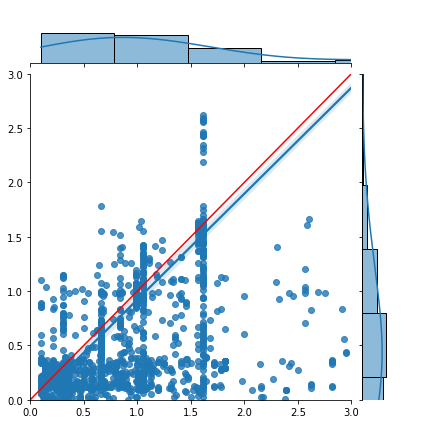

In [109]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some test data
y = results[1][0][results[0][0] > 0]
x = results[0][0][results[0][0] > 0]

g = sns.jointplot(x=x, y=y, kind='reg')
g.ax_marg_x.set_xlim(0,3)
g.ax_marg_y.set_ylim(0,3)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')

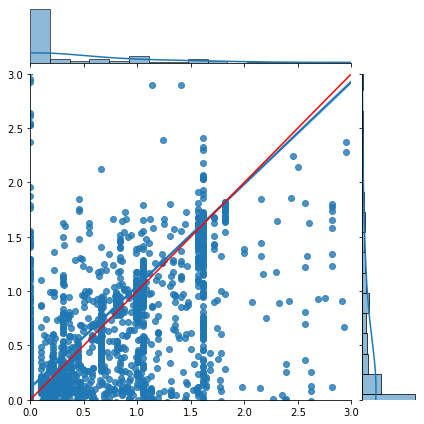

In [85]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some test data
y = results[1][0][results[0][0] > 0]
x = results[0][0][results[0][0] > 0]

g = sns.jointplot(x=x, y=y, kind='reg')
g.ax_marg_x.set_xlim(0,3)
g.ax_marg_y.set_ylim(0,3)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')

In [83]:
y = results[1][0][results[0][0] > 0].numpy()
x = results[0][0][results[0][0] > 0].numpy()
data = pd.DataFrame(np.array([y, x]).T, columns = ["predicted", "true"])
data

,predicted,true
0,6.501760,6.661000
1,0.695250,0.579000
2,0.386489,0.445000
3,0.384134,0.846000
4,0.006669,1.614000
...,...,...
2968,0.311872,0.469714
2969,1.407214,1.567000
2970,0.750464,1.614000
2971,6.512254,6.661000


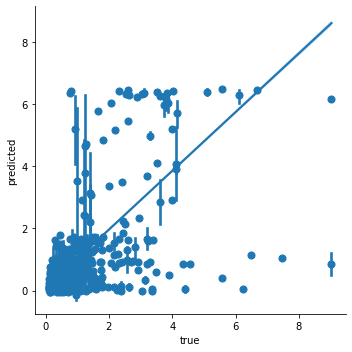

In [86]:
y = results[1][0][results[0][0] > 0].numpy()
x = results[0][0][results[0][0] > 0].numpy()
data = pd.DataFrame(np.array([y, x]).T, columns = ["predicted", "true"])
sns.lmplot(y='predicted', x='true', data=data, x_estimator=np.mean)

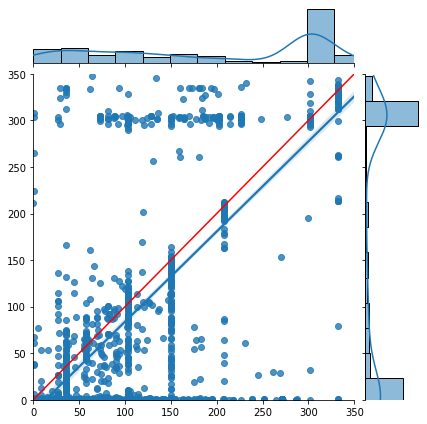

In [110]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some test data
y = results[1][1][results[0][0] > 0]
x = results[0][1][results[0][0] > 0]

g = sns.jointplot(x=x, y=y, kind='reg')
g.ax_marg_x.set_xlim(0,350)
g.ax_marg_y.set_ylim(0,350)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')

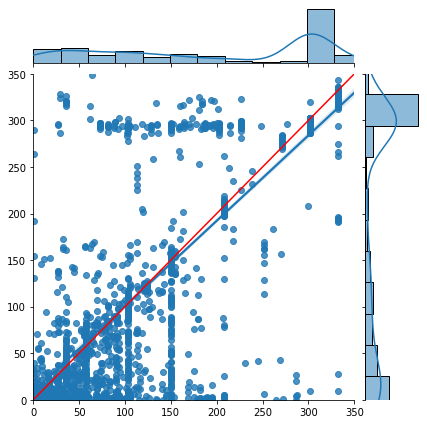

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some test data
y = results[1][1][results[0][0] > 0]
x = results[0][1][results[0][0] > 0]

g = sns.jointplot(x=x, y=y, kind='reg')
g.ax_marg_x.set_xlim(0,350)
g.ax_marg_y.set_ylim(0,350)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')

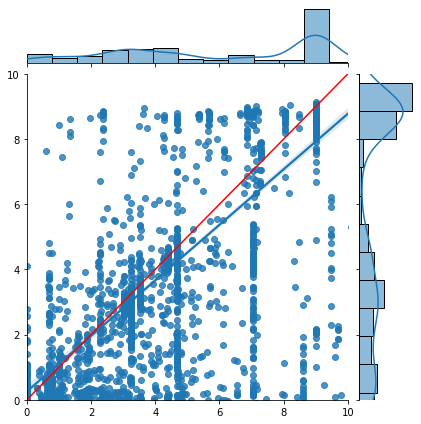

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some test data
y = results[1][2][results[0][0] > 0]
x = results[0][2][results[0][0] > 0]

g = sns.jointplot(x=x, y=y, kind='reg')
g.ax_marg_x.set_xlim(0,10)
g.ax_marg_y.set_ylim(0,10)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')

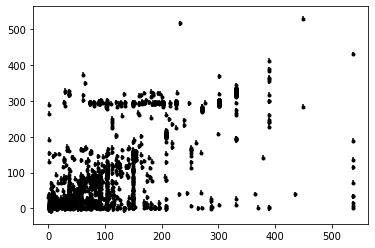

In [72]:
dy = 6.8

plt.errorbar(x, y, yerr=dy, fmt='.k');

In [29]:
def run(project_name, group, entity, mt_weights, model, optimizer, criterion, i):
    
    wandb.init(project=project_name, entity=entity, group=group) #, group="Experimental")
    wandb.run.name = group + "_" + str(i)
    wandb.run.save()
    
    max_acc_test, max_f1_test, max_roc_auc_test = 0, 0, 0
    max_acc_val, max_f1_val, max_roc_auc_val = 0, 0, 0

    min_mae_sjr_test, min_mae_h_index_test, min_mae_impact_factor_test, min_mae_number_test = 100500, 100500, 100500, 100500
    min_mae_sjr_val, min_mae_h_index_val, min_mae_impact_factor_val, min_mae_number_val = 100500, 100500, 100500, 100500
    
    for epoch in tqdm(range(epochs_per_launch)):
        loss = []
        train_loss = train(model, optimizer, criterion, mt_weights)

        if epoch % 10 == 0:
            metrics, metrics_aux = test(model, optimizer, criterion)
            print("Loss:", float(train_loss), "\nTrain:", metrics[0], "\nTest:", metrics[1])

            print("Aux:", metrics_aux)
            
        wandb.log({"main_train/train_acc":  metrics[0][0], "main_test/test_acc": metrics[1][0],\
                   "main_train/train_f1": metrics[0][1], "main_test/test_f1": metrics[1][1],\
                   "main_train/train_roc_auc": metrics[0][2], "main_test/test_roc_auc": metrics[1][2]})

        if metrics[1][0] > max_acc_test:
            max_acc_test = metrics[1][0]
        if metrics[1][1] > max_f1_test:
            max_f1_test = metrics[1][1]
        if metrics[1][2] > max_roc_auc_test:
            max_roc_auc_test = metrics[1][2]  
        wandb.log({"main_max/test_max_acc": max_acc_test,\
                   "main_max/test_max_f1": max_f1_test,\
                   "main_max/test_max_roc_auc": max_roc_auc_test})
        """
        if metrics[1][0] > max_acc_val:
            max_acc_val = metrics[2][0]
        if metrics[1][1] > max_f1_val:
            max_f1_val = metrics[2][1]
        if metrics[1][2] > max_roc_auc_val:
            max_roc_auc_val = metrics[2][2]  
        wandb.log({"val_max_acc": max_acc_val,\
                   "val_max_f1": max_f1_val,\
                   "val_max_roc_auc": max_roc_auc_val})
        """

        wandb.log({"aux_train/train_mae_sjr":  metrics_aux[0][0], "aux_train/train_mae_h_index": metrics_aux[0][1], "aux_train/train_mae_impact_factor": metrics_aux[0][2],
                   "aux_test/test_mae_sjr":  metrics_aux[1][0], "aux_test/test_mae_h_index": metrics_aux[1][1], "aux_test/test_mae_impact_factor": metrics_aux[1][2],})

        if metrics_aux[1][0] < min_mae_sjr_test:
            min_mae_sjr_test = metrics_aux[1][0]
        if metrics_aux[1][1] < min_mae_h_index_test:
            min_mae_h_index_test = metrics_aux[1][1]
        if metrics_aux[1][2] < min_mae_impact_factor_test:
            min_mae_impact_factor_test = metrics_aux[1][2]  
        wandb.log({"aux_min/test_min_mae_sjr": min_mae_sjr_test,\
                   "aux_min/test_min_mae_h_index": min_mae_h_index_test,\
                   "aux_min/test_min_mae_impact_factor": min_mae_impact_factor_test})
        """
        if metrics_aux[1][0] <  min_mae_sjr_val:
            min_mae_sjr_val = metrics_aux[1][0]
        if metrics_aux[1][1] < min_mae_h_index_val:
            min_mae_h_index_val = metrics_aux[1][1]
        if metrics_aux[1][2] < min_mae_impact_factor_val:
            min_mae_impact_factor_val = metrics_aux[1][2]  
        wandb.log({"test_min_mae_sjr": min_mae_sjr_val,\
                   "test_min_mae_h_index": min_mae_h_index_val,\
                   "test_min_mae_impact_factor": min_mae_impact_factor_val})
        """